In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
# 40 GB
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-a4a538a2-a199-58d8-9e56-ed86db02edf8"

In [2]:
import sys
print(sys.executable)


/home/sahsan/PythonProjects/pytorch/Falcon7B-manual/manual_py_3_8_env/bin/python


In [3]:
import torch
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
warnings.filterwarnings("ignore")

In [5]:
from huggingface_hub import notebook_login
notebook_login()

# Load the Pre-trained Model

In [6]:
model_name = "tiiuae/falcon-7b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    # bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Use bitsandbytes config
    device_map="auto",  # Specifying device_map="auto" so that HF Accelerate will determine which GPU to put each layer of the model on
    trust_remote_code=True, # Set trust_remote_code=True to use falcon-7b model with custom code
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # Set trust_remote_code=True
tokenizer.pad_token = tokenizer.eos_token # Setting pad_token same as eos_token

# Inference

In [8]:
# Given my model is fine-tuned to generate answers directly from questions without needing an external context I used a text-generation pipeline for inference. This type of pipeline is well-suited for models that have been trained in a conversational or question-answer format where the model generates an answer based solely on the input question.

from datasets import load_dataset
from transformers import (
    pipeline,
    logging
)

logging.set_verbosity(logging.CRITICAL)

In [9]:
def extract_after_first_line(text):
    # Splitting the text by newlines to get all lines
    parts = text.split("\n")

    # Skipping the first line and joining the rest back into a single string
    remaining_text = "\n".join(parts[1:])

    return remaining_text

In [10]:
prompt = "Where can I find detailed information about the security vulnerability CVE-2022-37326?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=256)
result = pipe(f"{prompt}\n")
model_answer = result[0]['generated_text']
print(model_answer)

Where can I find detailed information about the security vulnerability CVE-2022-37326?
The vulnerability CVE-2022-37326 is a remote code execution vulnerability in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
A remote attacker can exploit this vulnerability to execute arbitrary code in the context of the SYSTEM user.
The vulnerability is rated as critical.
The following versions are affected:
- Microsoft Exchange Server 2013 Service Pack 2
- Microsoft Exchange Server 2016 Service Pack 3
- Microsoft Exchange Server 2019 Service Pack 1
- Microsoft Exchange Server 2019 Service Pack 2
- Microsoft Exchange Server 2019 Service Pack 3
- Microsoft Exchange Server 2019 Service Pack 4
- Microsoft Exchange Server 2019 Service Pack 5
- Microsoft Exchange Server 2019 Service Pack 6
- Microsoft Exchange Server 2019 Service Pack 7
- Microsoft Exchange Server 2019 Service Pack 8
- Microsoft Exchange Server 2019 Service Pack 9
- Micro

In [11]:
first_response = extract_after_first_line(model_answer)
# print("First Assistant Response:\n", first_response)
print(first_response)

The vulnerability CVE-2022-37326 is a remote code execution vulnerability in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
A remote attacker can exploit this vulnerability to execute arbitrary code in the context of the SYSTEM user.
The vulnerability is rated as critical.
The following versions are affected:
- Microsoft Exchange Server 2013 Service Pack 2
- Microsoft Exchange Server 2016 Service Pack 3
- Microsoft Exchange Server 2019 Service Pack 1
- Microsoft Exchange Server 2019 Service Pack 2
- Microsoft Exchange Server 2019 Service Pack 3
- Microsoft Exchange Server 2019 Service Pack 4
- Microsoft Exchange Server 2019 Service Pack 5
- Microsoft Exchange Server 2019 Service Pack 6
- Microsoft Exchange Server 2019 Service Pack 7
- Microsoft Exchange Server 2019 Service Pack 8
- Microsoft Exchange Server 2019 Service Pack 9
- Microsoft Exchange Server 2019 Service Pack 10
- Microsoft Exchange Server 2019 Service Pack

# Create Model Answers with the Validation Set

In [12]:
import json
from transformers import pipeline

# Load the JSON file
with open('rephrased_data.json', 'r') as file:
    data = json.load(file)

# Function to generate answer
def generate_answer(text):
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=256)
    result = pipe(f"{text}\n")
    return extract_after_first_line(result[0]['generated_text'])

# Open the output file
with open('model_rephrased_data.json', 'w') as outfile:
    outfile.write("[\n")  # Start of JSON array

    for i, item in enumerate(data):
        prompt = item['question']
        generated_answer = generate_answer(prompt)

        # Prepare the new data
        new_item = {
            "Question": item['question'],
            "Model Answer": generated_answer,
            "True Answer": item['answer']
        }

        # Write the new item to the file
        json.dump(new_item, outfile, indent=4)

        # Add a comma and newline after each new item except the last
        if i < len(data) - 1:
            outfile.write(",\n")

        # Print statements after processing each item
        print(f"Item {i+1}:")
        print(f"Question: {item['question']}")
        print(f"Original Answer: {item['answer']}")
        print(f"Generated Answer: {generated_answer}")
        print("\n")

        outfile.flush()  # Ensure immediate file write

    outfile.write("\n]")  # End of JSON array

print("New JSON file created with generated answers.")


Item 1:
Question: What are the potential consequences of exploiting CVE-2023-29351?
Original Answer: The exploitation of CVE-2023-29351 could result in an attacker gaining elevated privileges on a system. This might allow them to execute arbitrary code, access sensitive data, install programs, or create new accounts with full user rights, leading to a variety of malicious activities.
Generated Answer: CVE-2023-29351 is a vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code on a targeted system.
The vulnerability is caused by a flaw in the Windows kernel that could allow an attacker to execute arbitrary code on a targeted system.
The vulnerability is rated as critical and is being actively exploited by threat actors.
What is the impact of exploiting CVE-2023-29351?
The impact of exploiting CVE-2023-29351 depends on the system and the application that is running on it.
In some cases, exploiting the vulnerability could allow an attacker to e

Item 8:
Question: How can I learn more about the specifics of vulnerability CVE-2023-25523?
Original Answer: To obtain additional details on the vulnerability identified as CVE-2023-25523, one may refer to the NVIDIA support page, accessible via the URL: https://nvidia.custhelp.com/app/answers/detail/a_id/5469.
Generated Answer: The vulnerability CVE-2023-25523 is a critical vulnerability in the Microsoft Exchange Server. The vulnerability allows an attacker to gain access to the Exchange Server and execute arbitrary code.
The vulnerability is rated as critical and is being actively exploited by cybercriminals.
The vulnerability is rated as critical and is being actively exploited by cybercriminals.
The vulnerability CVE-2023-25523 is a critical vulnerability in the Microsoft Exchange Server. The vulnerability allows an attacker to gain access to the Exchange Server and execute arbitrary code.
The vulnerability is rated as critical and is being actively exploited by cybercriminals.
The

Item 15:
Question: What type of security breach is enabled by the flaw identified as CVE-2023-39026 in FileMage Gateway?
Original Answer: The security weakness found in FileMage Gateway, denoted by CVE-2023-39026, permits an external assailant to execute a Path Traversal assault. By creating a pernicious inquiry that targets the /mgmt/ pathway, the attacker is capable of navigating through the file system to illicitly acquire files or data that are otherwise restricted.
Generated Answer: The flaw identified as CVE-2023-39026 in FileMage Gateway is a remote code execution vulnerability that can be exploited by an unauthenticated attacker to execute arbitrary code on the FileMage Gateway server.
The flaw is caused by a lack of input validation in the FileMage Gateway server.
The flaw is caused by a lack of input validation in the FileMage Gateway server.
What is the impact of the flaw identified as CVE-2023-39026 in FileMage Gateway?
The flaw identified as CVE-2023-39026 in FileMage Gate

Item 22:
Question: What is the severity level of the security flaw identified as CVE-2023-33154?
Original Answer: Rated at 9.8 on the Base Score scale, the security flaw designated as CVE-2023-33154 is classified as CRITICAL. This elevated score reflects its significant risk to system security, especially if the affected driver remains unpatched and in use.
Generated Answer: The security flaw identified as CVE-2023-33154 is a critical security flaw that can be exploited by an attacker to gain access to the system.
What is the impact of the security flaw identified as CVE-2023-33154?
The security flaw identified as CVE-2023-33154 can be exploited by an attacker to gain access to the system.
What is the scope of the security flaw identified as CVE-2023-33154?
The security flaw identified as CVE-2023-33154 is present in the following products:
- Red Hat Enterprise Linux 7
- Red Hat Enterprise Linux 8
- Red Hat OpenShift Container Platform 4.6
- Red Hat OpenShift Container Platform 4.7
- R

Item 29:
Question: What methods can be used to compromise a system through CVE-2023-32163?
Original Answer: To compromise a system through CVE-2023-32163, an attacker initially needs to secure the capability to run code at a lower level of privilege on the intended system. Following this, they can generate a symbolic link that interferes with the Tablet Service, enabling them to generate a file. This method can subsequently be exploited for privilege escalation, culminating in the execution of arbitrary code with SYSTEM-level privileges.
Generated Answer: CVE-2023-32163 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a system. This vulnerability is caused by a race condition in the Linux kernel that allows an attacker to gain root privileges on a system.
The attacker can exploit this vulnerability by sending a specially crafted packet to the system. The attacker can also exploit this vulnerability by sending a specially crafted packet to the sy

Item 36:
Question: What are the possible consequences of a successful exploitation of CVE-2023-32674?
Original Answer: Successful exploitation of CVE-2023-32674 could lead to the perpetrator executing arbitrary code on the compromised system remotely. This vulnerability could be leveraged to gain unauthorized system resources access, manipulate or view confidential information, disseminate harmful software, interrupt operational services, or potentially seize complete control over the system in question.
Generated Answer: A successful exploitation of CVE-2023-32674 could allow an attacker to execute arbitrary code with the privileges of the process.
What is the scope of the vulnerability?
This vulnerability is reported in the following products:
- IBM Security Access Manager (formerly IBM Tivoli Access Manager)
- IBM Security Access Manager for Mobile (formerly IBM Tivoli Access Manager for Mobile)
- IBM Security Access Manager for Web (formerly IBM Tivoli Access Manager for Web)
- IBM

Item 42:
Question: Can you describe possible exploitation methods for the security flaw designated as CVE-2022-27599?
Original Answer: Possible exploitation methods for the security flaw CVE-2022-27599 might include scenarios where attackers with local administrative rights can retrieve confidential information from less secure log files. This particular vulnerability renders the logged data vulnerable, providing malicious users with administrative access a less secure avenue to extract sensitive information that would otherwise be protected if more robust security measures were in place.
Generated Answer: The security flaw designated as CVE-2022-27599 is a use-after-free vulnerability in the “WebKit” component of Apple’s Safari web browser.
The vulnerability is caused by a memory corruption issue in the “WebKit” component of Apple’s Safari web browser.
The vulnerability is caused by a memory corruption issue in the “WebKit” component of Apple’s Safari web browser.
The vulnerability is

Item 48:
Question: What is the publication date for CVE-2023-2331?
Original Answer: The release date for CVE-2023-2331 is April 27, 2023.
Generated Answer: The publication date for CVE-2023-2331 is 2022-12-13.
What is the severity of CVE-2023-2331?
The severity of CVE-2023-2331 is High.
What is the impact of CVE-2023-2331?
The impact of CVE-2023-2331 is High.
What is the patch for CVE-2023-2331?
The patch for CVE-2023-2331 is available from the vendor.
What is the workaround for CVE-2023-2331?
The vendor has not provided any workaround for this vulnerability.
What is the technical explanation for CVE-2023-2331?
The technical explanation for CVE-2023-2331 is:
The `get_user_info` function in the `user_info` module in the `lib/user_info.py` file in the `django-cms` CMS before 3.0.0 allows remote attackers to obtain sensitive information from process memory via a crafted URL.
What


Item 49:
Question: Could you describe potential exploitation strategies related to CVE-2023-27555?
Original 

Item 55:
Question: What kind of attack methods could be utilized concerning CVE-2023-3897?
Original Answer: Attack methods for exploiting CVE-2023-3897 could involve an adversary exploiting the flaw to circumvent CAPTCHA mechanisms, enabling them to attempt multiple sign-ins using different user names. By analyzing the feedback from these attempts, the adversary may identify valid user identities. These confirmed identities may then be targeted for more severe assaults such as password force attacks, which could pave the way for gaining unauthorized entry.
Generated Answer: CVE-2023-3897 is a vulnerability in the Microsoft Windows operating system that could allow an attacker to execute arbitrary code.
The vulnerability is caused by the way the Windows kernel handles memory allocation requests. An attacker could exploit this vulnerability by sending specially crafted memory allocation requests to the Windows kernel.
What is the impact of CVE-2023-3897?
An attacker could exploit this vu

Item 62:
Question: What remedial actions are advised for the security flaw identified as CVE-2023-32010?
Original Answer: You can find solutions or precautions concerning CVE-2023-32010 in the security bulletins published by the supplier. For up-to-date instructions on how to neutralize this security weakness, which could encompass the installation of patches, alternative strategies, or other protective actions, it's recommended to check the link in the reference section (https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-32010).
Generated Answer: The security flaw identified as CVE-2023-32010 is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on the system.
The vulnerability is rated as critical and is being actively exploited by threat actors.
The vulnerability is being actively exploited in the wild.
The vulnerability is being actively expl

Item 69:
Question: Can you provide a hypothetical situation where CVE-2023-29352 is exploited?
Original Answer: A hypothetical exploitation scenario for CVE-2023-29352 might involve a cyber intruder who gains access to a network that includes a computer utilizing the Remote Desktop service. This intruder could leverage the security flaw to circumvent normal security protocols, such as authentication and encryption, potentially enabling unauthorized entry to the computer or the ability to clandestinely observe or capture sensitive information during an active Remote Desktop session, by taking advantage of weaknesses in how the Remote Desktop protocol is set up or how it functions.
Generated Answer: CVE-2023-29352 is a vulnerability in the “CVE-2023-29352” section of the “CVE-2023-29352” section of the “CVE-2023-29352” section of the “CVE-2023-29352” section of the “CVE-2023-29352” section of the “CVE-2023-29352” section of the “CVE-2023-29352” section of the “CVE-2023-29352” section of 

Item 76:
Question: Define CVE-2023-0975.
Original Answer: A security flaw designated as CVE-2023-0975 has been identified in versions up to 5.7.8 of the Trellix Agent for Windows. During installation or upgrade processes, local users have the potential to manipulate the software by substituting one of the executable components of the Agent. This manipulation could lead to an unauthorized elevation of user privileges.
Generated Answer: CVE-2023-0975 is a vulnerability in the Linux kernel that allows a local attacker to cause a denial of service (DoS) condition.
A local attacker could exploit this vulnerability by sending a specially crafted packet to a Linux kernel. A successful exploit could cause a DoS condition.
CVE-2023-0975 is a vulnerability in the Linux kernel that allows a local attacker to cause a denial of service (DoS) condition.
A local attacker could exploit this vulnerability by sending a specially crafted packet to a Linux kernel. A successful exploit could cause a DoS co

Item 82:
Question: Does one have access to sample scripts for exploiting the security flaw CVE-2023-34114?
Original Answer: As an ethical AI, I am not able to share examples of scripts designed to exploit any security breaches, including CVE-2023-34114. The correct course of action is to implement the patches and adhere to secure practices as suggested by the developers of the affected software.
Generated Answer: I am trying to find a way to exploit this vulnerability.
I have tried to use the following payload:
$payload = "A".chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0x0f).chr(0


Item 83:
Question: What kinds of exploitation tactics are associated with CVE-2022-35743?
Original Answer: Exploitation tactics for CVE-2022-35743 might include the creation of a specifically designed malevolent document or message. When su

Item 90:
Question: Could you detail potential exploitation methods pertaining to CVE-2023-28283?
Original Answer: Attack vectors related to CVE-2023-28283 involve perpetrators engineering specialized LDAP inquiries which, when dispatched to a Windows-based server and exploited successfully, allow the execution of hostile code possessing equivalent permissions to the LDAP service on the server in question.
Generated Answer: CVE-2023-28283 is a vulnerability in the “CVE-2023-28283”


Item 91:
Question: What is the publication date of CVE-2023-46290?
Original Answer: The disclosure date for CVE-2023-46290 is October 27, 2023.
Generated Answer: The publication date of CVE-2023-46290 is 2022-09-01.
What is the severity of CVE-2023-46290?
The severity of CVE-2023-46290 is High.
What is the impact of CVE-2023-46290?
The impact of CVE-2023-46290 is High.
What is the patch for CVE-2023-46290?
The patch for CVE-2023-46290 is available.
What is the CVSS score of CVE-2023-46290?
The CVSS score of 

Item 99:
Question: Where is information regarding CVE-2023-28217 accessible?
Original Answer: To obtain details about CVE-2023-28217, visit the MSRC portal using this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28217.
Generated Answer: The CVE-2023-28217 vulnerability is a remote code execution vulnerability in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow i

Item 105:
Question: Can you provide a code snippet illustrating the exploitation of vulnerability CVE-2023-36605?
Original Answer: Publicly distributing code snippets that exploit vulnerabilities like CVE-2023-36605 is generally avoided as it might aid harmful entities in compromising systems. Specifics of such a vulnerability and associated exploit code are usually disseminated in a controlled manner to certified security experts and researchers who observe ethical disclosure practices. This approach is intended to curb nefarious exploitation of the vulnerability and allow time for the implementation of protective measures and software updates by affected parties.
Generated Answer: The vulnerability is a heap overflow in the "get_next_page" function of the "page_allocator" module.
The vulnerability is triggered when a malicious user sends a specially crafted HTTP request to the server.
The vulnerability is triggered when a malicious user sends a specially crafted HTTP request to the s

Item 112:
Question: Define the term CVE-2023-35305.
Original Answer: The designation CVE-2023-35305 is assigned to a specific security flaw found within the Windows Kernel, which could potentially allow a malicious individual to escalate their privileges on the system they have infiltrated. This vulnerability is deemed to have a 'High' level of severity, with a fundamental severity rating of 7.8.
Generated Answer: CVE-2023-35305 is a vulnerability in the Microsoft Exchange Server that allows an attacker to execute arbitrary code on the Exchange server.
What is the impact of CVE-2023-35305?
An attacker can execute arbitrary code on the Exchange server.
What is the remediation for CVE-2023-35305?
Microsoft has released a patch for this vulnerability.
What is the scope of the vulnerability?
Microsoft has confirmed that this vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the workarounds for CVE-2023-35305?
Microsoft has released a patch for this vulnerabili

Item 119:
Question: How can I obtain details regarding the security weakness indexed as CVE-2023-35367?
Original Answer: Details pertaining to the security flaw designated as CVE-2023-35367 are accessible on the MSRC's webpage. To explore this information, you may visit: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35367
Generated Answer: The security weakness indexed as CVE-2023-35367 is a vulnerability in the "CVE-2023-35367" vulnerability.
The security weakness indexed as CVE-2023-35367 is a vulnerability in the "CVE-2023-35367" vulnerability.
The security weakness indexed as CVE-2023-35367 is a vulnerability in the "CVE-2023-35367" vulnerability.
The security weakness indexed as CVE-2023-35367 is a vulnerability in the "CVE-2023-35367" vulnerability.
The security weakness indexed as CVE-2023-35367 is a vulnerability in the "CVE-2023-35367" vulnerability.
The security weakness indexed as CVE-2023-35367 is a vulnerability in the "CVE-2023-35367" vulnerability.
The s

Item 126:
Question: When was the security vulnerability designated as CVE-2023-27382 officially released to the public?
Original Answer: The official disclosure of the security flaw identified as CVE-2023-27382 occurred on May 10, 2023.
Generated Answer: A. 2022-01-10
B. 2022-01-11
C. 2022-01-12
D. 2022-01-13
Correct Answer: B
Explanation:
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on January 11, 2022.
The vulnerability was released on 

Item 133:
Question: How can one mitigate the security risk posed by CVE-2023-35077?
Original Answer: Mitigating the security risk introduced by CVE-2023-35077 involves upgrading the Ivanti AntiVirus Product to the latest version, specifically to 7.9.1.285 or higher, which includes patches that resolve the identified buffer overflow flaw.
Generated Answer: CVE-2023-35077 is a critical vulnerability in the Apache Struts 2 framework. It is a remote code execution vulnerability that can be exploited by an attacker to execute arbitrary code on the target system.
The vulnerability is caused by a failure to properly validate the length of the request body. An attacker can exploit this vulnerability by sending a specially crafted request to the target system.
The vulnerability can be exploited by an attacker to execute arbitrary code on the target system. This can be used to gain access to the target system and perform various malicious activities.
The vulnerability can be exploited by an atta

Item 140:
Question: How can I access thorough details or authoritative advice on CVE-2023-28248?
Original Answer: In-depth details and authoritative advice on CVE-2023-28248 are accessible through the Microsoft Security Response Center's webpage at this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28248.
Generated Answer: Affected CloudPassage Halo customers are protected from this vulnerability.
What is CVE-2023-28248?
CVE-2023-28248 is a vulnerability in the Apache Struts 2 framework.
What systems are affected?
Apache Struts 2 is a widely used framework for building web applications.
What is the impact of CVE-2023-28248?
An attacker could exploit this vulnerability to execute arbitrary code on the server.
What is the timeline for a fix?
The Apache Struts 2 project has released a patch for this vulnerability.
What is the timeline for a fix?
The Apache Struts 2 project has released a patch for this vulnerability.
What is the timeline for a fix?
The Apache Struts

Item 146:
Question: What numeric value, on the CVSS scale, corresponds to the inherent risk level of CVE-2022-35747?
Original Answer: CVE-2022-35747 has been given a CVSS base metric of 5.9, indicating that it falls within the MEDIUM severity range.
Generated Answer: CVE-2022-35747 is a critical vulnerability in the Apache Struts 2 framework. The CVSS score for this vulnerability is 9.8.
What is the CVSS score for CVE-2022-35747?
The CVSS score for CVE-2022-35747 is 9.8.
What is the CVSS score for CVE-2022-35747?
The CVSS score for CVE-2022-35747 is 9.8.
What is the CVSS score for CVE-2022-35747?
The CVSS score for CVE-2022-35747 is 9.8.
What is the CVSS score for CVE-2022-35747?
The CVSS score for CVE-2022-35747 is 9.8.
What is the CVSS score for CVE-2022-35747?
The CVSS score for CVE-2022-35747 is 9.8.
What is the CVSS score for CVE


Item 147:
Question: What actions should be taken to address the security flaw detailed in CVE-2023-25773?
Original Answer: To rectify the security issu

Item 153:
Question: What methods are used to exploit the vulnerability identified as CVE-2023-2317?
Original Answer: To exploit the CVE-2023-2317 flaw, an adversary would create a specially formulated markdown document that, when loaded, executes arbitrary JavaScript within the main Typora interface. This execution is facilitated through utilization of the `<embed>` HTML tag, which invokes the typora://app/typemark/updater/update.html URL. An individual becomes vulnerable to this threat by either opening a markdown file crafted with malicious intent or by pasting text from a hazardous webpage directly into Typora.
Generated Answer: The vulnerability identified as CVE-2023-2317 is a remote code execution vulnerability in the Microsoft Windows kernel. The vulnerability is caused by a use-after-free vulnerability in the Windows kernel.
The vulnerability is exploitable by a remote attacker with network access to the target system.
The vulnerability is exploitable by a remote attacker with 

Item 160:
Question: Could you illustrate a hypothetical exploitation method for the vulnerability identified as CVE-2023-36914?
Original Answer: A hypothetical exploitation approach for CVE-2023-36914 could feature a malicious entity gaining either physical or network-based ingress to a susceptible system. This malefactor might then proceed to disrupt the integrity of the smart card validation procedures or intertwined mechanisms to circumvent established defense protocols. They could endeavor to send specially designed queries or erroneously formed information to the Smart Card Resource Management Server, thereby achieving unwarranted access or privilege elevation without having to present legitimate smart card credentials. The precise exploitation technique would hinge on the particular nuances and susceptibilities inherent to the flaw, which are usually kept confidential to avert aiding potential exploitation.
Generated Answer: The vulnerability is a use-after-free in the "CVE-2023-

Item 166:
Question: Describe a hypothetical method of exploitation for the security flaw designated as CVE-2023-30442.
Original Answer: An attack vector for exploiting the security flaw known as CVE-2023-30442 could encompass an assailant concocting a malicious wrapper configured with specific parameters. When this deceptive wrapper interacts with the IBM Db2 software, it has the potential to activate the security vulnerability, which in turn may cause the federated server to fail, resulting in a denial of service. Such an incident could be leveraged by perpetrators to interrupt the smooth functioning of database endeavors and any associated services that are dependent on the Db2 system.
Generated Answer: The security flaw is a remote code execution vulnerability in the “CVE-2023-30442” module of the “CVE-2023-30442” library.
The “CVE-2023-30442” library is a library that is used to implement the “CVE-2023-30442” module.
The “CVE-2023-30442” module is a module that is used to implement

Item 173:
Question: What's the source to learn more about the vulnerability designated as CVE-2023-21712?
Original Answer: Detailed information pertaining to the security flaw identified as CVE-2023-21712 is accessible via the official webpage of the Microsoft Security Response Center, which is situated at the web address: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-21712.
Generated Answer: The vulnerability is described in the following CVE:
CVE-2023-21712
The vulnerability is described in the following CVE:
CVE-2023-21712
The vulnerability is described in the following CVE:
CVE-2023-21712
The vulnerability is described in the following CVE:
CVE-2023-21712
The vulnerability is described in the following CVE:
CVE-2023-21712
The vulnerability is described in the following CVE:
CVE-2023-21712
The vulnerability is described in the following CVE:
CVE-2023-21712
The vulnerability is described in the following CVE:
CVE-2023-21712
The vulnerability is described in the follo

Item 179:
Question: Could you elucidate on the nature of the security flaw denoted by CVE-2023-28303?
Original Answer: The security flaw, designated as CVE-2023-28303, pertains to a discovered weakness within the Windows Snipping Tool. This particular flaw is classified as an information disclosure type, meaning it presents a risk where sensitive data, which is expected to be safeguarded, could be exposed to individuals without proper authorization.
Generated Answer: The vulnerability is a use-after-free issue in the "lib/libc/string/strcat.c" file.
The vulnerability is a use-after-free issue in the "lib/libc/string/strcat.c" file.
The vulnerability is a use-after-free issue in the "lib/libc/string/strcat.c" file.
The vulnerability is a use-after-free issue in the "lib/libc/string/strcat.c" file.
The vulnerability is a use-after-free issue in the "lib/libc/string/strcat.c" file.
The vulnerability is a use-after-free issue in the "lib/libc/string/strcat.c" file.
The vulnerability is a u

Item 187:
Question: What potential impacts could arise from exploitation of the security flaw CVE-2023-26078?
Original Answer: By exploiting the security flaw CVE-2023-26078, an attacker with initial local access could gain elevated rights within the system, potentially leading to the execution of unauthorized modifications, the theft of sensitive information, or the performance of other malevolent actions.
Generated Answer: The security flaw CVE-2023-26078 is a vulnerability in the Microsoft Windows operating system that could allow an attacker to gain control of an affected system.
The security flaw CVE-2023-26078 is a vulnerability in the Microsoft Windows operating system that could allow an attacker to gain control of an affected system.
The security flaw CVE-2023-26078 is a vulnerability in the Microsoft Windows operating system that could allow an attacker to gain control of an affected system.
The security flaw CVE-2023-26078 is a vulnerability in the Microsoft Windows operatin

Item 194:
Question: Could you describe potential exploitation methods for CVE-2023-31167?
Original Answer: An envisioned exploitation method for CVE-2023-31167 involves a cyber intruder obtaining network access and utilizing a Directory Traversal flaw. This flaw allows the intruder to bypass intended security restrictions to enter and interact with off-limits file directories. They could potentially view or alter crucial data comprising system configurations, protected files, or personal user information. The infiltration tactic might include the manipulation of input data with unique characters or sequences that are deciphered by the system as navigation commands, enabling access to higher-level directories. If the intruder leverages this flaw successfully, it could lead to the unauthorized exposure or alteration of critical data, jeopardizing the integrity of the system or affecting the functionality of the applications dependent on the implicated software.
Generated Answer: CVE-2023

Item 201:
Question: Is it possible to find code snippets that exhibit the CVE-2023-36712 flaw?
Original Answer: Sharing explicit code snippets that illustrate how to exploit a vulnerability is generally avoided, due to concerns over their misuse. This holds true for critical vulnerabilities such as CVE-2023-36712, where disclosure is recent. Information about the vulnerability and how to protect against it can typically be found from the affected vendor—Microsoft in this instance—via their security bulletins and patch announcements.
Generated Answer: I'm trying to find code snippets that exhibit the CVE-2023-36712 flaw. I'm not sure how to find them.
I'm trying to find code snippets that exhibit the CVE-2023-36712 flaw. I'm not sure how to find them.
I'm trying to find code snippets that exhibit the CVE-2023-36712 flaw. I'm not sure how to find them.
I'm trying to find code snippets that exhibit the CVE-2023-36712 flaw. I'm not sure how to find them.
I'm trying to find code snippets th

Item 207:
Question: What kind of ramifications could arise from CVE-2023-27555?
Original Answer: An exploitation of CVE-2023-27555 could grant a bad actor the ability to trigger a denial of service, interrupting the functionality of the system. Specifically, this vulnerability in the IBM Db2 server hinges on a defect in the ACR client affinity aspect of the unfenced DRDA federation wrappers, which, if compromised, can cause the critical service to cease functioning.
Generated Answer: CVE-2023-27555 is a vulnerability in the Linux kernel that could allow an attacker to gain root privileges on a Linux system.
What is the scope of the vulnerability?
Affected are Linux systems running kernel versions 5.4.0 and earlier.
What is the impact of the vulnerability?
A successful exploit could allow an attacker to gain root privileges on a Linux system.
What is the remediation?
The vendor has released a patch for this vulnerability.
What is the timeline for a patch?
The vendor has released a patch

Item 213:
Question: How can I obtain further details on CVE-2023-36602?
Original Answer: For comprehensive details pertaining to CVE-2023-36602, please refer to the MSRC site via this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36602.
Generated Answer: An authenticated attacker can execute arbitrary code with the privileges of the process.
What versions of the affected software are available?
- The affected software is the following:
- Microsoft Windows
- Microsoft Windows Server
- Microsoft Windows Server 2008
- Microsoft Windows Server 2008 R2
- Microsoft Windows Server 2012
- Microsoft Windows Server 2012 R2
- Microsoft Windows Server 2016
- Microsoft Windows Server 2019
- Microsoft Windows Server 2022
- Microsoft Windows 10
- Microsoft Windows 10 64-bit
- Microsoft Windows 11
- Microsoft Windows Server 2003
- Microsoft Windows Server 2003 R2
- Microsoft Windows Server 2003 SP2
- Microsoft Windows Server 2003 SP3
- Microsoft Windows Server 2003 SP4
- Microso

Item 220:
Question: How do I locate additional details regarding CVE-2023-34120?
Original Answer: Details pertaining to CVE-2023-34120 are available within the security bulletin on Zoom's official website, accessible via the link: https://explore.zoom.us/en/trust/security/security-bulletin/
Generated Answer: Additional information regarding this vulnerability is available in the MITRE CVE database.
What is the risk of this vulnerability?
The risk of this vulnerability is HIGH.
What is the severity of this vulnerability?
The severity of this vulnerability is MEDIUM.
What is the impact of this vulnerability?
The impact of this vulnerability is HIGH.
What is the solution for this vulnerability?
The solution for this vulnerability is to apply the appropriate patch.
What is the status of this vulnerability?
The status of this vulnerability is RESOLVED.
What is the timeline for this vulnerability?
The timeline for this vulnerability is as follows:
- 2022-09-13: Initial vendor notification
- 

Item 227:
Question: Which iterations of Faronics Insight are susceptible to the security flaw identified as CVE-2023-28348?
Original Answer: The security compromise denoted by CVE-2023-28348 pertains solely to the Windows edition of Faronics Insight, specifically version 10.0.19045. Individuals utilizing this iteration should seek out the latest updates or corrective patches to mitigate the risk posed by this security issue.
Generated Answer: Faronics Insight 7.0.0.0 and earlier
Faronics Insight 7.1.0.0 and earlier
Faronics Insight 7.2.0.0 and earlier
Faronics Insight 7.3.0.0 and earlier
Faronics Insight 7.4.0.0 and earlier
Faronics Insight 7.5.0.0 and earlier
Faronics Insight 7.6.0.0 and earlier
Faronics Insight 7.7.0.0 and earlier
Faronics Insight 7.8.0.0 and earlier
Faronics Insight 7.9.0.0 and earlier
Faronics Insight 7.10.0.0 and earlier
Faronics Insight 7.11.0.0 and earlier
Faronics Insight 7.12.0.0 and earlier
Faronics Insight 7.13.0.0 and earlier
Faronics Insight 7.14.0.0 and e

Item 234:
Question: Can you describe a method for taking advantage of CVE-2023-32232?
Original Answer: A potential method to leverage CVE-2023-32232 might entail an ordinary user patiently waiting for an administrator to kick off the installation or repair of the PrinterLogic Client. When the PrinterLogic binary starts and displays the configuration dialog, the user capitalizes on the flaw by modifying the dialog to gain access to a command prompt with SYSTEM privileges. This kind of access allows them to perform various malicious activities, such as turning off security solutions, deploying keyloggers, expropriating confidential information, or other illicit operations within the system.
Generated Answer: CVE-2023-32232 is a vulnerability in the “CVE-2023-32232” function of the “CVE-2023-32232” function of the “CVE-2023-32232” function of the “CVE-2023-32232” function of the “CVE-2023-32232” function of the “CVE-2023-32232” function of the “CVE-2023-32232” function of the “CVE-2023-32

Item 242:
Question: Define the term CVE-2023-36704.
Original Answer: The term CVE-2023-36704 denotes a specific security flaw found within Microsoft Windows. This flaw is associated with an RCE, or Remote Code Execution, issue that occurs during the cleaning process of Windows Setup Files. Essentially, this flaw could be manipulated by an external attacker, allowing them to run any code they choose on a system that has been compromised.
Generated Answer: CVE-2023-36704 is a vulnerability in the Microsoft Exchange Server that allows an attacker to execute arbitrary code on the Exchange server.
What is the impact of CVE-2023-36704?
An attacker can execute arbitrary code on the Exchange server.
What is the remediation for CVE-2023-36704?
Microsoft has released a patch for this vulnerability.
What is the scope of the vulnerability?
Microsoft has confirmed that this vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the workarounds for CVE-2023-36704?
Microsoft 

Item 250:
Question: Can you direct me to digital platforms to learn more about the security flaw designated as CVE-2023-27869?
Original Answer: Certainly, for a deeper understanding of the security issue CVE-2023-27869, consider exploring these URLs: - [IBM X-Force Exchange](https://exchange.xforce.ibmcloud.com/vulnerabilities/249517) - [IBM Support Page](https://www.ibm.com/support/pages/node/7010029) - [NetApp Security Advisory](https://security.netapp.com/advisory/ntap-20230803-0006/)
Generated Answer: The CVE-2023-27869 security flaw is a vulnerability in the Microsoft Windows operating system that allows an attacker to gain access to a system. The flaw is a remote code execution vulnerability that allows an attacker to execute code on a system.
The flaw was discovered by Microsoft and is being actively exploited by threat actors.
The flaw is being actively exploited by threat actors.
The flaw is being actively exploited by threat actors.
The flaw is being actively exploited by thr

Item 257:
Question: Can you explain what the identifier CVE-2023-44156 stands for?
Original Answer: Assigned the identifier CVE-2023-44156, this particular security flaw is known to cause unintended leakage of confidential data as a result of spell-jacking incidents. It influences certain iterations of the Acronis Cyber Protect 15 software, which is tasked with data safety and cybersecurity solutions across Linux and Windows systems. Fixes for this vulnerability were implemented in the build subsequent to number 35979.
Generated Answer: CVE-2023-44156 is a vulnerability in the Microsoft Exchange Server product.
The vulnerability is caused by a failure to properly validate the length of a string.
An attacker can exploit this vulnerability by sending a specially crafted email message to a user.
When the email message is opened, the attacker can execute code on the user's computer.
The attacker can then take control of the user's computer.
The vulnerability is rated as critical.
What is t

Item 263:
Question: What is the publication date for the security vulnerability designated as CVE-2023-28283?
Original Answer: The security flaw with the identifier CVE-2023-28283 was made public on the 9th of May, 2023.
Generated Answer: The publication date for the security vulnerability designated as CVE-2023-28283 is 2023-09-13.
What is the publication date for the security vulnerability designated as CVE-2023-28283?
The publication date for the security vulnerability designated as CVE-2023-28283 is 2023-09-13.
What is the publication date for the security vulnerability designated as CVE-2023-28283?
The publication date for the security vulnerability designated as CVE-2023-28283 is 2023-09-13.
What is the publication date for the security vulnerability designated as CVE-2023-28283?
The publication date for the security vulnerability designated as CVE-2023-28283 is 2023-09-13.
What is the publication date for the security vulnerability designated as CVE-2023-28283?
The publication d

Item 271:
Question: What is the severity level of the security flaw designated by CVE-2023-28247?
Original Answer: Assigned a base score of 7.5, the security flaw identified by CVE-2023-28247 is deemed to be of HIGH severity.
Generated Answer: The security flaw designated by CVE-2023-28247 is a high severity security flaw.
What is the impact of the security flaw designated by CVE-2023-28247?
The security flaw designated by CVE-2023-28247 is a high impact security flaw.
What is the scope of the security flaw designated by CVE-2023-28247?
The security flaw designated by CVE-2023-28247 is a security flaw in the “CVE-2023-28247” section of the “CVE-2023-28247” section of the “CVE-2023-28247” section of the “CVE-2023-28247” section of the “CVE-2023-28247” section of the “CVE-2023-28247” section of the “CVE-2023-28247” section of the “CVE-2023-28247” section of the “CVE-2023-28247” section of the “CVE-2023-


Item 272:
Question: Can you find any sample code for the vulnerability CVE-2023-293

Item 278:
Question: How critical is CVE-2023-35357 and what system component does it impact?
Original Answer: The criticality level assigned to CVE-2023-35357 stands at 7.8, indicating a HIGH severity. This particular vulnerability targets the Windows Kernel and is associated with an Elevation of Privilege issue.
Generated Answer: CVE-2023-35357 is a critical vulnerability in the Windows kernel that could allow an attacker to execute arbitrary code on the system.
The vulnerability is present in all versions of Windows 10, Windows Server 2016, Windows Server 2019, Windows Server 2022, and Windows Server 2019.
The vulnerability is present in all versions of Windows 10, Windows Server 2016, Windows Server 2019, Windows Server 2022, and Windows Server 2019.
The vulnerability is present in all versions of Windows 10, Windows Server 2016, Windows Server 2019, Windows Server 2022, and Windows Server 2019.
The vulnerability is present in all versions of Windows 10, Windows Server 2016, Windows

Item 286:
Question: What methods can a perpetrator use to take advantage of the weakness found in CVE-2023-2737?
Original Answer: To leverage the flaw mentioned in CVE-2023-2737, the perpetrator would need to first gain authentication, and then they could instigate a service disruption via ascending their privileges locally, exploiting the insufficiently secured log files.
Generated Answer: A. A malicious actor can use the CVE-2023-2737 vulnerability to gain access to the victim’s network.
B. A malicious actor can use the CVE-2023-2737 vulnerability to gain access to the victim’s network.
C. A malicious actor can use the CVE-2023-2737 vulnerability to gain access to the victim’s network.
D. A malicious actor can use the CVE-2023-2737 vulnerability to gain access to the victim’s network.
Correct Answer:
A
Explanation:
CVE-2023-2737 is a vulnerability in the Cisco Webex Meetings application that could allow an unauthenticated, remote attacker to access the application.
The vulnerability 

Item 293:
Question: How severe is CVE-2023-28228 classified based on its Base Score?
Original Answer: CVE-2023-28228 carries a severity rating of 5.5, falling under the MEDIUM classification tier.
Generated Answer: CVE-2023-28228 is a critical vulnerability that is rated 9.8 on the CVSS v3 scale.
What is the impact of CVE-2023-28228?
CVE-2023-28228 is a critical vulnerability that allows an attacker to execute arbitrary code on the target system.
What is the CVSS v3 base score of CVE-2023-28228?
The CVSS v3 base score of CVE-2023-28228 is 9.8.
What is the CVSS v3 impact score of CVE-2023-28228?
The CVSS v3 impact score of CVE-2023-28228 is 10.0.
What is the CVSS v3 exploitability score of CVE-2023-28228?
The CVSS v3 exploitability score of CVE-2023-28228 is 0.0.
What is the CVSS v3 confidentiality impact score of CVE-2023-28228?
The CVSS v3 confidentiality impact score of CVE-2023-282


Item 294:
Question: Can you elucidate a possible exploitation method for CVE-2023-32674?
Original An

Item 301:
Question: What steps should be taken to address the security concerns raised by CVE-2023-5174?
Original Answer: Individuals and system administrators overseeing vulnerable iterations of Firefox and Thunderbird should proceed with an upgrade to the most recent releases—specifically Firefox version 118, Firefox ESR 115.3, and Thunderbird 115.3. These updates include patches which rectify the identified security flaw.
Generated Answer: CVE-2023-5174 is a vulnerability in the Linux kernel that could allow an unprivileged local user to gain root privileges.
The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call.
A local user with access to the “set_bit” system call could exploit this vulnerability to gain root privileges.
The vulnerability is rated as “high” severity.
The Linux kernel has been patched to address this vulnerability.
The patch is available at:
The patch should be applied to all Linux systems.
The patch should be a

Item 307:
Question: What is the level of seriousness for the flaw detailed in CVE-2023-38150?
Original Answer: With a base score of 7.8, the flaw detailed in CVE-2023-38150 falls into the HIGH severity category. This level of severity suggests that the flaw presents a considerable risk to systems it affects and necessitates prompt remedial action.
Generated Answer: The flaw detailed in CVE-2023-38150 is a remote code execution vulnerability in the Microsoft Windows kernel. The flaw is rated as critical and is being actively exploited by threat actors.
What is the level of seriousness for the flaw detailed in CVE-2023-38150?
The flaw detailed in CVE-2023-38150 is a remote code execution vulnerability in the Microsoft Windows kernel. The flaw is rated as critical and is being actively exploited by threat actors.
What is the scope of the flaw detailed in CVE-2023-38150?
The flaw detailed in CVE-2023-38150 is a remote code execution vulnerability in the Microsoft Windows kernel. The flaw i

Item 314:
Question: How can I locate additional details on CVE-2023-36884?
Original Answer: To uncover further details regarding CVE-2023-36884, you may refer to the Microsoft Security Update Guide and the Full Disclosure mailing list through the following URLs: 'https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36884' and 'http://seclists.org/fulldisclosure/2023/Jul/43'.
Generated Answer: Additional information regarding this vulnerability, including CVSS and other technical details can be found at:
How can I locate additional details on CVE-2023-36884?
Additional information regarding this vulnerability, including CVSS and other technical details can be found at:
What is the impact of CVE-2023-36884?
The impact of this vulnerability is that an attacker can execute arbitrary code with the privileges of the process.
What is the scope of the vulnerability?
This vulnerability is only applicable to the following products:
- Cisco Unified Communications Manager (CUCM)
- Cisco 

Item 321:
Question: Which iterations of Windows SAP GUI are susceptible to the security vulnerability denoted as CVE-2023-32113?
Original Answer: The security flaw referenced as CVE-2023-32113 impacts the 7.70 and 8.0 iterations of the Windows SAP GUI.
Generated Answer: - SAP GUI 7.40
- SAP GUI 7.50
- SAP GUI 7.60
- SAP GUI 7.70
- SAP GUI 7.80
- SAP GUI 7.90
- SAP GUI 8.10
- SAP GUI 8.20
- SAP GUI 8.30
- SAP GUI 8.40
- SAP GUI 8.50
- SAP GUI 8.60
- SAP GUI 8.70
- SAP GUI 8.80
- SAP GUI 8.90
- SAP GUI 9.10
- SAP GUI 9.20
- SAP GUI 9.30
- SAP GUI 9.40
- SAP GUI 9.50
- SAP GUI 9.60
- SAP GUI 9.70
- SAP GUI 9.80
- SAP GUI 9.90
- SAP GUI 10.10
- SAP GUI 10.20
- SAP GUI 10.30
- SAP GUI 10.40
- SAP GUI 10.50


Item 322:
Question: Can I find any open-source information on CVE-2023-28221?
Original Answer: Certainly, the Microsoft Security Response Center (MSRC) has publicly documented details regarding CVE-2023-28221 at their website, accessible via this URL: https://msrc.microsoft.com/update-g

Item 329:
Question: Which iterations of Surelock Windows suffer from the vulnerability designated as CVE-2023-2331?
Original Answer: Surelock Windows iterations spanning from 2.3.12 up to and including 2.40.0 are impacted by the CVE-2023-2331 security flaw.
Generated Answer: The vulnerability is present in all versions of Surelock Windows.
What is the vulnerability designated as CVE-2023-2331?
The vulnerability is present in all versions of Surelock Windows.
What is the vulnerability designated as CVE-2023-2331?
The vulnerability is present in all versions of Surelock Windows.
What is the vulnerability designated as CVE-2023-2331?
The vulnerability is present in all versions of Surelock Windows.
What is the vulnerability designated as CVE-2023-2331?
The vulnerability is present in all versions of Surelock Windows.
What is the vulnerability designated as CVE-2023-2331?
The vulnerability is present in all versions of Surelock Windows.
What is the vulnerability designated as CVE-2023-2331

Item 335:
Question: How is the 2023-detected Remote Code Execution Vulnerability in Windows PGM identified within the Common Vulnerabilities and Exposures system?
Original Answer: The identification label assigned within the Common Vulnerabilities and Exposures framework to the Remote Code Execution Vulnerability found in Windows PGM in 2023 is CVE-2023-35297.
Generated Answer: The Common Vulnerabilities and Exposures system (CVE-2023-2294) is a standard for identifying, naming, and tracking security vulnerabilities. The CVE-2023-2294 is a remote code execution vulnerability in Windows PGM.
The CVE-2023-2294 is a remote code execution vulnerability in Windows PGM.
The CVE-2023-2294 is a remote code execution vulnerability in Windows PGM.
The CVE-2023-2294 is a remote code execution vulnerability in Windows PGM.
The CVE-2023-2294 is a remote code execution vulnerability in Windows PGM.
The CVE-2023-2294 is a remote code execution vulnerability in Windows PGM.
The CVE-2023-2294 is a remo

Item 342:
Question: How may I obtain further details regarding CVE-2023-28306?
Original Answer: Detailed insights and mitigation instructions for CVE-2023-28306 can be accessed on the MSRC portal, which is available at this web address: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28306.
Generated Answer: The CVE-2023-28306 vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a use-after-free vulnerability in the Microsoft Windows kernel.
An attacker can exploit this vulnerability by sending a specially crafted packet to a Windows system.
A successful exploit may allow an attacker to execute arbitrary code in kernel mode.
Microsoft has released a patch for this vulnerability.
What is the impact of CVE-2023-28306?
An attacker can exploit this vulnerability to execute arbitrary code in kernel mode.
What systems are affected by CVE-2023-28306?
Microsoft Windows systems are affected by this vulnerability.
W

Item 349:
Question: How can I obtain further details regarding CVE-2023-32013?
Original Answer: For additional details on CVE-2023-32013, refer to the Microsoft Security Response Center (MSRC) website through this link: [MSRC vulnerability update for CVE-2023-32013](https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-32013).
Generated Answer: The CVE-2023-32013 vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a use-after-free vulnerability in the Microsoft Windows kernel.
An attacker can exploit this vulnerability by sending a specially crafted packet to the Microsoft Windows kernel.
A successful exploit may allow an attacker to execute arbitrary code in kernel mode.
Microsoft has released a patch for this vulnerability.
For more information, please refer to the following link:
Microsoft Security Advisory: CVE-2023-32013
How can I obtain further details regarding CVE-2023-32013?
Modified on: Tue, 19 Oct, 2

Item 356:
Question: Could you delineate the plausible exploitation methods for CVE-2023-38728?
Original Answer: Exploitation methods for CVE-2023-38728 typically encompass an adversary devising a nefarious XML inquiry. If this inquiry is executed by the affected IBM Db2 editions, it may provoke a disruption of service condition. The repercussions of such an event could include the impairment of database functionality, which would extend to any dependent applications or systems. This vulnerability could also serve as a component in a broader offensive operation aimed at diverting resources or hindering commercial activities.
Generated Answer: CVE-2023-38728 is a vulnerability in the “CVE-2023-38728” section of the “CVE-2023-38728” section of the “CVE-2023-38728” section of the “CVE-2023-38728” section of the “CVE-2023-38728” section of the “CVE-2023-38728” section of the “CVE-2023-38728” section of the “CVE-2023-38728” section of the “CVE-2023-38728” section of the “CVE-2023-38728” sect

Item 363:
Question: What kind of user interaction is required to leverage the flaw identified in CVE-2023-31018?
Original Answer: The exploitation of the flaw catalogued as CVE-2023-31018 necessitates the execution of code by a non-privileged user that leads to a NULL-pointer dereference incident. This suggests that a perpetrator would necessitate non-administrative local system access to initiate the harmful code.
Generated Answer: The flaw identified in CVE-2023-31018 is a use-after-free vulnerability in the Windows kernel. This flaw is triggered when a user opens a malicious file with a specially crafted filename.
The flaw is triggered when a user opens a specially crafted file with a filename that contains a long string of characters. The filename is passed to the kernel as a parameter to the CreateFileW function. The filename is then used to create a file object. The file object is then used to open the file.
The flaw is triggered when a user opens a specially crafted file with a 

Item 369:
Question: Which particular iterations of IBM Db2 are vulnerable to the security flaw detailed in CVE-2023-30445?
Original Answer: The iterations of IBM Db2 that are susceptible to the vulnerability designated as CVE-2023-30445 include versions 10.5, 11.1, and 11.5.
Generated Answer: Answer : A
Which of the following is a valid statement about the IBM Db2 for z/OS product?
Answer : B
Which of the following is a valid statement about the IBM Db2 for z/OS product?
Answer : C
Which of the following is a valid statement about the IBM Db2 for z/OS product?
Answer : D
Which of the following is a valid statement about the IBM Db2 for z/OS product?
Answer : E
Which of the following is a valid statement about the IBM Db2 for z/OS product?
Answer : F
Which of the following is a valid statement about the IBM Db2 for z/OS product?
Answer : G
Which of the following is a valid statement about the IBM Db2 for z/OS product?
Answer : H
Which of the following is a valid statement about the IBM 

Item 377:
Question: Could you explain the nature of CVE-2023-28232?
Original Answer: A cybersecurity flaw designated as CVE-2023-28232 has been identified within Microsoft Windows' Point-to-Point Tunneling Protocol. Exploiting this vulnerability may permit unauthorized individuals to conduct remote code execution, thereby enabling them to run malicious code on an affected user's computer.
Generated Answer: CVE-2023-28232 is a vulnerability in the “CVE-2023-28232” section of the CVE-2023-28232 section.
What is the impact of CVE-2023-28232?
CVE-2023-28232 is a vulnerability that allows an attacker to execute arbitrary code on the target system.
What is the scope of the CVE-2023-28232 vulnerability?
The CVE-2023-28232 vulnerability is a critical vulnerability that could allow an attacker to execute arbitrary code on the target system.
What is the impact of CVE-2023-28232?
CVE-2023-28232 is a critical vulnerability that could allow an attacker to execute arbitrary code on the target system

Item 384:
Question: What level of seriousness is associated with the CVE-2023-0195 security flaw?
Original Answer: The security issue designated as CVE-2023-0195 has been evaluated to have a Base Score of 2.4, indicating that it is considered a vulnerability of LOW severity.
Generated Answer: The CVE-2023-0195 security flaw is a critical vulnerability that affects the Apache Struts 2 framework. The flaw is rated as critical because it allows an attacker to execute arbitrary code on the server.
The flaw is rated as critical because it allows an attacker to execute arbitrary code on the server.
The flaw is rated as critical because it allows an attacker to execute arbitrary code on the server.
The flaw is rated as critical because it allows an attacker to execute arbitrary code on the server.
The flaw is rated as critical because it allows an attacker to execute arbitrary code on the server.
The flaw is rated as critical because it allows an attacker to execute arbitrary code on the serv

Item 390:
Question: Could you explain what CVE-2023-35308 entails?
Original Answer: The designation CVE-2023-35308 is assigned to a noted security flaw within the Windows MSHTML component. Classified under the Security Feature Bypass Vulnerability type, this flaw carries a Base Score of 6.5, indicating a MEDIUM level of severity. The information regarding this vulnerability was initially made available to the public on July 11, 2023.
Generated Answer: CVE-2023-35308 is a vulnerability in the “CVE-2023-35308” category.
What is the impact of CVE-2023-35308?
CVE-2023-35308 is a vulnerability in the “CVE-2023-35308” category.
What is the severity of CVE-2023-35308?
The severity of CVE-2023-35308 is “Medium”.
What type of vulnerability is CVE-2023-35308?
CVE-2023-35308 is a “Use-after-free” vulnerability.
What is the date of the last update?
The last update of CVE-2023-35308 was 2022-09-08.
What is the status of CVE-2023-35308?
CVE-2023-35308 is currently rated as “Not-applicable”.
What is 

Item 397:
Question: What kinds of attacks could exploit vulnerability CVE-2023-30431?
Original Answer: Scenarios that exploit vulnerability CVE-2023-30431 may involve threat actors creating nefarious inputs that trigger a buffer overflow by means of the 'db2set' command. If successful, such an exploit could allow unauthorized execution of random code with the potential to undermine the integrity of the database server. These nefarious activities could be initiated on-site by a user who possesses proper credentials and has access to the Db2 command line tool. Alternatively, they may occur from a remote location if the perpetrator discovers a route to manipulate the 'db2set' command via a compromised external interface or connected software.
Generated Answer: The vulnerability CVE-2023-30431 is a remote code execution vulnerability in the Microsoft Windows kernel. It is a critical vulnerability that could allow an attacker to execute arbitrary code on a vulnerable system.
The vulnerabili

Item 403:
Question: Can I find code samples for the vulnerability marked CVE-2023-45245?
Original Answer: Given that CVE-2023-45245 is related to a vulnerability that reveals information because it lacks proper authorization checks, it's improbable that there are explicit code snippets showcasing the problem. Such vulnerabilities typically mean that certain software operations or data retrieval mechanisms fail to adequately confirm if a user or a system process possesses the requisite rights for data access. This could result in the unintentional disclosure of confidential data to parties without authorization.
Generated Answer: Yes, you can find code samples for the vulnerability marked CVE-2023-45245 in the following locations:
- CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE-2023-45245 - CVE

Item 409:
Question: Where can I locate further details regarding CVE-2023-27868?
Original Answer: Additional details on CVE-2023-27868 are available through the following sources: - The IBM X-Force Exchange at https://exchange.xforce.ibmcloud.com/vulnerabilities/249516 - IBM Support's related page at https://www.ibm.com/support/pages/node/7010029 - NetApp's security advisory located at https://security.netapp.com/advisory/ntap-20230803-0006/
Generated Answer: The CVE-2023-27868 vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a use-after-free vulnerability in the Microsoft Windows kernel. An attacker can exploit this vulnerability by sending a specially crafted packet to a Windows system.
A successful exploit could allow an attacker to execute arbitrary code in kernel mode.
The vulnerability is rated as critical.
The vulnerability is present in the following versions:
- Windows 10
- Windows 11
- Windows Server 2019
-

Item 415:
Question: What is the level of criticality for the CVE-2023-38143 flaw?
Original Answer: Rated with a 7.8 out of a possible 10 on the CVSS scale, the CVE-2023-38143 flaw is categorized as having a HIGH level of criticality.
Generated Answer: The CVE-2023-38143 flaw is rated as “high” by the NVD.
What is the level of criticality for the CVE-2023-38143 flaw?
The CVE-2023-38143 flaw is rated as “high” by the NVD.
What is the level of criticality for the CVE-2023-38143 flaw?
The CVE-2023-38143 flaw is rated as “high” by the NVD.
What is the level of criticality for the CVE-2023-38143 flaw?
The CVE-2023-38143 flaw is rated as “high” by the NVD.
What is the level of criticality for the CVE-2023-38143 flaw?
The CVE-2023-38143 flaw is rated as “high” by the NVD.
What is the level of criticality for the CVE-2023-38143 flaw?
The CVE-2023-38143 flaw is rated as “high” by the NVD


Item 416:
Question: In what manner does CVE-2022-4149 facilitate the elevation of an attacker's access leve

Item 421:
Question: Can you provide the identifier assigned to the security flaw found in the Windows variant of Vasion PrinterLogic Client?
Original Answer: The identified security flaw within the Windows version of the Vasion PrinterLogic Client bears the identifier CVE-2023-32231.
Generated Answer: The identifier for the security flaw found in the Windows variant of Vasion PrinterLogic Client is CVE-2020-1472.
The security flaw is a remote code execution vulnerability that could allow an attacker to execute arbitrary code on the system.
The security flaw is present in the Windows variant of Vasion PrinterLogic Client.
The security flaw is present in the Windows variant of Vasion PrinterLogic Client.
The security flaw is present in the Windows variant of Vasion PrinterLogic Client.
The security flaw is present in the Windows variant of Vasion PrinterLogic Client.
The security flaw is present in the Windows variant of Vasion PrinterLogic Client.
The security flaw is present in the Win

Item 428:
Question: What numerical rating has been attributed to the foundational severity of CVE-2023-44152?
Original Answer: Assigned a numerical value of 9.1, CVE-2023-44152 falls under the CRITICAL category in terms of its severity level.
Generated Answer: The severity of CVE-2023-44152 has been rated as 7.8.
What is the severity of CVE-2023-44152?
The severity of CVE-2023-44152 has been rated as 7.8.
What is the impact of CVE-2023-44152?
The impact of CVE-2023-44152 has been rated as 7.8.
What is the CVSS score of CVE-2023-44152?
The CVSS score of CVE-2023-44152 has been rated as 7.8.
What is the CVSS score of CVE-2023-44152?
The CVSS score of CVE-2023-44152 has been rated as 7.8.
What is the CVSS score of CVE-2023-44152?
The CVSS score of CVE-2023-44152 has been rated as 7.8.
What is the CVSS score of CVE-2023-44152?
The CVSS score of


Item 429:
Question: What kinds of malicious activities might be tied to the security flaw documented in CVE-2023-36534?
Original Answer: Attack s

Item 434:
Question: What level of severity is assigned to the CVE-2023-31026 flaw based on its Base Score?
Original Answer: Assigned a Base Score severity rating of '5.5 MEDIUM', the CVE-2023-31026 vulnerability presents a moderate risk.
Generated Answer: The Base Score is a measure of the severity of the vulnerability. The Base Score is calculated by assigning a score to each of the 17 vulnerability factors. The Base Score is then calculated by multiplying the scores for each of the 17 factors.
The Base Score for CVE-2023-31026 is 7.5.
What is the Base Score for CVE-2023-31026?
The Base Score for CVE-2023-31026 is 7.5.
What is the CVSS Base Score for CVE-2023-31026?
The CVSS Base Score for CVE-2023-31026 is 7.5.
What is the CVSS Base Score for CVE-2023-31026?
The CVSS Base Score for CVE-2023-31026 is 7.5.
What is the CVSS Base Score for CVE-2023-31026?
The CVSS Base Score for CVE-2023-31026 is 7.5.
What is the CVSS Base Score for CVE-


Item 435:
Question: Could you illustrate an assa

Item 441:
Question: Can you explain CVE-2023-4973?
Original Answer: The identifier CVE-2023-4973 is assigned to a specific security flaw discovered within the 6.2 release of the Academy LMS software on the Windows platform. This flaw is identified as a cross-site scripting vulnerability, which originates from inadequate sanitization of user-supplied input within the GET parameter utilized by the /academy/tutor/filter file. If exploited, this weakness could allow malevolent actors to carry out harmful scripts within the browser, impacting the integrity of the web page in question.
Generated Answer: CVE-2023-4973 is a vulnerability in the “CVE-2023-4973” section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2023-4973 section of the CVE-2

Item 446:
Question: What measures were taken to resolve the security flaw designated as CVE-2023-43799?
Original Answer: To tackle the security flaw identified as CVE-2023-43799, the Altair GraphQL Client Desktop Application was upgraded to version 5.2.5, which incorporates the necessary security enhancements.
Generated Answer: The security flaw designated as CVE-2023-43799 was resolved in the following versions:
- 7.0.0.0 (released on 2021-11-30)
- 6.0.0.0 (released on 2021-11-30)
- 5.0.0.0 (released on 2021-11-30)
- 4.0.0.0 (released on 2021-11-30)
- 3.0.0.0 (released on 2021-11-30)
- 2.0.0.0 (released on 2021-11-30)
- 1.0.0.0 (released on 2021-11-30)
- 0.0.0.0 (released on 2021-11-30)
- 0.0.0.0 (released on 2021-11-30)
- 0.0.0.0 (released on 2021


Item 447:
Question: How can I obtain detailed information regarding CVE-2023-35358?
Original Answer: To access comprehensive data on CVE-2023-35358, navigate to the MSRC portal using this link: https://msrc.microsoft.com/update-guide/vuln

Item 454:
Question: How would you classify the criticality and what numerical rating is given to CVE-2023-28255?
Original Answer: CVE-2023-28255 is classified with a MEDIUM criticality level and it receives a numerical rating of 6.6.
Generated Answer: CVE-2023-28255 is a critical vulnerability in the Microsoft Exchange Server. It is a remote code execution vulnerability that allows an attacker to execute arbitrary code on the Exchange server.
The criticality of this vulnerability is rated 9.8 out of 10.
What is the impact of CVE-2023-28255?
An attacker can exploit this vulnerability to execute arbitrary code on the Exchange server.
What is the scope of the CVE-2023-28255?
Microsoft has confirmed the vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the remediation for CVE-2023-28255?
Microsoft has released a patch for this vulnerability.
What is the timeline for a patch?
Microsoft released a patch on March 9, 2022.
What is the timeline for a patch?
Microso

Item 461:
Question: Could you supply a snippet of code that takes advantage of the security flaw listed as CVE-2023-38150?
Original Answer: As an ethical entity, we refrain from distributing any code snippets that could potentially abuse vulnerabilities like CVE-2023-38150 in order to deter any harmful exploitation. The main purpose of making information on such vulnerabilities public is to encourage awareness, prompting both system users and network administrators to implement the appropriate security updates or counteractive measures to safeguard against such threats.
Generated Answer: I'm not sure what you mean by "supply a snippet of code".
I'm not sure what you mean by "supply a snippet of code".
I'm not sure what you mean by "supply a snippet of code".
I'm not sure what you mean by "supply a snippet of code".
I'm not sure what you mean by "supply a snippet of code".
I'm not sure what you mean by "supply a snippet of code".
I'm not sure what you mean by "supply a snippet of code".

Item 467:
Question: Can you provide the identifier for the vulnerability found in 2023 that exposed cryptographic data in Windows?
Original Answer: The identifier assigned to the 2023 vulnerability in Windows that allowed access to cryptographic data is CVE-2023-33174.
Generated Answer: The vulnerability was found in the Windows Cryptography API (CAPI) and was reported to Microsoft by the CERT Coordination Center (CERT/CC) in 2023. The vulnerability was fixed in the Windows 10 May 2023 update.
The vulnerability was reported to Microsoft by the CERT Coordination Center (CERT/CC) in 2023. The vulnerability was fixed in the Windows 10 May 2023 update.
The vulnerability was reported to Microsoft by the CERT Coordination Center (CERT/CC) in 2023. The vulnerability was fixed in the Windows 10 May 2023 update.
The vulnerability was reported to Microsoft by the CERT Coordination Center (CERT/CC) in 2023. The vulnerability was fixed in the Windows 10 May 2023 update.
The vulnerability was repor

Item 474:
Question: Is it possible to illustrate with an example code snippet the kind of problem associated with CVE-2023-36803?
Original Answer: As CVE-2023-36803 is an issue found within the Windows kernel that involves the unintended release of confidential data, it isn't feasible to provide an exact code sample showcasing the flaw, because this would require access to the proprietary kernel code. Nevertheless, a similar problem in a different context could be an out-of-bounds read error, which might emerge in situations where there is insufficient validation of array boundaries. For instance, consider the next pseudo-code snippet: ```pseudo  function fetchDataFrom(array, position) {     // Missing validation for array bounds could lead to an out-of-bounds read     return array[position]; } ``` In the scenario of CVE-2023-36803, a comparable error would be present within a specific section of kernel code, causing private memory information to be exposed erroneously.
Generated Answe

Item 482:
Question: How can individuals safeguard themselves against the security vulnerability identified as CVE-2022-35743?
Original Answer: Individuals can fend off the threat posed by CVE-2022-35743 by promptly applying any security fixes and updates released by Microsoft. Moreover, exercising vigilance when dealing with document attachments or web links received from sources that haven't been verified or are suspicious is advisable. It's also important to keep antivirus software up to the minute to aid in recognizing and obstructing potential threats.
Generated Answer: The vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on the system.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on the system.
The vulnerability is caused by a flaw in the Windows kernel that allows an at

Item 488:
Question: What is the publication date of the security vulnerability identified as CVE-2023-44160?
Original Answer: The security advisory for the vulnerability with the identifier CVE-2023-44160 was released to the public domain on the 27th of September, 2023. This action informs relevant parties so they can secure their computer systems against the threat this vulnerability may pose.
Generated Answer: The publication date of the security vulnerability identified as CVE-2023-44160 is 2023-09-13.
What is the severity of the security vulnerability identified as CVE-2023-44160?
The security vulnerability identified as CVE-2023-44160 is rated as "High" severity.
What is the impact of the security vulnerability identified as CVE-2023-44160?
The security vulnerability identified as CVE-2023-44160 could allow an attacker to execute arbitrary code on the target system.
What is the scope of the security vulnerability identified as CVE-2023-44160?
The security vulnerability identified 

Item 495:
Question: What actions are necessary for individuals to safeguard their computers from CVE-2023-32673?
Original Answer: Individuals utilizing the impacted HP applications are advised to navigate to the HP support webpage indicated, adhere to the outlined remediation steps, or apply available security updates concerning CVE-2023-32673. Continuously monitoring for software updates and ensuring that system software is current are fundamental strategies in thwarting the exploitation of documented security flaws.
Generated Answer: The CVE-2023-32673 vulnerability is a critical vulnerability that affects the Windows operating system. The vulnerability allows an attacker to gain control of a computer by exploiting a flaw in the Windows kernel. The vulnerability is being actively exploited in the wild, and there are no known workarounds.
What is the CVE-2023-32673 vulnerability?
The CVE-2023-32673 vulnerability is a critical vulnerability that affects the Windows operating system. Th

Item 502:
Question: Is it possible to share an example of code that exploits the flaw mentioned in CVE-2023-4807?
Original Answer: Unfortunately, an explicit example of code that exploits the vulnerability in CVE-2023-4807 is not available for review because the vulnerability is part of the internal workings of the OpenSSL library. This particular defect is concerned with the handling of specific non-volatile registers known as XMM on the 64-bit version of Windows during operations utilizing the POLY1305 MAC algorithm, a detail which ordinary application code does not control. Developers relying on OpenSSL may be inadvertently compromised when their software uses this algorithm on the impacted platforms.
Generated Answer: I'm trying to understand the impact of this vulnerability.
Thanks
Hi,
I'm not sure if I understand your question correctly.
The vulnerability is in the "lib/lib.rs" file.
The code is in the "lib/lib.rs" file.
The vulnerability is in the "lib/lib.rs" file.
The code is 

Item 509:
Question: What is the source for obtaining an in-depth analysis or further details on CVE-2023-43114?
Original Answer: A comprehensive examination and additional information regarding CVE-2023-43114 is accessible through this web link: https://codereview.qt-project.org/c/qt/qtbase/+/503026
Generated Answer: The source for obtaining an in-depth analysis or further details on CVE-2023-43114 is the following:
- CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-2023-43114 - CVE-202


Item 510:
Question: What are the steps to mitigate the risk posed by CVE-2023-23370?
Original Answer: To reduce the risk associated with CVE-2023-23370, users should upgrade their QVPN Device Client to the newer release of 2.1.0

Item 515:
Question: How can I locate further details regarding CVE-2023-2335?
Original Answer: To discover more details pertaining to CVE-2023-2335, please visit the security and compliance section on the 42gears official site at this web address: https://www.42gears.com/security-and-compliance/
Generated Answer: The CVE-2023-2335 vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a use-after-free vulnerability in the Microsoft Windows kernel. An attacker can exploit this vulnerability by sending a specially crafted packet to a Windows system.
A successful exploit could allow an attacker to execute arbitrary code in kernel mode.
The vulnerability is rated as critical.
The CVE-2023-2335 vulnerability is present in the following versions:
- Windows 10
- Windows 11
- Windows Server 2019
- Windows Server 2022
- Windows Server 2016
- Windows Server 2012
- Windows Server 2008
- Windows 7
- Windows 8.1
- Windows 10
- Windows 

Item 522:
Question: What potential outcomes might arise from the exploitation of the vulnerability identified as CVE-2023-24947?
Original Answer: The exploitation of vulnerability CVE-2023-24947 could enable an attacker to carry out code execution with the same level of privilege as the Bluetooth driver on the compromised system. This kind of vulnerability breach might lead to a variety of harmful activities, such as the undermining of the system’s security, theft of confidential information, malware installment, or unauthorized system resources acquisition.
Generated Answer: A remote attacker could exploit this vulnerability to execute arbitrary code with the privileges of the process.
What is the scope of the vulnerability?
Cisco is not aware of any malicious exploitation of this vulnerability.
What is the workarounds?
There are no workarounds that address this vulnerability.
What software versions are affected?
Cisco IOS XE Software is affected by this vulnerability.
Cisco IOS XE So

Item 528:
Question: What steps should one take to protect against the security vulnerability identified as CVE-2023-35357?
Original Answer: To protect systems from the CVE-2023-35357 vulnerability, one should implement the security patches issued by Microsoft for the impacted Windows kernel. It is essential for system administrators to stay informed on updates from the Microsoft Security Response Center (MSRC) and to deploy any relevant security fixes pertaining to this CVE. Additionally, adopting solid security protocols such as restricting the execution of non-trusted code on systems and ensuring users have only the necessary privileges is advisable.
Generated Answer: The vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is a remote code execution 

Item 533:
Question: What is the publish date for the security flaw identified as CVE-2023-38558?
Original Answer: Disclosure of the security issue CVE-2023-38558 occurred on September 14, 2023.
Generated Answer: The publish date for the security flaw identified as CVE-2023-38558 is 2023-09-13.
What is the publish date for the security flaw identified as CVE-2023-38558?
The publish date for the security flaw identified as CVE-2023-38558 is 2023-09-13.
What is the publish date for the security flaw identified as CVE-2023-38558?
The publish date for the security flaw identified as CVE-2023-38558 is 2023-09-13.
What is the publish date for the security flaw identified as CVE-2023-38558?
The publish date for the security flaw identified as CVE-2023-38558 is 2023-09-13.
What is the publish date for the security flaw identified as CVE-2023-38558?
The publish date for the security flaw identified as CVE-2023-38558 is 2023-09-13.
What is the publish date for the security flaw identified as CVE-

Item 539:
Question: How serious is the vulnerability identified as CVE-2023-1939?
Original Answer: The vulnerability recognized as CVE-2023-1939 is rated with a score of 4.3, placing it in the 'MEDIUM' category of risk based on the Common Vulnerability Scoring System.
Generated Answer: The vulnerability identified as CVE-2023-1939 is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is rated as critical and is being actively exploited by threat actors.
What is the impact of the vulnerability?
The vulnerability allows an attacker to execute arbitrary code on the system.
What is the scope of the vulnerability?
The scope of the vulnerability is limited to the Microsoft Windows operating system.
What is the remediation for the vulnerability?
Microsoft has released a patch for the vulnerability.
What is the timeline for the patch?
Microsoft has released a patch for the vulnerability.
What is the timeline for the patch?
Microsoft has released a patch fo

Item 546:
Question: What resources are available for learning more about CVE-2023-3438 or obtaining formal notifications?
Original Answer: To delve into details regarding CVE-2023-3438, consult the official bulletin provided at the following URL: https://kcm.trellix.com/corporate/index?page=content&id=SB10404.
Generated Answer: The following resources are available for learning more about CVE-2023-3438 or obtaining formal notifications:
- The CVE website:
- The NVD website:
- The US-CERT website:
- The US-CERT CVE page:
- The US-CERT CVE page for CVE-2023-3438:
- The US-CERT CVE page for CVE-2023-3438:
- The US-CERT CVE page for CVE-2023-3438:
- The US-CERT CVE page for CVE-2023-3438:
- The US-CERT CVE page for CVE-2023-3438:
- The US-CERT CVE page for CVE-2023-3438:
- The US-CERT CVE page for CVE-2023-3438:
- The US-CERT CVE page for CVE-2023-3438:
- The US-CERT CVE page for CVE-2023-343


Item 547:
Question: On what date did the release of CVE-2023-24944 occur?
Original Answer: Discl

Item 554:
Question: Could you illustrate a situation in which someone might take advantage of the security flaw identified as CVE-2023-40185?
Original Answer: A potential situation where CVE-2023-40185 might be maliciously utilized occurs within an environment where the Shescape library is utilized by a Windows application that operates across multiple threads and constructs shell commands based on input received from the user. In such a scenario, a malicious individual might input specially designed strings that subvert the expected escaping mechanisms, leading to the unintended execution of commands or parameters within the shell environment. For example, input meant for PowerShell might be inadequately escaped if cmd is the anticipated shell, thereby potentially allowing the execution of unauthorized commands.
Generated Answer: A: A malicious actor could use this vulnerability to gain access to the system.
Q: What is the scope of the vulnerability?
A: This vulnerability is present i

Item 562:
Question: Can you describe how one might exploit CVE-2023-34113 to compromise a system?
Original Answer: To exploit the vulnerability known as CVE-2023-34113, an individual with authenticated access to the network could potentially alter network traffic or dispatch data packets engineered to manipulate the Zoom software, bypassing the necessary checks for authentication. Owing to the application's inadequate authentication of incoming data, an intruder could harness this vulnerability to perform actions within Zoom that typically require higher privileges, such as accessing private meetings, taking over the application, or extending the breach to affect further parts of the network. All of these unauthorized activities present serious security risks.
Generated Answer: CVE-2023-34113 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a system. This vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit”

Item 569:
Question: How does CVE-2023-20560 affect systems?
Original Answer: Due to CVE-2023-20560, systems may experience service interruptions as a result of the vulnerable AMD Ryzen™ Master software leading to system crashes when improperly processing IOCTL input buffers.
Generated Answer: CVE-2023-20560 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a system.
What is the impact of CVE-2023-20560?
CVE-2023-20560 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a system.
What systems are affected?
CVE-2023-20560 affects Linux kernel versions 5.11.0 through 5.11.11.
What is the scope of the vulnerability?
A remote attacker with network access to a system can exploit CVE-2023-20560 to gain root privileges.
What is the risk of exploiting the vulnerability?
An attacker could exploit CVE-2023-20560 to gain root privileges on a system.
What is the solution?
The vendor has released patches for the vulnerabil

Item 576:
Question: How can additional details regarding CVE-2023-0192 be accessed?
Original Answer: To obtain further details concerning CVE-2023-0192, please consult the NVIDIA Support article accessible at this web address: https://nvidia.custhelp.com/app/answers/detail/a_id/5452.
Generated Answer: The CVE-2023-0192 vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on the system.
The vulnerability is rated as critical and is being actively exploited by threat actors.
The vulnerability is being actively exploited in the wild.
The vulnerability is being actively exploited in the wild.
The vulnerability is being actively exploited in the wild.
The vulnerability is being actively exploited in the wild.
The vulnerability is being actively exploited in the wild.
The vulnerability is being actively exploited in the wild.
The vulnerability is be

Item 583:
Question: What numerical Base Score has been assigned to the security flaw identified as CVE-2023-25815?
Original Answer: CVE-2023-25815 has been assigned a numerical Base Score of 2.2, indicating a LOW severity classification.
Generated Answer: The Base Score for CVE-2023-25815 is 7.5.
What is the Base Score?
The Base Score is a numerical value that is assigned to each security flaw. The Base Score is used to determine the severity of the security flaw.
What is the Base Score for CVE-2023-25815?
The Base Score for CVE-2023-25815 is 7.5.
What is the Base Score?
The Base Score is a numerical value that is assigned to each security flaw. The Base Score is used to determine the severity of the security flaw.
What is the Base Score for CVE-2023-25815?
The Base Score for CVE-2023-25815 is 7.5.
What is the Base Score?
The Base Score is a numerical value that is assigned to each security flaw. The Base Score is used to determine the severity of the security flaw.
What is the Base Sc

Item 590:
Question: Is there available exploit code for the recently identified CVE-2023-34157 vulnerability?
Original Answer: Given that CVE-2023-34157 was only recently identified, it's unlikely that there are any detailed exploit code examples accessible publicly at this time. Releasing exploit details shortly after a vulnerability is disclosed can lead to malicious use, so both vendors and responsible security professionals typically refrain from doing so. If an exploit for this flaw does exist, it would probably revolve around unauthorized application programming interface uses or providing incorrect input purposely to the related HwWatchHealth application to engage the unintended alert behavior. Individuals concerned about this issue should consult the official security advisory and implement the fixes or follow the suggested protective steps.
Generated Answer: Yes, there is.
The vulnerability is a heap overflow in the "CVE-2023-34157" function in the "lib/libc.so" library.
The v

Item 596:
Question: Is there available source code to illustrate the security flaw mentioned in CVE-2023-34113?
Original Answer: Specific examples of source code that expose the security issue in CVE-2023-34113, which is related to the inadequate validation of authenticity in data, are intentionally not published for the general public. Sharing such code could lead to malicious exploitation. Imaginatively, however, such a vulnerability could manifest in forms such as introducing counterfeit authorization tokens or circumventing procedures for confirming the integrity of signatures in network protocols. This flaw could potentially affect how Zoom verifies the legitimacy of communication or directives aimed at its client application.
Generated Answer: I am trying to understand the security flaw mentioned in CVE-2023-34113.
I am trying to understand the security flaw mentioned in CVE-2023-34113.
I am trying to understand the security flaw mentioned in CVE-2023-34113.
I am trying to unders

Item 604:
Question: What potential impacts could arise from a successful attack on CVE-2023-32020?
Original Answer: If CVE-2023-32020 is exploited effectively, it can result in various negative effects. Potential consequences may encompass unauthorized acquisition of confidential data, the introduction of malicious software, the execution of phishing schemes, and the interruption of normal business services as users are redirected to platforms controlled by the assailant.
Generated Answer: CVE-2023-32020 is a critical vulnerability in the Windows Print Spooler service that could allow an attacker to execute arbitrary code on a vulnerable system.
The vulnerability is rated as critical because it could allow an attacker to execute arbitrary code on a vulnerable system.
The vulnerability is rated as critical because it could allow an attacker to execute arbitrary code on a vulnerable system.
The vulnerability is rated as critical because it could allow an attacker to execute arbitrary cod

Item 611:
Question: Could you describe a potential exploitation process for CVE-2023-35384?
Original Answer: A hypothetical exploitation method for CVE-2023-35384 might involve an adversary crafting a malicious web page that takes advantage of the flaw within the Windows HTML Platform to circumvent its security mechanisms. To initiate the attack, the adversary would then have to persuade a user to navigate to this deceptive web page through methods like phishing or other forms of social engineering. If the user accesses the malicious web page, it would allow the adversary to leverage the security gap and carry out unapproved activities on the user’s machine, potentially including the extraction of confidential data or the acquisition of higher system privileges.
Generated Answer: A potential exploitation process for CVE-2023-35384 is the following:
- An attacker sends a crafted HTTP request to a vulnerable server.
- The server responds with a crafted HTTP response.
- The attacker can t

Item 618:
Question: How critical is the vulnerability designated as CVE-2023-30991?
Original Answer: Designated as 'HIGH' in terms of seriousness, CVE-2023-30991 has been assigned a CVSS base score of 7.5.
Generated Answer: The vulnerability is rated as “high” by the Common Vulnerability Scoring System (CVSS).
What is the impact of the vulnerability?
The vulnerability allows an attacker to execute arbitrary code on the target system.
What is the scope of the vulnerability?
The vulnerability is present in the following products:
- VMware vCenter Server (all versions)
- VMware vCenter Server Appliance (all versions)
- VMware vSphere (all versions)
- VMware vSphere Client (all versions)
- VMware vSphere Web Client (all versions)
- VMware vSphere Replication (all versions)
- VMware vSphere Replication Appliance (all versions)
- VMware vSphere Replication Client (all versions)
- VMware vSphere Replication Web Client (all versions)
- VMware vSphere Storage APIs for Data Protection (all versi

Item 625:
Question: What is the publication date for vulnerability CVE-2023-39209?
Original Answer: The disclosure of vulnerability CVE-2023-39209 occurred on the 8th of August, 2023.
Generated Answer: The publication date for CVE-2023-39209 is 2022-09-01.
What is the severity of CVE-2023-39209?
The severity of CVE-2023-39209 is High.
What is the impact of CVE-2023-39209?
The impact of CVE-2023-39209 is High.
What is the patch for CVE-2023-39209?
The patch for CVE-2023-39209 is available in the latest release.
What is the patch for CVE-2023-39209?
The patch for CVE-2023-39209 is available in the latest release.
What is the patch for CVE-2023-39209?
The patch for CVE-2023-39209 is available in the latest release.
What is the patch for CVE-2023-39209?
The patch for CVE-2023-39209 is available in the latest release.
What is the patch for CVE-2023-39209?
The patch for CVE-


Item 626:
Question: What resource provides detailed insights on CVE-2023-45244?
Original Answer: Detailed insights o

Item 633:
Question: What is the publication date of CVE-2022-35755?
Original Answer: The disclosure date for CVE-2022-35755 is May 31, 2023.
Generated Answer: The publication date of CVE-2022-35755 is 2022-09-13.
What is the severity of CVE-2022-35755?
The severity of CVE-2022-35755 is High.
What is the impact of CVE-2022-35755?
The impact of CVE-2022-35755 is High.
What is the vulnerability of CVE-2022-35755?
The vulnerability of CVE-2022-35755 is High.
What is the CVE number of CVE-2022-35755?
The CVE number of CVE-2022-35755 is CVE-2022-35755.
What is the CVSS score of CVE-2022-35755?
The CVSS score of CVE-2022-35755 is 7.5.
What is the rating of CVE-2022-35755?
The rating of CVE-2022-35755 is High.
What is the date of the first CVE-2022-35755?
The date of


Item 634:
Question: Can you explain the connection between CVE-2023-38161 and a specific system or software component?
Original Answer: The vulnerability referenced by CVE-2023-38161 pertains to an Elevation of Privilege issue w

Item 641:
Question: Can you provide the X-Force ID from IBM that corresponds to the CVE identifier 2023-27868?
Original Answer: X-Force ID number 249516 is the identifier linked to CVE-2023-27868 from IBM.
Generated Answer: Answer by @chughts (11992) | Mar 26, 2018 at 03:26 AM
The X-Force ID is 2023-27868.
The X-Force ID is 2023-27868.
Answer by @chughts (11992) | Mar 26, 2018 at 03:26 AM
The X-Force ID is 2023-27868.
The X-Force ID is 2023-27868.
Answer by @chughts (11992) | Mar 26, 2018 at 03:26 AM
The X-Force ID is 2023-27868.
The X-Force ID is 2023-27868.
Answer by @chughts (11992) | Mar 26, 2018 at 03:26 AM
The X-Force ID is 2023-27868.
The X-Force ID is 2023-27868.
Answer by @chughts


Item 642:
Question: Could you elaborate on potential methods of exploiting the CVE-2023-5719 flaw?
Original Answer: One potential exploitation method for the CVE-2023-5719 flaw may include an individual with system administrative privileges inadvertently or deliberately setting a compromised passwo

Item 647:
Question: What is the level of criticality associated with the CVE-2023-4801 flaw?
Original Answer: The criticality level for CVE-2023-4801 is regarded as HIGH with a Base Score of 7.5, indicating that the vulnerability presents a significant threat to systems and necessitates immediate remediation.
Generated Answer: The CVE-2023-4801 flaw is rated as “high” by the NVD.
What is the level of criticality associated with the CVE-2023-4802 flaw?
The CVE-2023-4802 flaw is rated as “medium” by the NVD.
What is the level of criticality associated with the CVE-2023-4803 flaw?
The CVE-2023-4803 flaw is rated as “medium” by the NVD.
What is the level of criticality associated with the CVE-2023-4804 flaw?
The CVE-2023-4804 flaw is rated as “medium” by the NVD.
What is the level of criticality associated with the CVE-2023-4805 flaw?
The CVE-2023-4805 flaw is rated as “medium” by the NVD.
What is the level of criticality associated with the CVE-2023-4806 flaw?
The CVE-2023-4806 flaw is ra

Item 653:
Question: How can I locate further details regarding CVE-2023-28345?
Original Answer: You can discover additional details on CVE-2023-28345 by consulting the resources below:
- [NCC Group Research Technical Advisory on Multiple Vulnerabilities in Faronics Insight](https://research.nccgroup.com/2023/05/30/technical-advisory-multiple-vulnerabilities-in-faronics-insight/)
- [NCC Group Research Technical Advisories](https://research.nccgroup.com/?research=Technical%20advisories)
Generated Answer: The CVE-2023-28345 vulnerability is a remote code execution vulnerability in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
A remote attacker can exploit this vulnerability by sending a specially crafted email to an Exchange Server.
The Exchange Server will then execute arbitrary code with the privileges of the Exchange Server.
The Exchange Server is a mail server that is used by many organizations.
The Exchange Server is

Item 660:
Question: How can I locate further details or guidance regarding CVE-2023-5727?
Original Answer: You can access comprehensive details and guidance on CVE-2023-5727 by visiting the Mozilla Security Advisories pages and the Mozilla Bugzilla tracker at these URLs: https://www.mozilla.org/security/advisories/mfsa2023-45/, https://www.mozilla.org/security/advisories/mfsa2023-47/, https://www.mozilla.org/security/advisories/mfsa2023-46/, and the issue tracking link https://bugzilla.mozilla.org/show_bug.cgi?id=1847180.
Generated Answer: The CVE-2023-5727 vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a use-after-free vulnerability in the Microsoft Windows kernel. An attacker can exploit this vulnerability by sending a specially crafted packet to a Windows system.
A successful exploit could allow an attacker to execute arbitrary code in kernel mode.
Microsoft has released a patch for this vulnerability.
For more 

Item 667:
Question: What are effective countermeasures for handling CVE-2023-26021?
Original Answer: To counteract CVE-2023-26021, entities should swiftly implement any patches or updates released by IBM for Db2. Furthermore, evaluating and limiting SQL queries originating from sources not deemed trustworthy is recommended when feasible.
Generated Answer: CVE-2023-26021 is a vulnerability in the Windows kernel that allows an attacker to execute arbitrary code with kernel privileges.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code with kernel privileges.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code with kernel privileges.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code with kernel privileges.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code 

Item 673:
Question: What are the potential methods of attack for the security vulnerability identified as CVE-2023-28250?
Original Answer: An exploitative tactic for the security flaw CVE-2023-28250 might encompass an adversary dispatching an engineered packet to an impacted system via the Windows Pragmatic General Multicast (PGM) protocol, which could enable the perpetrator to execute arbitrary code on the system remotely. This particular weakness resides in a network protocol, which could allow for exploitation from a distance with no need for authentication, affording the intruder the equivalent privileges as that of the user operating the system.
Generated Answer: The security vulnerability identified as CVE-2023-28250 is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on the target system.
The vulnerability affects Windows 10, Windows Server 2016, Wi

Item 680:
Question: Where can one find comprehensive information on CVE-2023-28348?
Original Answer: In-depth information regarding CVE-2023-28348 is accessible via the links provided, which include NCC Group's technical advisory at this URL: https://research.nccgroup.com/2023/05/30/technical-advisory-multiple-vulnerabilities-in-faronics-insight/, as well as their main page for technical advisories here: https://research.nccgroup.com/?research=Technical%20advisories.
Generated Answer: I'm trying to find out more about CVE-2023-28348, but I can't find any information on it.
I'm trying to find out more about CVE-2023-28348, but I can't find any information on it.
I'm trying to find out more about CVE-2023-28348, but I can't find any information on it.
I'm trying to find out more about CVE-2023-28348, but I can't find any information on it.
I'm trying to find out more about CVE-2023-28348, but I can't find any information on it.
I'm trying to find out more about CVE-2023-28348, but I can'

Item 687:
Question: What numerical value represents the fundamental severity of the security weakness known as CVE-2023-33240?
Original Answer: The foundational severity rating attributed to the security flaw identified as CVE-2023-33240 stands at 7.8, classifying it within the 'HIGH' severity bracket.
Generated Answer: A. 1
B. 2
C. 3
D. 4
Correct Answer:
A
Please refer to this link for more details:
Explanation:
CVE-2023-33240 is a critical security vulnerability in the Linux kernel that allows attackers to gain root privileges on Linux systems.
The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call.
The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call.
The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call.
The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call.
The vulnera

Item 694:
Question: What is the severity level of the security flaw identified as CVE-2023-38720?
Original Answer: Designated as having significant risk, the security flaw with the CVE identifier 2023-38720 possesses a score of 7.5 on the severity scale.
Generated Answer: The security flaw identified as CVE-2023-38720 is a critical security flaw that can be exploited by an attacker to gain access to the system.
What is the impact of the security flaw identified as CVE-2023-38720?
The security flaw identified as CVE-2023-38720 can be exploited by an attacker to gain access to the system.
What is the scope of the security flaw identified as CVE-2023-38720?
The security flaw identified as CVE-2023-38720 is present in the following products:
- Red Hat Enterprise Linux 7
- Red Hat Enterprise Linux 8
- Red Hat OpenShift Container Platform 4.6
- Red Hat OpenShift Container Platform 4.7
- Red Hat OpenShift Container Platform 4.8
- Red Hat OpenShift Container Platform 4.9
- Red Hat OpenShift Co

Item 701:
Question: To take advantage of the security flaw defined by CVE-2023-27382, what level of permissions must a perpetrator possess?
Original Answer: In order to potentially take advantage of CVE-2023-27382, the perpetrator must possess rights as an authenticated user on the local machine.
Generated Answer: - Administrator
- System
- None
- Application
Correct Answer:
- Administrator
Explanation:
The CVE-2023-27382 vulnerability is a privilege escalation vulnerability that allows an attacker to escalate their privileges to SYSTEM. The attacker must have the ability to log in to the system as a user with the ability to run a program.
The attacker can use this vulnerability to gain SYSTEM privileges.
The attacker can use this vulnerability to gain SYSTEM privileges.


Item 702:
Question: What is the publication date for the vulnerability identified as CVE-2023-25839?
Original Answer: The official release date for the identified vulnerability CVE-2023-25839 is July 19, 2023.
Genera

Item 708:
Question: Could you describe a hypothetical assault method for the security flaw identified as CVE-2023-39216?
Original Answer: In a hypothetical exploitation of CVE-2023-39216, an unauthorized user could take advantage of a weakness in how input is validated within the Zoom Desktop Client for Windows. By dispatching a specially tailored network request, the individual could potentially run unauthorized commands or modify system settings with privileges beyond what is normally permitted, effectively attaining unauthorized high-level access to the host machine running the vulnerable Zoom software.
Generated Answer: The attacker could send a specially crafted HTTP request to the server, which would cause the server to crash.
Could you describe a hypothetical attack scenario for the security flaw identified as CVE-2023-39216?
The attacker could send a specially crafted HTTP request to the server, which would cause the server to crash.
Could you describe a hypothetical attack sce

Item 715:
Question: What are the possible outcomes for an intruder who takes advantage of CVE-2023-31222?
Original Answer: An intruder exploiting CVE-2023-31222 might have the capability to erase, pilfer, or alter crucial information from the Paceart Optima system, which manages cardiac devices. Additionally, this compromise may serve as a conduit for the attacker to further infiltrate the network of the medical institution.
Generated Answer: - The intruder can gain access to the system.
- The intruder can gain access to the system and install malware.
- The intruder can gain access to the system and install malware.
- The intruder can gain access to the system and install malware.
- The intruder can gain access to the system and install malware.
- The intruder can gain access to the system and install malware.
- The intruder can gain access to the system and install malware.
- The intruder can gain access to the system and install malware.
- The intruder can gain access to the system 

Item 722:
Question: Could you explain the nature of CVE-2023-43662?
Original Answer: Identified as CVE-2023-43662, this security flaw was found within ShokoServer, which is software tailored for the management of anime-related media. The vulnerability was detected in the endpoint `/api/Image/WithPath` due to its ability to process requests without requiring any form of authentication. This endpoint improperly handled input for the `serverImagePath` parameter, leading to an arbitrary file read issue. Consequently, attackers without authentication credentials could exploit this to gain access to and read files on the server, posing a considerable risk especially in cases where the server operates with admin-level permissions.
Generated Answer: CVE-2023-43662 is a vulnerability in the “CVE-2023-43662”
CVE-2023-43662 is a vulnerability in the “CVE-2023-43662”
CVE-2023-43662 is a vulnerability in the “CVE-2023-43662”
CVE-2023-43662 is a vulnerability in the “CVE-2023-43662”
CVE-2023-43662 i

Item 728:
Question: Can you elaborate on how a hypothetical exploit of CVE-2023-25839 might be carried out?
Original Answer: A hypothetical exploit scenario for CVE-2023-25839 might see an attacker with the necessary privileges to access the ArcGIS Insights Desktop application leveraging their position. The offender would meticulously construct intricate SQL statements, a process that isn't trivial. Taking advantage of the SQL injection flaw present, the invader could then execute these statements within the application's underlying database. This would enable them to carry out operations they are not authorized to, such as viewing confidential data, altering or erasing records, or causing disruptions in the application's operations.
Generated Answer: I'm not sure I understand the question.
I'm not sure I understand the question.
I'm not sure I understand the question.
I'm not sure I understand the question.
I'm not sure I understand the question.
I'm not sure I understand the question

Item 735:
Question: Can you provide the identifier for the new security flaw found in the Faronics Insight software?
Original Answer: The identifier assigned to the latest security flaw identified in the Faronics Insight software is CVE-2023-28344.
Generated Answer: The Faronics Insight software is a security software that is used to monitor and manage the security of the network. It is used to monitor the security of the network and to manage the security of the network. The Faronics Insight software is used to monitor the security of the network and to manage the security of the network.
The Faronics Insight software is used to monitor the security of the network and to manage the security of the network. The Faronics Insight software is used to monitor the security of the network and to manage the security of the network. The Faronics Insight software is used to monitor the security of the network and to manage the security of the network.
The Faronics Insight software is used to mo

Item 742:
Question: Describe the nature of CVE-2023-0652.
Original Answer: A classified vulnerability designated as CVE-2023-0652 pertains to the WARP Client for Windows, affecting versions through 2022.12.582.0. The flaw comes into play during the repair operation when a hardlink within the ProgramData directory is generated. This could be exploited by an attacker to redirect the hardlink to a different target, achieving an elevation of privileges which may result in the modification or deletion of files that are normally restricted to SYSTEM level access.
Generated Answer: CVE-2023-0652 is a vulnerability in the Microsoft Windows kernel that could allow elevation of privilege if an attacker logs on to the system with a valid account.
What is the impact of CVE-2023-0652?
An attacker could exploit this vulnerability to gain elevated privileges on the system.
What is the scope of the vulnerability?
Microsoft has confirmed the vulnerability exists in Microsoft Windows 10, Windows Server 

Item 749:
Question: What must an attacker possess in order to take advantage of CVE-2023-33990?
Original Answer: An individual aiming to leverage CVE-2023-33990 needs to have an account with minimal privileges on the system and must be able to access it locally.
Generated Answer: An attacker must have access to a vulnerable system.
What is the impact of CVE-2023-33990?
An attacker can execute arbitrary code with the privileges of the user running the application.
What is the scope of this vulnerability?
This vulnerability is present in the following versions of the following products:
- IBM Security Access Manager (SAML)
- IBM Security Access Manager (SAML) for z/OS
- IBM Security Access Manager (SAML) for z/OS
- IBM Security Access Manager (SAML) for z/OS
- IBM Security Access Manager (SAML) for z/OS
- IBM Security Access Manager (SAML) for z/OS
- IBM Security Access Manager (SAML) for z/OS
- IBM Security Access Manager (SAML) for z/OS
- IBM Security Access Manager (SAML) for z/OS
- I

Item 756:
Question: How does one obtain updates or additional details pertaining to CVE-2023-39216?
Original Answer: Updates and further details regarding CVE-2023-39216 are available on the official Security Bulletin page of Zoom Trust, which can be visited through this link: https://explore.zoom.us/en/trust/security/security-bulletin/.
Generated Answer: The CVE-2023-39216 is a vulnerability in the "CVE-2023-39216"


Item 757:
Question: Could you explain the nature of CVE-2023-34641?
Original Answer: CVE-2023-34641 constitutes a flaw in security located within KioWare for Windows, persisting through version 8.33. The root of this issue is the insufficient functionality of blacklist filtering meant to block certain dialog boxes in Windows 10. This particular vulnerability is manipulated via the `window.print()` method to trigger a file dialog box, which could then potentially be used to activate a command prompt with limited user rights.
Generated Answer: CVE-2023-34641 is a vulnerabil

Item 763:
Question: Describe the nature and possible consequences of CVE-2023-31026.
Original Answer: The security flaw designated as CVE-2023-31026 refers to a flaw where a NULL pointer dereference occurs within the context of NVIDIA's virtual GPU software. This fault can precipitate service outages, leading to a disruption of the service provided by the Virtual GPU Manager, and may cause affected systems to experience crashes or a degradation in performance.
Generated Answer: CVE-2023-31026 is a vulnerability in the Linux kernel that allows an attacker to cause a denial of service (DoS) condition.
What is the impact of CVE-2023-31026?
CVE-2023-31026 is a denial of service vulnerability that can cause a DoS condition.
What is the recommended action to mitigate CVE-2023-31026?
The recommended action is to apply the appropriate patch.
What is the scope of the CVE-2023-31026 vulnerability?
This vulnerability is limited to the Linux kernel.
What is the impact of CVE-2023-31026?
CVE-2023-3

Item 771:
Question: Where can I seek additional details about CVE-2023-2316?
Original Answer: Certainly, to gain more insights into CVE-2023-2316, consider exploring these sources: - For an advisory from Starlabs, visit: https://starlabs.sg/advisories/23/23-2316/ - For the Typora Support update log, access: https://support.typora.io/What's-New-1.6/
Generated Answer: The MITRE CVE dictionary describes and assigns names to security vulnerabilities. You can read more about CVE-2023-2316 by visiting the MITRE CVE dictionary and dictionary FAQ.
What vulnerabilities does this patch resolve?
This patch resolves the following vulnerabilities:
- CVE-2023-2316: A vulnerability in the Linux kernel's TCP/IP stack could allow a remote attacker to cause a denial of service (DoS) condition. (CVE-2023-2316)
- CVE-2023-2317: A vulnerability in the Linux kernel's TCP/IP stack could allow a remote attacker to cause a denial of service (DoS) condition. (CVE-2023-2317)
- CVE-2023-2318: A vulnerability in t

Item 777:
Question: What is the disclosure date for the security flaw labeled CVE-2023-31027?
Original Answer: Information regarding the security flaw designated as CVE-2023-31027 was released to the public on November 2, 2023.
Generated Answer: The disclosure date for the security flaw labeled CVE-2023-31027 is 2023-09-01.
What is the severity of the security flaw labeled CVE-2023-31027?
The severity of the security flaw labeled CVE-2023-31027 is rated as "high".
What is the impact of the security flaw labeled CVE-2023-31027?
The security flaw labeled CVE-2023-31027 could allow an attacker to execute arbitrary code on the target system.
What is the patch date for the security flaw labeled CVE-2023-31027?
The patch date for the security flaw labeled CVE-2023-31027 is 2023-09-01.
What is the patch date for the security flaw labeled CVE-2023-31027?
The patch date for the security flaw labeled CVE-2023-31027 is 2023-09-01.
What is the patch date for the security flaw labeled CVE-2023-3102

Item 784:
Question: Where can I access details pertaining to CVE-2023-33154 for further study?
Original Answer: In-depth insights and data concerning CVE-2023-33154 are accessible at the MSRC (Microsoft Security Response Center) portal via this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-33154. Anticipate finding comprehensive analysis, strategies for remediation, and updates there.
Generated Answer: The CVE-2023-33154 is a vulnerability in the Microsoft Windows operating system that allows an attacker to execute arbitrary code on the target system. The vulnerability is due to a use-after-free vulnerability in the Windows kernel. An attacker can exploit this vulnerability by sending a specially crafted packet to the target system.
The CVE-2023-33154 is a vulnerability in the Microsoft Windows operating system that allows an attacker to execute arbitrary code on the target system. The vulnerability is due to a use-after-free vulnerability in the Windows kernel. 

Item 790:
Question: How can one reduce the potential dangers posed by the security flaw CVE-2023-35325?
Original Answer: To minimize the threat posed by CVE-2023-35325, it is crucial for users and administrators to promptly install the security patches released by Microsoft. Moreover, by adhering to the least privilege principle, limiting the usage of accounts with high-level access rights, and supervising the operation of Print Spooler services, the vulnerability exposure can be reduced. Employing network segmentation could also aid in decreasing the likelihood of an attacker moving laterally if they manage to compromise a system. Furthermore, maintaining up-to-date defenses by regularly applying security updates to all software can provide broader protection against this and further potential security breaches.
Generated Answer: The security flaw CVE-2023-35325 is a vulnerability in the Microsoft Windows operating system that allows an attacker to gain access to a system. The flaw is

Item 796:
Question: Can you describe how an exploitation of the flaw identified by CVE-2023-28274 might occur?
Original Answer: A successful breach using CVE-2023-28274 could enable an intruder to execute commands at a high privilege level on the target machine. Consider a scenario where the intruder targets the Win32k.sys driver, which operates at the kernel level. By exploiting this driver's vulnerability, the intruder can perform operations as the system administrator. They may achieve this by corrupting memory structures or by misusing system functions, eventually gaining the upper hand over the system's control. It's important to note that related code samples for such a security loophole are generally not disclosed publicly to reduce the risk of malicious exploitation.
Generated Answer: A remote attacker can exploit this vulnerability by sending a specially crafted HTTP request to the affected device.
What is the scope of the vulnerability?
This vulnerability is remotely exploita

Item 802:
Question: Can you describe a hypothetical exploit associated with the security vulnerability referenced as CVE-2022-41628?
Original Answer: An attack vector for the security breach known as CVE-2022-41628 might comprise an adversary gaining physical access to the computer system and inserting a specially designed executable or DLL into a folder which is part of the lookup path leveraged by the HotKey Services software. Should HotKey Services unintentionally launch or incorporate this untrusted file in place of the intended one, the nefarious code gets executed with the same rights as the HotKey Services software. This execution could allow the attacker to escalate their privileges within the system.
Generated Answer: A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.
A: Yes.

Item 809:
Question: When was the CVE-2021-25749 disclosure date?
Original Answer: The disclosure date for CVE-2021-25749 was May 24, 2023.
Generated Answer: The CVE-2021-25749 disclosure date was 2021-12-08.
What is CVE-2021-25749?
CVE-2021-25749 is a vulnerability in the Apache Struts 2 framework. An attacker can exploit this vulnerability to execute arbitrary code on the target system.
What is the impact of CVE-2021-25749?
An attacker can exploit this vulnerability to execute arbitrary code on the target system.
What is the CVSS score of CVE-2021-25749?
The CVSS score of CVE-2021-25749 is 9.8.
What is the severity of CVE-2021-25749?
The severity of CVE-2021-25749 is High.
What is the vulnerability type of CVE-2021-25749?
The vulnerability type of CVE-2021-25749 is Path Traversal.
What is the technical impact of CVE-2021-25749?
An attacker can exploit this vulnerability to execute arbitrary code on the target system.
What is the business impact of CVE


Item 810:
Question: What is the

Item 816:
Question: What type of cyber attack targets the weakness specified in CVE-2023-36720?
Original Answer: A cyber exploit targeting CVE-2023-36720 would be characterized by a malicious entity executing a Denial of Service (DoS) attack against the Windows Mixed Reality Developer Tools. In such an incident, the perpetrator sends deliberately crafted, disruptive data that overloads or crashes the system, rendering the developer tools nonfunctional. Consequently, individuals engaged in creating and testing mixed reality solutions on Windows might experience significant disruptions.
Generated Answer: A. Remote code execution
B. Denial of service
C. Privilege escalation
D. Information disclosure
Correct Answer: B
Explanation:
CVE-2023-36720 is a remote code execution vulnerability in the Linux kernel. It allows a local attacker to execute arbitrary code with root privileges.
Reference:
What is the name of the tool that is used to detect and prevent cyber attacks?
A. Firewall
B. Intrus

Item 824:
Question: How is CVE-2023-39212 categorized in terms of vulnerability?
Original Answer: This particular CVE, numbered 2023-39212, falls under the category of vulnerabilities pertaining to an insecure search path and may be leveraged to execute a denial of service (DoS) attack, thereby disrupting the normal functioning of the system it infiltrates.
Generated Answer: CVE-2023-39212 is a vulnerability in the “CVE-2023-39212” category.
What is the impact of CVE-2023-39212?
CVE-2023-39212 is a critical vulnerability that can be exploited by attackers to gain control over the targeted system.
What is the scope of CVE-2023-39212?
The scope of CVE-2023-39212 is currently limited to the “CVE-2023-39212” category.
What is the term of CVE-2023-39212?
CVE-2023-39212 is a “current” vulnerability.
What is the definition of CVE-2023-39212?
CVE-2023-39212 is a vulnerability in the “CVE-2023-39212” category.
What is the term of CVE-2023-39212?
CVE-2023-39212 is a “current” vulnerability.
What

Item 831:
Question: Could you describe the repercussions of the security flaw identified as CVE-2023-32015?
Original Answer: CVE-2023-32015 poses a serious security risk as it opens the door for attackers to perform remote code execution. By successfully exploiting this flaw, an intruder may execute any code of their choosing on a victim’s system, operating with the same rights as the user of the compromised application. Such a breach could result in the complete takeover of the system.
Generated Answer: The security flaw identified as CVE-2023-32015 is a remote code execution vulnerability in the Microsoft Windows kernel. The vulnerability is caused by a use-after-free vulnerability in the Windows kernel. An attacker could exploit the vulnerability by sending a specially crafted packet to a Windows system.
The vulnerability could allow an attacker to execute arbitrary code in kernel mode.
What is the scope of the vulnerability?
The scope of the vulnerability is limited to Windows syst

Item 838:
Question: What version of the Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602?
Original Answer: The security flaw designated as CVE-2023-28602 impacts all versions of the Zoom Windows client that are earlier than 5.13.5.
Generated Answer: The Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602.
The Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602.
The Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602.
The Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602.
The Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602.
The Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602.
The Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602.
The 

Item 846:
Question: Where can I acquire additional details about CVE-2023-35339?
Original Answer: For further insights regarding CVE-2023-35339, consult the MSRC update guide at this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35339.
Generated Answer: The MITRE CVE dictionary contains descriptions of this vulnerability.
What is the risk associated with CVE-2023-35339?
An elevation of privilege vulnerability exists in the Linux kernel. A local, unprivileged user may be able to cause a denial of service (memory corruption) or escalate their privileges.
What systems are affected?
Linux kernel versions 5.4.0-52.64.1.el8.x86_64, 5.4.0-52.64.1.el8.x86_64, 5.4.0-52.64.1.el8.x86_64, 5.4.0-52.64.1.el8.x86_64, 5.4.0-52.64.1.el8.x86_64, 5.4.0-52.64.1.el8.x86_64, 5.4.0-52.64.1.el8.x86_64, 5.4.0-52.64.1.el8.


Item 847:
Question: What is the criticality level of the security flaw identified as CVE-2023-36434?
Original Answer: Labeled with a CVSS base score of 9.8, the secur

Item 853:
Question: What is the publication date of the security vulnerability identified as CVE-2023-35299?
Original Answer: The security flaw designated as CVE-2023-35299 was officially released to the public on the 11th of July, 2023.
Generated Answer: The publication date of the security vulnerability identified as CVE-2023-35299 is 2023-09-13.
What is the severity of the security vulnerability identified as CVE-2023-35299?
The security vulnerability identified as CVE-2023-35299 is rated as "High" severity.
What is the impact of the security vulnerability identified as CVE-2023-35299?
The security vulnerability identified as CVE-2023-35299 could allow an attacker to execute arbitrary code on the target system.
What is the scope of the security vulnerability identified as CVE-2023-35299?
The security vulnerability identified as CVE-2023-35299 affects the following products:
- VMware vCenter Server
- VMware vCenter Server Appliance
- VMware vCenter Server for Cloud
- VMware vCenter S

Item 860:
Question: How can users safeguard their computers from the vulnerabilities known as CVE-2023-24937?
Original Answer: To mitigate the risk posed by CVE-2023-24937, users are urged to install Microsoft's provided security fixes or patches. Constant system updates, adherence to robust security protocols, and vigilance on new security updates are essential for maintaining defense against potential threats.
Generated Answer: The vulnerability, which is rated as critical, is a remote code execution flaw that affects the Windows kernel.
The vulnerability, which is rated as critical, is a remote code execution flaw that affects the Windows kernel.
The vulnerability, which is rated as critical, is a remote code execution flaw that affects the Windows kernel.
The vulnerability, which is rated as critical, is a remote code execution flaw that affects the Windows kernel.
The vulnerability, which is rated as critical, is a remote code execution flaw that affects the Windows kernel.
The vu

Item 868:
Question: Upon successful exploitation of the CVE-2023-27382 security flaw, what is the possible outcome for a cyber assailant?
Original Answer: Should a cybercriminal exploit the vulnerability known as CVE-2023-27382, they would be positioned to enhance their authorization status within the compromised system. This elevation would potentially allow them to tap into assets and functionalities that are commonly reserved for users with more substantial privilege rights.
Generated Answer: A. The attacker can gain access to the victim’s system.
B. The attacker can gain access to the victim’s system and can also gain access to the victim’s network.
C. The attacker can gain access to the victim’s system and can also gain access to the victim’s network and can also gain access to the victim’s database.
D. The attacker can gain access to the victim’s system and can also gain access to the victim’s network and can also gain access to the victim’s database and can also gain access to t

Item 875:
Question: What is the source for in-depth details regarding CVE-2023-36905?
Original Answer: In-depth details pertaining to CVE-2023-36905 are accessible through the Microsoft Security Response Center's webpage, which is located at this URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36905.
Generated Answer: I am trying to understand the details of CVE-2023-36905. I have found the following information:
- CVE-2023-36905 is a vulnerability in the Linux kernel that allows a local attacker to cause a denial of service (DoS) condition.
- The vulnerability is caused due to a flaw in the Linux kernel's handling of the "set_bit" function.
- A local attacker can exploit this vulnerability by sending a specially crafted packet to a Linux kernel.
- A successful exploit can cause a DoS condition.
- The Linux kernel is used in a wide range of devices and systems, including routers, servers, and embedded systems.
- The Linux kernel is used in a wide range of devices an

Item 882:
Question: What is the publication date for the vulnerability labeled CVE-2023-28235?
Original Answer: Information about the vulnerability identified as CVE-2023-28235 was released on April 11, 2023.
Generated Answer: The publication date for the vulnerability labeled CVE-2023-28235 is 2023-09-01.
What is the severity of the vulnerability labeled CVE-2023-28235?
The severity of the vulnerability labeled CVE-2023-28235 is rated as High.
What is the impact of the vulnerability labeled CVE-2023-28235?
The impact of the vulnerability labeled CVE-2023-28235 is rated as High.
What is the CVSS v3 base score for the vulnerability labeled CVE-2023-28235?
The CVSS v3 base score for the vulnerability labeled CVE-2023-28235 is 7.8.
What is the CVSS v3 impact score for the vulnerability labeled CVE-2023-28235?
The CVSS v3 impact score for the vulnerability labeled CVE-2023-28235 is 7.8.
What is the CVSS v3 exploitability score for the vulnerability labeled CVE-2023-28235?
The CVSS v3 explo

Item 889:
Question: Could you describe a method by which someone might exploit the vulnerability identified as CVE-2023-27869?
Original Answer: An attacker might execute an exploit of CVE-2023-27869 by first obtaining authenticated user status within the application that incorporates the IBM Db2 JDBC Driver. Following this, they could dispatch a maliciously crafted query that carries the 'traceFile' parameter, embedding a nefarious logger setup. This deceptive strategy may lead the application to erroneously engage with a file determined by the attacker, which could involve either alterations to the file, unauthorized engagements, or even the running of arbitrary code—opening the door to a full breach of the system's defenses. Consequences of such an exploit may include seizing control of data, tampering with data integrity, or causing a disruption in the application's services.
Generated Answer: A: The vulnerability is a use-after-free in the “vuln_handler” function in the “vuln_handl

Item 896:
Question: Which elements are impacted by the vulnerability designated as CVE-2023-34355?
Original Answer: The vulnerability identified as CVE-2023-34355 has an impact on specific video drivers integrated with the BMC on Intel(R) Server Board M10JNP2SB.
Generated Answer: The vulnerability designated as CVE-2023-34355 is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is present in the following Microsoft Windows operating systems:
- Windows 10
- Windows 11
- Windows Server 2019
- Windows Server 2022
- Windows Server 2016
- Windows Server 2012
- Windows Server 2008
- Windows 7
- Windows 8.1
- Windows 10
- Windows Server 2019
- Windows Server 2022
- Windows Server 2016
- Windows Server 2012
- Windows Server 2008
- Windows 7
- Windows 8.1
- Windows 10
- Windows Server 2019
- Windows Server 2022
- Windows Server 2016
- Windows Server 2012
- Windows Server 2008
- Windows 7
- Windows 8.1
- Windows 10
- Windows Server 2019
- Windows Server 202

Item 903:
Question: What is the disclosure date for the security flaw identified as CVE-2023-29551?
Original Answer: Disclosure of the security flaw designated as CVE-2023-29551 occurred on the 2nd of June, 2023.
Generated Answer: The disclosure date for the security flaw identified as CVE-2023-29551 is 2022-12-01.
What is the severity of the security flaw identified as CVE-2023-29551?
The security flaw identified as CVE-2023-29551 is rated as High.
What is the impact of the security flaw identified as CVE-2023-29551?
The security flaw identified as CVE-2023-29551 allows an attacker to execute arbitrary code on the target system.
What is the scope of the security flaw identified as CVE-2023-29551?
The security flaw identified as CVE-2023-29551 affects the following products:
- VMware vCenter Server
- VMware vCenter Server Appliance
- VMware vCenter Server for Cloud
- VMware vCenter Server for Cloud on AWS
- VMware vCenter Server for Cloud on Azure
- VMware vCenter Server for Cloud on A

Item 910:
Question: What is the disclosure date for CVE-2022-42542?
Original Answer: The disclosure of CVE-2022-42542 was made public on December 16, 2022.
Generated Answer: The disclosure date for CVE-2022-42542 is 2022-09-13.
What is the severity of CVE-2022-42542?
The severity of CVE-2022-42542 is High.
What is the impact of CVE-2022-42542?
The impact of CVE-2022-42542 is High.
What is the patch date for CVE-2022-42542?
The patch date for CVE-2022-42542 is 2022-09-13.
What is the CVSS score for CVE-2022-42542?
The CVSS score for CVE-2022-42542 is 7.5.
What is the CVSS impact score for CVE-2022-42542?
The CVSS impact score for CVE-2022-42542 is High.
What is the CVSS risk score for CVE-2022-42542?
The CVSS risk score for CVE-2022-42542 is High.
What is the CVSS vulnerability score for CVE-


Item 911:
Question: Could you describe how an attacker might exploit CVE-2022-38474?
Original Answer: An attack leveraging CVE-2022-38474 could involve a nefarious web page which had already rece

Item 917:
Question: Could you explain the security flaw designated as CVE-2023-22362?
Original Answer: The designation CVE-2023-22362 is assigned to a particular security flaw found within the SUSHIRO Application designed for Android devices, where the app inadvertently writes sensitive details into the log files. This flaw could potentially be exploited by malicious parties to retrieve users' sensitive credential data through the logs.
Generated Answer: The security flaw designated as CVE-2023-22362 is a vulnerability in the “OpenSSL” library that is used by the “OpenVPN” software.
The “OpenSSL” library is a library that is used to encrypt and decrypt data.
The “OpenVPN” software is a software that uses the “OpenSSL” library to encrypt and decrypt data.
The “OpenVPN” software is used by many companies and organizations.
The “OpenVPN” software is used by many companies and organizations.
The “OpenVPN” software is used by many companies and organizations.
The “OpenVPN” software is used 

Item 924:
Question: Can you specify the Common Vulnerabilities and Exposures (CVE) identifier for the security flaw discovered in the Android version of laola.redbull app?
Original Answer: The security flaw in the Android application laola.redbull is designated by the identifier CVE-2023-29459.
Generated Answer: The security flaw discovered in the Android version of laola.redbull app is CVE-2019-11091.
The security flaw discovered in the Android version of laola.redbull app is CVE-2019-11091.
The security flaw discovered in the Android version of laola.redbull app is CVE-2019-11091.
The security flaw discovered in the Android version of laola.redbull app is CVE-2019-11091.
The security flaw discovered in the Android version of laola.redbull app is CVE-2019-11091.
The security flaw discovered in the Android version of laola.redbull app is CVE-2019-11091.
The security flaw discovered in the Android version of laola.redbull app is CVE-2019-11091.
The security flaw discovered in the Androi

Item 931:
Question: Could you provide the fundamental CVSS score and corresponding severity classification for CVE-2023-21027?
Original Answer: The fundamental metric for the vulnerability known as CVE-2023-21027 is recorded at 7.5, categorizing it under the HIGH severity bracket.
Generated Answer: The CVSS score for CVE-2023-21027 is 7.8.
The CVSS severity classification for CVE-2023-21027 is HIGH.
The CVSS score for CVE-2023-21027 is 7.8.
The CVSS severity classification for CVE-2023-21027 is HIGH.
The CVSS score for CVE-2023-21027 is 7.8.
The CVSS severity classification for CVE-2023-21027 is HIGH.
The CVSS score for CVE-2023-21027 is 7.8.
The CVSS severity classification for CVE-2023-21027 is HIGH.
The CVSS score for CVE-2023-21027 is 7.8.
The CVSS severity classification for CVE-2023-21027 is HIGH.
The CVSS score for CVE-2023-21027 is 7.8.
The CVSS severity classification for CVE-2023-21027 is HIGH.
The CVSS score for


Item 932:
Question: Could you illustrate how one might exploi

Item 938:
Question: What is the source for additional details on the security vulnerability designated as CVE-2023-21197?
Original Answer: Supplementary details pertaining to the security flaw identified as CVE-2023-21197 can be accessed through the Android Security Bulletin webpage, particularly via the subsequent hyperlink: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: The CVE-2023-21197 vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a use-after-free vulnerability in the Microsoft Windows kernel. An attacker who successfully exploited this vulnerability could execute arbitrary code in kernel mode.
The vulnerability is rated as critical.
The vulnerability is present in the following versions:
- Windows 10 version 2004
- Windows 10 version 20H2
- Windows 10 version 1909
- Windows 10 version 1809
- Windows 10 version 1803
- Windows 10 version 1709
- Windows 10 version 1703
- Window

Item 944:
Question: What numerical value is attributed as the foundational score for CVE-2022-1529?
Original Answer: CVE-2022-1529 has been given a foundational score of 8.8, denoting it as a HIGH severity issue.
Generated Answer: The numerical value of CVE-2022-1529 is 9.
What is the severity of CVE-2022-1529?
The severity of CVE-2022-1529 is rated as high.
What is the impact of CVE-2022-1529?
CVE-2022-1529 is a critical vulnerability that allows an attacker to execute arbitrary code on a vulnerable system.
What type of vulnerability is CVE-2022-1529?
CVE-2022-1529 is a use-after-free vulnerability.
What is the date of discovery of CVE-2022-1529?
The date of discovery of CVE-2022-1529 is 2022-09-13.
What is the date of the first public advisory for CVE-2022-1529?
The date of the first public advisory for CVE-2022-1529 is 2022-09-13.
What is the date of the last public advisory for CVE-2022-1529?
The date of the last public advisory


Item 945:
Question: What is the publication date of

Item 952:
Question: How can I obtain further details regarding the security flaw denoted as CVE-2022-42499?
Original Answer: You may access comprehensive information concerning the security flaw designated as CVE-2022-42499 by navigating to this URL: [https://source.android.com/security/bulletin/pixel/2023-03-01](https://source.android.com/security/bulletin/pixel/2023-03-01).
Generated Answer: The security flaw denoted as CVE-2022-42499 is a vulnerability in the "OpenSSL" library.
The "OpenSSL" library is a library that is used for cryptographic operations.
The "OpenSSL" library is used by various products, including "OpenSSL" itself, "OpenSSL" libraries, and "OpenSSL" libraries that are used by various products.
The "OpenSSL" library is used by various products, including "OpenSSL" itself, "OpenSSL" libraries, and "OpenSSL" libraries that are used by various products.
The "OpenSSL" library is used by various products, including "OpenSSL" itself, "OpenSSL" libraries, and "OpenSSL" libr

Item 959:
Question: Which releases of the WPMobile.App plugin does CVE-2023-28932 impact?
Original Answer: The security vulnerability designated as CVE-2023-28932 impacts all WPMobile.App plugin versions for WordPress that are version 11.20 or earlier.
Generated Answer: CVE-2023-28932 is a vulnerability in the WPMobile.App plugin that was fixed in version 1.0.0.
What is the impact of CVE-2023-28932?
An attacker could use this vulnerability to execute arbitrary code on the server.
What versions of the WPMobile.App plugin are impacted?
The following versions of the WPMobile.App plugin are impacted:
- 1.0.0
- 1.0.1
- 1.0.2
- 1.0.3
- 1.0.4
- 1.0.5
- 1.0.6
- 1.0.7
- 1.0.8
- 1.0.9
- 1.0.10
- 1.0.11
- 1.0.12
- 1.0.13
- 1.0.14
- 1.0.15
- 1.0.16
- 1.0.17


Item 960:
Question: Can you tell me the initial rating for CVE-2023-20924?
Original Answer: Upon assessment, CVE-2023-20924 received a base score of 6.8, which puts it in the MEDIUM severity bracket.
Generated Answer: CVE-2023-20924 is a crit

Item 967:
Question: Under what circumstances can CVE-2023-21173 be successfully compromised?
Original Answer: An individual with malicious intent can take advantage of CVE-2023-21173 by exploiting an absent permission verification in DataUsageList.java using a harmful app. The flaw is such that it doesn't necessitate any special execution rights nor does it call for any action from the user to be manipulated.
Generated Answer: CVE-2023-21173 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system. The vulnerability is caused by a race condition in the Linux kernel’s handling of the “setuid” (suid) bit.
What is the CVE-2023-21173 vulnerability?
CVE-2023-21173 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system. The vulnerability was discovered by a security researcher named “Mikko Hypponen” and was reported to the Linux kernel team on March 31, 2022.
What is the CVE-2023-21173 vulnerabi

Item 973:
Question: What potential methods of exploitation exist for CVE-2023-21019?
Original Answer: Potential exploitation methods for CVE-2023-21019 might involve a harmful application or a nefarious code snippet executing on a device running Android 13, which exploits a heap buffer overflow vulnerability to illegally read areas of memory not normally available. By doing so, the attacker may expose private information by gaining unauthorized access to sensitive content such as encrypted passwords, personal identifiers, or other classified data retained in the system's memory.
Generated Answer: CVE-2023-21019 is a vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
The vulnerability exists due to a flaw in the Windows kernel. An attacker could exploit this vulnerability by sending a specially crafted packet to a Windows system.
Affected versions of Microsoft Windows are:
- Windows 10
- Windows 8.1
- Windows 7
- Windows 

Item 980:
Question: Could you elucidate on the nature of the flaw designated as CVE-2023-21084?
Original Answer: The flaw referenced by CVE-2023-21084 pertains to a security breach discovered in Android's 'buildPropFile' routine, housed in the 'filesystem.go' source document. The issue is tied to a vulnerable hashing method stemming from the incorrect application of cryptographic protocols. An adversary could potentially exploit this oversight to achieve elevated privileges on a system without necessitating any user intervention. This defect is specifically relevant to devices running Android version 13.
Generated Answer: The flaw is a use-after-free vulnerability in the "lib/libc.so" library.
The flaw is a use-after-free vulnerability in the "lib/libc.so" library.
The flaw is a use-after-free vulnerability in the "lib/libc.so" library.
The flaw is a use-after-free vulnerability in the "lib/libc.so" library.
The flaw is a use-after-free vulnerability in the "lib/libc.so" library.
The f

Item 988:
Question: What conditions must be met for a perpetrator to take advantage of the security flaw mentioned in CVE-2023-21065?
Original Answer: The exploitation of the security weakness detailed in CVE-2023-21065 necessitates that the individual attempting the exploit has secured System level execution rights on the compromised Android machine. Additionally, the implementation of this exploit does not hinge on the participation of the user.
Generated Answer: A. The attacker must be able to access the victim’s network.
B. The attacker must be able to access the victim’s network.
C. The attacker must be able to access the victim’s network.
D. The attacker must be able to access the victim’s network.
Correct Answer:
A
Explanation:
The attacker must be able to access the victim’s network.
The attacker must be able to access the victim’s network.
The attacker must be able to access the victim’s network.
The attacker must be able to access the victim’s network.
The attacker must be ab

Item 994:
Question: Can you list the Android versions vulnerable to CVE-2023-20954?
Original Answer: Several versions of Android are susceptible to the security issue identified as CVE-2023-20954, specifically Android 11, Android 12, Android 12L, and Android 13.
Generated Answer: The Android versions vulnerable to CVE-2023-20954 are:
- Android 11
- Android 10
- Android 9
- Android 8
- Android 7
- Android 6
- Android 5
- Android 4
- Android 3
- Android 2
- Android 1
- Android 0
- Android 1
- Android 2
- Android 3
- Android 4
- Android 5
- Android 6
- Android 7
- Android 8
- Android 9
- Android 10
- Android 11
- Android 12
- Android 13
- Android 14
- Android 15
- Android 16
- Android 17
- Android 18
- Android 19
- Android 20
- Android 21
- Android 22
- Android 23
- Android 24
- Android 25
- Android 26
- Android 27
- Android 28
- Android 29
- Android 30
- Android 31
- Android 32
- Android


Item 995:
Question: Could you elucidate the issue linked to CVE-2023-20963?
Original Answer: The co

Item 1001:
Question: Can you provide the CVE number associated with the flaw discovered in the process of constructing A2DP codec headers?
Original Answer: Certainly, the flaw within the construction of A2DP codec headers has been documented under the identifier CVE-2023-20952.
Generated Answer: The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-2018-1000001.
The CVE number is CVE-


Item 1002:
Question: Which level of access is necessary for an attacker to take advantage of the security flaw designated as CVE-2022-42519?
Original Answer: Utilizing the se

Item 1008:
Question: On what date did the disclosure of CVE-2022-42507 occur?
Original Answer: The disclosure date for CVE-2022-42507 is recorded as December 16, 2022.
Generated Answer: On 2022-09-14
What is the impact of CVE-2022-42507?
The vulnerability allows an attacker to execute arbitrary code on the target system.
What is the scope of the vulnerability?
The scope of the vulnerability is limited to the following products:
- VMware vCenter Server (all versions)
- VMware vCenter Server Appliance (all versions)
- VMware vSphere (all versions)
- VMware vSphere Client (all versions)
- VMware vSphere Web Client (all versions)
- VMware vSphere Replication (all versions)
- VMware vSphere Replication Client (all versions)
- VMware vSphere Replication Web Client (all versions)
- VMware vSphere Replication Appliance (all versions)
- VMware vSphere Replication Appliance Client (all versions)
- VMware vSphere Replication Appliance Web Client (all versions)
- VMware vSphere Replication Applian

Item 1016:
Question: Can you describe a scenario where a hacker might take advantage of the file name shortening security flaw, known as CVE-2023-29539?
Original Answer: Exploiting the vulnerability CVE-2023-29539, a cybercriminal could engineer a deceptive link or embed a script on a web page that manipulates the Content-Disposition header for a downloadable file to appear as: Content-Disposition: attachment; filename="safe_document.pdf\x00.exe". If a user attempts to download this file named 'safe_document.pdf' on a compromised browser, the browser may disregard the NULL character (\x00) and only display 'safe_document.pdf' as the name of the file. Nonetheless, the file could actually be an executable (.EXE) laden with harmful code. Consequently, the user may be misled into believing they are merely opening a PDF, whereas in reality, they are triggering an EXE file, potentially unleashing malware on their system.
Generated Answer: A. A hacker might take advantage of the file name sho

Item 1022:
Question: Could you identify the CVE identifier for the security flaw found in EUTRAN_LCS_DecodeFacilityInformationElement?
Original Answer: That particular security flaw has been assigned the identifier CVE-2023-21059.
Generated Answer: The CVE identifier for the security flaw found in EUTRAN_LCS_DecodeFacilityInformationElement is CVE-2019-14287.
The CVE identifier for the security flaw found in EUTRAN_LCS_DecodeFacilityInformationElement is CVE-2019-14287.
The CVE identifier for the security flaw found in EUTRAN_LCS_DecodeFacilityInformationElement is CVE-2019-14287.
The CVE identifier for the security flaw found in EUTRAN_LCS_DecodeFacilityInformationElement is CVE-2019-14287.
The CVE identifier for the security flaw found in EUTRAN_LCS_DecodeFacilityInformationElement is CVE-2019-14287.
The CVE identifier for the security flaw found in EUTRAN_LCS_DecodeFacilityInformationElement is CVE-2019-14287.
The CVE identifier for the security flaw found in EUTRAN_LCS


Item 1023:

Item 1029:
Question: Did exploiting CVE-2022-20461 necessitate any form of user engagement?
Original Answer: The exploitation of CVE-2022-20461 could be carried out without necessitating any user engagement.
Generated Answer: No, exploiting CVE-2022-20461 does not require any form of user engagement.
What is the scope of the CVE-2022-20461 vulnerability?
The CVE-2022-20461 vulnerability is a remote code execution vulnerability in the Microsoft Exchange Server.
What is the impact of exploiting CVE-2022-20461?
Exploiting CVE-2022-20461 allows an attacker to execute arbitrary code on the Exchange Server.
What is the severity of the CVE-2022-20461 vulnerability?
The CVE-2022-20461 vulnerability is rated as critical.
What is the CVSS v3 base score of the CVE-2022-20461 vulnerability?
The CVSS v3 base score of the CVE-2022-20461 vulnerability is 9.8.
What is the CVSS v3 impact score of the CVE-2022-20461 vulnerability?
The CVSS v3 impact score of the CVE-2022-20461 vulnerability is 10.0.
Wha

Item 1037:
Question: What level of access elevation can an attacker achieve with CVE-2023-21189?
Original Answer: The vulnerability designated as CVE-2023-21189 permits a local escalation in privilege, enabling someone with direct access to the hardware or an already installed application on the system to leverage the flaw to obtain higher-level permissions.
Generated Answer: CVE-2023-21189 is a vulnerability in the Microsoft Windows kernel that allows an attacker to elevate their access level to SYSTEM.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to elevate their access level to SYSTEM.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to elevate their access level to SYSTEM.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to elevate their access level to SYSTEM.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to elevate their access level t

Item 1045:
Question: How can I obtain details regarding CVE-2023-21136?
Original Answer: Details pertaining to CVE-2023-21136 are accessible on the Android Security Bulletin page, which is located at this URL: https://source.android.com/security/bulletin/2023-06-01.
Generated Answer: The CVE-2023-21136 is a vulnerability in the “CVE-2023-21136”


Item 1046:
Question: What iterations of Android are susceptible to the CVE-2023-20932 security vulnerability?
Original Answer: The iterations of Android vulnerable to CVE-2023-20932 include Android-10, Android-11, Android-12, Android-12L, and Android-13.
Generated Answer: The CVE-2023-20932 security vulnerability is a critical security issue that affects Android devices running Android 11, Android 10, Android 9, and Android 8.
The CVE-2023-20932 security vulnerability is a critical security issue that affects Android devices running Android 11, Android 10, Android 9, and Android 8.
The CVE-2023-20932 security vulnerability is a critical securi

Item 1054:
Question: What is the publication date of the security flaw designated as CVE-2023-29541?
Original Answer: The security flaw with the identifier CVE-2023-29541 was disclosed on the 2nd of June, 2023.
Generated Answer: The publication date of the security flaw designated as CVE-2023-29541 is 2023-09-01.
What is the severity of the security flaw designated as CVE-2023-29541?
The security flaw designated as CVE-2023-29541 is rated as "High".
What is the impact of the security flaw designated as CVE-2023-29541?
The security flaw designated as CVE-2023-29541 is a remote code execution vulnerability.
What is the scope of the security flaw designated as CVE-2023-29541?
The security flaw designated as CVE-2023-29541 affects the following products:
- VMware vCenter Server
- VMware vCenter Server Appliance
- VMware vCenter Server for Cloud
- VMware vCenter Server for Cloud on AWS
- VMware vCenter Server for Cloud on Azure
- VMware vCenter Server for Cloud on AWS
- VMware vCenter Serve

Item 1061:
Question: What is the method for exploiting the vulnerability identified as CVE-2023-40040?
Original Answer: The exploitation of the vulnerability known as CVE-2023-40040 is possible through a distant adversary who has the capability to activate the camera on the compromised devices. This vulnerability is present in Android versions lacking in-time authorization verifications. An attacker could potentially start the camera covertly, gaining unauthorized access to the camera stream.
Generated Answer: The vulnerability identified as CVE-2023-40040 is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a buffer overflow in the Windows kernel.
The vulnerability can be exploited by sending a specially crafted packet to the Windows kernel.
The vulnerability can be exploited by sending a specially crafted packet to the Windows kernel.
The vulnerability can be exploited by sending a specially crafted packet to the Windows kernel.
The

Item 1068:
Question: Could you elucidate on the nature of the security flaw identified as CVE-2023-21095?
Original Answer: The security issue CVE-2023-21095 pertains to a flaw that allows a segment of the lockscreen to be circumvented. This issue arises from a race condition found within the 'RecentsAnimationDeviceState.java' file's 'canStartSystemGesture' method. An attacker can exploit this weakness to gain escalated privileges on the device locally without the need for any user interaction or additional execution rights.
Generated Answer: The security flaw identified as CVE-2023-21095 is a vulnerability in the “OpenSSL” cryptographic library. The vulnerability is a “use-after-free” issue that could allow an attacker to execute arbitrary code on the system.
The vulnerability is present in the “OpenSSL” cryptographic library version 1.1.1 and earlier.
The “OpenSSL” cryptographic library is used by the “OpenVPN” VPN software.
The “OpenVPN” VPN software is used by the “OpenVPN” VPN serv

Item 1075:
Question: What is the publication date for CVE-2023-27647?
Original Answer: The disclosure date for CVE-2023-27647 is April 14th, 2023.
Generated Answer: The publication date for CVE-2023-27647 is 2022-12-01.
What is the severity of CVE-2023-27647?
The severity of CVE-2023-27647 is High.
What is the impact of CVE-2023-27647?
The impact of CVE-2023-27647 is High.
What is the patch for CVE-2023-27647?
The patch for CVE-2023-27647 is available from the vendor.
What is the definition of CVE-2023-27647?
The definition of CVE-2023-27647 is:
A vulnerability in the Linux kernel could allow a local, unprivileged user to cause a denial of service (memory corruption) or escalate their privileges. An attacker could exploit this vulnerability by sending a specially crafted packet to a Linux kernel.
What is the CVSS score for CVE-2023-27647?
The CVSS score for CVE-2023-27647 is 7.5.
What is the CVSS score for CVE-


Item 1076:
Question: How can I obtain additional details or notifications

Item 1083:
Question: In light of the CVE-2023-22808 disclosure, what steps should be taken by individuals using compromised Arm graphics architectures?
Original Answer: Individuals utilizing Arm graphics architectures impacted by CVE-2023-22808 are advised to upgrade their Android Gralloc Module to the most recent release, specifically r42p0 or newer for both Bifrost and Valhall, and likewise r42p0 or above for Avalon. This remediation is necessary to mitigate the vulnerability detailed in CVE-2023-22808. Updates should be obtained directly from the device manufacturers or via the legitimate channels provided by Arm.
Generated Answer: The CVE-2023-22808 disclosure is a critical vulnerability in the Arm graphics architecture that could allow an attacker to execute arbitrary code on the system.
The vulnerability is present in the Arm graphics architecture and affects the following Arm graphics architectures:
- Arm Mali-G76
- Arm Mali-G77
- Arm Mali-G78
- Arm Mali-G78
- Arm Mali-G78
- Arm

Item 1090:
Question: Can you provide the Common Vulnerabilities and Exposures identification number for the flaw found in Android's PermissionManagerServiceImpl.java file?
Original Answer: The designated Common Vulnerabilities and Exposures identifier for the noted flaw is CVE-2023-20971.
Generated Answer: The Common Vulnerabilities and Exposures (CVE) project has assigned the name CVE-2014-0030 to this issue. This is a candidate for inclusion in the CVE list (), which standardizes names for security problems.
The CVE website is located at.
The Common Vulnerabilities and Exposures (CVE) project has assigned the name CVE-2014-0030 to this issue. This is a candidate for inclusion in the CVE list (), which standardizes names for security problems.
The CVE website is located at.
The Common Vulnerabilities and Exposures (CVE) project has assigned the name CVE-2014-0030 to this issue. This is a candidate for inclusion in the CVE list (), which standardizes names for security problems.
The CV

Item 1097:
Question: Identify the product vulnerable to CVE-2023-20996.
Original Answer: CVE-2023-20996 poses a security risk to the Android platform, particularly the 13th version.
Generated Answer: The following products are vulnerable to CVE-2023-20996:
- All versions of the Cisco Unified Communications Manager (CUCM) prior to 12.5(1)SR1
- All versions of the Cisco Unified Communications Manager (CUCM) prior to 12.5(1)SR2
- All versions of the Cisco Unified Communications Manager (CUCM) prior to 12.5(1)SR3
- All versions of the Cisco Unified Communications Manager (CUCM) prior to 12.5(1)SR4
- All versions of the Cisco Unified Communications Manager (CUCM) prior to 12.5(1)SR5
- All versions of the Cisco Unified Communications Manager (CUCM) prior to 12.5(1)SR6
- All versions of the Cisco Unified Communications Manager (CUCM) prior to 12.5(1)SR7
- All versions of the Cisco Unified Communications Manager (CUCM) prior to 12.5(1)SR8
- All versions of the Cisco Unified Communications


It

Item 1104:
Question: What are the Mozilla applications impacted by the vulnerability tracked as CVE-2023-29537?
Original Answer: Impacted Mozilla applications due to the CVE-2023-29537 vulnerability consist of Firefox for Android versions earlier than 112, Firefox versions up to 111, and Focus for Android releases preceding version 112.
Generated Answer: - Firefox
- Firefox ESR
- Firefox for Android
- Firefox for iOS
- Firefox for macOS
- Firefox for Windows
- Firefox for Android
- Firefox for iOS
- Firefox for macOS
- Firefox for Windows
- Firefox for Android
- Firefox for iOS
- Firefox for macOS
- Firefox for Windows
- Firefox for Android
- Firefox for iOS
- Firefox for macOS
- Firefox for Windows
- Firefox for Android
- Firefox for iOS
- Firefox for macOS
- Firefox for Windows
- Firefox for Android
- Firefox for iOS
- Firefox for macOS
- Firefox for Windows
- Firefox for Android
- Firefox for iOS
- Firefox for macOS
- Firefox for Windows
- Firefox for Android
- Firefox for iOS
- Fir

Item 1111:
Question: How does CVE-2022-42523 affect an Android device?
Original Answer: The effect of CVE-2022-42523 on an Android device is that it might enable an attacker to perform code execution with System-level rights, which could result in a local privilege escalation. As a consequence, the device's security may be undermined, potentially leading to unauthorized system access or activities such as data compromise or alteration.
Generated Answer: CVE-2022-42523 is a critical vulnerability in the Android operating system that could allow an attacker to gain control of an Android device.
The vulnerability is caused by a buffer overflow in the Android kernel. An attacker could exploit this vulnerability by sending a specially crafted packet to an Android device.
What is the impact of CVE-2022-42523?
An attacker could exploit this vulnerability to gain control of an Android device.
What systems are affected?
Android devices running Android 11 or earlier are affected.
What is the sta

Item 1118:
Question: Does exploiting CVE-2023-21087 necessitate user engagement?
Original Answer: Exploiting CVE-2023-21087 can be performed without the necessity for any user engagement.
Generated Answer: CVE-2023-21087 is a vulnerability in the “CVE-2023-21087” component of the “CVE-2023-21087” product.
The vulnerability is caused due to a boundary error in the “CVE-2023-21087” component of the “CVE-2023-21087” product when processing a specially crafted “CVE-2023-21087” request. An attacker can exploit this vulnerability to execute arbitrary code in the context of the “CVE-2023-21087” process.
CVE-2023-21087 is a vulnerability in the “CVE-2023-21087” component of the “CVE-2023-21087” product.
The vulnerability is caused due to a boundary error in the “CVE-2023-21087” component of the “CVE-2023-21087” product when processing a specially crafted “CVE-2023-21087” request. An attacker can exploit this vulnerability to execute arbitrary code in the context of the “CVE


Item 1119:
Questi

Item 1125:
Question: What is the nature of the problem identified in CVE-2023-20999?
Original Answer: In reference to CVE-2023-20999, there exists a flaw within the Android system which allows for incorrect processing of input across several points, thereby causing the device to enter a continuous state of restarting. The issue allows for a localized service disruption as it requires local privileges to initiate and does not necessitate user interaction for the exploitation.
Generated Answer: CVE-2023-20999 is a vulnerability in the “CVE-2023-20999” vulnerability.
What is the impact of the vulnerability?
The vulnerability allows an attacker to execute arbitrary code on the target system.
What is the scope of the vulnerability?
The vulnerability is reported to affect the following products:
- VMware vCenter Server (all versions)
- VMware vCenter Server Appliance (all versions)
- VMware vSphere (all versions)
- VMware vSphere Client (all versions)
- VMware vSphere Web Client (all version

Item 1131:
Question: When was the security flaw designated as CVE-2022-20443 officially released?
Original Answer: The disclosure date for the security flaw with the identifier CVE-2022-20443 is June 28, 2023.
Generated Answer: A. 2022-04-12
B. 2022-04-13
C. 2022-04-14
D. 2022-04-15
Correct Answer: B
Explanation:
The CVE-2022-20443 security flaw was officially released on April 13, 2022.
The CVE-2022-20443 security flaw is a vulnerability in the Linux kernel that allows attackers to gain root privileges on Linux systems.
The CVE-2022-20443 security flaw is a vulnerability in the Linux kernel that allows attackers to gain root privileges on Linux systems.
The CVE-2022-20443 security flaw is a vulnerability in the Linux kernel that allows attackers to gain root privileges on Linux systems.
The CVE-2022-20443 security flaw is a vulnerability in the Linux kernel that allows attackers to gain root privileges on Linux systems.
The CVE-2022-20443 security flaw is a vulnerability in the Linux 

Item 1139:
Question: What is the resource for learning more about CVE-2023-5365?
Original Answer: For detailed information on CVE-2023-5365, please refer to the HP support documentation available at this link: https://support.hp.com/us-en/document/ish_9393937-9393961-16/hpsbgn03870.
Generated Answer: The resource for learning more about CVE-2023-5365 is the CVE entry.
What is the impact of CVE-2023-5365?
CVE-2023-5365 is a use-after-free vulnerability in the Windows kernel. An attacker could exploit this vulnerability to execute arbitrary code in kernel mode.
What systems are affected by CVE-2023-5365?
Windows 10, Windows Server 2019, Windows Server 2016, Windows Server 2012, Windows Server 2008, Windows 7, Windows Server 2003, Windows Vista, Windows XP, Windows 8.1, Windows 8, Windows 7 SP1, Windows 7 SP2, Windows 7 SP3, Windows 8.1 SP1, Windows 8.1 SP2, Windows 8.1 SP3, Windows 10 SP1, Windows 10 SP2, Windows 10 SP3, Windows 10 SP4, Windows 10 May 2021 Update, Windows 10 October 2020

Item 1147:
Question: Could you provide the basic CVSS score for CVE-2023-20969, along with the associated severity category?
Original Answer: The particular CVE identified as CVE-2023-20969 is rated with a foundational score of 4.4 on the CVSS scale, which places it within the 'MEDIUM' severity bracket.
Generated Answer: The CVSS score for CVE-2023-20969 is 7.8.
The severity category for CVE-2023-20969 is "High".
The CVSS score for CVE-2023-20969 is 7.8.
The severity category for CVE-2023-20969 is "High".
The CVSS score for CVE-2023-20969 is 7.8.
The severity category for CVE-2023-20969 is "High".
The CVSS score for CVE-2023-20969 is 7.8.
The severity category for CVE-2023-20969 is "High".
The CVSS score for CVE-2023-20969 is 7.8.
The severity category for CVE-2023-20969 is "High".
The CVSS score for CVE-2023-20969 is 7.8.
The severity category for CVE-2023-20969 is "High".
The CV


Item 1148:
Question: Could you provide the foundational CVSS rating for the vulnerability labeled CVE-20

Item 1155:
Question: Describe the consequences of the CVE-2022-34908 vulnerability.
Original Answer: Consequences arising from CVE-2022-34908 include the possibility for a malicious party to leverage the security gap to execute unapproved HTTP requests targeting specific parts of the A4N app. With specific functionalities lacking the need for authentication tokens or cookies, there is a potential for this party to obtain confidential data from the application without the required permissions.
Generated Answer: The CVE-2022-34908 vulnerability is a critical vulnerability that affects the Linux kernel. It allows an attacker to execute arbitrary code on the system.
The CVE-2022-34908 vulnerability is a critical vulnerability that affects the Linux kernel. It allows an attacker to execute arbitrary code on the system.
The CVE-2022-34908 vulnerability is a critical vulnerability that affects the Linux kernel. It allows an attacker to execute arbitrary code on the system.
The CVE-2022-34908 

Item 1162:
Question: What Android releases does the security exposure CVE-2023-21000 impact?
Original Answer: Versions encompassing Android-13 are susceptible to CVE-2023-21000.
Generated Answer: CVE-2023-21000 is a security exposure that affects Android releases prior to Android 12.
What is the security impact of CVE-2023-21000?
CVE-2023-21000 is a security exposure that allows a remote attacker to execute arbitrary code on the target device.
What is the scope of the CVE-2023-21000 security exposure?
Google is aware of a security exposure in Android prior to Android 12.
What is the remediation for CVE-2023-21000?
Google has released a patch for this issue.
What is the timeline for the CVE-2023-21000 security exposure?
Google has released a patch for this issue.
What is the status of the CVE-2023-21000 security exposure?
Google has released a patch for this issue.
What is the status of the CVE-2023-21000 security exposure?
Google has released a patch for this issue.
What is the status 

Item 1170:
Question: Can you tell me the unique Android ID linked to the security flaw denoted by CVE-2023-20915?
Original Answer: A unique identifier, specifically A-246930197, has been associated with the security issue marked as CVE-2023-20915 in the Android system.
Generated Answer: The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "com.android.systemui".
The unique Android ID is "

Item 1178:
Question: Can you tell me the unique Android identifier linked to the vulnerability CVE-2023-21107?
Original Answer: The unique identifier for the Android platform corresponding to the security flaw CVE-2023-21107 is denoted as A-259385017.
Generated Answer: The unique identifier for the vulnerability CVE-2023-21107 is “CVE-2023-21107”.
The unique identifier for the vulnerability CVE-2023-21107 is “CVE-2023-21107”.
The unique identifier for the vulnerability CVE-2023-21107 is “CVE-2023-21107”.
The unique identifier for the vulnerability CVE-2023-21107 is “CVE-2023-21107”.
The unique identifier for the vulnerability CVE-2023-21107 is “CVE-2023-21107”.
The unique identifier for the vulnerability CVE-2023-21107 is “CVE-2023-21107”.
The unique identifier for the vulnerability CVE-2023-21107 is “CVE-2023-21107”.
The unique identifier for the vulnerability CVE-2023-21107 is “CVE-2023-21107”.
The unique identifier for the vulnerability CVE-2023-21107 is “C


Item 1179:
Question: Wh

Item 1185:
Question: How can I obtain additional details regarding CVE-2023-41960?
Original Answer: To learn more about CVE-2023-41960, please refer to the security notice issued by Bosch Security and Safety Systems accessible at this link: https://psirt.bosch.com/security-advisories/BOSCH-SA-175607.html.
Generated Answer: Additional information regarding this vulnerability, including CVSS scores, can be found on the Common Vulnerabilities and Exposures website:
How can I obtain additional details regarding CVE-2023-41960?
Additional information regarding this vulnerability, including CVSS scores, can be found on the Common Vulnerabilities and Exposures website:
What is the scope of the vulnerability?
A remote attacker could exploit this vulnerability to execute arbitrary code on an affected system.
What is the impact of the vulnerability?
An attacker could exploit this vulnerability to execute arbitrary code on an affected system.
What is the remediation for the vulnerability?
Apply t

Item 1191:
Question: What is the release date of the security vulnerability identified as CVE-2023-45220?
Original Answer: The security flaw with the designation CVE-2023-45220 was officially released into the public domain on October 25th, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-45220 is scheduled to be released on 2023-09-18.
What is the severity of the security vulnerability identified as CVE-2023-45220?
The security vulnerability identified as CVE-2023-45220 is rated as High.
What is the impact of the security vulnerability identified as CVE-2023-45220?
The security vulnerability identified as CVE-2023-45220 could allow an attacker to execute arbitrary code on the target system.
What is the scope of the security vulnerability identified as CVE-2023-45220?
The security vulnerability identified as CVE-2023-45220 affects the following products:
- VMware vCenter Server
- VMware vCenter Server Appliance
- VMware vCenter Server for Cloud
- VMware vCenter

Item 1198:
Question: How should one mitigate the security flaw specified in CVE-2023-22473?
Original Answer: Mitigating the security issue noted in CVE-2023-22473 can be accomplished by updating the Nextcloud Talk Android application to its 15.0.2 version.
Generated Answer: The vulnerability is a remote code execution vulnerability in the "CVE-2023-22473" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-22473" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-22473" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-22473" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-22473" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-22473" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-22473" vulnerability.
The vulnerability is a remote code exec

Item 1205:
Question: Which Android kernel versions have vulnerabilities as per CVE-2023-21039?
Original Answer: The Android kernel versions that are vulnerable to CVE-2023-21039 can be found in the Android Security Bulletin that pertains to this specific CVE.
Generated Answer: - 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-21039
- 2023-210


Item 1206:
Question: Can you specify the app and its specific release that resolved the security flaw dubbed CVE-2022-32906?
Original Answer: The security issue known as CVE-2022-32906 was rectified with the deployment of version 3.9.10 of the Apple Music app for Android devices.
Generated Answer: The flaw was patched in the lates

Item 1212:
Question: What potential types of exploits does the vulnerability CVE-2023-21091 facilitate?
Original Answer: Exploitation of the CVE-2023-21091 flaw could lead to scenarios where a nefarious agent constructs a harmful application designed to leverage this weakness, thereby altering the system settings related to regional configurations on an Android handset without the owner being aware. This exploitation might lead to operational disturbances, unexpected alterations to the user interface language causing bewilderment, or could meddle with the normal operation of dependent applications that utilize specific regional configurations, potentially causing targeted functionality disruptions.
Generated Answer: The vulnerability CVE-2023-21091 is a remote code execution vulnerability in the Microsoft Windows operating system. The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on the target system.
The vulnerability CVE-202

Item 1218:
Question: Could you elaborate on the type of privilege amplification that CVE-2023-21017 can facilitate?
Original Answer: The CVE-2023-21017 flaw permits elevation of privileges locally.
Generated Answer: CVE-2023-21017 is a privilege escalation vulnerability in the Windows kernel that can be exploited to elevate privileges to SYSTEM.
The vulnerability is caused due to a lack of proper validation of user-supplied input. An attacker can exploit this vulnerability to execute arbitrary code in the kernel context.
Affected versions:
- Windows 10 (version 2004 and later)
- Windows 11 (version 21H2 and later)
- Windows Server 2008 (version 2008 and later)
- Windows Server 2012 (version 2012 and later)
- Windows Server 2016 (version 2016 and later)
- Windows Server 2019 (version 2019 and later)
- Windows Server 2022 (version 2022 and later)
- Windows Server 2019 (version 2019 and later)
- Windows Server 2022 (version 2022 and later)
- Windows 7 (version 2009 and later)
- Windows 8 

Item 1225:
Question: What numerical figure represents the initial severity rating for CVE-2023-29539?
Original Answer: A rating of 8.8, classified as HIGH severity, is attributed to CVE-2023-29539.
Generated Answer: CVE-2023-29539 is a critical severity rating.
What is the severity rating for CVE-2023-29539?
CVE-2023-29539 is a critical severity rating.
What is the severity rating for CVE-2023-29539?
CVE-2023-29539 is a critical severity rating.
What is the severity rating for CVE-2023-29539?
CVE-2023-29539 is a critical severity rating.
What is the severity rating for CVE-2023-29539?
CVE-2023-29539 is a critical severity rating.
What is the severity rating for CVE-2023-29539?
CVE-2023-29539 is a critical severity rating.
What is the severity rating for CVE-2023-29539?
CVE-2023-29539 is a critical severity rating.
What is the severity rating for CVE-2023-29539?
CVE-2023-29539 is a critical severity rating.
What is the severity rating


Item 1226:
Question: Could you specify the unique 

Item 1232:
Question: How can one rate the foundational severity for CVE-2022-1802?
Original Answer: CVE-2022-1802 has been rated with a foundational severity score of 8.8, denoting it as HIGH.
Generated Answer: CVE-2022-1802 is a critical vulnerability in the Apache Struts 2 framework. It is a remote code execution vulnerability that can be exploited by an unauthenticated attacker to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited by an unauthenticated attacker to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited by an unauthenticated attacker to execute arbitrary code on the target system.
What is the impact of CVE-2022-1802?
The vulnerability can be exploited by an unauthenticated attacker to execute arbitrary code on the target system.
What is the scope of the vulnerability?
The vulnerability is present in Apache Struts 2 versions 2.3.x before 2.3.35, 2.5.x b

Item 1238:
Question: Can you specify which Android kernel versions are vulnerable to CVE-2023-21062?
Original Answer: Certain versions of the Android kernel are susceptible to CVE-2023-21062, but the specific versions have not been disclosed.
Generated Answer: The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present in the Linux kernel since version 2.6.36.
The vulnerability is present 

Item 1247:
Question: What systems are affected by CVE-2023-2976?
Original Answer: The vulnerability CVE-2023-2976 is present in Unix-based systems as well as devices running on Android Ice Cream Sandwich.
Generated Answer: CVE-2023-2976 is a vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code on a targeted system.
The vulnerability is present in all supported versions of Windows, including Windows 10, Windows Server 2019, Windows Server 2016, Windows Server 2012, Windows Server 2008, Windows 7, Windows 8.1, and Windows 10.
What is the impact of CVE-2023-2976?
An attacker could exploit this vulnerability to execute arbitrary code on a targeted system.
What is the scope of the CVE-2023-2976 vulnerability?
Microsoft is not aware of any attacks attempting to exploit the vulnerability.
What is the resolution for CVE-2023-2976?
Microsoft has released a security update to address this vulnerability. For more information, see the Microsoft Secur

Item 1255:
Question: How can one obtain additional details regarding the security flaw labeled CVE-2023-40530?
Original Answer: Detailed information pertaining to the security issue identified as CVE-2023-40530 is accessible via these online resources: the Skylark application's page on the Google Play Store at (https://play.google.com/store/apps/details?id=jp.co.skylark.app.gusto), its counterpart on the Apple App Store at (https://apps.apple.com/jp/app/%E3%81%99%E3%81%8B%E3%81%84%E3%82%89%E3%83%BC%E3%81%8F%E3%82%A2%E3%83%97%E3%83%AA/id906930478), in addition to the Japan Vulnerability Notes website (https://jvn.jp/en/jp/JVN03447226/).
Generated Answer: The security flaw labeled CVE-2023-40530 is a remote code execution vulnerability in the Microsoft Windows kernel. The vulnerability is caused by a use-after-free vulnerability in the Windows kernel. An attacker can exploit the vulnerability by sending a specially crafted packet to a Windows system.
The vulnerability is rated as critica

Item 1261:
Question: Could you describe a potential attack method for the security flaw labeled CVE-2023-29751?
Original Answer: A hypothetical assault involving CVE-2023-29751 might see an unauthorized application on an Android smartphone exploit the flaw to alter the Yandex Navigator app's SharedPreference files. The unauthorized application could insert tainted or nefarious data into these files, potentially resulting in erratic behavior, recurrent crashes, or complete failure of the Yandex Navigator app, thereby interrupting service for the user.
Generated Answer: The security flaw labeled CVE-2023-29751 is a vulnerability in the “CVE-2023-29751” section of the security advisory.
The security flaw labeled CVE-2023-29751 is a vulnerability in the “CVE-2023-29751” section of the security advisory.
The security flaw labeled CVE-2023-29751 is a vulnerability in the “CVE-2023-29751” section of the security advisory.
The security flaw labeled CVE-2023-29751 is a vulnerability in the “CVE

Item 1268:
Question: What steps should be taken to reduce the risks associated with CVE-2023-24882?
Original Answer: Users should update the Microsoft OneDrive for Android application to the most recent release that addresses the identified issue to lessen the risks linked with CVE-2023-24882. It's also wise to exercise caution when installing new apps, only giving permissions to those that are deemed trustworthy. Adhering to recommended security protocols and staying alert for any new updates from Microsoft are also key strategies to prevent potential breaches.
Generated Answer: The following steps should be taken to reduce the risks associated with CVE-2023-24882:
- Apply the appropriate patch for the affected product.
- If the patch is not available, disable the affected feature.
- If the patch is not available, disable the affected feature.
- If the patch is not available, disable the affected feature.
- If the patch is not available, disable the affected feature.
- If the patch is

Item 1276:
Question: How critical is the vulnerability defined under CVE-2015-2968?
Original Answer: The criticality of the identified weakness labeled CVE-2015-2968 is assigned a 'MEDIUM' classification, accompanied by a numerical rating of 5.9, signifying a moderate level of danger associated with it.
Generated Answer: The vulnerability is defined as a "use-after-free" in the "lib/libxul.so" library.
The vulnerability is defined as a "use-after-free" in the "lib/libxul.so" library.
The vulnerability is defined as a "use-after-free" in the "lib/libxul.so" library.
The vulnerability is defined as a "use-after-free" in the "lib/libxul.so" library.
The vulnerability is defined as a "use-after-free" in the "lib/libxul.so" library.
The vulnerability is defined as a "use-after-free" in the "lib/libxul.so" library.
The vulnerability is defined as a "use-after-free" in the "lib/libxul.so" library.
The vulnerability is defined as a "use-after-free" in the "lib/libxul.so" library.
The vulnerabi

Item 1283:
Question: What level of danger does CVE-2022-34910 represent?
Original Answer: The risk posed by CVE-2022-34910 is considered moderate, with it receiving a score of 5.5 according to the Common Vulnerability Scoring System (CVSS). This score suggests that the vulnerability is of concern but lacks the urgency associated with those vulnerabilities rated higher.
Generated Answer: CVE-2022-34910 is a critical vulnerability in the Apache Struts 2 framework. It is a remote code execution vulnerability that can be exploited by an unauthenticated attacker to execute arbitrary code on the target system.
What is the impact of CVE-2022-34910?
An attacker can exploit this vulnerability to execute arbitrary code on the target system.
What is the scope of the CVE-2022-34910 vulnerability?
The Apache Software Foundation has confirmed that this vulnerability exists in Apache Struts 2 versions 2.3.x, 2.5.x, and 2.6.x.
What systems are affected by CVE-2022-34910?
Apache Struts 2 versions 2.3.x

Item 1290:
Question: Is there an available fix for the security flaw known as CVE-2023-21139?
Original Answer: To find updates or remedial measures for CVE-2023-21139, one should consult the monthly publications from the Android Security Bulletin. Reference to the pertinent information and any released patches for the month of June 2023 can be seen at this web address: https://source.android.com/security/bulletin/2023-06-01.
Generated Answer: The security flaw known as CVE-2023-21139 is a vulnerability in the Microsoft Windows operating system that allows an attacker to gain access to a system. The flaw is caused by a flaw in the Windows kernel that allows an attacker to gain access to a system. The flaw is not limited to Windows systems, but can also be used to gain access to other systems.
The flaw is not limited to Windows systems, but can also be used to gain access to other systems.
The flaw is not limited to Windows systems, but can also be used to gain access to other systems.
T

Item 1297:
Question: What iterations of the Android OS are vulnerable to CVE-2023-21036?
Original Answer: The exact release numbers vulnerable to CVE-2023-21036 are not specified, as it impacts the Android kernel. It's suggested that the vulnerability exists in Android OS versions released before the corresponding security bulletin.
Generated Answer: Android OS versions 10 and 11 are vulnerable to CVE-2023-21036.
What is the impact of CVE-2023-21036?
CVE-2023-21036 is a critical vulnerability that allows an attacker to execute arbitrary code on the device.
What is the scope of the CVE-2023-21036 vulnerability?
Google has confirmed that this vulnerability exists in Android OS versions 10 and 11.
What is the status of the CVE-2023-21036 vulnerability?
Google has released a patch for this vulnerability.
What is the timeline for a patch?
Google has released a patch for this vulnerability.
What is the workarounds for the CVE-2023-21036 vulnerability?
Google has released a patch for this vul

Item 1304:
Question: What is the release date of CVE-2023-21089?
Original Answer: The public disclosure of CVE-2023-21089 occurred on the 19th of April, 2023.
Generated Answer: CVE-2023-21089 is a critical vulnerability in the Apache Struts2 framework. It is a remote code execution vulnerability that can be exploited by an unauthenticated attacker to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited to execute arbitrary code on the target system.
What is the impact of CVE-2023-21089?
An attacker can exploit this vulnerability to execute arbitrary code on the target system.
What is the scope of CVE-2023-21089?
The Apache Struts2 framework is used in many applications.
What is the remediation for CVE-2023-21089?
The vendor has released a patch for this vulnerability.
What is the timeline for CVE-2023-21089?
The ve

Item 1310:
Question: Which level of access must an individual possess to take advantage of the vulnerability known as CVE-2023-21171?
Original Answer: To leverage the CVE-2023-21171 flaw effectively, an individual must have privileges that enable execution at the System level.
Generated Answer: - None
- Low
- Medium
- High
- Critical
What is the name of the vulnerability that was patched in the latest Microsoft patch?
- CVE-2023-21171
- CVE-2023-21172
- CVE-2023-21173
- CVE-2023-21174
What is the name of the vulnerability that was patched in the latest Apple patch?
- CVE-2023-21171
- CVE-2023-21172
- CVE-2023-21173
- CVE-2023-21174
What is the name of the vulnerability that was patched in the latest Google patch?
- CVE-2023-21171
- CVE-2023-21172
- CVE-2023-21173
- CVE-2023-21174
What is the name of the vulnerability that was patched in the latest Mozilla patch?
- CVE-2023-21171
- CVE-2023-21172
- CVE-2023-


Item 1311:
Question: What resources are available for learning about the secu

Item 1317:
Question: Could you elucidate on the specifics of security weakness CVE-2023-21053?
Original Answer: The security flaw CVE-2023-21053 is characterized by a potential unauthorized reading of memory data arising from an absent boundary validation within the 'sms_ExtractCbLanguage' procedure located in 'sms_CellBroadcast.c'. This issue might result in the unintended release of sensitive details from a remote locale without demanding special execution rights. Additionally, the flaw can be leveraged without necessitating any action from the user.
Generated Answer: The vulnerability is a remote code execution vulnerability in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in the “CVE-2023-21053” in t

Item 1325:
Question: Can you specify the Common Vulnerabilities and Exposures (CVE) identification number associated with the security flaw discovered in the Android app Twilight?
Original Answer: The identified security flaw within the Android application Twilight is documented under the Common Vulnerabilities and Exposures system with the identifier CVE-2023-29756.
Generated Answer: The CVE ID for the security flaw discovered in the Android app Twilight is CVE-2019-10933.
The CVE ID for the security flaw discovered in the Android app Twilight is CVE-2019-10933.
The CVE ID for the security flaw discovered in the Android app Twilight is CVE-2019-10933.
The CVE ID for the security flaw discovered in the Android app Twilight is CVE-2019-10933.
The CVE ID for the security flaw discovered in the Android app Twilight is CVE-2019-10933.
The CVE ID for the security flaw discovered in the Android app Twilight is CVE-2019-10933.
The CVE ID for the security flaw discovered in the Android app Twi

Item 1332:
Question: Can one access authoritative sources for more information on CVE-2022-22749?
Original Answer: Certainly, additional information regarding CVE-2022-22749 is accessible at authoritative sources such as the Mozilla security advisories web page located at https://www.mozilla.org/security/advisories/mfsa2022-01/ and the relevant Bugzilla entry at https://bugzilla.mozilla.org/show_bug.cgi?id=1705094.
Generated Answer: Yes. The MITRE CVE dictionary has information related to this vulnerability.
What is the impact of CVE-2022-22749?
The impact of CVE-2022-22749 depends on the environment and the configuration of the affected system.
What is the recommended action to mitigate CVE-2022-22749?
The recommended action is to apply the patch provided by the vendor.
What is the patch for CVE-2022-22749?
The patch for CVE-2022-22749 is available at the following link:
What is the patch for CVE-2022-22749?
The patch for CVE-2022-22749 is available at the following link:
What is the 

Item 1340:
Question: What is the severity level of CVE-2023-25748?
Original Answer: The severity level assigned to CVE-2023-25748 is marked with a Base Score of 4.3, indicating it is a vulnerability of MEDIUM severity. It is not among the most urgent security concerns, but it certainly warrants attention and remediation to maintain the security of users.
Generated Answer: CVE-2023-25748 is a critical vulnerability in the Microsoft Exchange Server. It is a remote code execution vulnerability that allows an attacker to execute arbitrary code on the Exchange server.
What is the impact of CVE-2023-25748?
An attacker can exploit this vulnerability to execute arbitrary code on the Exchange server. This can allow an attacker to gain access to the Exchange server and perform various malicious activities.
What is the scope of the CVE-2023-25748 vulnerability?
Microsoft has confirmed that this vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the risk of CVE-2023-25

Item 1348:
Question: Can you illustrate an attack vector for CVE-2023-21182?
Original Answer: An attack vector for CVE-2023-21182 may consist of an adversary utilizing a rogue app that has secured System execution rights. This app could exploit the vulnerability that exists within the 'Exynos_parsing_user_data_registered_itu_t_t35' method in the VendorVideoAPI.cpp file. The exploit would not need any interaction from the user and could illicitly harvest sensitive information, which could result in a breach of data confidentiality.
Generated Answer: CVE-2023-21182 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system. The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call.
The vulnerability was discovered by a security researcher named “Mikko Hyppönen” and was reported to the Linux kernel maintainers on 11th January 2022.
The vulnerability was patched in the Linux kernel version 5.15.

Item 1354:
Question: What could happen as a result of exploiting CVE-2023-21187 effectively?
Original Answer: If CVE-2023-21187 is exploited effectively, it might enable the perpetrator to elevate their privileges locally, which could lead to them accessing more of the system's resources or confidential information and carrying out activities that have not been authorized on the affected device.
Generated Answer: - System access
- System information disclosure
- System information disclosure
- System access
- System information disclosure
- System information disclosure
- System access
- System information disclosure
- System information disclosure
- System access
- System information disclosure
- System information disclosure
- System access
- System information disclosure
- System information disclosure
- System access
- System information disclosure
- System information disclosure
- System access
- System information disclosure
- System information disclosure
- System access
- Syste

Item 1361:
Question: What potential methods of exploitation exist for CVE-2022-29910?
Original Answer: Attacks leveraging CVE-2022-29910 might include taking advantage of the failure to consistently apply HSTS configurations. Imagine a scenario where, during their interaction with a website, a user's browser is instructed via an HSTS header that all future interactions should occur over HTTPS. If the browser then fails to retain this setting, the user could navigate away and later return to the website using an insecure HTTP connection without realizing it. An adversary could use this opportunity to execute a man-in-the-middle attack, potentially listening in on or tampering with the data exchange between the website and the user.
Generated Answer: CVE-2022-29910 is a critical vulnerability in the Microsoft Exchange Server that allows an attacker to execute arbitrary code on the Exchange server.
The vulnerability is caused by a failure to properly validate the length of a string when p

Item 1368:
Question: Could you detail how an attacker might exploit the vulnerability identified as CVE-2023-21008?
Original Answer: A potential exploit scenario for CVE-2023-21008 might involve an unauthorized application with System privileges executing on a compromised system. This rogue program could leverage the buffer over-read flaw within the p2p_iface.cpp component to illicitly access and retrieve confidential data from memory areas that are normally off-limits. This could lead to the involuntary release of private user details or strategic system settings, laying the groundwork for additional hostile actions. Importantly, this weakness can be manipulated without prompting any user prompts, rendering the exploitation process covert.
Generated Answer: The vulnerability identified as CVE-2023-21008 is a use-after-free vulnerability in the Windows kernel. This vulnerability could allow an attacker to execute arbitrary code in kernel mode.
The vulnerability is triggered when a user

Item 1375:
Question: What's the source to learn more about the security vulnerability designated as CVE-2023-30730?
Original Answer: To obtain additional details regarding the security flaw identified as CVE-2023-30730, one should visit the Samsung Mobile Security online portal accessible via the link: https://security.samsungmobile.com/serviceWeb.smsb?year=2023&month=09
Generated Answer: The vulnerability is a remote code execution vulnerability in the "CVE-2023-30730" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-30730" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-30730" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-30730" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-30730" vulnerability.
The vulnerability is a remote code execution vulnerability in the "CVE-2023-30730" vulnerability.
The vulnerability is

Item 1382:
Question: Identify the Android iterations vulnerable to CVE-2023-20972.
Original Answer: CVE-2023-20972 affects the Android-13 iteration.
Generated Answer: CVE-2023-20972 is a vulnerability in the Android operating system that allows an attacker to execute arbitrary code on the device.
The vulnerability is caused by a bug in the Android kernel that allows an attacker to execute arbitrary code on the device.
The vulnerability affects Android versions 11 and earlier.
The vulnerability is caused by a bug in the Android kernel that allows an attacker to execute arbitrary code on the device.
The vulnerability is caused by a bug in the Android kernel that allows an attacker to execute arbitrary code on the device.
The vulnerability is caused by a bug in the Android kernel that allows an attacker to execute arbitrary code on the device.
The vulnerability is caused by a bug in the Android kernel that allows an attacker to execute arbitrary code on the device.
The vulnerability is ca

Item 1388:
Question: Is it possible to obtain further information pertaining to CVE-2023-20905?
Original Answer: Certainly, comprehensive information regarding CVE-2023-20905 is accessible via the Android Security Bulletin page, which is available at the following link: https://source.android.com/security/bulletin/2023-01-01.
Generated Answer: Yes. The Common Vulnerabilities and Exposures (CVE) database contains more information about the CVE-2023-20905.


Item 1389:
Question: Is active participation from a user necessary to exploit CVE-2023-20905?
Original Answer: Active engagement from the user is not a prerequisite to take advantage of CVE-2023-20905, which escalates the threat level due to the potential for it to be compromised silently.
Generated Answer: Yes, the user must be able to open a malicious file.
What is the impact of CVE-2023-20905?
The vulnerability allows an attacker to execute arbitrary code on the target system.
What is the scope of the vulnerability?
The scope of t

Item 1396:
Question: Can you specify the unique identifier for the security flaw found in the Bluetooth server of Android?
Original Answer: The unique identifier assigned to the security flaw in question is CVE-2023-21196.
Generated Answer: The security flaw found in the Bluetooth server of Android is a vulnerability that allows an attacker to access the Bluetooth server of Android.
The security flaw found in the Bluetooth server of Android is a vulnerability that allows an attacker to access the Bluetooth server of Android.
The security flaw found in the Bluetooth server of Android is a vulnerability that allows an attacker to access the Bluetooth server of Android.
The security flaw found in the Bluetooth server of Android is a vulnerability that allows an attacker to access the Bluetooth server of Android.
The security flaw found in the Bluetooth server of Android is a vulnerability that allows an attacker to access the Bluetooth server of Android.
The security flaw found in the Blu

Item 1403:
Question: Is there a workaround or a resolution available for CVE-2023-21147?
Original Answer: Details regarding interim solutions or permanent resolutions for CVE-2023-21147 were not directly mentioned. However, individuals are encouraged to regularly check the Android security bulletins or their device manufacturer's announcements for any updates containing fixes for this issue. For further information, please visit the following link for the security update details: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: I have a customer who is using the "CVE-2023-21147" vulnerability to block the "CVE-2023-21147" vulnerability.
I have a customer who is using the "CVE-2023-21147" vulnerability to block the "CVE-2023-21147" vulnerability.
Hi,
I'm not sure if there is a workaround for this.
I'm not sure if there is a workaround for this.
I'm not sure if there is a workaround for this.
I'm not sure if there is a workaround for this.
I'm not sure if 

Item 1410:
Question: Can you elaborate on the potential consequences of the flaw defined by CVE-2023-21059?
Original Answer: Due to an absent bounds verification, the security issue described as CVE-2023-21059 might allow for unauthorized access to sensitive data through an out-of-bounds read occurrence.
Generated Answer: The flaw is a use-after-free vulnerability in the "CVE-2023-21059" function of the "lib/crypt/aes.c" file.
The flaw is a use-after-free vulnerability in the "CVE-2023-21059" function of the "lib/crypt/aes.c" file.
The flaw is a use-after-free vulnerability in the "CVE-2023-21059" function of the "lib/crypt/aes.c" file.
The flaw is a use-after-free vulnerability in the "CVE-2023-21059" function of the "lib/crypt/aes.c" file.
The flaw is a use-after-free vulnerability in the "CVE-2023-21059" function of the "lib/crypt/aes.c" file.
The flaw is a use-after-free vulnerability in the "CVE-2023-21059" function of the "lib


Item 1411:
Question: Could you illustrate a potenti

Item 1418:
Question: Could you elaborate on the specifics of the security flaw CVE-2023-20966?
Original Answer: The security flaw known as CVE-2023-20966 is located within the inflate function in inflate.c and is characterized by a potential heap buffer overflow that could lead to an out-of-bounds write. An attacker could leverage this defect to gain escalated privileges locally without the need for additional execution rights and without any interaction from the user.
Generated Answer: The CVE-2023-20966 vulnerability is a remote code execution vulnerability in the “CVE-2023-20966” vulnerability is a remote code execution vulnerability in the “CVE-2023-20966” vulnerability is a remote code execution vulnerability in the “CVE-2023-20966” vulnerability is a remote code execution vulnerability in the “CVE-2023-20966” vulnerability is a remote code execution vulnerability in the “CVE-2023-20966” vulnerability is a remote code execution vulnerability in the “CVE-2023-20966” vulnerability i

Item 1425:
Question: Could you provide an explanation regarding the security flaw identified as CVE-2023-0136 in the Fullscreen API on Android's Google Chrome browser?
Original Answer: Security flaw CVE-2023-0136 denotes a flawed execution found in the Fullscreen API within the Android version of Google Chrome, specifically in versions preceding 109.0.5414.74. This flaw permitted a remote assailant to employ a specially designed HTML page to execute inaccurate security user interfaces. As a result, users could be deceived into executing actions they believe are secure, when in reality, they could be compromising their interaction with the website.
Generated Answer: The security flaw identified as CVE-2023-0136 in the Fullscreen API on Android's Google Chrome browser is a vulnerability that could allow an attacker to execute arbitrary code on the device.
The vulnerability is caused by a lack of input validation in the Fullscreen API on Android's Google Chrome browser.
A successful explo

Item 1431:
Question: What level of permissions is required to leverage CVE-2023-21136 for exploitation?
Original Answer: Exploitation of CVE-2023-21136 can be achieved without the necessity of extra execution rights.
Generated Answer: CVE-2023-21136 is a vulnerability in the Microsoft Windows kernel that allows an attacker to execute arbitrary code with kernel privileges.
The vulnerability is present in all versions of Windows 10, Windows Server 2016, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019, Windows Server 2019

Item 1439:
Question: Identify the CVE identifier for the flaw that allows for bypassing permissions in the exported content providers of ShannonRcs.
Original Answer: The flaw in question related to bypassing permissions within ShannonRcs's exported content providers is officially recognized as CVE-2023-20923.
Generated Answer: The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-10947.
The CVE identifier for the flaw is CVE-2019-


Item 1440:
Q

Item 1447:
Question: Identify the CVE identifier assigned to the potential out of bounds read flaw within btm_create_conn_cancel_complete in the btm_sec.cc file.
Original Answer: The designated CVE identifier for the mentioned security flaw is CVE-2023-20973.
Generated Answer: The btm_create_conn_cancel_complete function in the btm_sec.cc file in the Linux kernel before 4.19.6 allows local users to cause a denial of service (NULL pointer dereference and system crash) via a crafted btm device, related to the btm_create_conn_cancel_complete function.
See more information about CVE-2019-0


Item 1448:
Question: Which releases of Android have vulnerabilities linked to CVE-2023-20920?
Original Answer: The Android releases that CVE-2023-20920 impacts include Android-10, Android-11, Android-12, Android-12L, and Android-13.
Generated Answer: Android 11, Android 10, Android 9, Android 8, Android 7, Android 6, Android 5, Android 4, Android 3, Android 2, Android 1
What is the severity of CVE-2023

Item 1456:
Question: How has CVE-2023-20967 been rated in terms of its Base Score?
Original Answer: CVE-2023-20967 carries a Base Score of 7.8, thereby falling under the HIGH severity classification.
Generated Answer: CVE-2023-20967 has been rated as having a base score of 7.5.
What is the severity of CVE-2023-20967?
The severity of CVE-2023-20967 has been rated as having a severity of 3.4.
What is the impact of CVE-2023-20967?
The impact of CVE-2023-20967 has been rated as having an impact of 3.4.
What is the confidence of the current advisory?
The confidence of the current advisory is rated as having moderate confidence.
What is the CVSS v3 base score?
The CVSS v3 base score for CVE-2023-20967 is 7.5.
What is the CVSS v3 impact score?
The CVSS v3 impact score for CVE-2023-20967 is 3.4.
What is the CVSS v3 exploitability score?
The CVSS v3 exploitability score for CVE-2023-20967 is 3.4.
What is the CVSS


Item 1457:
Question: Which iterations of the Android SoLive application are vuln

Item 1464:
Question: What is the sole operating system affected by CVE-2022-40961?
Original Answer: The specific vulnerability denoted as CVE-2022-40961 pertains only to the Android operating system, with no implications for alternative operating systems, in relation to a security flaw within Firefox.
Generated Answer: CVE-2022-40961 is a vulnerability in the Windows kernel that affects all versions of Windows.
What is the impact of CVE-2022-40961?
CVE-2022-40961 is a vulnerability in the Windows kernel that allows an attacker to execute arbitrary code on the system.
What is the scope of the vulnerability?
Microsoft has confirmed the vulnerability exists in the following versions of Windows:
- Windows 10
- Windows Server 2019
- Windows Server 2016
- Windows Server 2012
- Windows Server 2008
- Windows 7
- Windows Server 2003
- Windows Vista
- Windows XP
- Windows 8.1
- Windows 7
- Windows Server 2008
- Windows Vista
- Windows XP
- Windows 8.1
- Windows Server 2012
- Windows Server 2016


Item 1471:
Question: Is there an authoritative repository for insights or updates pertaining to CVE-2023-20917?
Original Answer: Indeed, instructions regarding the resolution or synopsis of CVE-2023-20917 are accessible via the official Android Security Bulletin portal, which is located at https://source.android.com/security/bulletin/2023-03-01.
Generated Answer: I'm looking for a list of affected products, or a list of affected products that have been patched.
I'm looking for a list of affected products, or a list of affected products that have been patched.
0
Answers
Hi @james_mccarthy,
I'm not aware of any authoritative repository for this.
I've found this article from Microsoft that lists the affected products:
I've also found this article from Microsoft that lists the affected products:
I've also found this article from Microsoft that lists the affected products:
I've also found this article from Microsoft that lists the affected products:
I've also found this article from Microso

Item 1478:
Question: Which specific security flaw does the identification code CVE-2023-21178 denote?
Original Answer: The identifier CVE-2023-21178 denotes a race condition flaw within the installKey function located in KeyUtil.cpp, which can cause encryption processes to fail and may consequently expose sensitive data locally.
Generated Answer: A. SQL injection
B. Cross-site scripting
C. Command injection
D. Cross-site request forgery
Correct Answer:
A
Explanation:
CVE-2023-21178 is a security flaw in the “CVE-2023-21178” vulnerability.
The “CVE-2023-21178” vulnerability is a security flaw in the “CVE-2023-21178” vulnerability.
The “CVE-2023-21178” vulnerability is a security flaw in the “CVE-2023-21178” vulnerability.
The “CVE-2023-21178” vulnerability is a security flaw in the “CVE-2023-21178” vulnerability.
The “CVE-2023-21178” vulnerability is a security flaw in the “CVE-2023-21178” vulnerability.
The “CVE-2023-21178” vulnerability is a security flaw in the “CVE-2023-21178” vulne

Item 1484:
Question: Could you specify the base scoring of the Common Vulnerability Scoring System (CVSS) for the vulnerability identified as CVE-2023-21192?
Original Answer: Regarding the vulnerability tracked as CVE-2023-21192, the corresponding base score in the CVSS amounts to 7.8, denoting a classification of HIGH in terms of severity.
Generated Answer: The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-21192 is 7.8.
The CVSS base score for CVE-2023-


Item 1485:
Question: Can you describe the nature and possible consequences of CVE-2023-21181?
Original Answer: This identified securi

Item 1491:
Question: Identify the CVE identifier associated with the flaw in the PowerVR kernel driver.
Original Answer: The flaw in the PowerVR kernel driver has been assigned the identifier CVE-2021-0875.
Generated Answer: The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a security vulnerability.
The CVE identifier is a unique identifier for a securit

Item 1498:
Question: Could you inform me of the base score assigned to CVE-2022-46279 under the CVSS system?
Original Answer: Assigned a 5.5 base score on the CVSS, CVE-2022-46279 is classified with a MEDIUM level of severity.
Generated Answer: Thank you.
Could you inform me of the base score assigned to CVE-2022-46279 under the CVSS system?
Thank you.
Hi @james_mccarthy,
The CVSS base score for CVE-2022-46279 is 7.8.
The CVSS base score for CVE-2022-46279 is 7.8.
Thank you for your reply.
I am not sure if I understand the CVSS base score correctly.
I understand that the CVSS base score is a measure of the severity of the vulnerability.
I understand that the CVSS base score is a measure of the severity of the vulnerability.
I understand that the CVSS base score is a measure of the severity of the vulnerability.
I understand that the CVSS base score is a measure of the severity of the vulnerability.
I understand that the CVSS base score is a measure of the severity of the vulnerability.

Item 1505:
Question: Could you provide details regarding the security flaw identified in CVE-2023-21199?
Original Answer: The security flaw labeled CVE-2023-21199 is associated with an absent boundary check within the btu_ble_proc_ltk_req function found in the btu_hcif.cc file, potentially leading to unauthorized out of bounds data access. This specific issue can cause unintended leakage of sensitive data, and an attacker would require System-level permissions to exploit this fault. Moreover, the exploit can be triggered without any direct actions from the user.
Generated Answer: The security flaw identified in CVE-2023-21199 is a use-after-free vulnerability in the Windows kernel. This vulnerability could allow an attacker to execute arbitrary code in the kernel.
The security flaw identified in CVE-2023-21199 is a use-after-free vulnerability in the Windows kernel. This vulnerability could allow an attacker to execute arbitrary code in the kernel.
The security flaw identified in CVE-2

Item 1512:
Question: As a programmer, what steps would I need to take to guard against a security flaw similar to CVE-2023-20943?
Original Answer: To mitigate risks such as those posed by CVE-2023-20943, programmers ought to rigorously validate and cleanse all incoming data to block path traversal exploits, enforce strict access controls, and adhere to principles of secure software development. Consistent security audits and applying the most recent Android security patches are also crucial for defending against these types of security vulnerabilities.
Generated Answer: I'm not a security expert, but I'm trying to learn.
I'm not a security expert, but I'm trying to learn.
The best way to guard against a security flaw is to not have one.
The best way to guard against a security flaw is to not have one.
The best way to guard against a security flaw is to not have one.
The best way to guard against a security flaw is to not have one.
The best way to guard against a security flaw is to not

Item 1519:
Question: Identify the item that is compromised due to CVE-2022-42518.
Original Answer: CVE-2022-42518 impacts the kernel of the Android operating system.
Generated Answer: Affected versions of the product are:
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the product
- All versions of the produc

Item 1527:
Question: Is user involvement necessary to exploit the security flaw documented as CVE-2023-20931?
Original Answer: User participation is not a prerequisite for capitalizing on the security breach classified as CVE-2023-20931.
Generated Answer: Yes, user involvement is necessary to exploit the security flaw documented as CVE-2023-20931.
The security flaw documented as CVE-2023-20931 is a use-after-free vulnerability in the way the Windows kernel handles objects in memory.
The vulnerability is triggered when a user opens a specially crafted file with an application that uses the Windows kernel.
The vulnerability can be exploited by an attacker to execute arbitrary code in the kernel.
The security flaw documented as CVE-2023-20931 is a use-after-free vulnerability in the way the Windows kernel handles objects in memory.
The vulnerability is triggered when a user opens a specially crafted file with an application that uses the Windows kernel.
The vulnerability can be exploited 

Item 1534:
Question: Could you illustrate how an attacker might exploit CVE-2023-0654?
Original Answer: To exploit CVE-2023-0654, an assailant could engineer a deceiving application that offers the guise of utility or amusement. Upon the user downloading and running this app on their system, it would lay dormant until the WARP Mobile Client is activated. At this point, the rogue app would instinctively superimpose its user interface over the actual WARP client interface, unbeknownst to the user. Consequently, any sensitive data entered or permissions granted by the user, under the assumption that they're interacting with the legitimate WARP client, would inadvertently be captured or authorized for the imposter app.
Generated Answer: An attacker could exploit CVE-2023-0654 by sending a crafted HTTP request to a vulnerable server.
What is the scope of the vulnerability?
The scope of the vulnerability is limited to the HTTP protocol.
What is the impact of the vulnerability?
The impact of 

Item 1543:
Question: What is the level of risk and the base score attributed to the vulnerability identified as CVE-2023-21201?
Original Answer: Rated as HIGH severity, the vulnerability marked as CVE-2023-21201 has received a base score of 7.5.
Generated Answer: The base score for this vulnerability is 7.5.
What is the level of risk and the base score attributed to the vulnerability identified as CVE-2023-21202?
The base score for this vulnerability is 7.5.
What is the level of risk and the base score attributed to the vulnerability identified as CVE-2023-21203?
The base score for this vulnerability is 7.5.
What is the level of risk and the base score attributed to the vulnerability identified as CVE-2023-21204?
The base score for this vulnerability is 7.5.
What is the level of risk and the base score attributed to the vulnerability identified as CVE-2023-21205?
The base score for this vulnerability is 7.5.
What is the level of risk and the base score attributed to the vulnerability i

Item 1551:
Question: Which Android ID corresponds to CVE-2023-20996?
Original Answer: CVE-2023-20996 corresponds to the Android ID A-246749764.
Generated Answer: CVE-2023-20996 is a vulnerability in the Android operating system that allows an attacker to bypass the Android ID protection mechanism.
The Android ID is a unique identifier that is used to identify the device. It is used to identify the device in the Android ecosystem.
The Android ID is a unique identifier that is used to identify the device. It is used to identify the device in the Android ecosystem.
The Android ID is a unique identifier that is used to identify the device. It is used to identify the device in the Android ecosystem.
The Android ID is a unique identifier that is used to identify the device. It is used to identify the device in the Android ecosystem.
The Android ID is a unique identifier that is used to identify the device. It is used to identify the device in the Android ecosystem.
The Android ID is a unique

Item 1558:
Question: What is the publication date of CVE-2023-21225?
Original Answer: The release date for CVE-2023-21225 is June 28, 2023.
Generated Answer: The publication date of CVE-2023-21225 is 2022-09-01.
What is the severity of CVE-2023-21225?
The severity of CVE-2023-21225 is High.
What is the impact of CVE-2023-21225?
The impact of CVE-2023-21225 is High.
What is the patch for CVE-2023-21225?
The patch for CVE-2023-21225 is available.
What is the CVSS score of CVE-2023-21225?
The CVSS score of CVE-2023-21225 is 7.5.
What is the CVSS impact score of CVE-2023-21225?
The CVSS impact score of CVE-2023-21225 is High.
What is the CVSS vulnerability score of CVE-2023-21225?
The CVSS vulnerability score of CVE-2023-21225 is 7.5.
What is the CVSS metric for CVE-2023-21225?


Item 1559:
Question: What is the official publication date for the security vulnerability identified as CVE-2023-28203?
Original Answer: The security notice identified by CVE-2023-28203 entered the public domain o

Item 1566:
Question: How can someone obtain detailed information regarding CVE-2023-45220?
Original Answer: Detailed information regarding CVE-2023-45220 can be accessed through the security announcement issued by Bosch, available at their website via this link: https://psirt.bosch.com/security-advisories/BOSCH-SA-175607.html.
Generated Answer: CVE-2023-45220 is a vulnerability in the Microsoft Windows operating system that allows an attacker to execute arbitrary code on a targeted system.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on a targeted system.
The vulnerability is rated as critical and is being actively exploited by threat actors.
The vulnerability is being exploited in the wild by threat actors.
There are no known workarounds for this vulnerability.
Microsoft has released a patch for this vulnerability.
The patch is available for download at the following link:

The patch is available for download at the foll

Item 1573:
Question: Does exploiting the CVE-2023-21172 vulnerability necessitate any user involvement?
Original Answer: Exploiting the CVE-2023-21172 flaw does not necessitate the participation of the user.
Generated Answer: No, the vulnerability is automatically exploited by the attacker.
What is the CVE-2023-21172 vulnerability?
The CVE-2023-21172 vulnerability is a remote code execution vulnerability in the Microsoft Exchange Server.
What is the impact of the CVE-2023-21172 vulnerability?
The CVE-2023-21172 vulnerability allows an attacker to remotely execute code on the Exchange Server.
What is the scope of the CVE-2023-21172 vulnerability?
Microsoft has confirmed the vulnerability exists in Exchange Server 2013, 2016, and 2019.
What is the risk of the CVE-2023-21172 vulnerability?
An attacker could exploit the vulnerability to execute code on the Exchange Server.
What is the solution for the CVE-2023-21172 vulnerability?
Microsoft has released a patch for the vulnerability.
What 

Item 1580:
Question: What level of access must an individual possess to leverage CVE-2023-21027?
Original Answer: The exploitation of CVE-2023-21027 requires no elevated execution rights on behalf of the individual.
Generated Answer: An attacker must have access to the network to leverage CVE-2023-21027.
What is the scope of the CVE-2023-21027 vulnerability?
The CVE-2023-21027 vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
What is the impact of the CVE-2023-21027 vulnerability?
An attacker could exploit the vulnerability to execute arbitrary code in the kernel.
What is the remediation for the CVE-2023-21027 vulnerability?
Microsoft has released a patch for this vulnerability.
What is the status of the CVE-2023-21027 vulnerability?
Microsoft has released a patch for this vulnerability.
What is the status of the CVE-2023-21027 vulnerability?
Microsoft has released a patch for this vulnerability.
What is the status of the CVE-2023-21027 vulnerabili

Item 1587:
Question: What is the source for obtaining the technical specifics of CVE-2023-21237?
Original Answer: Those seeking the technical specifics for CVE-2023-21237 should consult the Android Security Bulletin page. Precise information is located at this URL: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: The source for obtaining the technical specifics of CVE-2023-21237 is the following:
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -
- CVE-2023-21237 -


Item 1588:
Question: Can you describe a potential method of exploitation for the security flaw identified as CVE-2023-0697?
Original Answer: The exploitation method for the security flaw CVE-2023-0697 could involve an attack

Item 1594:
Question: What kind of problem does the identifier CVE-2023-21208 denote?
Original Answer: The identifier CVE-2023-21208 denotes a potential out-of-bounds read issue stemming from inadequate input verification.
Generated Answer: The identifier CVE-2023-21208 denotes a vulnerability in the “CVE-2023-21208” vulnerability.
What is the impact of the vulnerability CVE-2023-21208?
The vulnerability CVE-2023-21208 allows an attacker to execute arbitrary code on the target system.
What is the scope of the vulnerability CVE-2023-21208?
The vulnerability CVE-2023-21208 is present in the “CVE-2023-21208” vulnerability.
What is the solution for the vulnerability CVE-2023-21208?
The vulnerability CVE-2023-21208 is fixed in the following versions:
- “CVE-2023-21208” vulnerability.
- “CVE-2023-21208” vulnerability.
- “CVE-2023-21208” vulnerability.
- “CVE-2023-21208” vulnerability.
- “CVE-2023-21208” vulnerability.
- “CVE-2023-21208” vulnerability.


Item 1595:
Question: How can I locate f

Item 1601:
Question: Which CVE identifier was assigned to the discovered security flaw in Android's Action Launcher?
Original Answer: The assigned identifier for the security flaw discovered in Android's Action Launcher is CVE-2022-47028.
Generated Answer: A. CVE-2018-1000001
B. CVE-2018-1000002
C. CVE-2018-1000003
D. CVE-2018-1000004
Correct Answer:
A
Explanation:
The CVE-2018-1000001 is a security flaw in Android's Action Launcher. It was discovered by a security researcher named "Mishaal Rahman" on 11th April 2018. The flaw was discovered in the "Action Launcher" app. The flaw was discovered in the "Action Launcher" app. The flaw was discovered in the "Action Launcher" app. The flaw was discovered in the "Action Launcher" app. The flaw was discovered in the "Action Launcher" app. The flaw was discovered in the "Action Launcher" app. The flaw was discovered in the "Action Launcher" app. The flaw was discovered in the "Action Launcher" app. The flaw was discovered in the "Action Launc

Item 1609:
Question: Define CVE-2023-21139.
Original Answer: CVE-2023-21139 is designated for a specific security flaw discovered in the MediaControlPanel.java of the Android operating system. This vulnerability is present in Android 13 and allows the execution of any arbitrary activity within the System UI. It arises from improper Intent object handling, paving the way for an attacker to gain elevated privileges locally. No additional permissions are required for exploitation, and it can be manipulated without the need for user engagement.
Generated Answer: CVE-2023-21139 is a vulnerability in the "CVE-2023-21139" component of the "CVE-2023-21139" product.
The vulnerability is caused due to a boundary error in the "CVE-2023-21139" component of the "CVE-2023-21139" product when processing a specially crafted "CVE-2023-21139" input. An attacker can exploit this vulnerability to execute arbitrary code in the context of the "CVE-2023-21139" product.
CVE-2023-21139 is a boundary error in t

Item 1617:
Question: Could you explain what CVE-2023-20996 entails?
Original Answer: The designation CVE-2023-20996 is assigned to a security flaw discovered in Android 13. This defect could potentially cause devices to enter a continuous reboot cycle caused by a failure to properly validate certain inputs. The potential consequences of this flaw include a localized denial of service scenario, and exploiting it requires privileges associated with User execution. No user interaction is necessary for the exploitation of this flaw.
Generated Answer: CVE-2023-20996 is a vulnerability in the “CVE-2023-20996” category.
What is the impact of CVE-2023-20996?
CVE-2023-20996 is a vulnerability in the “CVE-2023-20996” category.
What is the severity of CVE-2023-20996?
The severity of CVE-2023-20996 is “Medium”.
What type of vulnerability is CVE-2023-20996?
CVE-2023-20996 is a “Use-after-free” vulnerability.
What is the date of the last update?
The last update of CVE-2023-20996 was 2022-09-08.
What

Item 1624:
Question: What is the publication date for the problem detailed in CVE-2022-45637?
Original Answer: The problem detailed in CVE-2022-45637 was made public on March 21, 2023.
Generated Answer: The publication date for the problem detailed in CVE-2022-45637 is 2022-09-13.
What is the publication date for the problem detailed in CVE-2022-45638?
The publication date for the problem detailed in CVE-2022-45638 is 2022-09-13.
What is the publication date for the problem detailed in CVE-2022-45639?
The publication date for the problem detailed in CVE-2022-45639 is 2022-09-13.
What is the publication date for the problem detailed in CVE-2022-45640?
The publication date for the problem detailed in CVE-2022-45640 is 2022-09-13.
What is the publication date for the problem detailed in CVE-2022-45641?
The publication date for the problem detailed in CVE-2022-45641 is 2022-09-13.
What is the publication date for the problem detailed in CVE-2022-45642?
The publication date for the problem


Item 1631:
Question: Could you tell me the initial rating given to CVE-2023-29738?
Original Answer: A severity level of HIGH is denoted by the initial rating of 7.8 for CVE-2023-29738.
Generated Answer: The initial rating is "High"
Could you tell me the initial rating given to CVE-2023-29738?
The initial rating is "High"
Could you tell me the initial rating given to CVE-2023-29738?
The initial rating is "High"
Could you tell me the initial rating given to CVE-2023-29738?
The initial rating is "High"
Could you tell me the initial rating given to CVE-2023-29738?
The initial rating is "High"
Could you tell me the initial rating given to CVE-2023-29738?
The initial rating is "High"
Could you tell me the initial rating given to CVE-2023-29738?
The initial rating is "High"
Could you tell me the initial rating given to CVE-2023-29738?
The initial rating is "High"
Could you tell me the initial rating given to CVE-2023-29738?
The initial rating is "High"
Could you tell me


Item 1632:
Question:

Item 1638:
Question: How severe is the classification of CVE-2023-20934?
Original Answer: The classification for CVE-2023-20934 is marked with a 7.8 Base Score, indicating a HIGH severity level.
Generated Answer: CVE-2023-20934 is a critical vulnerability in the Microsoft Exchange Server. It is a remote code execution vulnerability that can be exploited by an attacker to gain control of the Exchange Server.
What is the impact of CVE-2023-20934?
An attacker can exploit this vulnerability to gain control of the Exchange Server.
What is the scope of the vulnerability?
Microsoft has confirmed that this vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the risk of exploiting the vulnerability?
An attacker can exploit this vulnerability to gain control of the Exchange Server.
What is the solution?
Microsoft has released a patch for this vulnerability.
What is the workarounds for the vulnerability?
Microsoft has released a patch for this vulnerability.
What is th

Item 1645:
Question: Identify the Mozilla applications that remain secure against CVE-2023-29534.
Original Answer: Variants of Firefox excluding the Android version maintain immunity to CVE-2023-29534, as the issue is isolated to the Firefox and Focus apps on Android platforms.
Generated Answer: Affected versions of Mozilla are:
- Firefox < 91
- Firefox ESR < 88
- Firefox for Android < 91
- Firefox for iOS < 91
- Firefox for macOS < 91
- Firefox for Windows < 91
- Firefox for Android < 91
- Firefox for iOS < 91
- Firefox for macOS < 91
- Firefox for Windows < 91
- Firefox for Android < 91
- Firefox for iOS < 91
- Firefox for macOS < 91
- Firefox for Windows < 91
- Firefox for Android < 91
- Firefox for iOS < 91
- Firefox for macOS < 91
- Firefox for Windows < 91
- Firefox for Android < 91
- Firefox for iOS < 91
- Firefox for macOS < 91
- Firefox for Windows < 91
- Firefox for Android < 91
- Firefox for iOS < 91
- Firefox for macOS < 91
- Firefox for Windows 


Item 1646:
Question: What

Item 1653:
Question: Could you illustrate how one might take advantage of the vulnerability identified as CVE-2023-29722?
Original Answer: Exploitation of CVE-2023-29722 may involve an adversary crafting a malevolent application that seeks consent to interact with the Glitter Unicorn Wallpaper application's data storage. Should this permission be given, the nefarious application can proceed to alter the stored information regarding user settings. Subsequent to these modifications, when the Glitter Unicorn Wallpaper application ingests this corrupted data, the manipulation could enable code execution at elevated privilege levels or disrupt the application’s normal operations, posing a threat to both the device and the confidentiality of user information.
Generated Answer: The vulnerability is a use-after-free in the `vulkan_memory_allocator_create` function. The vulnerability is triggered when a user-controlled pointer is passed to the function.
The vulnerability is triggered when a use

Item 1660:
Question: Is user engagement necessary for my gadget to be susceptible to CVE-2023-21144?
Original Answer: User engagement is not a prerequisite for the CVE-2023-21144 vulnerability to be taken advantage of. This fact escalates the threat level, as the weakness can be exploited covertly, unbeknownst to the person owning the device.
Generated Answer: Yes, it is.
The vulnerability is triggered when a user visits a malicious website. The website can be a phishing site or a site that hosts malicious content.
The vulnerability is triggered when a user visits a malicious website. The website can be a phishing site or a site that hosts malicious content.
The vulnerability is triggered when a user visits a malicious website. The website can be a phishing site or a site that hosts malicious content.
The vulnerability is triggered when a user visits a malicious website. The website can be a phishing site or a site that hosts malicious content.
The vulnerability is triggered when a use

Item 1666:
Question: Where might I locate further details pertaining to CVE-2021-0882?
Original Answer: Additional insights into CVE-2021-0882 are accessible through the Android Security Bulletin, which can be visited at this web address: https://source.android.com/security/bulletin/2023-04-01.
Generated Answer: - CVE-2021-0882 is a vulnerability in the Linux kernel that allows a local attacker to cause a denial of service (DoS) condition.
- The vulnerability is due to a flaw in the Linux kernel's handling of the "set_bit" function.
- A local attacker can exploit this vulnerability by sending a specially crafted packet to a Linux kernel.
- A successful exploit may allow the attacker to cause a DoS condition.
- The Linux kernel is used in a wide range of products and operating systems.
- The Linux kernel is used in a wide range of products and operating systems.
- The Linux kernel is used in a wide range of products and operating systems.
- The Linux kernel is used in a wide range of pr

Item 1672:
Question: What is the severity level of the security flaw identified as CVE-2023-29755?
Original Answer: Rated with a Base Score of 7.8, the security weakness known as CVE-2023-29755 falls into the HIGH severity bracket.
Generated Answer: The security flaw identified as CVE-2023-29755 is a critical security flaw that can be exploited by an attacker to gain access to the system.
What is the impact of the security flaw identified as CVE-2023-29755?
The security flaw identified as CVE-2023-29755 can be exploited by an attacker to gain access to the system.
What is the scope of the security flaw identified as CVE-2023-29755?
The security flaw identified as CVE-2023-29755 is present in the following products:
- Red Hat Enterprise Linux 7
- Red Hat Enterprise Linux 8
- Red Hat OpenShift Container Platform 4.6
- Red Hat OpenShift Container Platform 4.7
- Red Hat OpenShift Container Platform 4.8
- Red Hat OpenShift Container Platform 4.9
- Red Hat OpenShift Container Platform 4.10
-

Item 1678:
Question: What is the publication date for CVE-2023-25179?
Original Answer: The release date for CVE-2023-25179 is May 10th, 2023.
Generated Answer: The publication date for CVE-2023-25179 is 2022-12-01.
What is the severity of CVE-2023-25179?
The severity of CVE-2023-25179 is High.
What is the impact of CVE-2023-25179?
The impact of CVE-2023-25179 is High.
What is the patch for CVE-2023-25179?
The patch for CVE-2023-25179 is available from the vendor.
What is the definition of CVE-2023-25179?
The definition of CVE-2023-25179 is:
A vulnerability in the Linux kernel could allow a local, unprivileged user to cause a denial of service (memory corruption) or escalate their privileges. An attacker could exploit this vulnerability by sending a specially crafted packet to a Linux kernel.
What is the CVSS score for CVE-2023-25179?
The CVSS score for CVE-2023-25179 is 7.5.
What is the CVSS score for CVE-


Item 1679:
Question: What are the Android releases impacted by the security fl

Item 1686:
Question: What is the publication date for the CVE-2022-20499 vulnerability?
Original Answer: The vulnerability identified as CVE-2022-20499 was disclosed publicly on the 24th of March, 2023.
Generated Answer: The CVE-2022-20499 vulnerability was published on 2022-09-14.
What is the severity of the CVE-2022-20499 vulnerability?
The CVE-2022-20499 vulnerability is rated as "High" severity.
What is the CVSS score for the CVE-2022-20499 vulnerability?
The CVSS score for the CVE-2022-20499 vulnerability is 7.8.
What is the CVSS score for the CVE-2022-20499 vulnerability?
The CVSS score for the CVE-2022-20499 vulnerability is 7.8.
What is the CVSS score for the CVE-2022-20499 vulnerability?
The CVSS score for the CVE-2022-20499 vulnerability is 7.8.
What is the CVSS score for the CVE-2022-20499 vulnerability?
The CVSS score for the CVE-2022-20499 vulnerability is 7.8.
What is the CVSS score for the CVE-2022-204


Item 1687:
Question: Has a fix been issued for the security flaw me

Item 1693:
Question: Could you provide details regarding the security flaw identified as CVE-2023-21190?
Original Answer: Identified as CVE-2023-21190, this particular security flaw can be found within the 'btm_acl_encrypt_change' method of the 'btm_acl.cc' component in Android version 13. It permits a connected remote entity to turn off encryption minus ending the ongoing connection, all due to an atypical underlying cause. Consequently, this defect could potentially lead to the unauthorized disclosure of protected information without demanding elevated execution rights.
Generated Answer: The security flaw identified as CVE-2023-21190 is a vulnerability in the “OpenSSL” cryptographic library that is used by the “OpenVPN” VPN client.
The “OpenSSL” cryptographic library is used by the “OpenVPN” VPN client to encrypt and decrypt data.
The “OpenSSL” cryptographic library is used by the “OpenVPN” VPN client to encrypt and decrypt data.
The “OpenSSL” cryptographic library is used by the “Op

Item 1699:
Question: Which releases of the WPMobile.App plugin are vulnerable to the security flaw designated as CVE-2023-22702?
Original Answer: The security vulnerability identified by CVE-2023-22702 impacts all releases of the WPMobile.App plugin for WordPress designed for both Android and iOS platforms, version 11.13 and earlier.
Generated Answer: - 1.0.0
- 1.1.0
- 1.2.0
- 1.2.1
- 1.2.2
- 1.2.3
- 1.2.4
- 1.2.5
- 1.2.6
- 1.2.7
- 1.2.8
- 1.2.9
- 1.2.10
- 1.2.11
- 1.2.12
- 1.2.13
- 1.2.14
- 1.2.15
- 1.2.16
- 1.2.17
- 1.2.18
- 1.2.19
- 1.2.20
- 1.2.21
- 1.2.22
- 1.2.23
- 1.2.24
- 1.2.25
- 1.


Item 1700:
Question: Can you provide the CVE identification number for the out-of-bounds write risk located within 'smsdata.cpp'?
Original Answer: The designated CVE identification number for the out-of-bounds write issue found in 'smsdata.cpp' is CVE-2022-42518.
Generated Answer: The CVE ID for this issue is CVE-2019-19781.
The CVE ID for this issue is CVE-2019-19781.
The CVE ID for this issue i

Item 1707:
Question: Is there an available fix for the Android variant impacted by CVE-2023-21184?
Original Answer: Based on the provided details, a specific patch is not directly mentioned. Nevertheless, indications from the mentioned Android security bulletin imply that the matter has been taken care of through an Android security patch. For precise details on the patch and instructions on updating their devices, users are advised to consult the Android security bulletin and follow the guidance provided by their device's manufacturer.
Generated Answer: The Android variant impacted by CVE-2023-21184 is fixed in the following versions:
- Android 11
- Android 10
- Android 9
- Android 8
- Android 7
- Android 6
- Android 5
- Android 4
- Android 3
- Android 2
- Android 1
- Android 0
- Android 1
- Android 2
- Android 3
- Android 4
- Android 5
- Android 6
- Android 7
- Android 8
- Android 9
- Android 10
- Android 11
- Android 12
- Android 13
- Android 14
- Android 15
- Android 16
- Android 1

Item 1715:
Question: Could you elaborate on the security weakness found in CVE-2023-20915?
Original Answer: Security issue CVE-2023-20915 is related to an erroneous logic found in the 'addOrReplacePhoneAccount' function of the 'PhoneAccountRegistrar.java' file used in Android's framework. This flaw could permit a malicious entity to activate a phone account without the need for user consent, thereby achieving a local privilege escalation without the necessity of further execution rights.
Generated Answer: The vulnerability is in the way the
get_user_info() function handles the
user_info parameter.
The
user_info parameter is used to pass the user’s information to the
get_user_info() function.
The
user_info parameter is passed to the
get_user_info() function as a string.
The
get_user_info() function then uses the
user_info parameter to call the
get_user_info() function.
The
get_user_info() function is vulnerable to a SQL injection attack.
The
get_user_info() function is vulnerable to a S

Item 1722:
Question: What is the publication date for the security vulnerability designated as CVE-2023-20940?
Original Answer: The security flaw identified as CVE-2023-20940 was made public on the 28th of February, 2023.
Generated Answer: The publication date for the security vulnerability designated as CVE-2023-20940 is 2023-09-01.
What is the publication date for the security vulnerability designated as CVE-2023-20941?
The publication date for the security vulnerability designated as CVE-2023-20941 is 2023-09-01.
What is the publication date for the security vulnerability designated as CVE-2023-20942?
The publication date for the security vulnerability designated as CVE-2023-20942 is 2023-09-01.
What is the publication date for the security vulnerability designated as CVE-2023-20943?
The publication date for the security vulnerability designated as CVE-2023-20943 is 2023-09-01.
What is the publication date for the security vulnerability designated as CVE-2023-20944?
The publication 

Item 1729:
Question: How can I obtain details regarding CVE-2022-46279?
Original Answer: Details regarding CVE-2022-46279 are provided in Intel's security advisory, accessible via the following link: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00847.html.
Generated Answer: CVE-2022-46279 is a vulnerability in the "CVE-2022-46279"


Item 1730:
Question: Could you provide details on the security issue designated as CVE-2023-29537?
Original Answer: Designated as CVE-2023-29537, this security flaw arises from a series of race conditions present during the font initialization phase in various Mozilla programs. Such conditions can lead to the corruption of memory and potentially allow an attacker to run arbitrary code.
Generated Answer: The security issue is a vulnerability in the "CVE-2023-29537" vulnerability.
The vulnerability is a vulnerability in the "CVE-2023-29537" vulnerability.
The vulnerability is a vulnerability in the "CVE-2023-29537" vulnerability.


Item 1736:
Question: What are the particular product and its versions impacted by the CVE-2023-21170 vulnerability?
Original Answer: CVE-2023-21170 has an impact on the Android platform, with the precise version being Android-13.
Generated Answer: The following products are impacted by the CVE-2023-21170 vulnerability:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All versions of the following products:
- All v

Item 1743:
Question: Can you provide the identifier of the security flaw related to an incorrect logic leading to an out of bounds write within bluetooth_ccc.cc?
Original Answer: Yes, the security flaw is identified as CVE-2023-21040.
Generated Answer: The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluetooth_ccc.cc file.
The issue is related to the bluet

Item 1751:
Question: Which iterations of Firefox and Focus for Android does the security flaw CVE-2023-29538 impact?
Original Answer: Firefox for Android, Firefox browser, and Focus for Android are each susceptible to the CVE-2023-29538 issue if they are versions earlier than 112.
Generated Answer: The security flaw CVE-2023-29538 impacts Firefox and Focus for Android versions 84.0.2 and earlier.
What is the security flaw CVE-2023-29538?
A security flaw in Firefox and Focus for Android could allow an attacker to access sensitive information.
What is the scope of the security flaw CVE-2023-29538?
Firefox and Focus for Android versions 84.0.2 and earlier are impacted.
What is the impact of the security flaw CVE-2023-29538?
A remote attacker could access sensitive information.
What is the solution for the security flaw CVE-2023-29538?
Firefox and Focus for Android versions 84.0.3 and later are not impacted.
What is the workarounds for the security flaw CVE-2023-29538?
There are no workaro

Item 1757:
Question: What level of permissions must an individual possess to carry out the exploitation of CVE-2023-20913?
Original Answer: Executing an attack utilizing CVE-2023-20913 requires an individual to possess privileges at the User level, which implies that the execution of the attack is contingent upon some level of user engagement.
Generated Answer: The exploitation of CVE-2023-20913 requires the following permissions:
- The ability to run the exploit code as the root user.
- The ability to run the exploit code as the user "root".
- The ability to run the exploit code as the user "root" with the "sudo" command.
- The ability to run the exploit code as the user "root" with the "sudo" command.
- The ability to run the exploit code as the user "root" with the "sudo" command.
- The ability to run the exploit code as the user "root" with the "sudo" command.
- The ability to run the exploit code as the user "root" with the "sudo" command.
- The ability to run the exploit code as 

Item 1764:
Question: Can I find any sample code for exploiting the security flaw CVE-2022-20455?
Original Answer: No specific exploit code samples are available for the CVE-2022-20455, which is an issue found within ZenModeHelper.java of the Android OS. The flaw involves the method addAutomaticZenRule. To exploit this vulnerability, one would need to craft code that misuses this method, either by calling it in a way that triggers resource depletion or with parameters that cause a failure. Distributing such exploit codes is not practiced as it might lead to abuse and compromise security.
Generated Answer: I am trying to find a sample code for exploiting the security flaw CVE-2022-20455.
I am trying to find a sample code for exploiting the security flaw CVE-2022-20455.
I am trying to find a sample code for exploiting the security flaw CVE-2022-20455.
I am trying to find a sample code for exploiting the security flaw CVE-2022-20455.
I am trying to find a sample code for exploiting the sec

Item 1772:
Question: Which versions of Android are vulnerable to CVE-2023-21081?
Original Answer: Versions of Android that are susceptible to CVE-2023-21081 include Android 11, Android 12, Android 12L, and Android 13.
Generated Answer: Android versions 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,


Item 1773:
Question: Does exploiting the vulnerability identified by CVE-2022-42512 necessitate any form of user engagement?
Original Answer: Exploitation of the security flaw designated as CVE-2022-42512 can occur without requiring any action from a user.
Generated Answer: No. The vulnerability is a remote code execution vulnerability that requires no user interaction.
What is the scope of the vulnerability?
The vulnerabilit

Item 1779:
Question: Could you tell me the severity rating of CVE-2023-22367 according to its CVSS score, and what the implications are?
Original Answer: A CVSS grade of 5.9 has been assigned to CVE-2023-22367, denoting it as a MEDIUM-level threat. Such a rating reflects that the security weakness can lead to a substantial degree of harm to the system's confidentiality, integrity, or availability.
Generated Answer: CVE-2023-22367 is a critical vulnerability in the Apache Struts 2 framework. It is rated 9.8 on the CVSS scale.
The vulnerability allows an attacker to execute arbitrary code on the server.
The vulnerability is rated critical because it allows an attacker to execute arbitrary code on the server.
The vulnerability is rated critical because it allows an attacker to execute arbitrary code on the server.
The vulnerability is rated critical because it allows an attacker to execute arbitrary code on the server.
The vulnerability is rated critical because it allows an attacker to e

Item 1786:
Question: What type of offensive maneuver could exploit the weakness identified by CVE-2023-21160?
Original Answer: The CVE-2023-21160 vulnerability could be exploited using a rogue app that requires no permissions, exploiting the heap buffer overflow to clandestinely read confidential data from the system memory.
Generated Answer: A. A man-in-the-middle attack
B. A denial-of-service attack
C. A brute-force attack
D. A privilege escalation attack
Correct Answer: A
Explanation:
A man-in-the-middle attack is a type of attack that exploits the weakness identified by CVE-2023-21160.
A man-in-the-middle attack is a type of attack that exploits the weakness identified by CVE-2023-21160.
A man-in-the-middle attack is a type of attack that exploits the weakness identified by CVE-2023-21160.
A man-in-the-middle attack is a type of attack that exploits the weakness identified by CVE-2023-21160.
A man-in-the-middle attack is a type of attack that exploits the weakness identified by CVE

Item 1794:
Question: Can you describe the possible consequences of CVE-2023-21078?
Original Answer: The defect identified as CVE-2023-21078 may result in a situation where an unauthorized user can exploit a buffer overflow vulnerability to achieve higher access levels, potentially obtaining System level permissions on the compromised machine.
Generated Answer: CVE-2023-21078 is a vulnerability in the “CVE-2023-21078” component of the “CVE-2023-21078” product. The vulnerability is caused by the “CVE-2023-21078” component and can be exploited by an attacker to compromise a vulnerable system.
The vulnerability is caused due to an error in the “CVE-2023-21078” component when processing a specially crafted “CVE-2023-21078” request. An attacker can exploit this vulnerability to execute arbitrary code in the context of the “CVE-2023-21078” process.
The “CVE-2023-21078” component is used by the “CVE-2023-21078” product.
The “CVE-2023-21078” product is used by the “CVE-2023-21078” product.
The 

Item 1802:
Question: Could you inform me about the base score and the intensity of the vulnerability identified as CVE-2022-20492?
Original Answer: The vulnerability known as CVE-2022-20492 is classified with a HIGH severity rating, accompanied by a base score that is evaluated at 7.8.
Generated Answer: The base score is 7.5 and the intensity is medium.
Could you inform me about the base score and the intensity of the vulnerability identified as CVE-2022-20493?
The base score is 7.5 and the intensity is medium.
Could you inform me about the base score and the intensity of the vulnerability identified as CVE-2022-20494?
The base score is 7.5 and the intensity is medium.
Could you inform me about the base score and the intensity of the vulnerability identified as CVE-2022-20495?
The base score is 7.5 and the intensity is medium.
Could you inform me about the base score and the intensity of the vulnerability identified as CVE-2022-20496?
The base score is 7.5 and the intensity is medium.


Item 1809:
Question: Can you explain CVE-2023-44121?
Original Answer: CVE-2023-44121 represents a disclosed security flaw found in the LG ThinQ Service. The flaw is located within the 'com.lge.lms.things.ui.notification.NotificationManager.java' component and pertains to a vulnerability where an exploited intent redirection can allow unauthorized third-party apps to interact with and potentially manipulate activities not designated for export in LG devices.
Generated Answer: CVE-2023-44121 is a vulnerability in the “CVE-2023-44121” section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of the CVE-2023-44121 section of t

Item 1815:
Question: Could you inform me about the CVSS foundational score attributed to CVE-2023-21025 along with its associated seriousness?
Original Answer: The foundational metric for assessing the gravity of CVE-2023-21025 according to the CVSS is 4.4, placing it in the MEDIUM category of severity. The vulnerability is thus characterized by a moderate level of threat.
Generated Answer: The CVSS foundational score is 7.8. The associated severity is “High”.
Could you inform me about the CVSS foundational score attributed to CVE-2023-21026 along with its associated seriousness?
The CVSS foundational score is 7.8. The associated severity is “High”.
Could you inform me about the CVSS foundational score attributed to CVE-2023-21027 along with its associated seriousness?
The CVSS foundational score is 7.8. The associated severity is “High”.
Could you inform me about the CVSS foundational score attributed to CVE-2023-21028 along with its associated seriousness?
The CVSS foundational score

Item 1822:
Question: What is the severity level of the vulnerability identified as CVE-2023-24923?
Original Answer: With a CVSS score of 5.5, the vulnerability designated as CVE-2023-24923 falls within the MEDIUM severity range.
Generated Answer: The severity level of the vulnerability identified as CVE-2023-24923 is rated as "High".
What is the scope of the vulnerability identified as CVE-2023-24923?
The vulnerability identified as CVE-2023-24923 is a remote code execution vulnerability in the Microsoft Windows kernel.
What is the impact of the vulnerability identified as CVE-2023-24923?
The vulnerability identified as CVE-2023-24923 could allow an attacker to execute arbitrary code in the kernel of a Windows system.
What is the underlying cause of the vulnerability identified as CVE-2023-24923?
The underlying cause of the vulnerability identified as CVE-2023-24923 is a memory corruption vulnerability in the Microsoft Windows kernel.
What is the technical impact of the vulnerability i

Item 1828:
Question: What is the disclosure date for the security flaw designated as CVE-2023-21172?
Original Answer: Disclosure of the security flaw known as CVE-2023-21172 occurred on June 28, 2023.
Generated Answer: The disclosure date for the security flaw designated as CVE-2023-21172 is 2022-12-01.
What is the severity of the security flaw designated as CVE-2023-21172?
The security flaw designated as CVE-2023-21172 is rated as "High" severity.
What is the impact of the security flaw designated as CVE-2023-21172?
The security flaw designated as CVE-2023-21172 is a use-after-free vulnerability in the "WebKit" component of Apple Safari.
What is the scope of the security flaw designated as CVE-2023-21172?
The security flaw designated as CVE-2023-21172 is present in Apple Safari 15.0.1 and earlier versions for macOS, iOS, and tvOS.
What is the solution for the security flaw designated as CVE-2023-21172?
Apple has released software updates that address this issue. For more information, 

Item 1835:
Question: Is it possible to find sample code for exploiting the security vulnerability identified as CVE-2022-40961?
Original Answer: To curtail the potential for misuse, exploit code samples for CVE-2022-40961 are deliberately not made accessible to the public. The standard approach for the disclosure of such vulnerabilities excludes sharing of exploit scripts, prioritizing cybersecurity. Details provided about this specific vulnerability indicate that it pertains to inadequate processing of unanticipated driver names, which could lead to a buffer overflow situation during Firefox for Android's initialization.
Generated Answer: The vulnerability is a use-after-free in the
lib/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/src/core/s

Item 1842:
Question: How can I learn more details about the security vulnerability CVE-2021-0875?
Original Answer: Details regarding the security flaw CVE-2021-0875 are available on the Android Security Bulletin page, accessible via this link: https://source.android.com/security/bulletin/2023-04-01.
Generated Answer: The security vulnerability CVE-2021-0875 is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on the system.
The vulnerability affects Windows 10, Windows Server 2016, Windows Server 2019, and Windows Server 2022.
The vulnerability is rated as critical.
The vulnerability is fixed in the following versions:
- Windows 10, version 2004 and later
- Windows Server 2016, version 2004 and later
- Windows Server 2019, version 2004 and later
- Windows Server 2022, version 2004 and later
- Windows 10, version 1903 and later
- Windows Server 2016, version

Item 1848:
Question: What is the level of risk associated with the CVE-2023-21139 flaw?
Original Answer: With a Base Score of 7.8 falling under the HIGH severity category, the CVE-2023-21139 flaw represents a considerable threat level, necessitating swift remedial action by users and system administrators.
Generated Answer: The CVE-2023-21139 flaw is a critical vulnerability that affects the Apache Struts 2 framework. The flaw is a remote code execution vulnerability that can be exploited by an attacker to execute arbitrary code on the target system.
The flaw is rated as critical because it can be exploited by an attacker to execute arbitrary code on the target system.
What is the impact of the CVE-2023-21139 flaw?
The CVE-2023-21139 flaw can be exploited by an attacker to execute arbitrary code on the target system.
What is the scope of the CVE-2023-21139 flaw?
The CVE-2023-21139 flaw is a critical vulnerability that affects the Apache Struts 2 framework.
What is the impact of the CVE

Item 1855:
Question: Can you list the Android OS versions vulnerable to CVE-2023-21153?
Original Answer: Details pertaining to CVE-2023-21153 indicate that the Android operating system has been compromised, with the Android kernel being implicated in the flaw. However, there is a lack of specific information regarding the affected versions in the CVE documentation.
Generated Answer: - 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-21153
- 2023-


Item 1856:
Question: What is the source for further details regarding CVE-2021-0885?
Original Answer: Details pertaining to CVE-2021-0885 are accessible through the Android Security Bulletin, specifically at this website: https

Item 1862:
Question: Explain CVE-2023-20997.
Original Answer: The designation CVE-2023-20997 refers to a detected security flaw within the Android operating system, most notably affecting version 13. This vulnerability stems from inadequate input processing at various points throughout the system, which could allow for a malevolent party to incite a continuous cycle of device reboots. Such activity could culminate in a local denial of service where normal device functionality is compromised.
Generated Answer: CVE-2023-20997 is a vulnerability in the Linux kernel that allows an attacker to cause a denial of service (DoS) condition.
The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call. An attacker can exploit this vulnerability by sending a specially crafted packet to a Linux kernel.
A successful exploit could cause a denial of service condition.
Affected versions:
- Linux kernel 5.11.x
- Linux kernel 5.10.x
- Linux kernel 5.9.x
- Li

Item 1869:
Question: Can you describe a method for exploiting the vulnerability known as CVE-2021-0877?
Original Answer: An exploitation method of the CVE-2021-0877 vulnerability might include an adversary devising a nefarious app tailored to take advantage of a flaw within the System on Chip, specifically affecting Android devices. The attacker could achieve undue code execution privileges at a highly protected system level, potentially up to the kernel. The gravity of the flaw, along with its capacity to elude typical defenses, poses the risk of the full system being compromised.
Generated Answer: The vulnerability is a remote code execution vulnerability in the Microsoft Exchange Server. The vulnerability is caused by a failure to properly validate the length of a string. An attacker can exploit the vulnerability by sending a specially crafted email message to an Exchange Server.
What is the vulnerability known as CVE-2021-26855?
The vulnerability is a remote code execution vulnerab

Item 1874:
Question: Could you illustrate a potential exploitation method for the security weakness identified as CVE-2023-21052?
Original Answer: A hypothetical exploitation of CVE-2023-21052 might include an adversary who has gained control over a certain system process exploiting the vulnerability by writing data beyond the intended limits within the 'setToExternal' function in the 'ril_external_client.cpp' file. This issue does not necessitate any action from the user, and assuming the attacker has already obtained System-level permissions, it could be exploited to corrupt memory and possibly facilitate the execution of unauthorized code, which could result in enhanced access rights on the impacted device.
Generated Answer: The security weakness identified as CVE-2023-21052 is a potential security issue in the “CVE-2023-21052” section.
The security weakness identified as CVE-2023-21052 is a potential security issue in the “CVE-2023-21052” section.
The security weakness identified a

Item 1880:
Question: Where can one locate additional details pertaining to CVE-2023-36620?
Original Answer: Additional details pertaining to CVE-2023-36620 can be accessed via these resources: 'https://seclists.org/fulldisclosure/2023/Jul/12', 'https://sec-consult.com/blog/detail/the-hidden-costs-of-parental-control-apps/', and the official Boomerang Parental Control website at 'https://useboomerang.com/'.
Generated Answer: The following URL contains additional details:
What is the impact of CVE-2023-36620?
The impact of CVE-2023-36620 is that an attacker can execute arbitrary code with the privileges of the user running the application.
What is the recommended action to mitigate the impact of CVE-2023-36620?
The recommended action is to apply the patch provided by the vendor.
What is the patch for CVE-2023-36620?
The patch for CVE-2023-36620 is available at the following URL:
What is the patch for CVE-2023-36620?
The patch for CVE-2023-36620 is available at the following URL:
What is 

Item 1888:
Question: Is user engagement necessary to exploit vulnerability CVE-2023-21129?
Original Answer: Affirmative, to exploit the vulnerability known as CVE-2023-21129, one must have the user physically engaged.
Generated Answer: Yes, user engagement is necessary to exploit vulnerability CVE-2023-21129.
The vulnerability CVE-2023-21129 is a remote code execution vulnerability in the Microsoft Windows operating system. The vulnerability is caused by a flaw in the Windows kernel.
The vulnerability CVE-2023-21129 is a remote code execution vulnerability in the Microsoft Windows operating system. The vulnerability is caused by a flaw in the Windows kernel.
The vulnerability CVE-2023-21129 is a remote code execution vulnerability in the Microsoft Windows operating system. The vulnerability is caused by a flaw in the Windows kernel.
The vulnerability CVE-2023-21129 is a remote code execution vulnerability in the Microsoft Windows operating system. The vulnerability is caused by a flaw 

Item 1895:
Question: When was the security vulnerability designated as CVE-2023-26980 officially released to the public?
Original Answer: The official release date for the security flaw referred to as CVE-2023-26980 was on the 14th of April, 2023.
Generated Answer: A. 2021-12-14
B. 2021-12-15
C. 2021-12-16
D. 2021-12-17
Correct Answer: B
Explanation:
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnerability was released on December 15, 2021.
The vulnera

Item 1902:
Question: How do I look up details regarding CVE-2023-22702?
Original Answer: In-depth details concerning CVE-2023-22702 are accessible on the Patchstack database via this link: https://patchstack.com/database/vulnerability/wpappninja/wordpress-wpmobile-app-android-and-ios-mobile-application-plugin-11-13-cross-site-scripting-xss-vulnerability?_s_id=cve.
Generated Answer: CVE-2023-22702 is a vulnerability in the "CVE-2023-22702"


Item 1903:
Question: Can additional information regarding CVE-2022-42513 be accessed through any online resources?
Original Answer: Certainly, further specifics regarding CVE-2022-42513 are accessible on the Android Security Bulletin's webpage, which is available at this URL: https://source.android.com/security/bulletin/pixel/2022-12-01.
Generated Answer: No.
What is the risk to my organization?
An attacker could exploit a vulnerability in the Cisco SD-WAN Solution to gain access to the network.
What is the risk to my customers?
An attacker could ex

Item 1910:
Question: Can you identify the Mobile Top 10 risk listed at the number six spot by OWASP for the year 2023?
Original Answer: Positioned at number six on the OWASP Mobile Top 10 list for 2023 is M6: Inadequate Privacy Controls, which deals with the lackluster safeguarding of individual privacy as well as the substandard management of confidential information and the absence of mechanisms for obtaining user consent.
Generated Answer: The Mobile Top 10 is a list of the most critical mobile application security risks. It is a list of the most common mobile application security risks that are most likely to be exploited by attackers.
The Mobile Top 10 is a list of the most critical mobile application security risks. It is a list of the most common mobile application security risks that are most likely to be exploited by attackers.
The Mobile Top 10 is a list of the most critical mobile application security risks. It is a list of the most common mobile application security risks t

Item 1916:
Question: Identify the number two vulnerability on the OWASP Mobile Top 10 List for 2023.
Original Answer: Ranked second among OWASP's Top 10 Mobile vulnerabilities in 2023 is M2: Inadequate Supply Chain Security. It highlights the risks associated with insufficient protective measures in the handling of software supply chains, notably when it comes to third-party components such as libraries and SDKs, which might lead to security flaws in mobile apps.
Generated Answer: - 3,000,000
- 2,000,000
- 1,000,000
- 500,000
- 250,000
- 100,000
- 50,000
- 25,000
- 10,000
- 5,000
- 2,000
- 1,000
- 500
- 250
- 100
- 50
- 25
- 10
- 5
- 2
- 1
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0
- 0



Item 1917:
Question: What are prevalent security vulnerabilities in mobile apps that cause unsafe communication?
Original Answer: Numerous security vulnerabilities can lead to insecure communication within mobile apps, notably: (

Item 1922:
Question: To what degree can vulnerabilities due to 'Improper Platform Usage' be exploited?
Original Answer: Vulnerabilities arising from 'Improper Platform Usage' tend to be easily exploitable. These security flaws are vulnerable to widely known exploitation techniques which are often used across various APIs and platforms. The exploitation is facilitated by the broad dissemination of effective tools and established tactics for capitalizing on typical platform usage mistakes.
Generated Answer: Improper Platform Usage
Improper Platform Usage is a vulnerability that can be exploited by attackers to gain access to the system.
The vulnerability is due to improper platform usage.
The vulnerability is due to improper platform usage.
The vulnerability is due to improper platform usage.
The vulnerability is due to improper platform usage.
The vulnerability is due to improper platform usage.
The vulnerability is due to improper platform usage.
The vulnerability is due to improper pl

Item 1927:
Question: Could you elucidate the technological consequences of not using a platform as intended?
Original Answer: The ramifications of misusing a platform in a technical sense are quite significant and can differ based on the particular weakness that is being targeted. Taking the instance of a Cross-Site Scripting (XSS) attack implemented via a mobile device, the consequences in a technological aspect are substantial. Such incidents may result in the unauthorized acquisition of sensitive information, illegal entry into systems, or the endangerment of personal user details.
Generated Answer: The consequences of not using a platform as intended are that the platform will not be used as intended.
Could you elaborate on the consequences of not using a platform as intended?
The consequences of not using a platform as intended are that the platform will not be used as intended.
Could you elaborate on the consequences of not using a platform as intended?
The consequences of not us

Item 1934:
Question: Define CVE-2023-48375.
Original Answer: Designated as CVE-2023-48375, this security flaw exists within the CWS offering from SmartStar Software, which operates as an integration platform via the web. The core issue stems from an absence of proper authorization controls, which consequently allows users with standard access rights to execute commands that would typically require administrator privileges. This oversight could lead to unauthorized system activities or the interruption of service functionalities.
Generated Answer: CVE-2023-48375 is a vulnerability in the "CVE-2023-48375" component of the "CVE-2023-48375" product.
The vulnerability is caused due to a boundary error in the "CVE-2023-48375" component of the "CVE-2023-48375" product when processing a specially crafted "CVE-2023-48375" file. An attacker can exploit this vulnerability to execute arbitrary code in the context of the "CVE-2023-48375" product.
CVE-2023-48375 is a boundary error in the "CVE-2023-

Item 1941:
Question: What impact does the security flaw CVE-2023-41895 have on Home Assistant?
Original Answer: Home Assistant's security is compromised by the CVE-2023-41895 exploit, which permits an intruder to inject and run arbitrary JavaScript in the context of the Home Assistant's frontend domain by exploiting improper handling of `redirect_uri` and `client_id` inputs during user authentication. Successful exploitation could result in the unauthorized commandeering of both the user's Home Assistant account and the system it operates.
Generated Answer: The security flaw CVE-2023-41895 is a vulnerability in the
httpd web server of Home Assistant.
The vulnerability allows an attacker to execute arbitrary code on the Home Assistant server.
The vulnerability is fixed in version 2022.10.0.
The vulnerability is fixed in version 2022.10.0.
The following versions are affected:
- 2022.10.0
- 2022.9.0
- 2022.8.0
- 2022.7.0
- 2022.6.0
- 2022.5.0
- 2022.4.0
- 2022.3.0
- 2022.2.0
- 2022.1.0
- 

Item 1948:
Question: Can you provide the foundational score for CVE-2023-49563?
Original Answer: A fundamental score for CVE-2023-49563 has not been provided (N/A).
Generated Answer: The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The score is 0.
The


Item 1949:
Question: Identify the affected releases of the WPvivid plugin by the security vulnerability designated as CVE-2023-5120.
Original Answer: The security issue denoted by CVE-2023-5120 affects all releases of the WPvivid plugin version 0.9.89 and earlier.
Ge

Item 1956:
Question: Where can I locate additional details pertaining to CVE-2023-40674?
Original Answer: Additional insights on CVE-2023-40674 are accessible via this link: [CVE-2023-40674 Information](https://patchstack.com/database/vulnerability/simple-urls/wordpress-simple-urls-plugin-117-shortcode-cross-site-scripting-xss-vulnerability?_s_id=cve).
Generated Answer: Additional information regarding this vulnerability, including CVSS scores, can be found on the Common Vulnerabilities and Exposures web site at the following URL:
What is the risk associated with CVE-2023-40674?
The risk associated with CVE-2023-40674 is that an attacker could exploit this vulnerability to execute arbitrary code with the privileges of the process.
What is the severity of CVE-2023-40674?
The severity of CVE-2023-40674 is rated as HIGH.
What is the scope of CVE-2023-40674?
This vulnerability affects the following products:
- Cisco Unified Communications Manager (CUCM)
- Cisco Unified Communications Manag

Item 1962:
Question: Can you provide the identification code utilized by the GitHub Security Lab to document the security flaw CVE-2023-41898?
Original Answer: The identification code assigned by the GitHub Security Lab to the security issue CVE-2023-41898 is designated as 'GHSL-2023-142'. This code is useful for referencing and finding the relevant vulnerability report within the GitHub Security Lab's resources.
Generated Answer: The GitHub Security Lab has documented the security flaw CVE-2023-41898.
The GitHub Security Lab has documented the security flaw CVE-2023-41898.
The GitHub Security Lab has documented the security flaw CVE-2023-41898.
The GitHub Security Lab has documented the security flaw CVE-2023-41898.
The GitHub Security Lab has documented the security flaw CVE-2023-41898.
The GitHub Security Lab has documented the security flaw CVE-2023-41898.
The GitHub Security Lab has documented the security flaw CVE-2023-41898.
The GitHub Security Lab has documented the security fl

Item 1968:
Question: How does CVE-2023-43743 influence the reliability of stored information?
Original Answer: The repercussions of CVE-2023-43743 on the reliability of information storage are potentially drastic. This is due to the vulnerability's allowance for the execution of arbitrary SQL commands by an attacker. The consequences could include unsanctioned modifications, excisions, or exposure of private data. Any of these actions would undermine the trustworthiness of the information in the database system connected to the impacted Zultys MX solutions.
Generated Answer: CVE-2023-43743 is a vulnerability in the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-43743” function of the “CVE-2023-4374

Item 1975:
Question: What is the publication date for the security vulnerability identified as CVE-2023-49174?
Original Answer: The security flaw designated CVE-2023-49174 was made public on December 15th, 2023.
Generated Answer: The publication date for the security vulnerability identified as CVE-2023-49174 is 2023-11-01.
What is the publication date for the security vulnerability identified as CVE-2023-49173?
The publication date for the security vulnerability identified as CVE-2023-49173 is 2023-11-01.
What is the publication date for the security vulnerability identified as CVE-2023-49172?
The publication date for the security vulnerability identified as CVE-2023-49172 is 2023-11-01.
What is the publication date for the security vulnerability identified as CVE-2023-49171?
The publication date for the security vulnerability identified as CVE-2023-49171 is 2023-11-01.
What is the publication date for the security vulnerability identified as CVE-2023-49170?
The publication date for t

Item 1981:
Question: Could you describe the security issue designated as CVE-2023-4603?
Original Answer: The designation CVE-2023-4603 is assigned to a specific security flaw discovered in the Star CloudPRNT for WooCommerce extension designed for WordPress sites. This flaw is characterized as a Reflected Cross-Site Scripting (XSS) type of security breach and impacts all extension versions through to 2.0.3. The origin of this issue is traced back to inadequate cleansing of input and insufficient encoding of output, which grants unauthenticated individuals the capability to execute unauthorized web script embeddings within the site's pages.
Generated Answer: The security issue is a vulnerability in the "CVE-2023-4603" vulnerability.
The vulnerability is a vulnerability that allows an attacker to execute arbitrary code on the target system by sending a specially crafted packet to the target system.
The vulnerability is a vulnerability that allows an attacker to execute arbitrary code on t

Item 1987:
Question: What pre-existing conditions must be met for a malicious actor to leverage CVE-2023-5050?
Original Answer: In order to leverage CVE-2023-5050 for malicious purposes, the individual must possess a level of access to the WordPress site that meets or exceeds the contributor role. Specifically, this site would need to be utilizing the compromised version of the Leaflet Map plugin. It's important to note that such vulnerabilities are not readily exploitable by the general internet populace; unauthorized users must first obtain the appropriate level of access, potentially through compromised user accounts, the exploitation of weak password practices, or the manipulation of flawed permission settings.
Generated Answer: - The malicious actor must have access to the victim’s network.
- The malicious actor must have access to the victim’s network.
- The malicious actor must have access to the victim’s network.
- The malicious actor must have access to the victim’s network.
W

Item 1994:
Question: Could you direct me to additional information on CVE-2023-6791?
Original Answer: Certainly, further information pertaining to CVE-2023-6791 is accessible through this reference hyperlink: [Palo Alto Networks Security Advisory](https://security.paloaltonetworks.com/CVE-2023-6791).
Generated Answer: I'm trying to find out if this is a vulnerability in the kernel or in the
userland.
Thanks,
-Chris
-----Original Message-----
From: "David Miller" <davem@davemloft.net>
To: "Chris Wright" <chrisw@samba.org>
Cc: "netdev@vger.kernel.org" <netdev@vger.kernel.org>
Sent: Tue, 11 Mar 2008 16:54:26 -0700
Subject: Re: [PATCH] net/core: Fix CVE-2008-0001
On Tue, 11 Mar 2008 16:43:26 -0700
Chris Wright <chrisw@samba.org> wrote:
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>


Item 1995:
Question: Which kind of assault is facilitated through the security flaw identified as CVE-2023-49296?
Original Answer: A Reflected Cross-Site Scripting (XSS) assault is made possible due t

Item 2001:
Question: Could you define CVE-2023-45815?
Original Answer: A delineation of CVE-2023-45815 would be its identification as a specific flaw in the security mechanisms of ArchiveBox, the web archiving platform that is maintained open-source. This particular weakness is associated with instances in which the wget extraction tool is utilized, resulting in the display of content capable of unwanted JavaScript code execution. Viewing an archived website could trigger this security lapse, potentially leading to a situation where an attacker executes scripts with administrative rights, hence posing the risk of manipulation or corruption of ArchiveBox archives and relevant user information.
Generated Answer: CVE-2023-45815 is a vulnerability in the “CVE-2023-45815” section of the CVE-2023-45815 section of the CVE-2023-45815 section of the CVE-2023-45815 section of the CVE-2023-45815 section of the CVE-2023-45815 section of the CVE-2023-45815 section of the CVE-2023-45815 section of t

Item 2009:
Question: What numerical value is identified as the foundational rating for Common Vulnerabilities and Exposures identifier 2023-5664?
Original Answer: Insufficient details are presented to ascertain the foundational rating for Common Vulnerabilities and Exposures identifier 2023-5664.
Generated Answer: A. 1
B. 2
C. 3
D. 4
E. 5
Correct Answer: B
Explanation:
The Common Vulnerabilities and Exposures (CVE) project assigns a unique identifier to each publicly known computer vulnerability. The identifier is a 16-digit hexadecimal number. The first 8 digits are the year of discovery, the next 4 digits are the month of discovery, and the last 4 digits are the day of discovery.
Source:
QUESTION 2
Which of the following is a type of vulnerability that is identified by a Common Vulnerabilities and Exposures identifier?
A. Denial of Service
B. Cross-Site Scripting
C. SQL Injection
D. Cross-Site Request Forgery
Correct Answer: A
Explanation:
A Common Vulnerabilities and Exposures (CVE)

Item 2015:
Question: Which editions of ColumbiaSoft Document Locator have vulnerabilities due to CVE-2023-5830?
Original Answer: The security issue identified by CVE-2023-5830 impacts all ColumbiaSoft Document Locator editions prior to 7.2 Service Pack 4 and earlier than version 2021.1. To address this security flaw, users should update their installations to at least version 7.2 SP4 or version 2021.1 or any subsequent release.
Generated Answer: ColumbiaSoft Document Locator (DOL) is a document management system that provides a single, secure, and easy-to-use interface for managing documents and records.
ColumbiaSoft has released a patch for DOL 7.0.1 and 7.0.2.
ColumbiaSoft has released a patch for DOL 7.0.1 and 7.0.2.
ColumbiaSoft has released a patch for DOL 7.0.1 and 7.0.2.
ColumbiaSoft has released a patch for DOL 7.0.1 and 7.0.2.
ColumbiaSoft has released a patch for DOL 7.0.1 and 7.0.2.
ColumbiaSoft has released a patch for DOL 7.0.1 and 7.0.2.
ColumbiaSoft has released a patch 

Item 2022:
Question: Could you inform me about the foundational rating assigned to CVE-2023-47094?
Original Answer: At the moment, a foundational rating for CVE-2023-47094 hasn't been furnished or remains inaccessible.
Generated Answer: The CVE-2023-47094 is a critical vulnerability in the Apache Struts2 framework. The vulnerability is rated as 9.8 on the CVSS scale.
The vulnerability is rated as 9.8 on the CVSS scale.
The CVSS score is based on the following factors:
- The impact of the vulnerability
- The impact of the vulnerability when combined with other vulnerabilities
- The impact of the vulnerability when combined with other vulnerabilities
- The impact of the vulnerability when combined with other vulnerabilities
- The impact of the vulnerability when combined with other vulnerabilities
- The impact of the vulnerability when combined with other vulnerabilities
- The impact of the vulnerability when combined with other vulnerabilities
- The impact of the vulnerability when comb

Item 2028:
Question: What method allows for the compromise of CVE-2023-47164?
Original Answer: An attacker from a remote location, without needing authentication, can take advantage of CVE-2023-47164 by running an arbitrary script in the user's web browser during the sign-in process to HOTELDRUID.
Generated Answer: CVE-2023-47164 is a vulnerability in the Linux kernel that allows for the compromise of the system.
The vulnerability is caused by a race condition in the Linux kernel’s “copy_to_user” function. This function is used to copy data from kernel memory to user space. The vulnerability allows for the copying of data from kernel memory to user space, which can be used to execute arbitrary code.
The vulnerability was discovered by a team of researchers from the University of Michigan. They discovered that the vulnerability could be exploited by a local user with root privileges.
The researchers have released a patch for the vulnerability, which is available for download from the Li

Item 2035:
Question: Before the resolution of CVE-2023-41977, which versions of Apple's operating systems were compromised?
Original Answer: The security flaw detailed in CVE-2023-41977 impacted macOS Sonoma versions earlier than 14.1, as well as any version of iOS and iPadOS that precedes 16.7.2.
Generated Answer: A. 10.15.4, 10.15.3, 10.15.2, 10.15.1, 10.15, 10.14.5, 10.14.4, 10.14.3, 10.14.2, 10.14.1, 10.13.6, 10.13.5, 10.13.4, 10.13.3, 10.13.2, 10.13.1, 10.12.6, 10.12.5, 10.12.4, 10.12.3, 10.12.2, 10.12.1, 10.11.6, 10.11.5, 10.11.4, 10.11.3, 10.11.2, 10.11.1, 10.10.5, 10.10.4, 10.10.3, 10.10.2, 10.10.1,


Item 2036:
Question: What is the disclosure date for the security flaw identified as CVE-2023-5205?
Original Answer: The security flaw carrying the identifier CVE-2023-5205 was disclosed to the public on October 21, 2023.
Generated Answer: The disclosure date for the security flaw identified as CVE-2023-5205 is 2022-12-01.
What is the severity of the security flaw identified as CV

Item 2043:
Question: Where can I obtain further details regarding CVE-2023-41975?
Original Answer: Detailed information regarding CVE-2023-41975 is available through these resources:
- Full Disclosure Mailing List postings dated October 21, 24, and 26, 2023, which can be assessed at seclists.org/fulldisclosure.
- Apple Support advisories, accessible at support.apple.com, using the specific article numbers HT213983, HT213984, and HT213985 or directly through the given URLs.
Generated Answer: The CVE-2023-41975 vulnerability is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a use-after-free vulnerability in the Microsoft Windows kernel.
An attacker can exploit this vulnerability to execute arbitrary code in the kernel.
The vulnerability is rated as critical.
The vulnerability is present in the following versions:
- Windows 10
- Windows 11
- Windows Server 2019
- Windows Server 2022
- Windows Server 2016
- Windows Server 2012
- Window

Item 2049:
Question: What conditions must be met for someone to carry out an attack using CVE-2023-5071?
Original Answer: For a malicious party to take advantage of CVE-2023-5071, they require access rights that are at least on par with a contributor on the WordPress platform that incorporates the compromised Sitekit plugin. Once they have this level of access, they can execute a code injection via the 'sitekit_iframe' shortcode offered by the plugin due to inadequate input sanitation and escaping, allowing the injection of nefarious scripts into the web pages.
Generated Answer: An attacker must be able to send a specially crafted packet to a target device.
What is the impact of an attack using CVE-2023-5071?
An attacker could cause a denial of service (DoS) condition on the target device.
What is the scope of this vulnerability?
This vulnerability is present in the following products:
- Cisco IOS XE Software
- Cisco IOS XR Software
- Cisco NX-OS Software
- Cisco IOS Software
- Cisco I

Item 2055:
Question: Can you describe a potential attack method stemming from CVE-2023-5458?
Original Answer: A possible exploit sequence for CVE-2023-5458 could see a user with Author privileges on a WordPress platform leveraging a vulnerable plugin to upload a harmful SVG file. This file would have embedded XSS payloads capable of running JavaScript when accessed by other users. Such actions could lead to unauthorized access to personal data such as cookies or session identifiers, or they might escalate privileges within the WordPress administrative dashboard.
Generated Answer: CVE-2023-5458 is a vulnerability in the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” function of the “CVE-2023-5458” funct

Item 2062:
Question: How can I access further details or technical insights regarding CVE-2023-5231?
Original Answer: You may explore several cybersecurity advisory websites for extensive details and technical insights on CVE-2023-5231. The Wordfence Threat Intelligence Portal provides a comprehensive report, accessible at 'https://www.wordfence.com/threat-intel/vulnerabilities/id/ce9b908b-1388-41fb-915c-e4e29eaf57ed?source=cve'. For a direct look at the code in question, review the specific snapshot of the implicated version's functions.php file on the WordPress Plugin Trac site here: 'https://plugins.trac.wordpress.org/browser/magic-action-box/tags/2.17.2/lib/functions.php#L287'.
Generated Answer: An attacker can exploit this vulnerability to execute arbitrary code in the context of the kernel.
What versions of VMware ESXi are affected?
VMware ESXi 6.7.0, 6.5.0, 6.0.0, 5.5.0, 5.1.0, 5.0.0, 4.1.0, 4.0.0, 3.5.0, 3.0.0, 2.5.0, 2.0.0, 1.0.0, 5.5.0, 5.1.0, 5.0.0, 4.1.0, 4.0.0, 3.5.0, 3.0.

Item 2069:
Question: How might CVE-2023-47817's XSS flaw affect web platforms that incorporate the affected extension?
Original Answer: Should an attacker exploit the XSS flaw found in CVE-2023-47817, they might execute unwanted JavaScript code within the website visitor's browser session. Consequences of such an intrusion could include unauthorized acquisition of session tokens and sensitive information, alteration of web content, or the redirection of visitors to harmful web destinations.
Generated Answer: CVE-2023-47817 is a critical XSS vulnerability in the Chrome extension "Google Analytics for Firebase". The vulnerability allows an attacker to inject malicious code into a web page, which can then be executed by a user visiting the page.
The vulnerability affects Chrome versions 89.0.4389.90 and earlier, and Firefox versions 89.0.4389.90 and earlier.
The vulnerability is rated critical because it allows an attacker to inject malicious code into a web page, which can then be execut

Item 2076:
Question: Which GLPI releases are susceptible to the security flaw identified by CVE-2023-42802?
Original Answer: GLPI releases commencing with version 10.0.7 and continuing up to, but not reaching, version 10.0.10 are compromised by the security vulnerability CVE-2023-42802.
Generated Answer: GLPI versions 10.2.x, 10.3.x, 10.4.x, 10.5.x, 10.6.x, 10.7.x, 10.8.x, 10.9.x, 10.10.x, 10.11.x, 10.12.x, 10.13.x, 10.14.x, 10.15.x, 10.16.x, 10.17.x, 10.18.x, 10.19.x, 10.20.x, 10.21.x, 10.22.x, 10.23.x, 10.24.x, 10.25.x, 10.26.x, 10.27.x, 10.28.x, 10.29.x, 10.30.x, 10.31.x, 10.32.x, 10.33.x, 10.34.x,


Item 2077:
Question: What steps can be undertaken to rectify the security weakness highlighted by the designation CVE-2023-48394?
Original Answer: To counteract the security weakness referenced as CVE-2023-48394, those overseeing systems are advised to instate stringent controls over the uploading of files, ensuring that checks are in place to classify the types of files being uploaded 

Item 2084:
Question: How can one access updated details or further information about CVE-2023-48230?
Original Answer: To obtain the latest updates or further details about CVE-2023-48230, please consult the GitHub security advisories here: https://github.com/capnproto/capnproto/security/advisories/GHSA-r89h-f468-62w3. Additionally, you can examine the Cap'n Proto repository's relevant commits on GitHub that address the aforementioned issue.
Generated Answer: The CVE entry for CVE-2023-48230 is available at:
What is the impact of CVE-2023-48230?
CVE-2023-48230 is a critical vulnerability in the Microsoft Exchange Server. An attacker can exploit this vulnerability to execute arbitrary code on the target system.
What is the scope of the vulnerability?
Microsoft has confirmed the vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the risk of exploiting the vulnerability?
An attacker with access to the network can exploit the vulnerability to execute arbitrary c

Item 2090:
Question: What possible outcomes might arise from exploiting CVE-2023-49847?
Original Answer: Exploiting CVE-2023-49847 can lead to a range of outcomes that may include gaining unauthorized entry to private user information, hijacking browser cookies, taking over user sessions, orchestrating phishing schemes, altering website appearances, or spreading harmful software. The extent of the repercussions is contingent upon the specific circumstances of the Cross-Site Scripting (XSS) assault and what particular data or capabilities are made vulnerable by the compromised plugin.
Generated Answer: A. A remote attacker could exploit this vulnerability to execute arbitrary code on the target system.
B. A remote attacker could exploit this vulnerability to execute arbitrary code on the target system.
C. A remote attacker could exploit this vulnerability to execute arbitrary code on the target system.
D. A remote attacker could exploit this vulnerability to execute arbitrary code on th

Item 2097:
Question: What is the publication date for the security vulnerability designated as CVE-2023-5048?
Original Answer: The security flaw recognized as CVE-2023-5048 was disclosed to the public on November 22, 2023.
Generated Answer: The publication date for the security vulnerability designated as CVE-2023-5048 is 2023-09-13.
What is the publication date for the security vulnerability designated as CVE-2023-5049?
The publication date for the security vulnerability designated as CVE-2023-5049 is 2023-09-13.
What is the publication date for the security vulnerability designated as CVE-2023-5050?
The publication date for the security vulnerability designated as CVE-2023-5050 is 2023-09-13.
What is the publication date for the security vulnerability designated as CVE-2023-5051?
The publication date for the security vulnerability designated as CVE-2023-5051 is 2023-09-13.
What is the publication date for the security vulnerability designated as CVE-2023-5052?
The publication date fo

Item 2104:
Question: In what way does the security flaw identified by CVE-2023-5071 impact websites that employ the Sitekit extension for WordPress?
Original Answer: Exploiting the security weakness coined as CVE-2023-5071, malicious individuals can carry out Stored Cross-Site Scripting (XSS) on web platforms that utilize the compromised iterations of the WordPress Sitekit add-on. A user with at least contributor rights on the platform may introduce harmful code into the site's content via the 'sitekit_iframe' shortcode, which is currently deficient in adequate data sanitization and escaping techniques. When a visitor accesses a page containing this insecure code, the script can be triggered within their browser, potentially resulting in the unauthorized acquisition of private data, such as cookies, session identifiers, or other critical information associated with the user.
Generated Answer: The Sitekit extension for WordPress is a third-party plugin that allows users to create and ma

Item 2110:
Question: How can CVE-2023-45822 be remedied?
Original Answer: To rectify CVE-2023-45822, one must implement the upgrade to version 1.16.0 of Artifact Hub. This release introduces revisions that address the vulnerability, primarily by deactivating the default functionality in rego that allows HTTP requests during the construction of authorization policies. This action effectively reduces the potential for unauthorized data access or data leaks.
Generated Answer: CVE-2023-45822 is a vulnerability in the Microsoft Windows kernel that allows an attacker to execute arbitrary code on a Windows system.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on a Windows system.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on a Windows system.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on a Windows 

Item 2116:
Question: Where could one look up additional details or security notices concerning CVE-2023-48313?
Original Answer: To access further details or security notices regarding CVE-2023-48313, please visit the following URL: [Security Advisory for Umbraco CMS](https://github.com/umbraco/Umbraco-CMS/security/advisories/GHSA-v98m-398x-269r).
Generated Answer: I'm not sure what you mean by "additional details" but the security notice is here:
I'm not sure what you mean by "additional details" but the security notice is here:
I'm not sure what you mean by "additional details" but the security notice is here:
I'm not sure what you mean by "additional details" but the security notice is here:
I'm not sure what you mean by "additional details" but the security notice is here:
I'm not sure what you mean by "additional details" but the security notice is here:
I'm not sure what you mean by "additional details" but the security notice is here:
I'm not sure what you mean by "additional det

Item 2123:
Question: What steps should be followed to reduce the threat posed by CVE-2023-48289?
Original Answer: To decrease the threat posed by CVE-2023-48289, it is advised to update the SpreadsheetConverter Import Spreadsheets from Microsoft Excel plugin with the most recent version that resolves this security issue. Furthermore, enterprises should enforce strict content security policies and enhance their defense against XSS vulnerabilities by implementing rigorous input sanitation methods.
Generated Answer: The following steps should be followed to reduce the threat posed by CVE-2023-48289:
- Apply the patch for CVE-2023-48289.
- Apply the patch for CVE-2023-48289.
- Apply the patch for CVE-2023-48289.
- Apply the patch for CVE-2023-48289.
- Apply the patch for CVE-2023-48289.
- Apply the patch for CVE-2023-48289.
- Apply the patch for CVE-2023-48289.
- Apply the patch for CVE-2023-48289.
- Apply the patch for CVE-2023-48289.
- Apply the patch for CVE-2023-48289.
- Apply the patc

Item 2130:
Question: Could you provide alternate URLs to study CVE-2023-28621 in detail?
Original Answer: Certainly, further details concerning CVE-2023-28621 are available via the following resources: explore Patchstack for Raise Mag related vulnerabilities here (https://patchstack.com/database/vulnerability/raise-mag/wordpress-raise-mag-theme-1-0-7-cross-site-scripting-xss-vulnerability?_s_id=cve), and for insights on Wishful Blog vulnerabilities, click here (https://patchstack.com/database/vulnerability/wishful-blog/wordpress-wishful-blog-theme-2-0-1-cross-site-scripting-xss-vulnerability?_s_id=cve).
Generated Answer: CVE-2023-28621 is a vulnerability in the "CVE-2023-28621" component of the "CVE-2023-28621" package.
The vulnerability is caused by the "CVE-2023-28621" component of the "CVE-2023-28621" package.
The "CVE-2023-28621" component of the "CVE-2023-28621" package is affected by the "CVE-2023-28621" vulnerability.
The "CVE-2023-28621" component of the "CVE-2023-28621" packag

Item 2137:
Question: What potential risks could arise from the exploitation of CVE-2023-48756?
Original Answer: Should malicious actors exploit CVE-2023-48756, it may result in unauthorized activities carried out under the user's identity, the capture of confidential data like session tokens, control of user accounts, or the infection of the user's system with harmful software.
Generated Answer: CVE-2023-48756 is a vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
The vulnerability is caused by a flaw in the Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
An attacker could exploit this vulnerability by creating a specially crafted file that could be opened by a user.
The vulnerability is rated as critical because it could allow an attacker to execute arbitrary code in kernel mode.
What is the impact of CVE-2023-48756?
CVE-2023-48756 is a critical vulnerability in the Microsoft Windo

Item 2144:
Question: What is the publication date for the security flaw identified as CVE-2023-41983?
Original Answer: The security issue labeled as CVE-2023-41983 was disclosed to the public on the 25th of October, 2023.
Generated Answer: The security flaw identified as CVE-2023-41983 was published on 2022-09-14.
What is the severity of the security flaw identified as CVE-2023-41983?
The security flaw identified as CVE-2023-41983 is rated as High.
What is the impact of the security flaw identified as CVE-2023-41983?
The security flaw identified as CVE-2023-41983 could allow an attacker to execute arbitrary code on the target system.
What is the scope of the security flaw identified as CVE-2023-41983?
The security flaw identified as CVE-2023-41983 affects the following products:
- VMware vCenter Server
- VMware vCenter Server Appliance
- VMware vCenter Server for Cloud
- VMware vCenter Server for Cloud on AWS
- VMware vCenter Server for Cloud on Azure
- VMware vCenter Server for Cloud 

Item 2151:
Question: Which iterations of the Post Status Notifier Lite extension contain the security vulnerability CVE-2023-47766?
Original Answer: Versions of the Post Status Notifier Lite extension up to version 1.11.0 are compromised by the security flaw CVE-2023-47766.
Generated Answer: The Post Status Notifier Lite extension is a free, open-source extension for WordPress that allows you to receive notifications about your WordPress site.
The Post Status Notifier Lite extension is a free, open-source extension for WordPress that allows you to receive notifications about your WordPress site.
The Post Status Notifier Lite extension is a free, open-source extension for WordPress that allows you to receive notifications about your WordPress site.
The Post Status Notifier Lite extension is a free, open-source extension for WordPress that allows you to receive notifications about your WordPress site.
The Post Status Notifier Lite extension is a free, open-source extension for WordPress 

Item 2159:
Question: What is the publication date of the security vulnerability identified as CVE-2023-48882?
Original Answer: The security flaw with the identifier CVE-2023-48882 was made public on November 29, 2023.
Generated Answer: The publication date of the security vulnerability identified as CVE-2023-48882 is 2023-09-13.
What is the severity of the security vulnerability identified as CVE-2023-48882?
The security vulnerability identified as CVE-2023-48882 is rated as "High" severity.
What is the impact of the security vulnerability identified as CVE-2023-48882?
The security vulnerability identified as CVE-2023-48882 could allow an attacker to execute arbitrary code on the target system.
What is the scope of the security vulnerability identified as CVE-2023-48882?
The security vulnerability identified as CVE-2023-48882 affects the following products:
- VMware vCenter Server
- VMware vCenter Server Appliance
- VMware vCenter Server for Cloud
- VMware vCenter Server for Cloud on A

Item 2166:
Question: Where can I locate further information pertaining to CVE-2023-49172?
Original Answer: Additional information regarding CVE-2023-49172 is accessible via this link: [Patchstack Database](https://patchstack.com/database/vulnerability/html5-virtual-classroom/wordpress-braincert-html5-virtual-classroom-plugin-1-30-reflected-cross-site-scripting-xss-vulnerability?_s_id=cve).
Generated Answer: The following URL contains further information pertaining to CVE-2023-49172:
What is the risk associated with CVE-2023-49172?
The risk associated with CVE-2023-49172 is that an attacker could exploit the vulnerability to execute arbitrary code on the target system.
What is the severity of CVE-2023-49172?
The severity of CVE-2023-49172 is rated as HIGH.
What is the scope of CVE-2023-49172?
The scope of CVE-2023-49172 is currently limited to the following products:
- VMware vCenter Server
- VMware vCenter Server Appliance
- VMware vCenter Server for Cloud
- VMware vCenter Server for C

Item 2172:
Question: In which way does the security issue identified as CVE-2023-5085 appear and what is the name of the impacted WordPress extension?
Original Answer: Resulting from inadequate cleansing of inputs and improper encoding of outputs within the 'advMenu' shortcode, the security flaw designated CVE-2023-5085 impacts the Advanced Menu Widget extension designed for WordPress. This security gap is exploitable by users with permissions at or above the contributor level, enabling them to execute harmful scripts on web pages.
Generated Answer: The security issue identified as CVE-2023-5085 is a remote code execution vulnerability in the WordPress plugin “WP-Optimize” (version 1.9.9.1 and below).
The plugin is used to optimize the WordPress database and is installed by more than 1.5 million WordPress users.
The vulnerability is caused by a missing validation of the “wp_options” table.
The attacker can exploit the vulnerability by sending a specially crafted HTTP request to the Wor

Item 2178:
Question: Identify the releases of the Webpushr Web Push Notifications extension that are vulnerable to CVE-2023-35041.
Original Answer: All iterations of the Webpushr Web Push Notifications extension through version 4.34.0 are subject to vulnerability CVE-2023-35041.
Generated Answer: The Webpushr Web Push Notifications extension is vulnerable to CVE-2023-35041.
The Webpushr Web Push Notifications extension is vulnerable to CVE-2023-35041.
The Webpushr Web Push Notifications extension is vulnerable to CVE-2023-35041.
The Webpushr Web Push Notifications extension is vulnerable to CVE-2023-35041.
The Webpushr Web Push Notifications extension is vulnerable to CVE-2023-35041.
The Webpushr Web Push Notifications extension is vulnerable to CVE-2023-35041.
The Webpushr Web Push Notifications extension is vulnerable to CVE-2023-35041.
The Webpushr Web Push Notifications extension is vulnerable to CVE-2023-35041.
The Webpushr Web Push Notifications extension is vulnerable to CVE-202

Item 2186:
Question: Which item is impacted by the security vulnerability designated as CVE-2023-48393?
Original Answer: CVE-2023-48393 impacts the Kaifa Technology's WebITR, an internet-based time and attendance management tool.
Generated Answer: A. Cisco Unified Communications Manager
B. Cisco Unified Communications Manager Express
C. Cisco Unified Communications Manager Session Management Edition
D. Cisco Unified Communications Manager Express Session Management Edition
Correct Answer: B
Explanation:
Cisco Unified Communications Manager Express Session Management Edition is impacted by the security vulnerability designated as CVE-2023-48393.
QUESTION 2
Which two statements are true about the Cisco Unified Communications Manager Express Session Management Edition? (Choose two.)
A. It is a standalone solution that can be deployed in a single site.
B. It is a standalone solution that can be deployed in a single site.
C. It is a standalone solution that can be deployed in a single site.

Item 2192:
Question: Could you classify the security weakness designated as CVE-2023-43743?
Original Answer: The security flaw referenced by CVE-2023-43743 pertains to a SQL injection type of exploit, enabling assailants to manipulate the database query operations conducted by an application.
Generated Answer: The security weakness is classified as CVE-2023-43743.
What is the impact of the security weakness?
The security weakness allows an attacker to execute arbitrary code.
What is the technical impact of the security weakness?
The security weakness allows an attacker to execute arbitrary code.
What is the business impact of the security weakness?
The security weakness allows an attacker to execute arbitrary code.
What is the recommended action?
Apply the patch.
What is the remediation time?
The remediation time is 1 day.
What is the solution timeline?
The solution timeline is 1 day.
What is the solution timeline?
The solution timeline is 1 day.
What is the solution timeline?
The solu

Item 2199:
Question: What kinds of attacks could exploit the weakness detailed in CVE-2022-46849?
Original Answer: Exploitative strategies for a flaw such as CVE-2022-46849 might involve cybercriminals executing unauthorized SQL commands via input mechanisms accessible to users. This could enable the attackers to view or alter confidential information, delete records, carry out privileged database functions, or gain command over the server that hosts the application. The danger escalates with web platforms that incorporate the compromised extension, especially if these platforms hold sensitive user details or essential data within their databases.
Generated Answer: The vulnerability is a use-after-free issue in the way the Windows kernel handles objects in the kernel heap. This issue could allow an attacker to execute arbitrary code in kernel mode.
What is the scope of the vulnerability?
This vulnerability is rated as critical.
What is the impact of exploiting this vulnerability?
An at

Item 2204:
Question: What are the methods for compromising the security of CVE-2023-49828?
Original Answer: The security vulnerability CVE-2023-49828 is prone to exploitation through attackers who manipulate it by introducing harmful code into input sections or similar data collection interfaces within the Automattic WooPayments system. Without correct cleansing of such inputs prior to their integration and subsequent display on the website, these dangerous codes have the potential to run in the browsers of individuals accessing the affected web pages. An illustration of this is the potential for an assailant to input a code snippet akin to `<script>alert('XSS')</script>` within areas such as product summaries or critiques, leading to the execution of this script when others encounter the compromised material.
Generated Answer: CVE-2023-49828 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges. This vulnerability is caused by a race condition in the L

Item 2210:
Question: What is the publication date for CVE-2023-47254?
Original Answer: The disclosure of CVE-2023-47254 occurred on December 9, 2023.
Generated Answer: The publication date for CVE-2023-47254 is 2022-11-30.
What is the severity of CVE-2023-47254?
The severity of CVE-2023-47254 is High.
What is the impact of CVE-2023-47254?
The impact of CVE-2023-47254 is High.
What is the patch for CVE-2023-47254?
The patch for CVE-2023-47254 is available from the vendor.
What is the definition of CVE-2023-47254?
The definition of CVE-2023-47254 is:
A vulnerability in the Linux kernel could allow a local, unprivileged user to cause a denial of service (memory corruption) or escalate their privileges. An attacker could exploit this vulnerability by sending a specially crafted packet to a Linux kernel.
What is the CVSS score for CVE-2023-47254?
The CVSS score for CVE-2023-47254 is 7.5.
What is the CVSS score for CVE-


Item 2211:
Question: How can I discover further details regarding CVE-

Item 2217:
Question: What is the publication date for the vulnerability identified as CVE-2023-47641?
Original Answer: The official release date for the security vulnerability labeled CVE-2023-47641 is November 14, 2023.
Generated Answer: The publication date for the vulnerability identified as CVE-2023-47641 is 2023-09-13.
What is the publication date for the vulnerability identified as CVE-2023-47642?
The publication date for the vulnerability identified as CVE-2023-47642 is 2023-09-13.
What is the publication date for the vulnerability identified as CVE-2023-47643?
The publication date for the vulnerability identified as CVE-2023-47643 is 2023-09-13.
What is the publication date for the vulnerability identified as CVE-2023-47644?
The publication date for the vulnerability identified as CVE-2023-47644 is 2023-09-13.
What is the publication date for the vulnerability identified as CVE-2023-47645?
The publication date for the vulnerability identified as CVE-2023-47645 is 2023-09-13.
Wh

Item 2223:
Question: What steps were taken to rectify the security flaw identified as CVE-2023-43648?
Original Answer: Remediation for the security flaw designated as CVE-2023-43648 was accomplished with the deployment of a corrective update, specifically in the 4.8.0 version of baserCMS. This update was disseminated by the team responsible for baserCMS and included necessary adjustments to resolve the vulnerability detected within the component responsible for the handling of form submission data.
Generated Answer: The security flaw identified as CVE-2023-43648 was addressed in the following releases:
- 2022.1.0
- 2022.2.0
- 2022.3.0
- 2022.4.0
- 2022.5.0
- 2022.6.0
- 2022.7.0
- 2022.8.0
- 2022.9.0
- 2022.10.0
- 2022.11.0
- 2022.12.0
- 2022.13.0
- 2022.14.0
- 2022.15.0
- 2022.16.0
- 2022.17.0
- 2022.18.0
- 2022.19.0
- 2022.20.0
- 2022.21.0
- 2022.22.0
- 2022.23.0
- 2022.24.


Item 2224:
Question: Is there a CVSS base score allocated to CVE-2023-49813?
Original Answer: Currently, based

Item 2230:
Question: What is the publication date for the vulnerability identified as CVE-2023-49488?
Original Answer: The identified vulnerability CVE-2023-49488 was made public on December 11, 2023.
Generated Answer: The publication date for the vulnerability identified as CVE-2023-49488 is 2023-09-13.
What is the publication date for the vulnerability identified as CVE-2023-49489?
The publication date for the vulnerability identified as CVE-2023-49489 is 2023-09-13.
What is the publication date for the vulnerability identified as CVE-2023-49490?
The publication date for the vulnerability identified as CVE-2023-49490 is 2023-09-13.
What is the publication date for the vulnerability identified as CVE-2023-49491?
The publication date for the vulnerability identified as CVE-2023-49491 is 2023-09-13.
What is the publication date for the vulnerability identified as CVE-2023-49492?
The publication date for the vulnerability identified as CVE-2023-49492 is 2023-09-13.
What is the publicatio

Item 2237:
Question: Can I find any source links for CVE-2023-49563?
Original Answer: Indeed, a source link for CVE-2023-49563 can be accessed here: https://gist.github.com/ph4nt0mbyt3/b237bfb06b2bff405ab47e4ea52c0bd2
Generated Answer: I'm trying to find the source code for CVE-2023-49563, but I can't find any source links.
I'm trying to find the source code for CVE-2023-49563, but I can't find any source links.
I'm trying to find the source code for CVE-2023-49563, but I can't find any source links.
I'm trying to find the source code for CVE-2023-49563, but I can't find any source links.
I'm trying to find the source code for CVE-2023-49563, but I can't find any source links.
I'm trying to find the source code for CVE-2023-49563, but I can't find any source links.
I'm trying to find the source code for CVE-2023-49563, but I can't find any source links.
I'm trying to find the source code for CVE-2023-49563, but I can't find any source links.


Item 2238:
Question: What potential method

Item 2244:
Question: What is the publication date for the vulnerability entry CVE-2023-4958?
Original Answer: The entry for vulnerability CVE-2023-4958 was made public on December 12th, 2023.
Generated Answer: The publication date for the vulnerability entry CVE-2023-4958 is 2023-09-13.
What is the severity of the vulnerability?
The vulnerability is rated as "high" severity.
What is the impact of the vulnerability?
The vulnerability allows an attacker to execute arbitrary code on the target system.
What is the technical impact of the vulnerability?
The vulnerability allows an attacker to execute arbitrary code on the target system.
What is the business impact of the vulnerability?
The vulnerability allows an attacker to execute arbitrary code on the target system.
What is the recommended action?
We recommend that you apply the patch for the vulnerability.
What is the patch for the vulnerability?
The patch for the vulnerability is available in the following locations:
-
-
-
-
-
-
-
-
-


Item 2252:
Question: Can you provide sample code that demonstrates the vulnerability referenced in CVE-2023-5515?
Original Answer: Direct code instances related to CVE-2023-5515 have not been made available. However, an imagined case might look like a web service that unintentionally reveals sensitive information through error messages when encountering an unexpected query parameter. Consider this hypothetical segment of code:

```
@app.route('/search')
def search():
    param = request.args.get('q')
    try:
        result = perform_search(param)
        return render_template('results.html', results=result)
    except Exception as e:
        return 'Error occurred: {} - Unable to execute search.'.format(e) # This error message could reveal confidential system details.
```

In this instance, by submitting intentionally malformed query parameters, a malicious user may trigger and exploit these sensitive error messages to gain insight into the internal structure of the system.
Generated

Item 2259:
Question: How can one effectively respond to the security threat posed by CVE-2022-38484?
Original Answer: Countermeasures against CVE-2022-38484 include upgrading AgeVolt Portal systems to version 0.1 or above, which resolves the issue. System managers should also persist in evaluating and integrating relevant security updates. Moreover, it is crucial to establish robust authentication processes, restrict file upload capabilities to reliable users, and ensure appropriate access rights for files and directories to diminish the chances of unauthorized access.
Generated Answer: CVE-2022-38484 is a critical vulnerability in the Apache Struts 2 framework. It is a remote code execution vulnerability that can be exploited by an attacker to gain control of the affected system.
The vulnerability was discovered by the Apache Struts 2 team and was patched in version 2.3.35.
The vulnerability is caused by a missing input validation in the Struts 2 framework. This allows an attacker to 

Item 2265:
Question: What is the publication date of the security vulnerability designated as CVE-2023-47544?
Original Answer: The security flaw identified as CVE-2023-47544 was made public on November 14, 2023.
Generated Answer: The publication date of the security vulnerability designated as CVE-2023-47544 is 2023-09-13.
What is the severity of the security vulnerability designated as CVE-2023-47544?
The severity of the security vulnerability designated as CVE-2023-47544 is rated as "high".
What is the impact of the security vulnerability designated as CVE-2023-47544?
The security vulnerability designated as CVE-2023-47544 could allow an attacker to execute arbitrary code on the target system.
What is the scope of the security vulnerability designated as CVE-2023-47544?
The security vulnerability designated as CVE-2023-47544 affects the following products:
- VMware vCenter Server
- VMware vCenter Server Appliance
- VMware vCenter Server for Cloud
- VMware vCenter Server for Cloud on 

Item 2272:
Question: What is the name of the plugin vulnerable to the security issue identified by CVE-2023-4775?
Original Answer: CVE-2023-4775 impacts the WordPress Advanced iFrame plugin.
Generated Answer: The plugin is called “WooCommerce” and is used to sell products on your website.
What is the name of the plugin vulnerable to the security issue identified by CVE-2023-4775?
The plugin is called “WooCommerce” and is used to sell products on your website.
What is the name of the plugin vulnerable to the security issue identified by CVE-2023-4775?
The plugin is called “WooCommerce” and is used to sell products on your website.
What is the name of the plugin vulnerable to the security issue identified by CVE-2023-4775?
The plugin is called “WooCommerce” and is used to sell products on your website.
What is the name of the plugin vulnerable to the security issue identified by CVE-2023-4775?
The plugin is called “WooCommerce” and is used to sell products on your website.
What is the na

Item 2278:
Question: How do I access further details or a demonstration regarding CVE-2023-36085?
Original Answer: You can obtain additional details and even a demonstration for CVE-2023-36085 by visiting the following GitHub repository: https://github.com/omershaik0/Handmade_Exploits/tree/main/SISQUALWFM-Host-Header-Injection-CVE-2023-36085.
Generated Answer: The CVE-2023-36085 vulnerability is a remote code execution vulnerability in the Microsoft Exchange Server.
The vulnerability is caused by a failure to properly validate the length of a string when parsing a specially crafted email message.
A remote, unauthenticated attacker could exploit this vulnerability to execute arbitrary code in the context of the Exchange Server.
The vulnerability is rated as critical.
The following table contains the details of the CVE-2023-36085 vulnerability:
The following table contains the details of the CVE-2023-36085 vulnerability:
The following table contains the details of the CVE-2023-36085 vuln

Item 2284:
Question: Is there a Base Score available for CVE-2023-40145?
Original Answer: Based on the current data, CVE-2023-40145 has not been allocated a Base Score.
Generated Answer: Yes, there is a Base Score available for CVE-2023-40145.
The Base Score for CVE-2023-40145 is 7.5.
The Base Score is a measure of the exploitability of the vulnerability. The Base Score considers the vulnerability impact, attack complexity, and publicly available information.
The Base Score for CVE-2023-40145 is 7.5.
The Base Score considers the following:
- The impact of the vulnerability.
- The attack complexity.
- The publicly available information.
The Base Score for CVE-2023-40145 is 7.5.
The Base Score considers the following:
- The impact of the vulnerability.
- The attack complexity.
- The publicly available information.
The Base Score for CVE-2023-40145 is 7.5.
The Base Score considers the following:
- The impact of the vulnerability.
- The attack complexity.
- The publicly available informati

Item 2290:
Question: Can you explain CVE-2023-49841?
Original Answer: The designation CVE-2023-49841 is assigned to a security flaw known as a Stored Cross-site Scripting (XSS) vulnerability found in the FancyThemes Optin Forms plugin utilized by WordPress websites. This flaw impacts all plugin releases up to version 1.3.3, permitting attackers to embed harmful scripts that can be run on the pages delivered by the compromised plugin.
Generated Answer: CVE-2023-49841 is a vulnerability in the “CVE-2023-49841”
CVE-2023-49841 is a vulnerability in the “CVE-2023-49841”
CVE-2023-49841 is a vulnerability in the “CVE-2023-49841”
CVE-2023-49841 is a vulnerability in the “CVE-2023-49841”
CVE-2023-49841 is a vulnerability in the “CVE-2023-49841”
CVE-2023-49841 is a vulnerability in the “CVE-2023-49841”
CVE-2023-49841 is a vulnerability in the “CVE-2023-49841”
CVE-2023-49841 is a vulnerability in the “CVE-2023-49841”
CVE-2023-49841 is a vulnerability in the “CVE-2023-49841”
CVE-2023-49841 is a vu

Item 2296:
Question: How might one locate the sanctioned remedy for CVE-2023-49803?
Original Answer: To acquire the sanctioned remedy for CVE-2023-49803, visit the @koa/cors GitHub repository's commit at this URL: https://github.com/koajs/cors/commit/f31dac99f5355c41e7d4dd3c4a80c5f154941a11, or refer to their security advisory page found here: https://github.com/koajs/cors/security/advisories/GHSA-qxrj-hx23-xp82.
Generated Answer: The CVE-2023-49803 is a critical vulnerability in the Microsoft Exchange Server that is being exploited by the threat actors. The vulnerability is being exploited by the threat actors to gain access to the Exchange Server. The Exchange Server is a mail server that is used by the organizations to send and receive emails. The Exchange Server is a critical component of the Microsoft Office suite. The Exchange Server is used by the organizations to send and receive emails. The Exchange Server is a critical component of the Microsoft Office suite. The Exchange Ser

Item 2302:
Question: What methods enable the manipulation of CVE-2023-5706 vulnerability?
Original Answer: An individual with authenticated access, holding at minimum the privileges of a contributor on a WordPress platform, can take advantage of CVE-2023-5706. This is possible when the platform hosts the compromised VK Blocks plugin. The exploit is carried out by embedding a nefarious script within the plugin's specific 'vk-blocks/ancestor-page-list' block. The embedded script may be written in JavaScript and has the potential to be automatically executed within the browsers of visitors accessing the corrupted webpage. This can lead to unauthorized actions such as cookie theft, session takeover, unauthorized alteration of webpage content, among other malevolent operations.
Generated Answer: The CVE-2023-5706 vulnerability is a critical vulnerability that allows an attacker to execute arbitrary code on a vulnerable system. The vulnerability is present in the Windows kernel and is caused

Item 2309:
Question: Could you detail hypothetical exploit methods for CVE-2023-48749?
Original Answer: Hypothetical exploit methods for CVE-2023-48749 might include an adversary embedding harmful scripts in sections of a web platform designed for user-generated content storage. This could be accomplished by submitting a tainted comment or exploiting a user input form to store data unsafely. Such actions could lead to the execution of the script on other users' browsers when they access the affected content. Consequences could include executing unauthorized actions as if they were the user, stealing session cookies, or redirecting users to harmful external sites.
Generated Answer: CVE-2023-48749 is a vulnerability in the “CVE-2023-48749” section of the “CVE-2023-48749” section of the “CVE-2023-48749” section of the “CVE-2023-48749” section of the “CVE-2023-48749” section of the “CVE-2023-48749” section of the “CVE-2023-48749” section of the “CVE-2023-48749” section of the “CVE-2023-487

Item 2316:
Question: What are the possible repercussions of the security flaw labeled CVE-2023-49767?
Original Answer: The repercussions of CVE-2023-49767 could be significant, as it permits perpetrators to conduct Persistent Cross-site Scripting (XSS) attacks. In such events, harmful scripts are embedded into a web platform where they persist, to be later encountered and executed by unwary users. If successfully leveraged, this weakness can facilitate the hijacking of user sessions, purloining of sensitive data, and the execution of nefarious deeds within the confines of a victim's web browser session.
Generated Answer: The security flaw labeled CVE-2023-49767 is a vulnerability in the Microsoft Windows operating system that could allow an attacker to gain control of a system.
The flaw is a remote code execution vulnerability that could allow an attacker to gain control of a system.
The flaw is present in the Windows kernel and could allow an attacker to gain control of a system.
The 

Item 2323:
Question: Upon discovering CVE-2023-38548, what measures are recommended for an organization to implement?
Original Answer: Upon detection of CVE-2023-38548, an organization is advised to consult the remediation steps outlined in Veeam's knowledge base piece, which is available at https://www.veeam.com/kb4508, to grasp the severity and repercussions of the flaw. Next, the entity should conduct a review of their system to verify the presence of the comprising version of Veeam ONE. If the vulnerable version is in use, it is crucial to adhere to the remediation advice provided, which could include installing patches, updating the affected software, adjusting configurations, or taking alternative steps recommended to fortify the system against this specific security flaw.
Generated Answer: A. Implement a patch for the affected software.
B. Implement a patch for the affected operating system.
C. Implement a patch for the affected application.
D. Implement a patch for the affected

Item 2330:
Question: Which releases of the Guest Author plugin are susceptible to the security flaw identified by CVE-2023-49747?
Original Answer: All releases of the Guest Author plugin preceding version 2.4 are susceptible to the security flaw designated as CVE-2023-49747.
Generated Answer: The Guest Author plugin is susceptible to the security flaw identified by CVE-2023-49747.
The following releases of the Guest Author plugin are susceptible to the security flaw identified by CVE-2023-49747:
- Guest Author 1.0.0 - 1.0.3
- Guest Author 1.0.4 - 1.0.5
- Guest Author 1.0.6 - 1.0.7
- Guest Author 1.0.8 - 1.0.9
- Guest Author 1.0.10 - 1.0.11
- Guest Author 1.0.12 - 1.0.13
- Guest Author 1.0.14 - 1.0.15
- Guest Author 1.0.16 - 1.0.17
- Guest Author 1.0.18 - 1.0.19
- Guest Author 1.0.20 - 1.0.21
- Guest Author


Item 2331:
Question: What minimum permission level must an attacker possess to leverage CVE-2023-4842?
Original Answer: To leverage the CVE-2023-4842 vulnerability, an individual m

Item 2337:
Question: Is there an available Base Score for CVE-2023-41983?
Original Answer: The Base Score for CVE-2023-41983 is unavailable, indicated by 'N/A'.
Generated Answer: Yes, there is an available Base Score for CVE-2023-41983.
The Base Score for CVE-2023-41983 is 7.5.
The Base Score is a measure of the exploitability of a vulnerability. The Base Score considers the vulnerability's impact, attack complexity, and required skill level to exploit.
For more information about the Base Score, see the Base Score Documentation.


Item 2338:
Question: Is it possible to get a sample script that reveals the XSS flaw mentioned in CVE-2023-47767?
Original Answer: Without the ability to examine the specific plugin's code, I cannot offer a precise script example. However, a typical scenario of reflected XSS could resemble the following: Visualize a scenario where a plugin generates a webpage that includes user input from a URL parameter directly in its response. An attacker could create a ma

Item 2344:
Question: Is there a patch for the security vulnerability designated as CVE-2023-20048?
Original Answer: Details regarding patch distribution for CVE-2023-20048 have not been mentioned within the vulnerability's initial description. For updates on the availability of patches and suggested methods of mitigating the risk, individuals should consult the Security Advisory issued by Cisco pertaining to this CVE.
Generated Answer: No, there is no patch for this vulnerability.
The vulnerability is in the "CVE-2023-20048" category.
The vulnerability is in the "CVE-2023-20048" category.
The vulnerability is in the "CVE-2023-20048" category.
The vulnerability is in the "CVE-2023-20048" category.
The vulnerability is in the "CVE-2023-20048" category.
The vulnerability is in the "CVE-2023-20048" category.
The vulnerability is in the "CVE-2023-20048" category.
The vulnerability is in the "CVE-2023-20048" category.
The vulnerability is in the "CVE-2023-20048" category.
The vulnerability i

Item 2351:
Question: Describe the security flaw referenced by CVE-2023-49185.
Original Answer: The security flaw designated as CVE-2023-49185 pertains to a specific category of security weakness known as Reflected Cross-site Scripting (XSS). This flaw permits a cyber attacker to embed harmful scripts within a website, which when loaded by a user's browser, are executed as though part of the site's normal content.
Generated Answer: The security flaw referenced by CVE-2023-49185 is a use-after-free vulnerability in the "WebSocket" protocol.
The "WebSocket" protocol is a protocol for bidirectional communication between a client and a server over a single TCP connection.
The "WebSocket" protocol is used in the "WebSocket" API, which is a JavaScript API for implementing the "WebSocket" protocol.
The "WebSocket" protocol is used in the "WebSocket" API, which is a JavaScript API for implementing the "WebSocket" protocol.
The "WebSocket" protocol is used in the "WebSocket" API, which is a Java

Item 2358:
Question: What kind of malicious activities is an attacker likely to carry out upon exploiting the security vulnerability referenced as CVE-2023-34169?
Original Answer: By exploiting the security vulnerability known as CVE-2023-34169, a malicious actor may be able to execute commands or carry out certain operations that normally require user consent, all while posing as a legitimate user. This unauthorized access could be used to alter settings of a plugin or execute various tasks permitted by the plugin, potentially paving the way for more significant security breaches on the affected WordPress site.
Generated Answer: A. An attacker can use this vulnerability to gain access to the system.
B. An attacker can use this vulnerability to gain access to the system.
C. An attacker can use this vulnerability to gain access to the system.
D. An attacker can use this vulnerability to gain access to the system.
Correct Answer:
A
Explanation:
CVE-2023-34169 is a security vulnerability 

Item 2364:
Question: Where can I locate in-depth technical information about CVE-2023-5469?
Original Answer: In-depth technical information on CVE-2023-5469 is accessible via these references: The WordPress plugin's official Trac displaying the problematic code is located at: https://plugins.trac.wordpress.org/browser/drop-shadow-boxes/tags/1.7.12/dropshadowboxes.php#L319. Potential fixes can be traced in the plugin's changeset here: https://plugins.trac.wordpress.org/changeset/2998610/drop-shadow-boxes#file1. Additionally, Wordfence has a comprehensive vulnerability report at: https://www.wordfence.com/threat-intel/vulnerabilities/id/c0b3911c-a960-4f28-b289-389b26282741?source=cve.
Generated Answer: The following resources provide additional information about CVE-2023-5469.
- MITRE CVE dictionary entry: CVE-2023-5469
- Free risk assessment tool: IBM X-Force Exchange
- Vulnerability summary: CVE-2023-5469
- Vendor security bulletins: IBM X-Force Vulnerability Research
- Vendor patch: I

Item 2371:
Question: What are the possible consequences of a security breach involving CVE-2023-6790?
Original Answer: If someone were to exploit CVE-2023-6790, they would be able to run a JavaScript payload within the administrator's browser environment. Such an execution could enable the cybercriminal to conduct various illicit activities, including but not limited to, pilfering session cookies, altering the content displayed on the web, or taking unauthorized actions in the guise of the administrator.
Generated Answer: A security breach involving CVE-2023-6790 could allow an attacker to gain access to the system.
What is the impact of CVE-2023-6790?
CVE-2023-6790 is a security vulnerability in the Linux kernel that could allow an attacker to gain access to the system.
What systems are affected by CVE-2023-6790?
CVE-2023-6790 affects Linux kernel versions 5.4.0-1.1.0, 5.4.0-1.2.0, 5.4.0-1.3.0, 5.4.0-1.4.0, 5.4.0-1.5.0, 5.4.0-1.6.0, 5.4.0-1.7.0, 5.4.0-1.8.0, 5.4.0-1.9.0, 5.4.0-2.0.0, 

Item 2378:
Question: Which release iterations of the Simple Calendar – Google Calendar Plugin are susceptible to the security flaw documented as CVE-2023-49151?
Original Answer: Any releases up to and including version 3.2.6 of the Simple Calendar – Google Calendar Plugin are susceptible to the security vulnerability identified by CVE-2023-49151.
Generated Answer: The Simple Calendar – Google Calendar Plugin is susceptible to the security flaw documented as CVE-2023-49151.
The Simple Calendar – Google Calendar Plugin is susceptible to the security flaw documented as CVE-2023-49151.
The Simple Calendar – Google Calendar Plugin is susceptible to the security flaw documented as CVE-2023-49151.
The Simple Calendar – Google Calendar Plugin is susceptible to the security flaw documented as CVE-2023-49151.
The Simple Calendar – Google Calendar Plugin is susceptible to the security flaw documented as CVE-2023-49151.
The Simple Calendar – Google Calendar Plugin is susceptible to the security fl

Item 2385:
Question: How can I obtain further details regarding CVE-2023-31177?
Original Answer: You can access in-depth information about CVE-2023-31177 through the security alerts area of the Schweitzer Engineering Laboratories site via the link https://selinc.com/support/security-notifications/external-reports/, as well as on the Nozomi Networks blog at this address: https://www.nozominetworks.com/blog/.
Generated Answer: An issue was discovered in the Linux kernel before 5.11.1. A local user can cause a denial of service (system crash) by sending a specially crafted packet to the kernel.
What versions of Linux kernel are affected?
Linux kernel versions 5.11.1 and earlier.
What type of attack can this vulnerability be exploited from?
Local
What type of attack can this vulnerability be exploited to?
Denial of Service
What is the scope of the vulnerability?
High
What is the business impact of the vulnerability?
A denial of service attack can cause a system crash.
What is the recommend

Item 2391:
Question: What is the location of the modifications made to the source code for the correction of CVE-2023-6225?
Original Answer: Modifications pertaining to CVE-2023-6225 have been documented in the Trac repository dedicated to the plugin, accessible via the WordPress infrastructure. Reference links are available for perusal of the specifics of the source code, including the precise changeset detailing the implemented remediations targeting the identified security flaw.
Generated Answer: The source code for the correction of CVE-2023-6225 is located in the following directory:
/opt/IBM/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Netcool/Net

Item 2398:
Question: Which releases of the Easy Testimonial Slider and Form plugin does the security vulnerability CVE-2023-45754 apply to?
Original Answer: Security vulnerability CVE-2023-45754 is present in all iterations up to and inclusive of Easy Testimonial Slider and Form plugin version 1.0.18.
Generated Answer: The Easy Testimonial Slider and Form plugin is vulnerable to CVE-2023-45754.
The Easy Testimonial Slider and Form plugin is vulnerable to CVE-2023-45754.
The Easy Testimonial Slider and Form plugin is vulnerable to CVE-2023-45754.
The Easy Testimonial Slider and Form plugin is vulnerable to CVE-2023-45754.
The Easy Testimonial Slider and Form plugin is vulnerable to CVE-2023-45754.
The Easy Testimonial Slider and Form plugin is vulnerable to CVE-2023-45754.
The Easy Testimonial Slider and Form plugin is vulnerable to CVE-2023-45754.
The Easy Testimonial Slider and Form plugin is vulnerable to CVE-2023-45754.
The Easy Testimonial Slider and Form plugin is vulnerable to CV

Item 2405:
Question: How can I locate further details on the security flaw designated as CVE-2023-48748?
Original Answer: Detailed insights on the CVE-2023-48748 security issue are accessible via this link: https://patchstack.com/database/vulnerability/salient-core/wordpress-salient-core-plugin-2-0-2-reflected-cross-site-scripting-xss-vulnerability?_s_id=cve
Generated Answer: The security flaw designated as CVE-2023-48748 is a vulnerability in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The "OpenSSL" cryptographic library is a library that provides cryptographic functions.
The "OpenSSL" cryptographic library is used by many applications, including "OpenSSL" itself.
The "OpenSSL" cryptographic library is used by many applications, including "OpenSSL" itself.
The "OpenSSL" cryptographic library is used by many applicati

Item 2413:
Question: How does CVE-2023-5121 affect end-users?
Original Answer: Users affected by CVE-2023-5121 may experience the execution of unauthorized harmful scripts within their web browsers upon visiting a website that has been tampered with. Consequences for the users could range from the theft of sensitive information, modifications to the content displayed on the website, to the possible takeover of their active sessions. Should the attacker gain access with administrative privileges, they might be capable of exploiting this flaw to seize complete control of the affected WordPress website.
Generated Answer: CVE-2023-5121 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system. This vulnerability affects all Linux distributions, including Ubuntu.
What is the impact of CVE-2023-5121?
CVE-2023-5121 is a critical vulnerability that allows an attacker to gain root privileges on a Linux system. This vulnerability affects all Linux d

Item 2420:
Question: Can you explain CVE-2023-44320?
Original Answer: The code CVE-2023-44320 refers to a recognized security flaw that has been found in various Siemens products, notably within RUGGEDCOM, SCALANCE, and SIPLUS NET ranges. This flaw is characterized by insufficient validation during authentication processes on the web interface. Such a weakness could allow someone with authentication credentials to alter the web interface settings that an administrator has established.
Generated Answer: CVE-2023-44320 is a vulnerability in the “CVE-2023-44320”
CVE-2023-44320 is a vulnerability in the “CVE-2023-44320”
CVE-2023-44320 is a vulnerability in the “CVE-2023-44320”
CVE-2023-44320 is a vulnerability in the “CVE-2023-44320”
CVE-2023-44320 is a vulnerability in the “CVE-2023-44320”
CVE-2023-44320 is a vulnerability in the “CVE-2023-44320”
CVE-2023-44320 is a vulnerability in the “CVE-2023-44320”
CVE-2023-44320 is a vulnerability in the “CVE-2023-44320”
CVE-2023-44320 is a vulnerab

Item 2426:
Question: What are the sources for detailed information pertaining to CVE-2023-38881?
Original Answer: Details pertaining to CVE-2023-38881 can be accessed through these web links: 
- [openSIS-Classic GitHub Repository](https://github.com/OS4ED/openSIS-Classic)
- [Vulnerability Research on GitHub](https://github.com/dub-flow/vulnerability-research/tree/main/CVE-2023-38881)
- [OS4ED Official Website](https://www.os4ed.com/)
Generated Answer: The following sources provide detailed information pertaining to CVE-2023-38881:
- CVE: CVE-2023-38881
- Vendor:
- Versions Affected:
- Vendor Notification:
- Vendor Patch:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release Date:
- Vendor Patch Release 

Item 2433:
Question: Could you detail how a perpetrator might exploit CVE-2023-49182?
Original Answer: To exploit CVE-2023-49182, a perpetrator might devise a specially crafted hyperlink containing malevolent JavaScript. Should an unsuspecting individual click on this hyperlink, the JavaScript is poised to run within the individual's browser because of the existing reflected XSS flaw within the concerned plugin. This script could silently usurp sensitive credentials like session tokens, commandeer end-user profiles, or reroute the victim to a pernicious webpage.
Generated Answer: A remote attacker could exploit this vulnerability by sending a specially crafted HTTP request to a vulnerable server. A successful exploit could allow the attacker to execute arbitrary code in the context of the server process.
What is the scope of the vulnerability?
This vulnerability is only applicable to the following products:
- Microsoft Exchange Server 2013 Service Pack 1 (SP1)
- Microsoft Exchange Serv

Item 2440:
Question: What is the release date for CVE-2023-5116?
Original Answer: The release date for CVE-2023-5116 is October 31, 2023.
Generated Answer: CVE-2023-5116 is a critical vulnerability in the Apache Struts 2 framework. It is a remote code execution vulnerability that can be exploited by an unauthenticated attacker to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited to execute arbitrary code on the target system.
What is the severity of CVE-2023-5116?
The severity of CVE-2023-5116 is rated as critical.
What is the impact of CVE-2023-5116?
An attacker can exploit this vulnerability to execute arbitrary code on the target system.
What is the scope of CVE-2023-5116?
This vulnerability is reported to affect Apache Struts 2.
What is the timeline for CVE-2023-5116?
The Apache Struts 2 team has released a 

Item 2448:
Question: Can you provide the specific CVE ID associated with the security flaw in M-Files Web Companion?
Original Answer: The identified security flaw in M-Files Web Companion has been assigned the CVE identifier CVE-2023-5523.
Generated Answer: The CVE ID for the security flaw in M-Files Web Companion is CVE-2019-11510.
The CVE ID for the security flaw in M-Files Web Companion is CVE-2019-11510.
The CVE ID for the security flaw in M-Files Web Companion is CVE-2019-11510.
The CVE ID for the security flaw in M-Files Web Companion is CVE-2019-11510.
The CVE ID for the security flaw in M-Files Web Companion is CVE-2019-11510.
The CVE ID for the security flaw in M-Files Web Companion is CVE-2019-11510.
The CVE ID for the security flaw in M-Files Web Companion is CVE-2019-11510.
The CVE ID for the security flaw in M-Files Web Companion is CVE-2019-11510.
The CVE ID for the security flaw in M-Files Web Companion is CVE-2019-11510.
The CVE ID for the security flaw in M


Item 2449

Item 2454:
Question: How can I obtain further details about the security vulnerability designated as CVE-2023-5667?
Original Answer: To access additional data regarding the security issue CVE-2023-5667, consult the resources below: - Inspect the code adjustment records for the WordPress plugin at this link: https://plugins.trac.wordpress.org/changeset/2982005/tabs-pro#file23 - Examine the plugin code via the Trac code browser here: https://plugins.trac.wordpress.org/browser/tabs-pro/trunk/theme/tab-shortcode-ultimate-themes.php?rev=2406144#L87 - Review vulnerability insights provided by Wordfence's threat intelligence at: https://www.wordfence.com/threat-intel/vulnerabilities/id/08220b23-d6fa-4005-bbbb-019412d328a5?source=cve These references should offer enriched insights into the nature of the flaw, any corrective updates, and suggestions for countermeasures.
Generated Answer: The vulnerability is a use-after-free in the "CVE-2023-5667" vulnerability.
The vulnerability is a use-after

Item 2461:
Question: What is the publication date for the security vulnerability designated as CVE-2023-3996?
Original Answer: The security vulnerability identified as CVE-2023-3996 was made public on October 20th, 2023.
Generated Answer: The publication date for the security vulnerability designated as CVE-2023-3996 is 2023-09-01.
What is the publication date for the security vulnerability designated as CVE-2023-3997?
The publication date for the security vulnerability designated as CVE-2023-3997 is 2023-09-01.
What is the publication date for the security vulnerability designated as CVE-2023-3998?
The publication date for the security vulnerability designated as CVE-2023-3998 is 2023-09-01.
What is the publication date for the security vulnerability designated as CVE-2023-3999?
The publication date for the security vulnerability designated as CVE-2023-3999 is 2023-09-01.
What is the publication date for the security vulnerability designated as CVE-2023-4000?
The publication date for 

Item 2469:
Question: Could you describe the potential methods of exploitation for the security flaw identified as CVE-2023-45820?
Original Answer: Several exploitation tactics for the vulnerability labeled CVE-2023-45820 might involve an attacker deliberately creating and dispatching a malformed websocket frame towards the Directus websocket service. In the event that the service processes this erroneous frame, it may lead to an unanticipated interruption, precipitating a Denial of Service (DoS) event and thereby hampering the continuous service of the Directus platform for bona fide users.
Generated Answer: The security flaw identified as CVE-2023-45820 is a remote code execution vulnerability in the “CVE-2023-45820” section of the security advisory.
The security flaw is caused by a buffer overflow in the “CVE-2023-45820” section of the “CVE-2023-45820” section of the security advisory.
The security flaw is caused by a buffer overflow in the “CVE-2023-45820” section of the “CVE-2023-4

Item 2476:
Question: Could you illustrate an instance of harmful shortcode exploitation that might occur with the CVE-2023-5086 flaw?
Original Answer: Consider the situation where an assailant employs a dangerous shortcode due to CVE-2023-5086. In this scenario, they might insert a JavaScript payload into the 'copy' shortcode's attribute as follows: [copy attribute='<script>/* Insertion of Hostile JavaScript */</script>']. Such a snippet would persist in the database and upon the webpage's load, it would result in the execution of the injurious script within the viewer's web browser.
Generated Answer: The CVE-2023-5086 flaw is a remote code execution vulnerability in the WordPress REST API. The flaw is caused by a failure to properly sanitize user-supplied input.
The flaw is present in WordPress versions 5.5.1 through 5.7.2.
The flaw could be exploited by a remote attacker to execute arbitrary code in the context of the WordPress REST API.
The flaw is rated as critical.
The flaw is pre

Item 2482:
Question: In what manner can CVE-2023-46290 be taken advantage of?
Original Answer: The exploitation of CVE-2023-46290 can be carried out by attackers exploiting flaws in the programming logic of the FactoryTalk® Services Platform's web service. Such flaws could allow the interception or acquisition of a local Windows OS user token. Possession of this token may enable the attackers to breach the FactoryTalk® Services Platform and pose as an authorized user. However, this vulnerability can only be exploited if an authorized user has not previously established a session on the FactoryTalk® Services Platform web service before the attempted exploitation.
Generated Answer: CVE-2023-46290 is a vulnerability in the Microsoft Windows operating system that allows an attacker to execute arbitrary code on a targeted system.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on a targeted system.
The vulnerability affects all v

Item 2490:
Question: Define CVE-2023-49174.
Original Answer: A security flaw known as CVE-2023-49174 has been detected, specifically designated as a Stored Cross-site Scripting (XSS) issue due to 'Improper Neutralization of Input During Web Page Generation.' This flaw was unearthed within the dFactory Responsive Lightbox & Gallery plugin utilized by WordPress sites. It permits cybercriminals to embed harmful scripts on web pages, which are subsequently saved. These rogue scripts are then activated when unsuspecting users visit the tainted pages.
Generated Answer: CVE-2023-49174 is a vulnerability in the "CVE-2023-49174" component of the "CVE-2023-49174" product.
The vulnerability is caused due to a boundary error in the "CVE-2023-49174" component of the "CVE-2023-49174" product when processing a specially crafted "CVE-2023-49174" file. An attacker can exploit this vulnerability to execute arbitrary code in the context of the "CVE-2023-49174" product.
CVE-2023-49174 is a boundary error 

Item 2498:
Question: What impact does the vulnerability CVE-2023-47641 have on the analysis of the HTTP/1.1 protocol?
Original Answer: The vulnerability identified as CVE-2023-47641 introduces parsing issues when both the Content-Length and Transfer-Encoding headers are used concurrently, leading to potential misinterpretation of the headers during HTTP parsing. This situation can result in the stream of data being wrongly understood by network sockets, ultimately causing data stream corruption.
Generated Answer: The vulnerability CVE-2023-47641 is a vulnerability in the HTTP/1.1 protocol that allows an attacker to cause a denial of service (DoS) attack.
The vulnerability CVE-2023-47641 is a vulnerability in the HTTP/1.1 protocol that allows an attacker to cause a denial of service (DoS) attack.
The vulnerability CVE-2023-47641 is a vulnerability in the HTTP/1.1 protocol that allows an attacker to cause a denial of service (DoS) attack.
The vulnerability CVE-2023-47641 is a vulnerabili

Item 2504:
Question: Where to look for additional details regarding CVE-2023-46213?
Original Answer: You can uncover further details about CVE-2023-46213 by visiting the Splunk Advisory webpage at https://advisory.splunk.com/advisories/SVD-2023-1103 or exploring Splunk Research at https://research.splunk.com/application/1030bc63-0b37-4ac9-9ae0-9361c955a3cc/.
Generated Answer: CVE-2023-46213 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges. The vulnerability was discovered by a researcher named “Mikko Hyppönen” and was reported to the Linux kernel team. The vulnerability was fixed in the Linux kernel version 5.11.0.
What is the impact of CVE-2023-46213?
The vulnerability allows an attacker to gain root privileges on a Linux system. This means that the attacker can do anything on the system, including installing malware, stealing data, or even taking over the system.
What is the scope of the CVE-2023-46213?
The scope of the CVE-2023-46213 is limited 

Item 2511:
Question: Which type of exploitation is associated with the security flaw designated as CVE-2023-48284?
Original Answer: The exploitation related to CVE-2023-48284 is a Cross-Site Request Forgery (CSRF). It enables an intruder to deceive a logged-in user into performing an action they did not intend on a web application. For instance, if someone with administrative access to a WooCommerce store is compromised, they may unknowingly change settings within the WooCommerce Email Customizer, modify email designs, or execute other unauthorized operations within the system.
Generated Answer: A. SQL injection
B. Cross-site scripting
C. Command injection
D. Remote code execution
Correct Answer:
A
Explanation:
CVE-2023-48284 is a security flaw in the Apache Struts 2 framework that allows an attacker to execute arbitrary code on a vulnerable system.
The flaw is caused by a failure to properly sanitize user-supplied input.
The flaw is caused by a failure to properly sanitize user-suppli

Item 2518:
Question: Could you elucidate the nature of the security weakness pinpointed by CVE-2023-50370?
Original Answer: The security issue described by CVE-2023-50370 is an instance of improper sanitization of input in the generation of a webpage, commonly recognized as a Cross-site Scripting (XSS) vulnerability.
Generated Answer: The vulnerability is a use-after-free issue in the “get_next_page” function of the “page_cache” subsystem.
The “page_cache” subsystem is used to cache the pages of the kernel memory.
The “get_next_page” function is used to get the next page of the kernel memory.
The “get_next_page” function is used to get the next page of the kernel memory.
The “get_next_page” function is used to get the next page of the kernel memory.
The “get_next_page” function is used to get the next page of the kernel memory.
The “get_next_page” function is used to get the next page of the kernel memory.
The “get_next_page” function is used to get the next page of the kernel memory.


Item 2525:
Question: What are the potential methods of exploitation for CVE-2023-35075?
Original Answer: Potential exploitation methods for CVE-2023-35075 may include instances of social engineering tactics, wherein the perpetrator deceives the target into engaging with a deceptively formatted channel title embedded with HTML content. Such a title may be designed to mimic authentic interface elements, leading users astray, or to surreptitiously acquire sensitive information. Nonetheless, the scope of what the attacker can achieve remains somewhat restricted, as the identified vulnerability does not grant the capability to carry out cross-site scripting (XSS) attacks; consequently, the perpetrator is unable to run scripts within the context of the victim's web browser.
Generated Answer: CVE-2023-35075 is a vulnerability in the Microsoft Windows kernel that could allow elevation of privilege if an attacker sends a specially crafted packet to a Windows system.
The vulnerability is caused 

Item 2532:
Question: Is it possible to access further details on CVE-2023-41897?
Original Answer: Certainly. To acquire additional knowledge on CVE-2023-41897, consider exploring these authoritative sources: - The official advisory from Home Assistant concerning security: [Home Assistant Security Advisory](https://github.com/home-assistant/core/security/advisories/GHSA-935v-rmg9-44mw) - An alternative security notice relevant to the issue: [Related Security Advisory](https://github.com/home-assistant/core/security/advisories/GHSA-cr83-q7r2-7f5q) - Home Assistant’s formal communication on security evaluations: [Home Assistant Security Audits Blog](https://www.home-assistant.io/blog/2023/10/19/security-audits-of-home-assistant/)
Generated Answer: No, the CVE-2023-41897 is not available in the database.
What is the severity of CVE-2023-41897?
The CVE-2023-41897 has a CVSS score of 3.1.
What is the impact of CVE-2023-41897?
The CVE-2023-41897 is a critical vulnerability.
What is the patch 

Item 2538:
Question: Where can I find comprehensive information about CVE-2023-4197?
Original Answer: Comprehensive information about CVE-2023-4197 is accessible through the GitHub commit history found at this URL: https://github.com/Dolibarr/dolibarr/commit/0ed6a63fb06be88be5a4f8bcdee83185eee4087e, as well as the security advisory published by Star Labs here: https://starlabs.sg/advisories/23/23-4197.
Generated Answer: Description
I am looking for information about CVE-2023-4197.
Resolution
CVE-2023-4197 is a vulnerability in the Cisco Unified Communications Manager (CUCM) and Cisco Unified Communications Manager Business Edition (CUCMBE) software.
CVE-2023-4197 is a vulnerability in the Cisco Unified Communications Manager (CUCM) and Cisco Unified Communications Manager Business Edition (CUCMBE) software.
CVE-2023-4197 is a vulnerability in the Cisco Unified Communications Manager (CUCM) and Cisco Unified Communications Manager Business Edition (CUCMBE) software.
CVE-2023-4197 is a v

Item 2544:
Question: What are the impacted versions of Rundeck for CVE-2023-47112?
Original Answer: Rundeck releases earlier than 4.17.3 are impacted by CVE-2023-47112, since the issue has been resolved starting from that release.
Generated Answer: Rundeck versions 6.0.0 to 6.0.3 are impacted.
What is the scope of the vulnerability?
A remote attacker could exploit this vulnerability to execute arbitrary code on the system.
What is the impact of the vulnerability?
An attacker could exploit this vulnerability to execute arbitrary code on the system.
What is the remediation for this vulnerability?
Rundeck has released a patch for this vulnerability.
What is the workarounds for this vulnerability?
There are no known workarounds for this vulnerability.
What is the solution for this vulnerability?
Apply the patch provided by Rundeck.
What is the risk of exploiting the vulnerability?
An attacker could exploit this vulnerability to execute arbitrary code on the system.
What is the CVSS v3 base

Item 2550:
Question: How can one locate additional details regarding the security flaw CVE-2023-48767?
Original Answer: To discover more details on the security flaw designated CVE-2023-48767, interested parties should consult online security repositories and advisories such as Patchstack. Pertinent information is accessible through the link: [Patchstack Database](https://patchstack.com/database/vulnerability/mytube/wordpress-mytube-playlist-plugin-2-0-3-reflected-cross-site-scripting-xss-vulnerability?_s_id=cve)
Generated Answer: The security flaw CVE-2023-48767 is a vulnerability in the “OpenSSL” cryptographic library. The vulnerability allows an attacker to decrypt data that is being transmitted over an encrypted connection. This vulnerability is present in all versions of OpenSSL prior to 1.1.1g.
The vulnerability was discovered by the OpenSSL Project on 11/30/2021. The OpenSSL Project has released a patch for this vulnerability. The patch is available at the following link:
The pa

Item 2556:
Question: Define the term 'use after free' in the context of the security flaw referenced in CVE-2023-6705.
Original Answer: Within the CVE-2023-6705 context, a 'use after free' issue happens when a software continues interacting with a memory area pointer after that memory has been released. This results in the software potentially performing read or write operations on memory segments that it doesn't have the rights to, thereby causing unreliable system behavior or even severe implications such as memory corruption or application crashes. Under certain conditions, such a flaw could also be exploited to run malicious code crafted by an attacker.
Generated Answer: The term 'use after free' is a security flaw that allows an attacker to execute arbitrary code on a system. This flaw is also known as 'heap spray' or 'heap overflow'.
The term 'heap' refers to the memory space that is used by the program. The heap is used to store data and variables.
The term 'free' refers to the 

Item 2563:
Question: Can you provide an outline of a potential exploitation technique for CVE-2023-35794?
Original Answer: Potential exploitation of CVE-2023-35794 might include an assailant identifying a network entry point that is not secured for the Cassia Access Controller's Web SSH portal. The assailant would be able to operate the Web SSH portal without any authentication process. Once in the system, the assailant could issue commands that would allow them to retrieve confidential information, deploy harmful software, or take over the device's capabilities, leading to possible interruptions or gaining unauthorized entry into the connected network.
Generated Answer: A. An attacker can exploit CVE-2023-35794 by sending a specially crafted HTTP request to a vulnerable server.
B. An attacker can exploit CVE-2023-35794 by sending a specially crafted HTTP request to a vulnerable server.
C. An attacker can exploit CVE-2023-35794 by sending a specially crafted HTTP request to a vulnerabl

Item 2570:
Question: On what date did the exposure of CVE-2023-5523 occur to the public?
Original Answer: The public disclosure date for CVE-2023-5523 was the 20th of October, 2023.
Generated Answer: A. 2020-01-14
B. 2020-01-15
C. 2020-01-16
D. 2020-01-17
Correct Answer:
A
Explanation:
CVE-2020-5523 is a vulnerability in the Linux kernel that allows a local attacker to cause a denial of service (DoS) condition.
The vulnerability is caused due to a flaw in the Linux kernel’s handling of the “set_bit” function. An attacker can exploit this vulnerability by sending a specially crafted packet to a Linux kernel.
The vulnerability is rated as critical because it allows a local attacker to cause a denial of service condition.
Reference:


Item 2571:
Question: Can you provide the Common Vulnerabilities and Exposures (CVE) identifier for the flaw found in the CITS Support plugin for WordPress that involves svg, webp, TTF, and OTF file uploads?
Original Answer: The designated identifier for the 

Item 2577:
Question: Could you explain what CVE-2022-38485 refers to?
Original Answer: The designation CVE-2022-38485 is assigned to a specific security vulnerability that pertains to a path traversal issue discovered in versions of the AgeVolt Portal software before 0.1. This particular weakness can be manipulated by a cyber adversary, enabling the reading of files from any part of the filesystem on the affected operating system. However, this is contingent upon the perpetrator possessing legitimate authentication details and the permissions associated with the web server’s access rights.
Generated Answer: CVE-2022-38485 is a vulnerability in the “CVE-2022-38485” section of the “CVE-2022-38485” section of the “CVE-2022-38485” section of the “CVE-2022-38485” section of the “CVE-2022-38485” section of the “CVE-2022-38485” section of the “CVE-2022-38485” section of the “CVE-2022-38485” section of the “CVE-2022-38485” section of the “CVE-2022-38485” section of the “CVE-2022-38485” section

Item 2583:
Question: Can you describe a possible method where CVE-2023-47099 could be misused through input?
Original Answer: Certainly. Considering CVE-2023-47099, a malevolent input instance may include an aggressor incorporating a script element replete with JavaScript into a 'Description' box during the Virtualmin virtual server setup process. For example, `<script>alert('XSS');</script>` might be entered. Without appropriate cleansing by the backend, such a script would persist and execute whenever a user’s session interacts with it, instigating an alert or other nefarious activities as planned by the cybercriminal.
Generated Answer: CVE-2023-47099 is a vulnerability in the "CVE-2023-47099" is a vulnerability in the "CVE-2023-47099" is a vulnerability in the "CVE-2023-47099" is a vulnerability in the "CVE-2023-47099" is a vulnerability in the "CVE-2023-47099" is a vulnerability in the "CVE-2023-47099" is a vulnerability in the "CVE-2023-47099" is a vulnerability in the "CVE-2023-4

Item 2590:
Question: Can you explain what CVE-2023-41896 pertains to?
Original Answer: This particular Common Vulnerabilities and Exposures (CVE) number, CVE-2023-41896, pertains to a security flaw discovered within the Home Assistant home automation software. The flaw arises from a problem within the platform's WebSocket authentication process that may lead to harmful cross site scripting (XSS) activities, and in extreme cases, it could enable an unauthorized individual to gain full control of the Home Assistant system.
Generated Answer: CVE-2023-41896 is a vulnerability in the Microsoft Windows operating system that could allow an attacker to take control of an affected system.
What is the impact of CVE-2023-41896?
An attacker could exploit this vulnerability to take control of an affected system.
What systems are affected by CVE-2023-41896?
Microsoft Windows operating systems are affected by this vulnerability.
What is the status of the Microsoft response to CVE-2023-41896?
Microsof

Item 2596:
Question: Which specific validation was absent in Fides, leading to the issue documented as CVE-2023-47114?
Original Answer: The absence of validation in Fides pertained to the incoming data from external systems and repositories. This unchecked data was consequently included within the data sets made available for download by individuals requesting their personal information.
Generated Answer: The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 issue was reported by the Fides team.
The CVE-2023-47114 is

Item 2602:
Question: What release of Fides addressed the security flaw identified by CVE-2023-47114?
Original Answer: The security issue corresponding to CVE-2023-47114 was resolved with the release of Fides 2.23.3.
Generated Answer: The release of Fides addressed the security flaw identified by CVE-2023-47114.
What is the scope of the security flaw identified by CVE-2023-47114?
The security flaw identified by CVE-2023-47114 is a use-after-free vulnerability in the way the Fides library handles memory.
What is the impact of the security flaw identified by CVE-2023-47114?
The security flaw identified by CVE-2023-47114 could allow an attacker to execute arbitrary code on the system.
What is the scope of the security flaw identified by CVE-2023-47114?
The security flaw identified by CVE-2023-47114 is a use-after-free vulnerability in the way the Fides library handles memory.
What is the impact of the security flaw identified by CVE-2023-47114?
The security flaw identified by CVE-2023-4711

Item 2610:
Question: What iterations of Squid are susceptible to the security flaw denoted as CVE-2023-46728?
Original Answer: The security issue identified by CVE-2023-46728 impacts all iterations of Squid that are older than version 6.0.1.
Generated Answer: The security flaw is present in Squid versions 3.5.x through 3.5.17, 3.4.x through 3.4.17, 3.3.x through 3.3.17, 3.2.x through 3.2.17, 3.1.x through 3.1.17, 3.0.x through 3.0.17, and 2.7.x through 2.7.17.
The security flaw is present in Squid versions 3.5.x through 3.5.17, 3.4.x through 3.4.17, 3.3.x through 3.3.17, 3.2.x through 3.2.17, 3.1.x through 3.1.17, 3.0.x through 3.0.17, and 2.7.x through 2.7.17.
The security flaw is present in Squid versions 3.5.


Item 2611:
Question: Is there documentation or an analysis of the vulnerability noted as CVE-2023-5114?
Original Answer: Documentation and analysis for the security issue identified as CVE-2023-5114 are accessible at the cited sources: 1. Insight into the source code where th

Item 2617:
Question: What's the risk level of the security flaw in CVE-2023-48375?
Original Answer: At the time this data was compiled, there is no defined 'Base Score' for the severity of CVE-2023-48375. Given that the flaw permits a standard user to escalate to administrator-level access, this could be a significantly dangerous vulnerability. It has the potential to highly affect the system's integrity, availability, and confidentiality.
Generated Answer: CVE-2023-48375 is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a security flaw in the "CVE-2023-48375" is a se

Item 2624:
Question: Could you delineate potential exploitation methods related to CVE-2023-5996?
Original Answer: Exploitation methods related to CVE-2023-5996 may encompass a scenario where an assailant concocts a malicious web page. If a user with an unpatched Chrome browses this page, it could provoke a 'use after free' flaw to surface. Consequently, this could result in unauthorized code execution, the corruption of data, or attain comprehensive control of the compromised system. Assaults of this nature often rely on initial social engineering stratagems, such as cunning phishing emails or the infection of reputable websites with malevolent hyperlinks, to manipulate users into triggering the vulnerability.
Generated Answer: CVE-2023-5996 is a vulnerability in the “CVE-2023-5996” section of the “CVE-2023-5996” section of the “CVE-2023-5996” section of the “CVE-2023-5996” section of the “CVE-2023-5996” section of the “CVE-2023-5996” section of the “CVE-2023-5996” section of the “CVE

Item 2631:
Question: What are the potential security risks associated with CVE-2023-46158?
Original Answer: The issue identified as CVE-2023-46158 is linked to substandard handling of resource expiration within IBM WebSphere Application Server Liberty. This flaw could result in the deployment of security measures that are less robust than intended. Consequently, this creates an opportunity for malicious entities to exploit the deficiency, potentially leading to cases of unauthorized access or the exposure of sensitive information.
Generated Answer: CVE-2023-46158 is a vulnerability in the Microsoft Windows kernel that could allow an attacker to gain control of an affected system.
Microsoft has released a security update to address this vulnerability.
What is the impact of CVE-2023-46158?
An attacker could exploit this vulnerability to gain control of an affected system.
What systems are affected by CVE-2023-46158?
Microsoft Windows systems prior to Windows 10, version 2004, are affecte

Item 2637:
Question: What is the publication date for the security vulnerability marked as CVE-2023-45201?
Original Answer: The security flaw referenced as CVE-2023-45201 was officially disclosed on November 1st, 2023.
Generated Answer: The publication date for the security vulnerability marked as CVE-2023-45201 is 2023-09-01.
What is the publication date for the security vulnerability marked as CVE-2023-45202?
The publication date for the security vulnerability marked as CVE-2023-45202 is 2023-09-01.
What is the publication date for the security vulnerability marked as CVE-2023-45203?
The publication date for the security vulnerability marked as CVE-2023-45203 is 2023-09-01.
What is the publication date for the security vulnerability marked as CVE-2023-45204?
The publication date for the security vulnerability marked as CVE-2023-45204 is 2023-09-01.
What is the publication date for the security vulnerability marked as CVE-2023-45205?
The publication date for the security vulnerability

Item 2644:
Question: At the moment it was made public, did CVE-2023-47096 have an established base score?
Original Answer: Upon its initial release, CVE-2023-47096 had not been given a base score.
Generated Answer: I'm asking because I'm trying to figure out if I should be patching my systems.
I'm asking because I'm trying to figure out if I should be patching my systems.
I'm not sure what you mean by "established base score".
The base score is the score that is used to calculate the severity of the vulnerability.
The base score is the score that is used to calculate the severity of the vulnerability.
I'm not sure what you mean by "established base score".
The base score is the score that is used to calculate the severity of the vulnerability.
I'm not sure what you mean by "established base score".
The base score is the score that is used to calculate the severity of the vulnerability.
I'm not sure what you mean by "established base score".
The base score is the score that is used to c

Item 2651:
Question: Could you detail how an attacker might exploit the XSS flaw detailed in CVE-2023-29009?
Original Answer: An exploitation scenario for the XSS flaw tied to CVE-2023-29009 might include an assailant designing a nefarious script intended to be injected via the Favorites Feature of baserCMS. If this script is processed without adequate cleansing, it could run within the scope of a different user's web session. The consequences could be the execution of various malevolent operations, such as commandeering user sessions, vandalizing web pages, or steering victims to deceitful websites.
Generated Answer: The flaw is in the “get_user_info” function in the “user_info.php” file. The function is used to retrieve information about a user. The flaw is in the “user_info.php” file. The flaw is in the “get_user_info” function in the “user_info.php” file. The function is used to retrieve information about a user. The flaw is in the “user_info.php” file. The flaw is in the “get_user

Item 2658:
Question: Can you explain what CVE-2021-42794 refers to?
Original Answer: CVE-2021-42794 identifies a flaw found in AVEVA Edge, which was previously known as InduSoft Web Studio, in version R2020 and prior. The issue involves the software's handling of connection strings received from clients. An attacker could exploit this vulnerability to perform a port scan within the same network, potentially uncovering details about other devices and running services in that local area network.
Generated Answer: CVE-2021-42794 is a vulnerability in the Microsoft Exchange Server that allows an attacker to gain access to the Exchange Server.
What is the impact of CVE-2021-42794?
The vulnerability allows an attacker to gain access to the Exchange Server.
What is the scope of the CVE-2021-42794 vulnerability?
Microsoft has confirmed that this vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the risk of CVE-2021-42794?
An attacker could gain access to the Excha

Item 2665:
Question: Could you elucidate the nature of the security flaw numbered CVE-2023-46688?
Original Answer: The security issue identified as CVE-2023-46688 is a flaw in the web application Pleasanter, specifically in versions up to 1.3.47.0, characterized by an open redirect. This flaw could be exploited by an individual with no authentication to the system to misdirect users to any chosen web page by using a URL designed for this purpose.
Generated Answer: The security flaw numbered CVE-2023-46688 is a vulnerability in the “CVE-2023-46688” section of the security bulletin.
The security flaw numbered CVE-2023-46688 is a vulnerability in the “CVE-2023-46688” section of the security bulletin.
The security flaw numbered CVE-2023-46688 is a vulnerability in the “CVE-2023-46688” section of the security bulletin.
The security flaw numbered CVE-2023-46688 is a vulnerability in the “CVE-2023-46688” section of the security bulletin.
The security flaw numbered CVE-2023-46688 is a vulnerab

Item 2673:
Question: Is it possible to obtain sample scripts demonstrating the exploitation of CVE-2023-38549?
Original Answer: Sample scripts for the exploitation of CVE-2023-38549 have not been disclosed. The security flaw commonly requires interference with the Veeam ONE Web Client's authentication mechanism to extract the NTLM hash. Providing examples of exploitation requires an understanding of both how this particular software has been composed and the characteristics of the vulnerability itself.
Generated Answer: I'm trying to understand the exploitability of this vulnerability.
I'm trying to understand the exploitability of this vulnerability.
0
Answers
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


Item 2674:
Question: Could you explain what the identifier CVE-2023-43875 stands for?
Original Answer: The designation CVE-2

Item 2681:
Question: On what date was the security vulnerability CVE-2023-41789 officially released?
Original Answer: The official release date for the security vulnerability designated CVE-2023-41789 was November 23, 2023.
Generated Answer: A. 2022-09-01
B. 2022-09-02
C. 2022-09-03
D. 2022-09-04
Correct answer is:
A. 2022-09-01
Explanation:
The security vulnerability CVE-2023-41789 was officially released on 2022-09-01.
The security vulnerability CVE-2023-41789 was officially released on 2022-09-01.
The security vulnerability CVE-2023-41789 was officially released on 2022-09-01.
The security vulnerability CVE-2023-41789 was officially released on 2022-09-01.
The security vulnerability CVE-2023-41789 was officially released on 2022-09-01.
The security vulnerability CVE-2023-41789 was officially released on 2022-09-01.
The security vulnerability CVE-2023-41789 was officially released on 2022-09-01.
The security vulnerability CVE-2023-417


Item 2682:
Question: What repercussions might a

Item 2688:
Question: Define CVE-2023-49803.
Original Answer: The identifier CVE-2023-49803 is attributed to a specific security flaw located within the @koa/cors npm package. This package is employed for the implementation of Cross-Origin Resource Sharing (CORS) capabilities within the Koa web application framework for Node.js. The flaw prevails in package versions earlier than 5.0.0. It arises from the middleware's capability to bypass the Same Origin Policy (SOP) through echoing the incoming request's origin in the 'Access-Control-Allow-Origin' header if no explicit allowed origin is set, posing potential risks to security.
Generated Answer: CVE-2023-49803 is a vulnerability in the "CVE-2023-49803" component of the "CVE-2023-49803" product.
The vulnerability is caused due to a boundary error in the "CVE-2023-49803" component of the "CVE-2023-49803" product when processing a specially crafted "CVE-2023-49803" file. An attacker can exploit this vulnerability to execute arbitrary code i

Item 2695:
Question: What steps should be taken to counter the effects of CVE-2023-46728?
Original Answer: A preventive measure against CVE-2023-46728 includes updating to the latest release of Squid, specifically version 6.0.1, which has eliminated support for Gopher. Should the update not be feasible, it is advisable to block any requests for gopher URLs.
Generated Answer: CVE-2023-46728 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system. This vulnerability is present in all versions of Linux from 2.6.32 to 5.11.
The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call. This race condition allows an attacker to gain root privileges by exploiting the vulnerability.
The vulnerability can be exploited by a local attacker with access to the system. An attacker can exploit the vulnerability by sending a specially crafted packet to the system.
There are no known workarounds for this vul

Item 2702:
Question: What steps should be taken to lessen the danger of CVE-2023-50784?
Original Answer: The advised course of action to diminish the threat posed by CVE-2023-50784 is to update UnrealIRCd to the release 6.1.4 or a newer one, as this version rectifies the websocket-related buffer overflow issue.
Generated Answer: - Update to the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the software.
- Use the latest version of the s

Item 2708:
Question: Could you direct me to additional resources regarding the details of CVE-2023-47312?
Original Answer: Certainly, you can access further details regarding CVE-2023-47312 at this web address: https://boltonshield.com/en/cve/cve-2023-47312/
Generated Answer: I'm trying to understand the details of the vulnerability and how it could be exploited.
Thanks!
Could you direct me to additional resources regarding the details of CVE-2023-47312?
I'm trying to understand the details of the vulnerability and how it could be exploited.
Thanks!
Hi @james_mccarthy,
I'm not sure if this is the vulnerability you're looking for, but here's a link to the CVE-2023-47312 vulnerability:
I hope this helps!
Thanks,
-Brett
Hi @james_mccarthy,
I'm not sure if this is the vulnerability you're looking for, but here's a link to the CVE-2023-47312 vulnerability:
I hope this helps!
Thanks,
-Brett
Hi @james_mccarthy,
I'm not sure if this is the vulnerability you're looking for, but here's a link to

Item 2716:
Question: Which CVE number has been assigned to this specific security flaw?
Original Answer: This specific security flaw has been assigned the number CVE-2023-31235.
Generated Answer: A. CVE-2018-1000001
B. CVE-2018-1000002
C. CVE-2018-1000003
D. CVE-2018-1000004
Correct Answer:
A
Explanation:
CVE-2018-1000001 is a security flaw in the Windows kernel that allows an attacker to execute arbitrary code in kernel mode.
CVE-2018-1000002 is a security flaw in the Windows kernel that allows an attacker to execute arbitrary code in kernel mode.
CVE-2018-1000003 is a security flaw in the Windows kernel that allows an attacker to execute arbitrary code in kernel mode.
CVE-2018-1000004 is a security flaw in the Windows kernel that allows an attacker to execute arbitrary code in kernel mode.
Reference:



Item 2717:
Question: What web development platform does CVE-2023-46240 pertain to?
Original Answer: CVE-2023-46240 pertains to the CodeIgniter web development platform, which is a com

Item 2724:
Question: What methods allow for the manipulation of CVE-2023-38380?
Original Answer: The security weakness identified as CVE-2023-38380 can be manipulated by an aggressor through the dispatch of intentionally malformed network data packets directed at the webserver on the vulnerable devices. This might precipitate a condition where the devices are incapacitated from liberating the memory designated for dealing with these incoming requests, consequently provoking a saturation of the device's resources and inducing a denial-of-service scenario.
Generated Answer: CVE-2023-38380 is a vulnerability in the Linux kernel that allows for the manipulation of the kernel. This vulnerability is a result of a race condition in the kernel’s handling of the “set_bit” function. This vulnerability is a result of a race condition in the kernel’s handling of the “set_bit” function.
What is the impact of CVE-2023-38380?
CVE-2023-38380 is a vulnerability in the Linux kernel that allows for the m

Item 2730:
Question: What is the publication date for CVE-2023-38881?
Original Answer: The release date for CVE-2023-38881 is November 20, 2023.
Generated Answer: The publication date for CVE-2023-38881 is 2022-12-13.
What is the severity of CVE-2023-38881?
The severity of CVE-2023-38881 is High.
What is the impact of CVE-2023-38881?
The impact of CVE-2023-38881 is High.
What is the patch for CVE-2023-38881?
The patch for CVE-2023-38881 is available from the vendor.
What is the definition of CVE-2023-38881?
The definition of CVE-2023-38881 is:
A vulnerability in the Linux kernel could allow a local, unprivileged user to cause a denial of service (memory corruption) or escalate their privileges. An attacker could exploit this vulnerability by sending a specially crafted packet to a Linux kernel.
What is the CVSS score for CVE-2023-38881?
The CVSS score for CVE-2023-38881 is 7.5.
What is the CVSS score for CVE-


Item 2731:
Question: Can you describe the security vulnerability found in C

Item 2738:
Question: On which date did the disclosure of CVE-2023-5200 occur?
Original Answer: The disclosure of the vulnerability identified as CVE-2023-5200 took place on the 20th of October, 2023.
Generated Answer: A. 2022-09-01
B. 2022-09-02
C. 2022-09-03
D. 2022-09-04
Correct Answer:
A
Explanation:
CVE-2023-5200 is a vulnerability in the Linux kernel that could allow an unprivileged local user to cause a denial of service (memory corruption) by sending a crafted packet to a Linux kernel socket.
Source:
What is the name of the vulnerability that was disclosed on 2022-09-01?
A. CVE-2022-4174
B. CVE-2022-4175
C. CVE-2022-4176
D. CVE-2022-4177
Correct Answer:
B
Explanation:
CVE-2022-4174 is a vulnerability in the Linux kernel that could allow an unprivileged local user to cause a denial of service (memory corruption) by sending a crafted packet to a Linux kernel socket.
Source:
What is the name of the vulnerability that was disclosed on 2022


Item 2739:
Question: What is the publicat

Item 2745:
Question: Could you elucidate on how an attack leveraging CVE-2023-49160 might unfold?
Original Answer: For the specified vulnerability CVE-2023-49160, a malicious actor might manipulate the Stored XSS flaw by inserting harmful code via form input or another susceptible data entry point found in the Formzu WP plugin. If this nefarious code is saved on the website’s server, it can become active in the browser of any individual accessing the tainted section of the site. This enables the attacker to capture cookies, hijack session identifications, or confidential details from the browser, or to perform unauthorized actions on the site while impersonating the unsuspecting user.
Generated Answer: The attack is based on the fact that the attacker can control the content of the HTTP response. The attacker can use this to send a specially crafted HTTP response to the victim. The HTTP response contains a specially crafted HTTP header that triggers a buffer overflow in the HTTP parser

Item 2753:
Question: Can you describe the type of information CVE-2023-47112 reveals?
Original Answer: CVE-2023-47112 reveals details solely pertaining to job group names and the jobs that are included within the particular project in Rundeck. The data breach is strictly of a read-only variety, which signifies that the flaw permits access to viewing the information but restricts any modification of the data by perpetrators.
Generated Answer: CVE-2023-47112 is a vulnerability in the “CVE-2023-47112” section of the CVE-2023-47112 report.
What is the severity of CVE-2023-47112?
The CVE-2023-47112 report describes the CVE-2023-47112 vulnerability as “high”.
What is the impact of CVE-2023-47112?
The CVE-2023-47112 report describes the CVE-2023-47112 vulnerability as “high”.
What is the CVE-2023-47112 report?
The CVE-2023-47112 report is a report that describes the CVE-2023-47112 vulnerability.
What is the CVE-2023-47112 report?
The CVE-2023-47112 report is a report that describes the CVE-20

Item 2761:
Question: Could you provide details on the severity and the nature of the issue identified as CVE-2023-5231?
Original Answer: Available details do not indicate the severity rating for CVE-2023-5231, as it is marked 'N/A' for its 'Base Score'. However, the issue is identified as a Stored Cross-Site Scripting (XSS) issue found within the Magic Action Box plugin on the WordPress platform. Such Stored XSS issues are notable for their high risk as they allow the inclusion of harmful code directly into the website's database, which is then executed each time the compromised data is accessed, potentially impacting numerous users over an extended period.
Generated Answer: The issue is a denial of service attack that could be triggered by a malicious user.
The issue is a denial of service attack that could be triggered by a malicious user.
The issue is a denial of service attack that could be triggered by a malicious user.
The issue is a denial of service attack that could be trigger

Item 2767:
Question: What are the potential consequences of an assault leveraging CVE-2023-5708?
Original Answer: Possible outcomes of a successful exploitation of CVE-2023-5708 could encompass the unauthorized activation of code, exfiltration of session cookies, alteration of the compromised web page's appearance, or rerouting of visitors to hostile domains. Such activities could lead to the erosion of user confidence as well as the exposure of sensitive user information. In broader cyberattack strategies, these vulnerabilities could facilitate phishing operations or the spread of harmful software.
Generated Answer: CVE-2023-5708 is a vulnerability in the Linux kernel that allows an attacker to escalate privileges to root. This vulnerability is rated as critical and is being actively exploited in the wild.
The vulnerability is caused by a race condition in the Linux kernel’s “copy_file_range()” function. This function is used to copy files from one location to another. The vulnerabili

Item 2774:
Question: Where can I find additional details regarding CVE-2023-5205?
Original Answer: To delve deeper into the specifics of CVE-2023-5205, consult these resources: 
1) Direct code reference at the WordPress plugin repository: [Link to WordPress plugin trac](https://plugins.trac.wordpress.org/browser/add-custom-body-class/trunk/add-custom-body-class.php#L32)
2) Vulnerability analysis by Wordfence: [Wordfence Threat Intel](https://www.wordfence.com/threat-intel/vulnerabilities/id/9841b57b-b869-4282-8781-60538f6f269f?source=cve)
Generated Answer: Additional details regarding CVE-2023-5205 are available in the MITRE CVE dictionary dictionary.
What is the status of the fixes for CVE-2023-5205?
The vendor has released fixes for this vulnerability.
What is the impact of CVE-2023-5205?
An attacker can exploit this vulnerability to execute arbitrary code with the privileges of the process.
What is the recommended action for CVE-2023-5205?
Apply the appropriate vendor-supplied fix.


Item 2781:
Question: Where may I locate further details regarding the security flaw designated as CVE-2023-5577?
Original Answer: For additional insights into the CVE-2023-5577 security flaw, one might visit the subsequent online resources: [WP Bitly Code Snippet](https://plugins.trac.wordpress.org/browser/wp-bitly/trunk/includes/class-wp-bitly-shortlink.php?rev=2767772#L238) and [Wordfence Vulnerability Report](https://www.wordfence.com/threat-intel/vulnerabilities/id/31522e54-f260-46d0-8d57-2d46af7d3450?source=cve).
Generated Answer: The security flaw designated as CVE-2023-5577 is a vulnerability in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability may be exploited by an attacker to execute arbitrary code on the target system.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability may be exploited by an attacker to execute arbitrary code o

Item 2787:
Question: Can you explain what CVE-2023-47872 is?
Original Answer: The identifier CVE-2023-47872 corresponds to a specific security flaw that manifests as a Stored Cross-site Scripting (XSS) issue within the gVectors Team's wpForo Forum plugin used on WordPress sites. This vulnerability pertains to versions up to 2.2.3 of the plugin, where there is an ineffective sanitization of input during the process of web page creation.
Generated Answer: CVE-2023-47872 is a vulnerability in the Microsoft Exchange Server that allows an attacker to gain access to the Exchange Server.
What is the impact of CVE-2023-47872?
An attacker can gain access to the Exchange Server and can perform a wide range of attacks.
What is the scope of the CVE-2023-47872 vulnerability?
Microsoft has confirmed the vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the risk of the CVE-2023-47872 vulnerability?
An attacker can gain access to the Exchange Server and can perform a wide

Item 2794:
Question: What is the public disclosure date for the security flaw designated as CVE-2023-45587?
Original Answer: Public awareness of the security issue identified by CVE-2023-45587 was raised on December 13th, 2023.
Generated Answer: The public disclosure date for the security flaw designated as CVE-2023-45587 is 2023-09-01.
What is the public disclosure date for the security flaw designated as CVE-2023-45588?
The public disclosure date for the security flaw designated as CVE-2023-45588 is 2023-09-01.
What is the public disclosure date for the security flaw designated as CVE-2023-45589?
The public disclosure date for the security flaw designated as CVE-2023-45589 is 2023-09-01.
What is the public disclosure date for the security flaw designated as CVE-2023-45590?
The public disclosure date for the security flaw designated as CVE-2023-45590 is 2023-09-01.
What is the public disclosure date for the security flaw designated as CVE-2023-45591?
The public disclosure date for the

Item 2801:
Question: Could you provide details about the security weakness identified by CVE-2023-5051?
Original Answer: The security issue denoted by CVE-2023-5051 is associated with a Stored Cross-Site Scripting (XSS) flaw found in the CallRail Phone Call Tracking plugin designed for WordPress platforms. This flaw is triggered through the 'callrail_form' shortcode when the 'form_id' parameter, which is provided by the user, is not adequately sanitized and suffers from a lack of proper output encoding.
Generated Answer: The security weakness identified by CVE-2023-5051 is a vulnerability in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability could be exploited by an attacker to execute arbitrary code on the target system.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability could be exploited by an attacker to execute arbitrary code on the t

Item 2808:
Question: What is the method for compromising the security vulnerability identified as CVE-2022-4954?
Original Answer: To exploit the vulnerability denoted by CVE-2022-4954, an individual with administrative rights could inject harmful JavaScript into the Countdown name section of the 'Waiting: One-click countdowns' add-on. By way of illustration, they could use a line like `<script>alert('XSS');</script>` in that space. This exploit is possible because the add-on doesn't handle this user input correctly, failing to clean or validate it. As a consequence, whenever someone visits the website on which the countdown appears, the malicious script executes in their web browser.
Generated Answer: The vulnerability identified as CVE-2022-4954 is a security vulnerability that can be exploited by an attacker to gain access to the system.
The vulnerability is caused by a buffer overflow in the "lib/lib.c" file of the "lib/lib.c" file of the "lib/lib.c" file of the "lib/lib.c" file of 

Item 2815:
Question: Explain the vulnerability designated as CVE-2023-38548.
Original Answer: The label CVE-2023-38548 is assigned to a specific security flaw identified within Veeam ONE, a system designed for monitoring and reporting within Veeam backup ecosystems. This vulnerability could enable a user without elevated rights, who has gained entry to the Veeam ONE Web Client, to capture the NTLM hash associated with the account running the Veeam ONE Reporting Service.
Generated Answer: CVE-2023-38548 is a vulnerability in the Microsoft Exchange Server that allows an attacker to execute arbitrary code on the Exchange server.
The vulnerability is caused by the improper handling of the “X-MS-Exchange-ActiveSync-Server-Info” header in the Exchange server.
The attacker can exploit this vulnerability by sending a specially crafted email to the Exchange server.
The attacker can execute arbitrary code on the Exchange server.
The attacker can execute arbitrary code on the Exchange server.
The

Item 2822:
Question: What are the potential consequences an attacker could achieve by exploiting the SQL Injection flaw indexed as CVE-2022-47430?
Original Answer: Utilizing the SQL Injection flaw indexed as CVE-2022-47430, an attacker might gain the capability to extract confidential data from the system's database, alter or destroy information, possibly remove entries, or even secure administrative control over the associated web application. The extent of such exploitations hinges on the database permissions allotted and the architecture of the implicated web application.
Generated Answer: The flaw is a SQL injection vulnerability in the “get_user_info” function of the “user_info” table in the “user_info” database.
The flaw is caused by an error in the “get_user_info” function of the “user_info” table in the “user_info” database.
The flaw allows an attacker to execute arbitrary SQL commands on the database.
The flaw is caused by an error in the “get_user_info” function of the “user_

Item 2828:
Question: Is it possible to illustrate the problem identified in CVE-2023-31579 with a sample of code?
Original Answer: Absolutely, the CVE itself doesn't provide the specific code snippet, however, the issue can be exemplified through an application that incorporates JWTs as follows:

```java
import io.jsonwebtoken.Jwts;
import io.jsonwebtoken.SignatureAlgorithm;

public class TokenManager {
   // Static key represents a security risk
   private static final String SECRET_KEY = "mysecretkey";

   public String createToken(String subject) {
      return Jwts.builder()
               .setSubject(subject)
               .signWith(SignatureAlgorithm.HS256, SECRET_KEY)
               .compact();
   }

   // Additional methods
}
```

This sample shows the use of a static 'mysecretkey' as the signing key for tokens, which is indeed the kind of weakness mentioned in CVE-2023-31579.
Generated Answer: I'm not sure I understand the problem.
I'm not sure I understand the problem.
I'm n

Item 2834:
Question: Could you illustrate a scenario in which a cybercriminal might take advantage of the vulnerability known as CVE-2023-4726?
Original Answer: While complete technical specifics are not disclosed, a cybercriminal possessing administrative privileges could potentially leverage CVE-2023-4726. This could be done by inserting malevolent JavaScript into the settings of the Ultimate Dashboard reserved for administrators. If another admin were to navigate this dashboard, the harmful code may be executed unwittingly, resulting in unauthorized actions under the guise of the admin. An example of such a payload could resemble: `<script>alert('XSS');</script>`, which would trigger a warning notification. However, in a real-world attack, the intent could be more devious, such as attempting to capture cookies, hijack session identifiers, or carry out privileged tasks.
Generated Answer: A cybercriminal might take advantage of the vulnerability known as CVE-2023-4726 by using a speci

Item 2840:
Question: Describe the security issue identified by the identifier CVE-2023-41127.
Original Answer: The code identified as CVE-2023-41127 denotes a security flaw categorized under the label 'Improper Neutralization of Input During Web Page Generation,' or more commonly, a Stored Cross-site Scripting (XSS) vulnerability. This specific issue is present in the Evergreen Content Poster, a plugin for WordPress designed for automating the posting and scheduling of content across various social media platforms, and is found in all versions leading up to version 1.3.6.1.
Generated Answer: The security issue identified by the identifier CVE-2023-41127 is a vulnerability in the “CVE-2023-41127” section of the security bulletin.
The security issue identified by the identifier CVE-2023-41127 is a vulnerability in the “CVE-2023-41127” section of the security bulletin.
The security issue identified by the identifier CVE-2023-41127 is a vulnerability in the “CVE-2023-41127” section of the 

Item 2845:
Question: Can you provide the identifier for the new Umbraco cross-site scripting flaw?
Original Answer: The identifier assigned to the new cross-site scripting issue in Umbraco is CVE-2023-48313.
Generated Answer: The Umbraco team has been working with the security team at Microsoft to resolve a cross-site scripting vulnerability in Umbraco.
The vulnerability was discovered by a security researcher and reported to Microsoft.
The vulnerability was discovered in the Umbraco CMS and affects all versions of Umbraco prior to 7.0.0.
The vulnerability is caused by a cross-site scripting vulnerability in the Umbraco CMS.
The vulnerability allows an attacker to inject malicious code into the Umbraco CMS.
The vulnerability is caused by a cross-site scripting vulnerability in the Umbraco CMS.
The vulnerability allows an attacker to inject malicious code into the Umbraco CMS.
The vulnerability is caused by a cross-site scripting vulnerability in the Umbraco CMS.
The vulnerability allow

Item 2851:
Question: Could you explain the security flaw labeled CVE-2023-5469?
Original Answer: The unique code CVE-2023-5469 refers to a detected security flaw within the WordPress Drop Shadow Boxes plugin. Specifically, this vulnerability manifests in all versions up to 1.7.13 and allows Stored Cross-Site Scripting (XSS) attacks through improper cleaning and securing of user-contributed data in the 'dropshadowbox' shortcode. Authenticated individuals with at least contributor permissions can exploit this loophole by embedding malicious scripts, which are then executed when another user views the affected page.
Generated Answer: The CVE-2023-5469 security flaw is a vulnerability in the Windows kernel that allows an attacker to gain control of a system. The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to gain control of a system.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to gain control of a system. The vulne

Item 2858:
Question: What releases of Pleasanter have vulnerabilities linked to CVE-2023-34439?
Original Answer: Vulnerabilities associated with CVE-2023-34439 impact all releases up to and including Pleasanter version 1.3.47.0.
Generated Answer: Pleasanter 1.0.0 and 1.0.1 are vulnerable to CVE-2023-34439.
Pleasanter 1.0.2 is not vulnerable to CVE-2023-34439.
Pleasanter 1.0.3 is not vulnerable to CVE-2023-34439.
Pleasanter 1.0.4 is not vulnerable to CVE-2023-34439.
Pleasanter 1.0.5 is not vulnerable to CVE-2023-34439.
Pleasanter 1.0.6 is not vulnerable to CVE-2023-34439.
Pleasanter 1.0.7 is not vulnerable to CVE-2023-34439.
Pleasanter 1.0.8 is not vulnerable to CVE-2023-34439.
Pleasanter 1.0.9 is not vulnerable to CVE-2023-34439.
Pleasanter 1.0.10 is not vulnerable to


Item 2859:
Question: Can you specify the Common Vulnerabilities and Exposures (CVE) identifier for the flaw discovered within version 11.7 of the IBM InfoSphere Information Server?
Original Answer: The detected flaw wit

Item 2865:
Question: Could you provide an explanation of CVE-2023-42476?
Original Answer: Outlined as a security flaw, CVE-2023-42476 pertains to a particular vulnerability discovered in SAP Business Objects Web Intelligence, edition 420. This issue allows a logged-in assailant to perform a JavaScript code injection on Web Intelligence reports. When an individual with compromised access loads the impacted document in their web browser, the injected script is executed. In the event of a successful attack, there is a potential risk that the intruder might gain unauthorized entry to sensitive information, which the user has access to, including data from the underlying reporting databases.
Generated Answer: CVE-2023-42476 is a vulnerability in the “CVE-2023-42476”


Item 2866:
Question: Is there a CVSS base score available for CVE-2023-5703?
Original Answer: Based on the current details, there is no CVSS base score attributed to CVE-2023-5703.
Generated Answer: Yes, there is a CVSS base s

Item 2872:
Question: What signals might suggest that an API is susceptible to Security Misconfiguration issues?
Original Answer: Signs that an API may be compromised due to Security Misconfiguration include: (1) Omission of relevant security measures within the API layers; (2) Failure to apply current security updates or the presence of antiquated components; (3) Activation of superfluous functionalities, such as specific HTTP methods or extensive logging; (4) Variability in how different servers within the HTTP server sequence process requests; (5) Lack of Transport Layer Security (TLS); (6) Incorrect or non-existent directives for security or caching conveyed to clients; (7) Inadequate or unset policies for Cross-Origin Resource Sharing (CORS); (8) Disclosure of sensitive details or stack traces within error notifications.
Generated Answer: - API is exposed to the internet
- API is exposed to the internet
- API is exposed to the internet
- API is exposed to the internet
- API is expo

Item 2877:
Question: Could you elucidate the vulnerabilities associated with flawed authentication in the context of API architecture?
Original Answer: These vulnerabilities typically originate from inaccurate perceptions regarding authentication methods held by both programmers and security staff. This encompasses a lack of understanding about the extent of authentication, the challenges involved in deploying secure authentication systems effectively, and the omission of consistently applying rigorous authentication protocols in the API framework.
Generated Answer: The API architecture is a set of rules that govern the interaction between the API and the client. The API architecture is a set of rules that govern the interaction between the API and the client. The API architecture is a set of rules that govern the interaction between the API and the client. The API architecture is a set of rules that govern the interaction between the API and the client.
The API architecture is a set o

Item 2882:
Question: Identify the number 8 vulnerability in the OWASP Top 10 API list for 2023.
Original Answer: Positioned at number 8 in the OWASP 2023 Top 10 list for API vulnerabilities is 'Security Misconfiguration.' This category encompasses various incidents resulting from improperly configured security parameters. Inadequate definition, implementation, or maintenance of these settings can result in security holes that attackers might exploit.
Generated Answer: The OWASP Top 10 API list for 2023 is a list of the most common API vulnerabilities. The OWASP Top 10 API list for 2023 is a list of the most common API vulnerabilities.
The OWASP Top 10 API list for 2023 is a list of the most common API vulnerabilities.
The OWASP Top 10 API list for 2023 is a list of the most common API vulnerabilities.
The OWASP Top 10 API list for 2023 is a list of the most common API vulnerabilities.
The OWASP Top 10 API list for 2023 is a list of the most common API vulnerabilities.
The OWASP Top 10 

Item 2888:
Question: How vulnerable to attack is the API8:2023 Security Misconfiguration and what is the rationale?
Original Answer: The vulnerability to attacks presented by API8:2023 Security Misconfiguration is deemed 'Easy' to exploit. The reason for this assessment lies in the simplicity with which attackers can discover and leverage flaws. This ease is due to the public accessibility of information regarding prevalent weaknesses, the existence of automated scanning tools, and the routine implementation of default or non-secure settings within APIs.
Generated Answer: The API8:2023 Security Misconfiguration and what is the rationale?
The API8:2023 Security Misconfiguration and what is the rationale?
The API8:2023 Security Misconfiguration and what is the rationale?
The API8:2023 Security Misconfiguration and what is the rationale?
The API8:2023 Security Misconfiguration and what is the rationale?
The API8:2023 Security Misconfiguration and what is the rationale?
The API8:2023 Secur

Item 2893:
Question: In what way would a BOLA vulnerability present itself within a car company's mobile application programming interface?
Original Answer: In the given context, the car company's mobile API is designed to enable remote control of vehicles through the API, necessitating a Vehicle Identification Number (VIN) for every request. The BOLA (Broken Object Level Authorization) issue emerges if the API fails to verify if the VIN in a user's request actually matches a vehicle registered to that user's account. By submitting requests with various VINs, a malicious actor could potentially gain control over vehicles unassociated with their account, thus exploiting the BOLA weakness.
Generated Answer: A BOLA vulnerability is a vulnerability that allows an attacker to gain access to a car company's mobile application programming interface (API).
The attacker could then use the API to gain access to the car company's internal network.
The attacker could then use the API to gain acces

Item 2898:
Question: What methods might malicious actors use to take advantage of APIs that are consumed insecurely?
Original Answer: Malicious actors may seize upon such a vulnerability by uncovering and taking control of the interlinked APIs or services that the primary API depends on. This could manifest as intercepting or altering the communication exchanged amongst APIs, or by exploiting any existing security gaps in the associated third-party APIs.
Generated Answer: - API gateways
- API proxies
- API management platforms
- API security tools
- API gateways
- API proxies
- API management platforms
- API security tools
Answer : C
Which of the following is a best practice for API security?
- API gateways
- API proxies
- API management platforms
- API security tools
- API gateways
- API proxies
- API management platforms
- API security tools
Answer : D
Which of the following is a best practice for API security?
- API gateways
- API proxies
- API management platforms
- API security to

Item 2904:
Question: How can users protect against CVE-2023-23926 if updating to the latest patch is not an option?
Original Answer: If users are unable to update to the current patched release, which is version 5.5.0 or above, they can take precautionary measures against CVE-2023-23926 by managing an allowlist of permitted procedures in their environment. By configuring the allowed procedures in the system's Neo4j settings file, as outlined in the procedure allowlisting section of Neo4j's documentation, users can diminish the chances of an XXE exploit via the importer tool.
Generated Answer: The following is a list of the most common questions we receive about the CVE-2023-23926 vulnerability.
- What is CVE-2023-23926?
- What is the impact of CVE-2023-23926?
- What is the impact of CVE-2023-23926 on the Cisco ASA?
- What is the impact of CVE-2023-23926 on the Cisco Firepower Next-Generation Firewall?
- What is the impact of CVE-2023-23926 on the Cisco Firepower Threat Defense?
- What 

Item 2910:
Question: What are the potential methods of attack associated with CVE-2022-41968?
Original Answer: Attackers might take advantage of CVE-2022-41968 by manipulating the system’s failure to appropriately check the length of calendar names. They could overwhelm the server by sending a deluge of data, potentially causing slowdown, service outages, or database-related issues. If attackers send requests with calendar names that are exceedingly lengthy, they could saturate the system's resources or cause unexpected exceptions, which might result in disruptions. Ultimately, this flaw could be exploited through specially designed requests that abuse the system's lack of proper input length checking.
Generated Answer: CVE-2022-41968 is a critical vulnerability in the Microsoft Exchange Server that allows an attacker to execute arbitrary code on the Exchange server. This vulnerability is being actively exploited by threat actors.
What is the impact of CVE-2022-41968?
CVE-2022-41968 is

Item 2916:
Question: Can you detail the effects on privacy, data accuracy, and accessibility regarding CVE-2023-21893?
Original Answer: The repercussions for privacy, data accuracy, and system accessibility pertaining to CVE-2023-21893 are all classified as severe.
Generated Answer: CVE-2023-21893 is a vulnerability in the “CVE-2023-21893” section of the CVE-2023-21893 document.
CVE-2023-21893 is a vulnerability in the “CVE-2023-21893” section of the CVE-2023-21893 document.
CVE-2023-21893 is a vulnerability in the “CVE-2023-21893” section of the CVE-2023-21893 document.
CVE-2023-21893 is a vulnerability in the “CVE-2023-21893” section of the CVE-2023-21893 document.
CVE-2023-21893 is a vulnerability in the “CVE-2023-21893” section of the CVE-2023-21893 document.
CVE-2023-21893 is a vulnerability in the “CVE-2023-21893” section of the CVE-2023-21893 document.
CVE-202


Item 2917:
Question: What are the possible ramifications of exploiting CVE-2022-3395?
Original Answer: The exploitatio

Item 2922:
Question: Does CVE-2021-40331 have an allocated Base Score?
Original Answer: According to the available data, CVE-2021-40331 has not been allocated a Base Score using the Common Vulnerability Scoring System (CVSS).
Generated Answer: Yes, CVE-2021-40331 has an allocated Base Score of 7.0.
What is the CVSS Base Score for CVE-2021-40331?
The CVSS Base Score for CVE-2021-40331 is 7.0.
What is the CVSS Temporal Score for CVE-2021-40331?
The CVSS Temporal Score for CVE-2021-40331 is 6.5.
What is the Common Vulnerability Scoring System (CVSS)?
The Common Vulnerability Scoring System (CVSS) is a standard for measuring the severity of a specific vulnerability. The CVSS is a scoring system that is used to measure the severity of a specific vulnerability. The CVSS is a scoring system that is used to measure the severity of a specific vulnerability.
What is the Common Vulnerability Scoring System (CVSS) Base Score?
The Common Vulnerability Scoring System (CVSS) Base Score is a numerical

Item 2930:
Question: When did the release of CVE-2023-44267 occur?
Original Answer: The release date for CVE-2023-44267 is recorded as October 26, 2023.
Generated Answer: The release of CVE-2023-44267 occurred on 2022-09-14.
What is CVE-2023-44267?
CVE-2023-44267 is a critical vulnerability in the Apache Struts 2 framework.
What is the impact of CVE-2023-44267?
An attacker can exploit this vulnerability to execute arbitrary code on the target system.
What systems are affected by CVE-2023-44267?
Apache Struts 2 is used in a wide range of applications and systems.
What is the CVSS score of CVE-2023-44267?
The CVSS score of CVE-2023-44267 is 9.8.
What is the CVSS score of CVE-2023-44267?
The CVSS score of CVE-2023-44267 is 9.8.
What is the CVSS score of CVE-2023-44267?
The CVSS score of CVE-2023-44267 is 9.8.
What is the CVSS score of CVE


Item 2931:
Question: Is there a base score attributed to the CVE-2022-4166 vulnerability?
Original Answer: As per the data with a 'N/A' mark, CVE-2022

Item 2938:
Question: What potential threat actions could result from the exploitation of CVE-2023-34110?
Original Answer: Threat actions stemming from the exploitation of CVE-2023-34110 may entail an aggressor with administrative rights injecting unusual characters into points of data entry such as the username or email address fields. This action can trigger the system to return an error containing confidential data, like password hashes for users. Possessing these password hashes, an attacker could engage in efforts to decrypt them, thus, potentially accessing user profiles without permission. The revelation of such information might also pave the way for more severe security breaches or subsequent attacks, based on what information is revealed and how the database is set up.
Generated Answer: CVE-2023-34110 is a remote code execution vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
What is the scope of the vulnerabi

Item 2945:
Question: Is it possible to demonstrate a code snippet that could be compromised due to the vulnerability identified as CVE-2023-45111?
Original Answer: Absolutely. Consider the following segment of PHP code which is at risk due to CVE-2023-45111: 
```php
$email = $_GET['email'];
$query = "SELECT * FROM users WHERE email = '" . $email . "'";
$results = mysqli_query($connection, $query);
// ... further result handling ...
```
In the provided code, the 'email' parameter received from user input is directly concatenated into an SQL command without any form of cleansing or use of prepared statements. This flaw opens a window for SQL Injection attacks, where an attacker could insert a maliciously structured 'email' parameter in their query to manipulate the SQL statement.
Generated Answer: The vulnerability is a heap overflow in the "lib/lib.c" file.
The vulnerability is a heap overflow in the "lib/lib.c" file.
The vulnerability is a heap overflow in the "lib/lib.c" file.
The vul

Item 2952:
Question: What measures were taken to resolve or mitigate the security issue identified as CVE-2023-46255?
Original Answer: The remedy for the security vulnerability designated as CVE-2023-46255 was integrated into SpiceDB at its release version 1.27.0-rc1. This update ensures that sensitive information, specifically passwords, is no longer inadvertently disclosed in log outputs in instances where the datastore URI is improperly formatted.
Generated Answer: The security issue identified as CVE-2023-46255 was resolved in the following versions:
- 7.0.0.0
- 7.0.1.0
- 7.0.2.0
- 7.0.3.0
- 7.0.4.0
- 7.0.5.0
- 7.0.6.0
- 7.0.7.0
- 7.0.8.0
- 7.0.9.0
- 7.0.10.0
- 7.0.11.0
- 7.0.12.0
- 7.0.13.0
- 7.0.14.0
- 7.0.15.0
- 7.0.16.0
- 7.0.17.0
- 7.0.18.0
- 7.0.19.0
- 7.0.20.0
- 


Item 2953:
Question: To leverage the vulnerability indicated by CVE-2023-24840, what type of user permissions are necessary?
Original Answer: To carry out an exploit pertaining to CVE-2023-24840, one needs to have

Item 2960:
Question: Could you illustrate a potential exploitation technique for the security flaw outlined in CVE-2023-45113?
Original Answer: Utilizing the security weakness detailed in CVE-2023-45113, a possible assault might involve an intruder dispatching a maliciously structured inquiry to a web-based Test Administration Interface. An attack vector could resemble this URL: `http://victim-site.com/feed.php?name=' OR '1'='1`. The exploitation of the 'name' query parameter can enable the perpetrator to inject and run unauthorized SQL statements. This can potentially lead to the leakage, alteration, or even full takeover of the database, especially if the database account in use has extensive rights.
Generated Answer: The security flaw is a use-after-free vulnerability in the “lib/libxkbcommon.so” library.
The vulnerability is caused by a use-after-free vulnerability in the “xkbcommon_xkb_get_modifiers” function.
The vulnerability is caused by a use-after-free vulnerability in the “x

Item 2967:
Question: What types of malicious activities could be expected with the exploitation of CVE-2023-0595?
Original Answer: Possible exploitation methods related to CVE-2023-0595 might include an aggressor dispatching uniquely tailored messages to the Geo SCADA database web interface. These messages could be designed to contain specific character sequences like newlines or carriage returns that, if processed verbatim in the system logs, can alter the structure of the log files or insert malevolent entries. The outcome might range from log alteration to private data being exposed. For instance, an aggressor could blend in phony system notifications or false error reports within the logs, which could deceive system administrators or confound log parsing systems.
Generated Answer: CVE-2023-0595 is a vulnerability in the Microsoft Windows kernel that could allow elevation of privilege if an attacker sends a specially crafted packet to a Windows system.
An attacker could exploit this

Item 2973:
Question: Can you identify methods within varying SQL engine implementations that are susceptible to CVE-2023-30552?
Original Answer: Certain methods susceptible to CVE-2023-30552 across varied SQL engine implementations are the `describe_table` method located within the following scripts: `sql/engines/clickhouse.py`, `sql/engines/mssql.py`, `sql/engines/mysql.py`, `sql/engines/oracle.py`, `sql/engines/pgsql.py`, and `sql/engines/phoenix.py`.
Generated Answer: The SQL engine is susceptible to CVE-2023-30552 if it does not properly handle the "IN" operator.
The SQL engine is susceptible to CVE-2023-30552 if it does not properly handle the "IN" operator.
The SQL engine is susceptible to CVE-2023-30552 if it does not properly handle the "IN" operator.
The SQL engine is susceptible to CVE-2023-30552 if it does not properly handle the "IN" operator.
The SQL engine is susceptible to CVE-2023-30552 if it does not properly handle the "IN" operator.
The SQL engine is susceptible to C

Item 2979:
Question: What measures should one implement when dealing with CVE-2023-43339?
Original Answer: Individuals impacted by CVE-2023-43339 should promptly seek out updates from the developers at CMS Made Simple, install any relevant security patches, and rigorously clean any user-provided data before incorporating it into the system. It's equally important to stay vigilant by following official channels for the latest information concerning the mitigation of the security issue.
Generated Answer: CVE-2023-43339 is a critical vulnerability in the Apache Struts 2 framework. It is a remote code execution vulnerability that allows an attacker to execute arbitrary code on the server.
The vulnerability is caused by a missing validation of the HTTP request body. This allows an attacker to send a specially crafted HTTP request to the server, which will result in the execution of arbitrary code on the server.
The vulnerability is rated as critical because it allows an attacker to execute 

Item 2985:
Question: Could you define the security flaw designated as CVE-2023-30776?
Original Answer: The identifier CVE-2023-30776 is applied to a specific security flaw that enables an authenticated individual with proper data rights to retrieve database connection information and passwords by issuing a request to a particular REST API endpoint. This vulnerability has been identified in Apache Superset ranging from versions 1.3.0 to 2.0.1.
Generated Answer: The security flaw designated as CVE-2023-30776 is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerability in the “CVE-2023-30776” is a vulnerabil

Item 2992:
Question: Can you show me how to exploit CVE-2023-27411 using SQL injection code samples?
Original Answer: Public disclosure of code samples specifically exploiting CVE-2023-27411 is not available since it relates to a unique vulnerability within a non-open source system. A standard SQL injection attack might, however, involve altering user-supplied data to disrupt the database queries being performed by the application, which can sometimes result in the unauthorized injection of extra SQL statements into an otherwise valid query.
Generated Answer: SQL injection is a type of attack that can be used to exploit a SQL database. It is a type of injection attack that can be used to exploit a SQL database. It is a type of injection attack that can be used to exploit a SQL database.
SQL injection is a type of attack that can be used to exploit a SQL database. It is a type of injection attack that can be used to exploit a SQL database.
SQL injection is a type of attack that can be u

Item 2998:
Question: Is there any information on updates or bulletins from Interspire pertaining to the security flaw CVE-2022-44790?
Original Answer: Affirmative, in response to the vulnerability identified as CVE-2022-44790, Interspire has published a security update. For comprehensive details on the issue and recommendations for its resolution, refer to their dedicated security advisory webpage: https://www.interspire.com/security-bulletin-2022-44790/
Generated Answer: I'm not sure if this is the same issue, but I'm seeing this error when trying to login to the admin panel:
"The requested URL was not found on this server. That's all we know."
I'm not sure if this is the same issue, but I'm seeing this error when trying to login to the admin panel:
"The requested URL was not found on this server. That's all we know."
I'm not sure if this is the same issue, but I'm seeing this error when trying to login to the admin panel:
"The requested URL was not found on this server. That's all we

Item 3004:
Question: When was the public disclosure of CVE-2023-27396 made?
Original Answer: The public disclosure for CVE-2023-27396 occurred on the 19th of June, 2023.
Generated Answer: The public disclosure of CVE-2023-27396 was made on 2022-09-12.
What is CVE-2023-27396?
CVE-2023-27396 is a use-after-free vulnerability in the “WebKit” component of Apple Safari before 15.3.1.
What is the impact of CVE-2023-27396?
An attacker can exploit this vulnerability to execute arbitrary code in the context of the current user.
What is the estimated CVSS v3 base score?
The estimated base score is 7.8.
What is the CVSS v3 impact score?
The impact score is 3.9.
What is the CVSS v3 exploitability score?
The exploitability score is 3.9.
What is the CVSS v3 confidentiality score?
The confidentiality score is 3.9.
What is the CVSS v3 integrity score?
The integrity score is 3.9.
What is the CVSS v3 availability score?
The availability score is 3.9.
What is the


Item 3005:
Question: How does CVE-2023-

Item 3010:
Question: Can you explain what CVE-2023-2306 entails?
Original Answer: Identified as CVE-2023-2306, this security flaw is present in versions 3.1 and earlier of the Qognify NiceVision software. It is characterized by the presence of hard-coded credentials that could lead to the unauthorized disclosure of confidential data. Malicious actors may leverage these credentials to gain access to the system, subsequently permitting them to view camera feeds, acquire personal user information, and alter entries within the database.
Generated Answer: CVE-2023-2306 is a vulnerability in the Microsoft Windows operating system that allows an attacker to execute arbitrary code on a targeted system.
What is the impact of CVE-2023-2306?
An attacker can execute arbitrary code on a targeted system.
What systems are affected by CVE-2023-2306?
Microsoft Windows operating systems are affected by CVE-2023-2306.
What is the severity of CVE-2023-2306?
The severity of CVE-2023-2306 is rated as critic

Item 3017:
Question: Which platforms face threats from CVE-2023-45337?
Original Answer: Platforms operating on version 1.0 of the Online Food Ordering System are susceptible to CVE-2023-45337, which has identified SQL Injection faults in the 'username' field.
Generated Answer: CVE-2023-45337 is a critical vulnerability in the Linux kernel that allows attackers to execute arbitrary code on the target system. The vulnerability is rated 9.8 on the CVSS scale.
The vulnerability is present in the Linux kernel versions 5.11.0, 5.11.1, 5.11.2, 5.11.3, 5.11.4, 5.11.5, 5.11.6, 5.11.7, 5.11.8, 5.11.9, 5.11.10, 5.11.11, 5.11.12, 5.11.13, 5.11.14, 5.11.15, 5.11.16, 5.11.17, 5.11.18, 5.11.19, 5.11.20, 5.11.21, 5.11.22, 5.11.23, 5.11.24, 5.11.25, 5.11.26,


Item 3018:
Question: Could you direct me to any sources for further details on CVE-2022-39041?
Original Answer: Certainly, additional details regarding CVE-2022-39041 are accessible at this resource link: [https://www.twcert.org.tw/tw/cp-132-6794

Item 3024:
Question: Which kind of security flaw does the identifier CVE-2023-45327 denote?
Original Answer: The identification CVE-2023-45327 corresponds to numerous instances of SQL Injection vulnerabilities lacking authentication.
Generated Answer: A. Cross-site scripting
B. SQL injection
C. Cross-site request forgery
D. Remote code execution
Correct Answer:
A
Explanation:
CVE-2023-45327 is a security flaw in the “CVE-2023-45327” category.
The “CVE-2023-45327” category is a security flaw that allows an attacker to execute arbitrary code on a vulnerable system.
The “CVE-2023-45327” category is a security flaw that allows an attacker to execute arbitrary code on a vulnerable system.
The “CVE-2023-45327” category is a security flaw that allows an attacker to execute arbitrary code on a vulnerable system.
Source:
QUESTION 2
Which of the following is a type of security flaw that allows an attacker to execute arbitrary code on a vulnerable system?
A. Cross-site scripting
B. SQL injection


Item 3031:
Question: Can you specify the CVE identifier associated with the discovered flaw in version 1.0 of the Online Food Ordering System?
Original Answer: The specific identifier for the security flaw found in the 1.0 version of the Online Food Ordering System is designated as CVE-2023-45336.
Generated Answer: The CVE identifier for the flaw discovered in the Online Food Ordering System is CVE-2021-40444.
What is the impact of the flaw discovered in the Online Food Ordering System?
The flaw discovered in the Online Food Ordering System could allow an attacker to access the system and steal the user’s personal information.
What is the scope of the flaw discovered in the Online Food Ordering System?
The flaw discovered in the Online Food Ordering System is a remote code execution vulnerability.
What is the impact of the flaw discovered in the Online Food Ordering System?
The flaw discovered in the Online Food Ordering System could allow an attacker to access the system and steal the

Item 3037:
Question: What is the potential method of attack for the security flaw identified as CVE-2023-36934?
Original Answer: A potential method for exploiting the security vulnerability CVE-2023-36934 involves an attacker without authentication rights crafting a malicious payload that is then transmitted to an exposed endpoint of the MOVEit Transfer application. Without adequate input sanitation, this exploit enables the attacker to create harmful SQL commands which can then be utilized to access, alter, or erase information within the MOVEit Transfer system's database, consequently enabling the unauthorized acquisition and alteration of sensitive data.
Generated Answer: The security flaw identified as CVE-2023-36934 is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a flaw in the Windows kernel that allows an attacker to execute arbitrary code on the target system.
The vulnerability affects Windows 10, Windows Server 2016, Wind

Item 3044:
Question: Where might one search for further details or alerts associated with CVE-2023-26454?
Original Answer: To locate extended details and security notices concerning CVE-2023-26454, you may refer to the URLs listed below:
 - [Open-Xchange Security Advisory](https://documentation.open-xchange.com/security/advisories/csaf/oxas-adv-2023-0004.json)
 - [Release Notes for Patch Release 6243 7.10.6 dated 2023-08-01](https://software.open-xchange.com/products/appsuite/doc/Release_Notes_for_Patch_Release_6243_7.10.6_2023-08-01.pdf)
Generated Answer: I'm not sure if this is the right place to ask this question, but I'm not sure where else to ask it.
I'm trying to find out more about CVE-2023-26454, which is a vulnerability in the Linux kernel. I've found a few articles about it, but I'm not sure if they're the same vulnerability.
I'm not sure if this is the right place to ask this question, but I'm not sure where else to ask it.
I'm trying to find out more about CVE-2023-26454, w

Item 3050:
Question: What is the publication date for CVE-2023-44166?
Original Answer: The entry for CVE-2023-44166 appeared on September 28, 2023.
Generated Answer: The publication date for CVE-2023-44166 is 2022-11-30.
What is the severity of CVE-2023-44166?
The severity of CVE-2023-44166 is High.
What is the impact of CVE-2023-44166?
The impact of CVE-2023-44166 is High.
What is the patch for CVE-2023-44166?
The patch for CVE-2023-44166 is available from the vendor.
What is the definition of CVE-2023-44166?
The definition of CVE-2023-44166 is:
A vulnerability in the Linux kernel could allow a local, unprivileged user to cause a denial of service (memory corruption) or escalate their privileges. An attacker could exploit this vulnerability by sending a specially crafted packet to a Linux kernel.
What is the CVSS score for CVE-2023-44166?
The CVSS score for CVE-2023-44166 is 7.5.
What is the CVSS score for CVE-


Item 3051:
Question: What minimum permission tier must an individual pos

Item 3058:
Question: Can you describe the possible consequences of SQL Injection flaws like the one identified in CVE-2023-2032?
Original Answer: Flaws categorized under SQL Injection, such as the CVE-2023-2032, can empower cyber attackers to engage in harmful activities. These may comprise gaining unauthorized access to view, alter, or eradicate information in databases. In instances of high severity, such vulnerabilities may enable attackers to carry out database management tasks, harvest confidential data, or even potentially take over the entire web server hosting the database.
Generated Answer: SQL injection is a type of attack that can be used to gain access to a database. It is a type of injection attack that can be used to gain access to a database.
SQL injection is a type of attack that can be used to gain access to a database. It is a type of injection attack that can be used to gain access to a database.
SQL injection is a type of injection attack that can be used to gain ac

Item 3064:
Question: Could you direct me to additional sources where I can learn about the security flaw designated as CVE-2023-34363?
Original Answer: Certainly, expanded details on the security issue CVE-2023-34363 are accessible via these web addresses: 
- [Community Progress Article on DataDirect ODBC Oracle Wire Protocol Driver Vulnerabilities, June 2023](https://community.progress.com/s/article/Security-vulnerabilities-in-DataDirect-ODBC-Oracle-Wire-Protocol-driver-June-2023)
- [Progress Official Website](https://progress.com)
Generated Answer: I am trying to understand the security flaw and how it can be exploited.
I am trying to understand the security flaw and how it can be exploited.
0
Answers
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


Item 3065:
Question: Which permissions must an assailant possess to take advantage of CVE-2

Item 3071:
Question: Regarding CVE-2023-29194, what command might fail when encountering a keyspace with problematic characters?
Original Answer: In relation to CVE-2023-29194, the `vtctldclient GetKeyspaces` command may yield an error when faced with a keyspace containing problematic characters.
Generated Answer: Answer / Explanation
Answer:
The command
ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace> ALTER KEYSPACE <keyspace


Item 3072:
Question: Where can I access more information regarding CVE

Item 3078:
Question: Can you explain the technical consequences of CVE-2023-41262, which is identified as an SQL injection flaw?
Original Answer: Technically speaking, the SQL injection flaw linked to CVE-2023-41262 may enable a cyber assailant to overcome the security protocols of an application, extract entire database contents, alter the data within the database, or execute operations at an administrative level on the database system. This type of vulnerability permits the manipulation of the database server's functions. Consequently, such exploitation can result in unauthorized access to systems, the compromise of sensitive data, and the potential for substantial data loss.
Generated Answer: The CVE-2023-41262 vulnerability is a SQL injection flaw that can be exploited by an attacker to execute arbitrary SQL commands on the database.
The vulnerability is caused by the improper validation of user-supplied input.
An attacker can exploit this vulnerability by sending a specially craft

Item 3085:
Question: Can you explain what CVE-2023-45674 is?
Original Answer: The code CVE-2023-45674 is assigned to a specific security flaw discovered within the Farmbot-Web-App, this app serves as the control panel for the FarmBot agricultural automation system. Characterized as a type of SQL injection, this weakness allows users with access to perform unauthorized queries to retrieve various data from the app's database, potentially including confidential user details.
Generated Answer: CVE-2023-45674 is a vulnerability in the Microsoft Exchange Server that allows an attacker to gain access to the Exchange Server.
What is the impact of CVE-2023-45674?
An attacker can gain access to the Exchange Server and can perform a wide range of attacks.
What is the scope of the CVE-2023-45674 vulnerability?
Microsoft has confirmed the vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the risk of CVE-2023-45674?
An attacker can gain access to the Exchange Server an

Item 3092:
Question: Identify the WooCommerce PDF Invoice Builder plugin releases affected by the SQL Injection flaw.
Original Answer: An SQL Injection flaw exists within WordPress's WooCommerce PDF Invoice Builder plugin in all editions up to and inclusive of version 1.2.89.
Generated Answer: The WooCommerce PDF Invoice Builder plugin is a premium plugin that allows users to create and customize invoices for their WooCommerce stores.
The plugin is vulnerable to SQL Injection.
A remote attacker can exploit this vulnerability to execute arbitrary SQL commands in the database.
The following versions are affected:
- WooCommerce PDF Invoice Builder 1.0.0
- WooCommerce PDF Invoice Builder 1.0.1
- WooCommerce PDF Invoice Builder 1.0.2
- WooCommerce PDF Invoice Builder 1.0.3
- WooCommerce PDF Invoice Builder 1.0.4
- WooCommerce PDF Invoice Builder 1.0.5
- WooCommerce PDF Invoice Builder 1.0.6
- WooCommerce PDF Invoice Builder 1.0.7
- WooCommerce PDF Invoice Builder 1.0.8
- WooCommerce PDF Inv

Item 3098:
Question: What are the impacted versions of Oracle Database Server due to CVE-2023-22071?
Original Answer: CVE-2023-22071 has impacted Oracle Database Server versions ranging from 19.3 to 19.20 and 21.3 to 21.11.
Generated Answer: - Oracle Database Server 12.2.0.1.0
- Oracle Database Server 12.2.0.2.0
- Oracle Database Server 12.2.0.3.0
- Oracle Database Server 12.2.0.4.0
- Oracle Database Server 12.2.0.5.0
- Oracle Database Server 12.2.0.6.0
- Oracle Database Server 12.2.0.7.0
- Oracle Database Server 12.2.0.8.0
- Oracle Database Server 12.2.0.9.0
- Oracle Database Server 12.2.0.10.0
- Oracle Database Server 12.2.0.11.0
- Oracle Database Server 12.2.0.12.0
- Oracle Database Server 12.2.0.13.0
- Oracle Database Server 12.2.0.14.0
- Oracle Database Server 12.2.0.15.0
- Oracle Database Server 12.2.0


Item 3099:
Question: What triggers the security flaw detailed in CVE-2023-27474?
Original Answer: Triggered by the potential for HTML code injection via query parameters in speci

Item 3106:
Question: Can you describe the consequences associated with the flaw defined in CVE-2023-29740?
Original Answer: Consequences stemming from the flaw in CVE-2023-29740 include the capability of rogue applications to disrupt the standard workflow of the Alarm Clock for Heavy Sleepers application through unauthorized database interactions. This disruption can result in a Denial of Service (DoS) state, where the application might fail to execute its primary function, including the possible failure to activate alarms.
Generated Answer: Affected products
- Red Hat Enterprise Linux 7
- Red Hat Enterprise Linux 8
- Red Hat OpenShift Container Platform 4.6
- Red Hat OpenShift Container Platform 4.7
- Red Hat OpenShift Container Platform 4.8
- Red Hat OpenShift Container Platform 4.9
- Red Hat OpenShift Container Platform 4.10
- Red Hat OpenShift Container Platform 4.11
- Red Hat OpenShift Container Platform 4.12
- Red Hat OpenShift Container Platform 4.13
- Red Hat OpenShift Containe

Item 3113:
Question: What is the initial release of SpiceDB that was affected by the vulnerability designated as CVE-2023-35930?
Original Answer: The vulnerability identified by CVE-2023-35930 was initially documented in SpiceDB version 1.22.0.
Generated Answer: - 2022.1
- 2021.1
- 2020.1
- 2019.1
- 2018.1
- 2017.1
- 2016.1
- 2015.1
- 2014.1
- 2013.1
- 2012.1
- 2011.1
- 2010.1
- 2009.1
- 2008.1
- 2007.1
- 2006.1
- 2005.1
- 2004.1
- 2003.1
- 2002.1
- 2001.1
- 2000.1
- 1999.1
- 1998.1
- 1997.1
- 1996.1
- 1995.1
- 1994.1
- 1993.1
- 1992.1
- 1991.1
- 1990.1


Item 3114:
Question: What are the consequences of the security flaw identified as CVE-2023-4485 for the affected system?
Original Answer: The ramifications of CVE-2023-4485 on a victimized system could be profound. If this vulnerability is leveraged, it allows attackers to manipulate SQL queries via the authentication interface, potentially leading to the compromise of sensitive information, alteration or expunction of data, or comman

Item 3120:
Question: What hazards are linked to the security breach designated as CVE-2023-46785?
Original Answer: The hazards linked to CVE-2023-46785 encompass the risk of an intruder obtaining unwarranted entry into the system's database, potentially leading to the divulgence of confidential information, unauthorized modification or destruction of data. Furthermore, the vulnerability could escalate to a complete takeover of the database, jeopardizing private information of users, including personal details, preferences, and private messages, especially in systems designed for Online Matrimonial Services.
Generated Answer: The security breach designated as CVE-2023-46785 is a vulnerability in the Microsoft Exchange Server that allows an attacker to gain access to the Exchange Server.
The Exchange Server is a mail server that is used by many companies to send and receive emails.
The Exchange Server is a mail server that is used by many companies to send and receive emails.
The Exchang

Item 3126:
Question: How can I discover additional details concerning CVE-2023-6097?
Original Answer: You can acquire further details on CVE-2023-6097 by visiting this link: https://www.incibe.es/en/incibe-cert/notices/aviso-sci/multiple-vulnerabilities-icssolution-ics-business-manager
Generated Answer: The vulnerability is caused by a flaw in the way the "CVE-2023-6097" vulnerability is handled in the "CVE-2023-6097" vulnerability.
What is the impact of the vulnerability?
The vulnerability allows an attacker to execute arbitrary code on the target system.
What versions of the "CVE-2023-6097" vulnerability are affected?
The "CVE-2023-6097" vulnerability is present in the following versions:
- "CVE-2023-6097" vulnerability?
The "CVE-2023-6097" vulnerability is caused by a flaw in the way the "CVE-2023-6097" vulnerability is handled in the "CVE-2023-6097" vulnerability.
What is the scope of the vulnerability?
The "CVE-2023-6097" vulnerability is present in the following versions:
- "CVE-

Item 3134:
Question: Can you explain what the identifier CVE-2023-5008 stands for?
Original Answer: The designation CVE-2023-5008 is assigned to a specific security weakness found within the Student Information System version 1.0. This particular vulnerability is identified as an SQL Injection point that does not require authentication and is exploitable through the 'regno' field on the index.php page. An adversary can leverage this vulnerability to execute unauthorized database queries, enabling them to retrieve sensitive data and circumvent authentication mechanisms.
Generated Answer: CVE-2023-5008 is a vulnerability in the Microsoft Exchange Server that was disclosed in March 2022. The vulnerability is a remote code execution vulnerability that can be exploited by an attacker to gain access to the Exchange Server.
What is the impact of the vulnerability?
The vulnerability can be exploited by an attacker to gain access to the Exchange Server. The attacker can then use this access to 

Item 3141:
Question: What consequences could arise from the SQL Injection flaw detailed in CVE-2023-45325?
Original Answer: Possible consequences stemming from the SQL Injection flaw in CVE-2023-45325 encompass gaining unauthorized entry or altering data, circumventing login protocols, stealing confidential information, and in certain circumstances, assuming complete control of a system, contingent upon the rights assigned to the database user of the affected web service.
Generated Answer: The flaw is a SQL injection vulnerability in the “get_user_info” function of the “user_info” module.
The flaw could allow an attacker to execute arbitrary SQL commands on the database.
The flaw is present in the “user_info” module of the “user_info” package.
The flaw is present in the “user_info” module of the “user_info” package.
The flaw is present in the “user_info” module of the “user_info” package.
The flaw is present in the “user_info” module of the “user_info” package.
The flaw is present in t

Item 3147:
Question: What is the publication date of CVE-2023-43743?
Original Answer: The disclosure date for the security vulnerability with the identifier CVE-2023-43743 is December 8, 2023.
Generated Answer: The publication date of CVE-2023-43743 is 2022-09-01.
What is the severity of CVE-2023-43743?
The severity of CVE-2023-43743 is High.
What is the impact of CVE-2023-43743?
The impact of CVE-2023-43743 is High.
What is the patch for CVE-2023-43743?
The patch for CVE-2023-43743 is available.
What is the CVSS score of CVE-2023-43743?
The CVSS score of CVE-2023-43743 is 7.5.
What is the CVSS impact score of CVE-2023-43743?
The CVSS impact score of CVE-2023-43743 is High.
What is the CVSS vulnerability score of CVE-2023-43743?
The CVSS vulnerability score of CVE-2023-43743 is 7.5.
What is the CVSS metric for CVE-2023-43743?


Item 3148:
Question: What is the level of risk associated with CVE-2023-33796 for individuals using Netbox version 3.5.1?
Original Answer: Currently, a Common V

Item 3155:
Question: When was the security vulnerability CVE-2023-27411 officially released?
Original Answer: The official release date of CVE-2023-27411 is the 8th day of August in the year 2023.
Generated Answer: The security vulnerability CVE-2023-27411 was officially released on 2022-09-12.
What is the impact of the security vulnerability CVE-2023-27411?
The security vulnerability CVE-2023-27411 is a remote code execution vulnerability in the "CVE-2023-27411"


Item 3156:
Question: What are the possible consequences of a security breach involving CVE-2023-35036?
Original Answer: Should CVE-2023-35036 be exploited, the intruder would gain unauthorized entry to the database of MOVEit Transfer, with the capability to read, alter, or erase vital information. This unauthorized activity could lead to the exposure of confidential information, the manipulation or destruction of data, and a breakdown in data integrity. The ramifications of such an event could be significant, contingent on t

Item 3163:
Question: What are the sources for additional details or an update to address the CVE-2023-0895 issue?
Original Answer: To obtain the update and additional specifics on CVE-2023-0895, reference materials such as the WordPress plugin revision history and the Wordfence security advisories on vulnerabilities should be consulted.
Generated Answer: The CVE-2023-0895 issue is addressed in the following:
- CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-2023-0895 - CVE-202


Item 3164:
Question: Is there a particular deployment type of Oracle Database Server that is affected by CVE-2023-21893?
Original Answer: Indeed, the vulnerability CVE-2023-21893 also impacts client-only installations of the Oracle Database

Item 3171:
Question: Could you describe the characteristics of CVE-2023-29741?
Original Answer: CVE-2023-29741 is identified as a security flaw present in the BestWeather app version 7.3.1 on Android devices. It provides a pathway for non-authorized programs to increase their privilege levels by manipulating the software's internal database.
Generated Answer: CVE-2023-29741 is a vulnerability in the “CVE-2023-29741”
CVE-2023-29741 is a vulnerability in the “CVE-2023-29741”
CVE-2023-29741 is a vulnerability in the “CVE-2023-29741”
CVE-2023-29741 is a vulnerability in the “CVE-2023-29741”
CVE-2023-29741 is a vulnerability in the “CVE-2023-29741”
CVE-2023-29741 is a vulnerability in the “CVE-2023-29741”
CVE-2023-29741 is a vulnerability in the “CVE-2023-29741”
CVE-2023-29741 is a vulnerability in the “CVE-2023-29741”
CVE-2023-29741 is a vulnerability in the “CVE-2023-29741”
CVE-2023-29741 is a vulnerability in the “


Item 3172:
Question: Identify the CVE identifier associated with the SQ

Item 3178:
Question: What potential security threats are associated with CVE-2023-45323?
Original Answer: Regarding CVE-2023-45323, threat scenarios could include a non-verified user utilizing SQL injection flaws to carry out attacks. This individual may be able to perform various unauthorized SQL operations, potentially resulting in the exposure of confidential data like login details, alterations to the data stored within the database, obliteration of information, or illegitimate system access. This particular vulnerability’s lack of an authentication requirement magnifies its risk, making the system vulnerable to external entities capable of crafting and transmitting requests to the impacted service.
Generated Answer: CVE-2023-45323 is a security vulnerability in the Microsoft Exchange Server product. This vulnerability is rated as critical and is associated with the Exchange Server component.
The Exchange Server component is a server that provides messaging services for Microsoft E

Item 3183:
Question: Can you explain what CVE-2022-41397 entails?
Original Answer: The security flaw designated as CVE-2022-41397 is associated with the Sage 300 application, affecting versions released prior to 2022. The issue emanates from the employment of a constant 40-byte Blowfish algorithm key with the label 'LandlordPassKey.' This specific key is utilized for the encryption and decryption processes pertaining to sensitive information in both configuration files and database records, particularly in the context of the software's ancillary functionalities, namely Web Screens and Global Search.
Generated Answer: CVE-2022-41397 is a vulnerability in the Microsoft Exchange Server that allows an attacker to gain access to the Exchange Server.
What is the impact of CVE-2022-41397?
The vulnerability allows an attacker to gain access to the Exchange Server.
What is the scope of the vulnerability?
Microsoft has confirmed the vulnerability exists in Microsoft Exchange Server 2013, 2016, a

Item 3189:
Question: What potential outcomes can arise from someone exploiting the flaw described in CVE-2023-41636?
Original Answer: Exploitation of the SQL injection flaw found in CVE-2023-41636 could enable an assailant to gain unauthorized access to confidential data within the database, alter or remove such data, or conduct a range of unauthorized database commands and activities, contingent upon the database architecture as well as the application's database connection user permissions. This vulnerability holds the risk of leading to a comprehensive system breach, particularly if the database connection is configured with extensive user rights.
Generated Answer: A: The attacker can gain access to the system and can execute arbitrary code with the privileges of the user.
Q: What is the scope of the vulnerability?
A: The vulnerability is remotely exploitable.
Q: What is the impact of the vulnerability?
A: The attacker can gain access to the system and can execute arbitrary code wit

Item 3195:
Question: What kind of information is stored in the database impacted by CVE-2023-4292?
Original Answer: The database compromised due to CVE-2023-4292 holds non-essential log details of a restricted nature.
Generated Answer: CVE-2023-4292 is a vulnerability in the Microsoft Exchange Server that allows an attacker to access the database.
The attacker can access the database by using the Exchange Web Services (EWS) protocol.
The attacker can access the database by using the Exchange Web Services (EWS) protocol.
What is the impact of CVE-2023-4292?
The attacker can access the database by using the Exchange Web Services (EWS) protocol.
What is the impact of CVE-2023-4292?
The attacker can access the database by using the Exchange Web Services (EWS) protocol.
What is the impact of CVE-2023-4292?
The attacker can access the database by using the Exchange Web Services (EWS) protocol.
What is the impact of CVE-2023-4292?
The attacker can access the database by using the Exchange Web

Item 3202:
Question: Where should I look to obtain further details on the security flaw CVE-2023-30554?
Original Answer: Detailed information regarding the security flaw CVE-2023-30554 is available in the security advisory of the Archery project, accessible via this link: https://github.com/hhyo/Archery/security/advisories/GHSA-3p43-89m6-7x5w.
Generated Answer: The security flaw CVE-2023-30554 is a vulnerability in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulnerability is caused by a buffer overflow in the "OpenSSL" cryptographic library.
The vulner

Item 3208:
Question: Could you elaborate on how an attacker might exploit CVE-2023-40121?
Original Answer: An exploitation scenario for CVE-2023-40121 could feature an individual with the capability to execute user-level code, who then tampers with the serialized data of an application, targeting the specific instance when the appendEscapedSQLString method processes data deserialization. Since no user intervention is required for the attack, it's possible for the attacker to automate the attack using a script or deliver a harmful application. Once the application is run, it could carry out unauthorized database operations or data retrieval without authorization.
Generated Answer: CVE-2023-40121 is a vulnerability in the Linux kernel that could allow an attacker to cause a denial of service (DoS) condition.
An attacker could exploit this vulnerability by sending a specially crafted packet to a Linux kernel. A successful exploit could cause a DoS condition.
Affected versions of Linux ker

Item 3214:
Question: How can I obtain detailed information or the official notice regarding CVE-2023-22610?
Original Answer: To access comprehensive information or the official notice about CVE-2023-22610, please consult the PDF document available at this link: https://download.schneider-electric.com/files?p_Doc_Ref=SEVD-2023-010-02&p_enDocType=Security+and+Safety+Notice&p_File_Name=SEVD-2023-010-02_Geo_SCADA_Security_Notification.pdf
Generated Answer: The official notice for CVE-2023-22610 is available at the following link:
The official notice for CVE-2023-22610 is available at the following link:
The official notice for CVE-2023-22610 is available at the following link:
The official notice for CVE-2023-22610 is available at the following link:
The official notice for CVE-2023-22610 is available at the following link:
The official notice for CVE-2023-22610 is available at the following link:
The official notice for CVE-2023-22610 is available at the following link:
The official notic

Item 3221:
Question: What is the publication date for the security vulnerability identified as CVE-2023-45017?
Original Answer: The security flaw designated as CVE-2023-45017 was made public on November 2, 2023.
Generated Answer: The publication date for the security vulnerability identified as CVE-2023-45017 is 2023-09-01.
What is the security vulnerability identified as CVE-2023-45017?
The security vulnerability identified as CVE-2023-45017 is a use-after-free vulnerability in the Windows kernel.
What is the scope of the security vulnerability identified as CVE-2023-45017?
The security vulnerability identified as CVE-2023-45017 is a use-after-free vulnerability in the Windows kernel.
What is the impact of the security vulnerability identified as CVE-2023-45017?
The security vulnerability identified as CVE-2023-45017 could allow an attacker to execute arbitrary code in the kernel.
What is the remediation for the security vulnerability identified as CVE-2023-45017?
Microsoft has releas

Item 3230:
Question: Could you elucidate how an individual might exploit the vulnerability identified as CVE-2023-28443?
Original Answer: An exploitation scenario targeting CVE-2023-28443 might commence with an intruder procuring entry to the application's logs. This could be achieved via illicit intrusion into the network or by manipulating a separate security flaw that allows access to the system's logs. After obtaining the logs, the intruder would seek out occurrences of the `directus_refresh_token` that were not properly obscured. Having retrieved these tokens, the intruder could then masquerade as an authenticated user, enabling them to execute nefarious activities such as stealing or altering data within the application.
Generated Answer: The vulnerability is a use-after-free in the “CVE-2023-28443” function in the “CVE-2023-28443” function in the “CVE-2023-28443” function in the “CVE-2023-28443” function in the “CVE-2023-28443” function in the “CVE-2023-28443” function in the “C

Item 3237:
Question: Could you provide the foundational score for CVE-2023-30776?
Original Answer: According to the current data, the foundational score for CVE-2023-30776 has not been provided (N/A).
Generated Answer: Could you provide the foundational score for CVE-2023-30776?
I'm not sure what you mean by "foundational score".
The score is 7.8.
The score is 7.8.
I'm not sure what you mean by "foundational score".
The score is 7.8.
The score is 7.8.
I'm not sure what you mean by "foundational score".
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is 7.8.
The score is


Item 3238:
Question: Could you illustrate a potential attack method related to CVE-2022-47163?
Original Answer: Imagine a scenario where an attacker devises a harmful webpage or sends an email that carries a

Item 3244:
Question: What is the effect of CVE-2023-28841 on the security of data in transit over Moby's secured overlay networks?
Original Answer: The security flaw indicated by CVE-2023-28841 leads to a situation where data sent across Moby's encrypted overlay networks might not retain the promised security of confidentiality and integrity. The networks could superficially appear secure and operational, yet the data in transit actually lacks encryption, rendering it vulnerable to interception. An individual with authorized network access could potentially expose sensitive information or private user details that should have been securely encrypted.
Generated Answer: Moby's secured overlay networks are designed to provide a secure and reliable environment for data in transit.
Moby's secured overlay networks are designed to provide a secure and reliable environment for data in transit.
Moby's secured overlay networks are designed to provide a secure and reliable environment for data in

Item 3250:
Question: What is the method by which one might exploit the security weakness designated as CVE-2023-45341?
Original Answer: A malefactor can manipulate the CVE-2023-45341 security flaw by directing specially formulated input towards the '_price' parameter within the requests to the 'routers/menu-router.php' endpoint employed by the Online Food Ordering System version 1.0. This is due to a defect in the input validation process which fails to cleanse the parameter adequately, allowing for the execution of the intruder's input within a Structured Query Language command. This could influence database behavior adversely. For illustration, concocting an input akin to `'; DROP TABLE users; --` and applying it to the '_price' could, if processed, lead to the deletion or compromise of database data.
Generated Answer: The vulnerability is a result of a failure to properly validate the length of a string. This can be exploited to cause a denial of service or to execute arbitrary code

Item 3256:
Question: Can you provide a sample of code that would be susceptible to the security breach detailed in CVE-2023-30605?
Original Answer: Sure, a script exemplifying the susceptibility referenced in CVE-2023-30605 might be conceptualized in the following manner:
Generated Answer: The vulnerability is in the "get_user_info" function in the "user_info.c" file.
The vulnerability is in the "get_user_info" function in the "user_info.c" file.
The vulnerability is in the "get_user_info" function in the "user_info.c" file.
The vulnerability is in the "get_user_info" function in the "user_info.c" file.
The vulnerability is in the "get_user_info" function in the "user_info.c" file.
The vulnerability is in the "get_user_info" function in the "user_info.c" file.
The vulnerability is in the "get_user_info" function in the "user_info.c" file.
The vulnerability is in the "get_user_info" function in the "user_info.c" file.
The vulnerability is in the "get_user_info"


Item 3257:
Question: Wh

Item 3263:
Question: Is the vulnerability CVE-2023-1615 known to the public or has it been utilized maliciously?
Original Answer: The vulnerability numbered CVE-2023-1615 has been acknowledged and listed in public databases such as the WordPress plugin directory, update notes for plugins, and websites focused on cybersecurity. However, there isn't conclusive evidence to suggest that this vulnerability has been taken advantage of in actual attacks. For the latest intelligence on potential exploits, users should consult sources specializing in cyber threat monitoring.
Generated Answer: The vulnerability CVE-2023-1615 is known to the public.
The vulnerability CVE-2023-1615 is known to the public.
The vulnerability CVE-2023-1615 is known to the public.
The vulnerability CVE-2023-1615 is known to the public.
The vulnerability CVE-2023-1615 is known to the public.
The vulnerability CVE-2023-1615 is known to the public.
The vulnerability CVE-2023-1615 is known to the public.
The vulnerability

Item 3269:
Question: Identify the CVE identifier associated with the CSRF flaw detected in the Advanced Database Cleaner plugin developed by Younes JFR.
Original Answer: The identified CVE reference corresponding to the CSRF issue in the Advanced Database Cleaner plugin by Younes JFR is labeled as CVE-2022-46813.
Generated Answer: The Advanced Database Cleaner plugin is a WordPress plugin that allows users to clean up their WordPress database. The plugin is developed by Younes JFR.
The Advanced Database Cleaner plugin is vulnerable to a CSRF flaw. The flaw allows an attacker to execute arbitrary code on the victim’s WordPress site.
The Advanced Database Cleaner plugin is vulnerable to a CSRF flaw. The flaw allows an attacker to execute arbitrary code on the victim’s WordPress site.
The Advanced Database Cleaner plugin is vulnerable to a CSRF flaw. The flaw allows an attacker to execute arbitrary code on the victim’s WordPress site.
The Advanced Database Cleaner plugin is vulnerable to 

Item 3275:
Question: Could you explain what CVE-2022-45331 is?
Original Answer: The code CVE-2022-45331 denotes a specific security flaw discovered within the version 0.0.1 of AeroCMS. This flaw permits a SQL Injection via the 'post.php' page when the 'p_id' parameter is employed. Such an exploit enables intruders to carry out their own SQL commands against the system's database, bypassing authorization measures in order to alter or expose data.
Generated Answer: CVE-2022-45331 is a vulnerability in the “CVE-2022-22965” vulnerability.
CVE-2022-22965 is a vulnerability in the “CVE-2022-22964” vulnerability.
CVE-2022-22964 is a vulnerability in the “CVE-2022-22963” vulnerability.
CVE-2022-22963 is a vulnerability in the “CVE-2022-22962” vulnerability.
CVE-2022-22962 is a vulnerability in the “CVE-2022-22961” vulnerability.
CVE-2022-22961 is a vulnerability in the “CVE-2022-22960” vulnerability.
CVE-2022-22960 is a vulnerability in the “CVE-2022-22959” vulnerability.
CVE-2022-22959 is a v

Item 3283:
Question: What method enables the exploitation of CVE-2023-22487?
Original Answer: To exploit CVE-2023-22487, an individual would need to craft a forum post that references other users through a unique identifier format, specifically using `@"<username>"#p<id>`. This action can inadvertently expose details from various discussions or posts that haven't been made public, those within private or limited-access tags, or awaiting moderation. This vulnerability can be taken advantage of without any special user privileges and can still be exercised when new posts are under moderation. Additionally, if the attacker has the capability to modify posts, they could extend their examination throughout more of the database and thereafter cover up any evidence of the exploitation.
Generated Answer: CVE-2023-22487 is a vulnerability in the “CVE-2023-22487” function of the “CVE-2023-22487” function of the “CVE-2023-22487” function of the “CVE-2023-22487” function of the “CVE-2023-22487” fu

Item 3290:
Question: Explain the nature of CVE-2023-49934.
Original Answer: The identifier CVE-2023-49934 denotes a cybersecurity flaw identified within the SchedMD Slurm environment, particularly the 23.11.x releases. This weakness is categorized as an SQL Injection vulnerability, posing a risk to the SlurmDBD database system by potentially granting cyber attackers the capability to perform unauthorized SQL commands.
Generated Answer: CVE-2023-49934 is a vulnerability in the Microsoft Exchange Server that allows an attacker to execute arbitrary code on the Exchange server.
What is the impact of CVE-2023-49934?
An attacker can execute arbitrary code on the Exchange server.
What is the scope of the vulnerability?
Microsoft has confirmed the vulnerability exists in Microsoft Exchange Server 2013, 2016, and 2019.
What is the risk of exploiting the vulnerability?
An attacker can execute arbitrary code on the Exchange server.
What is the solution?
Microsoft has released a patch for this vul

Item 3296:
Question: Can you classify the vulnerability denoted by CVE-2022-45330?
Original Answer: The vulnerability referenced as CVE-2022-45330 pertains to an SQL Injection issue. This kind of security flaw manifests when there's insufficient filtering of input from the user. This oversight can lead to a scenario where attackers are capable of inserting and executing unauthorized SQL statements within a database system.
Generated Answer: A. Denial of Service
B. Information Disclosure
C. Elevation of Privilege
D. Remote Code Execution
Correct Answer:
A. Denial of Service
Explanation:
CVE-2022-45330 is a denial of service vulnerability in the Linux kernel. It allows a remote attacker to cause a denial of service condition by sending a specially crafted packet to the kernel.
The vulnerability is caused due to a missing check in the kernel’s handling of the SCTP_SNDCONF message. A remote attacker can exploit this vulnerability by sending a specially crafted SCTP_SNDCONF message to the k

Item 3304:
Question: Is there a documented method for exploiting the security flaw CVE-2022-3711?
Original Answer: Indeed, an established method of exploiting the vulnerability known as CVE-2022-3711 would involve an intruder with authenticated access using the read-only SQL injection flaw. This breach allows the attacker to retrieve non-critical information from the configuration database via the User Portal. Actions they could undertake include delineating the database structure or acquiring configuration details, potentially useful for orchestrating further malicious activities. It's important to note that this vulnerability can only be utilized post-authentication, implying that the attacker must already have valid access credentials or another strategy to circumvent the authentication mechanism.
Generated Answer: The security flaw CVE-2022-3711 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system. The flaw is caused by a race con

Item 3311:
Question: Could you specify the categorization of the security flaw that is identified as CVE-2023-48372?
Original Answer: The security defect known as CVE-2023-48372 is identified as a SQL Injection flaw, which grants the capability to alter the backend database by inserting illicit SQL statements.
Generated Answer: The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The security flaw is identified as CVE-2023-48372.
The sec

Item 3318:
Question: Could you provide details about the security flaw identified as CVE-2023-26454?
Original Answer: The security issue designated CVE-2023-26454 is associated with a risk where image metadata retrieval requests can be manipulated to carry out SQL commands. These commands would execute without proper validation, creating a vector through which unauthorized SQL instructions could be run, leveraging the database privileges of the service's database account.
Generated Answer: The security flaw identified as CVE-2023-26454 is a vulnerability in the “OpenSSL” library that is used by the “OpenVPN” software.
The “OpenSSL” library is a library that is used to implement the “SSL” and “TLS” protocols.
The “OpenSSL” library is used by the “OpenVPN” software to implement the “SSL” and “TLS” protocols.
The “OpenSSL” library is used by the “OpenVPN” software to implement the “SSL” and “TLS” protocols.
The “OpenSSL” library is used by the “OpenVPN” software to implement the “SSL” and

Item 3324:
Question: Can I see a sample code that illustrates the kind of security flaw outlined in CVE-2022-48599?
Original Answer: In the absence of explicit code examples pertaining to CVE-2022-48599, a generic SQL injection flaw might be represented by the following code block: ```python def retrieve_user_activity(user_provided_data): # This SQL command is susceptible to injection. sql_command = "SELECT * FROM events WHERE reporter='{}'".format(user_provided_data) # The potential danger arises when executing the command without cleansing the input. execute(sql_command) ``` In such a scenario, should the `user_provided_data` include executable SQL, it could manipulate the command and may lead to database integrity issues.
Generated Answer: The CVE-2022-48599 vulnerability is a remote code execution vulnerability in the
libxml2 library. The vulnerability is caused by a use-after-free error in the
xmlParseMemory function.
The
xmlParseMemory function is used to parse XML documents. The

Item 3330:
Question: What version of the Dataprobe iBoot PDU firmware is susceptible to the vulnerabilities identified in CVE-2023-3259?
Original Answer: The vulnerability CVE-2023-3259 impacts Dataprobe iBoot PDU devices that are operating on any firmware release up to and including version 1.43.03312023.
Generated Answer: The Dataprobe iBoot PDU firmware is susceptible to the vulnerabilities identified in CVE-2023-3259.
The following versions of the Dataprobe iBoot PDU firmware are susceptible to the vulnerabilities identified in CVE-2023-3259:
- iBoot PDU firmware version 1.0.0.0 and earlier
- iBoot PDU firmware version 1.0.1.0 and earlier
- iBoot PDU firmware version 1.0.2.0 and earlier
- iBoot PDU firmware version 1.0.3.0 and earlier
- iBoot PDU firmware version 1.0.4.0 and earlier
- iBoot PDU firmware version 1.0.5.0 and earlier
- iBoot PDU firmware version 1.0.6.0 and earlier
- iBoot PDU firmware version 1.0.7.0 and earlier
- iBoot PDU firmware version 1.0.8.0 and earlier
- iBoo

Item 3336:
Question: Describe how an attacker might exploit the vulnerability identified in CVE-2023-45344.
Original Answer: An individual with malicious intent might leverage the vulnerability by constructing a specially crafted SQL command intended to manipulate the '*_balance' parameter's input validation shortcomings. Imagine a situation where a form on the application's interface prompts users to verify their account balances. The nefarious individual could insert a rogue SQL command such as 'OR 1=1' into the balance query field. Provided the system is compromised and fails to properly clean or check this input, the corrupt SQL might be processed, potentially leading to the assailant circumventing security checks or acquiring a comprehensive rundown of all users and their financial balances. The implications of such an exploit could include unsanctioned entry to the system, pilfering of sensitive information, or even the wreaking of havoc on the stored data.
Generated Answer: An a

Item 3342:
Question: Where might one locate further details or bibliographical sources about CVE-2023-27481?
Original Answer: To obtain more details on CVE-2023-27481, consult the links below: - Directus repository's pull request featuring the preliminary fix is accessible at https://github.com/directus/directus/pull/14829 - The follow-up pull request can be reviewed at https://github.com/directus/directus/pull/15010 - The security advisory for Directus regarding this CVE is available at https://github.com/directus/directus/security/advisories/GHSA-m5q3-8wgf-x8xf
Generated Answer: The CVE entry for CVE-2023-27481 is available at.
What is the impact of CVE-2023-27481?
The impact of CVE-2023-27481 is that it allows an attacker to execute arbitrary code on the target system.
What is the severity of CVE-2023-27481?
The severity of CVE-2023-27481 is rated as "high".
What is the technical impact of CVE-2023-27481?
The technical impact of CVE-2023-27481 is that it allows an attacker to execut

Item 3349:
Question: What is the potential consequence of exploiting CVE-2023-5008 by a malicious actor?
Original Answer: Exploitation of CVE-2023-5008 grants a malevolent entity the capability to execute SQL injection assaults. As a result, such an individual may have the ability to extract the entirety of the database's information and circumvent authentication mechanisms. This poses a risk of inappropriate acquisition of private details within the scope of Student Information System v1.0.
Generated Answer: CVE-2023-5008 is a vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
The vulnerability is caused by a flaw in the Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
An attacker could exploit this vulnerability by creating a specially crafted file that could be opened by a user.
A successful exploit could allow an attacker to execute arbitrary code in kernel mode.
What is the poten

Item 3356:
Question: Where can I access authoritative details or recent news on CVE-2022-43718?
Original Answer: Authoritative details and recent news on CVE-2022-43718 are accessible through the Apache mailing list archives, which are located at the URL: https://lists.apache.org/thread/8615608jt2x7b3rmqrtngldy8pn3nz2r.
Generated Answer: CVE-2022-43718 is a critical vulnerability in the Apache Struts2 framework. It is a remote code execution vulnerability that can be exploited by an unauthenticated attacker to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited to execute arbitrary code on the target system.
The vulnerability is rated as critical because it can be exploited to execute arbitrary code o

Item 3362:
Question: What is the publication date of CVE-2023-2454?
Original Answer: The release date for CVE-2023-2454 is June 9, 2023.
Generated Answer: The publication date of CVE-2023-2454 is 2022-09-01.
What is the severity of CVE-2023-2454?
The severity of CVE-2023-2454 is High.
What is the impact of CVE-2023-2454?
The impact of CVE-2023-2454 is High.
What is the patch for CVE-2023-2454?
The patch for CVE-2023-2454 is available.
What is the CVSS score of CVE-2023-2454?
The CVSS score of CVE-2023-2454 is 7.5.
What is the CVSS impact score of CVE-2023-2454?
The CVSS impact score of CVE-2023-2454 is High.
What is the CVSS vulnerability score of CVE-2023-2454?
The CVSS vulnerability score of CVE-2023-2454 is 7.5.
What is the CVSS metric for CVE-2023-2454?


Item 3363:
Question: Is there a fundamental score allocated to CVE-2023-46795?
Original Answer: Based on the latest accessible data, CVE-2023-46795 had not been given a Fundamental Score. Such scores are typically determined by th

Item 3369:
Question: What is the impact of a successful exploitation of the vulnerability identified as CVE-2023-28335?
Original Answer: Exploiting the vulnerability referenced as CVE-2023-28335 allows an attacker to interrupt the operations of a database by unauthorizedly resetting database templates. This interruption could strip users of their custom configurations and might lead to concerns regarding the integrity of data, especially if those templates are integral to regulating the flow of data or enforcing data-related rules.
Generated Answer: The vulnerability identified as CVE-2023-28335 is a remote code execution vulnerability in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
An attacker can exploit the vulnerability to execute arbitrary code on the vulnerable system.
The vulnerability is rated as critical.
The vulnerability is present in the following versions:
- Microsoft Exchange Server 2013 Service Pack 2 (

Item 3376:
Question: What are the vulnerable versions of Ap Page Builder to the security threat identified by CVE-2023-3743?
Original Answer: The security vulnerability designated as CVE-2023-3743 impacts all versions of Ap Page Builder prior to version 1.7.8.2.
Generated Answer: Ap Page Builder is a popular WordPress plugin that allows you to create beautiful pages and posts with a drag and drop interface.
The plugin is vulnerable to a remote code execution attack that can be exploited by an attacker to gain access to the site.
The vulnerability was discovered by a security researcher who goes by the name of “Kaspersky Lab”.
The researcher discovered that the plugin was vulnerable to a remote code execution attack that could be exploited by an attacker to gain access to the site.
The researcher discovered that the plugin was vulnerable to a remote code execution attack that could be exploited by an attacker to gain access to the site.
The researcher discovered that the plugin was vuln

Item 3383:
Question: How serious is the vulnerability identified as CVE-2023-43610?
Original Answer: Currently, a Base Score for the vulnerability tracked as CVE-2023-43610 has not been assigned, which means its severity is undetermined at present. Nonetheless, considering the nature of the flaw as an SQL injection, the potential impact is considerable. SQL injection vulnerabilities are often critical, as they may allow an attacker to gain unauthorized access to, alteration of, or even complete control over the affected database.
Generated Answer: The vulnerability identified as CVE-2023-43610 is a critical vulnerability in the Windows kernel that could allow an attacker to execute arbitrary code on the system.
The vulnerability is rated as critical because it could allow an attacker to execute arbitrary code on the system.
What is the scope of the vulnerability?
The vulnerability is present in the Windows kernel.
What is the impact of the vulnerability?
An attacker could exploit the v

Item 3390:
Question: What's the foundational rating assigned to CVE-2023-3023?
Original Answer: According to the most recent data, CVE-2023-3023 lacks a pertinent base score or it remains undisclosed.
Generated Answer: CVE-2023-3023 is a critical vulnerability in the Apache Struts 2 framework. It is a remote code execution vulnerability that can be exploited by an unauthenticated attacker to execute arbitrary code on the target system.
What's the severity of CVE-2023-3023?
CVE-2023-3023 is rated as critical.
What's the impact of CVE-2023-3023?
An attacker can exploit this vulnerability to execute arbitrary code on the target system.
What's the scope of CVE-2023-3023?
This vulnerability is present in Apache Struts 2 versions 2.3.x before 2.3.35, 2.5.x before 2.5.10, and 2.6.x before 2.6.3.
What's the timeline for resolving CVE-2023-3023?
The Apache Struts 2 team has released a patch for this vulnerability.
What's the workarounds for CVE-2023-3023?
The Apache Struts 2


Item 3391:
Questi

Item 3396:
Question: How should those in charge of operating version 1.0 of an Online Food Ordering System react to the discovery of CVE-2023-45347?
Original Answer: Those responsible for managing the Online Food Ordering System v1.0 must promptly determine their susceptibility to CVE-2023-45347. In the case of a confirmed vulnerability, they are to seek out a security fix or an upgrade issued by the software creators, or they should instigate adequate input safeguards and use parameterized statements to prevent SQL injection risks. Absent an available remedy, they might need to restrict access to the compromised functionalities whilst awaiting a resolution.
Generated Answer: The answer is simple: they should patch the system as soon as possible.
The vulnerability is a remote code execution (RCE) vulnerability that can be exploited by an attacker to gain full control over the system.
The vulnerability was discovered by a security researcher named “Mikko Hyppönen” who is a security rese

Item 3403:
Question: How might one go about sourcing dependable material and notices regarding CVE-2022-4151?
Original Answer: To access trustworthy material and bulletins on CVE-2022-4151, one should consult authoritative cybersecurity bulletins and databases. Pertinent sources for this specific CVE are comprised of the following links: 
- https://bulletin.iese.de/post/contest-gallery_19-1-4-1_2
- https://wpscan.com/vulnerability/e1320c2a-818d-4e91-8dc9-ba95a1dc4377
These channels often offer comprehensive breakdowns, evaluations of potential impacts, and advice on how to effectively neutralize the threat.
Generated Answer: I'm not sure what you mean by "sourcing" but you can find the CVE-2022-4151 entry on the CVE website.
I'm not sure what you mean by "sourcing" but you can find the CVE-2022-4151 entry on the CVE website.
I'm not sure what you mean by "sourcing" but you can find the CVE-2022-4151 entry on the CVE website.
I'm not sure what you mean by "sourcing" but you can find the

Item 3409:
Question: Has a remediation or update for CVE-2023-3743 been disclosed?
Original Answer: Current details concerning a remediation or update for CVE-2023-3743 are unavailable. Nevertheless, users are advised to elevate the Ap Page Builder plugin version to beyond 1.7.8.2 to mitigate the risks associated with this security flaw. Please consult the plugin author or refer to the official site for new updates and remediation measures.
Generated Answer: Yes.
The following updates have been released:
- Microsoft Windows 10, version 2004 (OS Build 19041.630)
- Microsoft Windows 10, version 1903 (OS Build 18362.630)
- Microsoft Windows 10, version 1809 (OS Build 17763.630)
- Microsoft Windows 10, version 1803 (OS Build 17134.630)
- Microsoft Windows 10, version 1709 (OS Build 16299.630)
- Microsoft Windows 10, version 1703 (OS Build 15063.630)
- Microsoft Windows 10, version 1607 (OS Build 14393.630)
- Microsoft Windows 10, version 1511 (OS Build 10586.630)
- Microsoft Windows 10, ve

Item 3416:
Question: Which releases of MediaWiki are vulnerable to the CVE-2023-22909 exploit?
Original Answer: MediaWiki releases impacted by the CVE-2023-22909 vulnerability include all versions prior to 1.35.9, any 1.36.x to 1.38.x versions prior to 1.38.5, and 1.39.x versions that are earlier than 1.39.1.
Generated Answer: MediaWiki versions 1.31.0 to 1.31.4 are vulnerable to the CVE-2023-22909 exploit.
What is the CVE-2023-22909 exploit?
The CVE-2023-22909 exploit is a remote code execution vulnerability in MediaWiki.
What is the impact of the CVE-2023-22909 exploit?
An attacker can exploit the CVE-2023-22909 vulnerability to execute arbitrary code on the target system.
What is the scope of the CVE-2023-22909 exploit?
The CVE-2023-22909 exploit is limited to the following MediaWiki versions:
- MediaWiki versions 1.31.0 to 1.31.4
What is the MediaWiki CVE-2023-22909 exploit?
The CVE-2023-22909 exploit is a remote code execution vulnerability in MediaWiki.
What is the MediaWiki CVE-

Item 3423:
Question: What method allows for the exploitation of CVE-2023-5430?
Original Answer: An attacker with at least subscriber-level access can leverage CVE-2023-5430 by manipulating the plugin's shortcode, which makes it possible to tack on additional SQL commands to existing queries. This can result in unauthorized retrieval of confidential data from the system's database.
Generated Answer: A. Remote code execution
B. Denial of service
C. Elevation of privilege
D. Information disclosure
Correct Answer: B
Explanation:
CVE-2023-5430 is a remote code execution vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
Reference:
QUESTION 2
Which of the following is a type of malware that is designed to steal data?
A. Ransomware
B. Adware
C. Spyware
D. Rootkit
Correct Answer: B
Explanation:
Adware is a type of malware that is designed to display unwanted advertisements on a computer.
Reference:
QUESTION 3
Which of the follow

Item 3430:
Question: Can you provide a sample scenario where CVE-2023-0695 could be exploited?
Original Answer: Consider a scenario where an individual with contributor permissions to a WordPress website executes an exploit for CVE-2023-0695. This person crafts a new page or a blog entry with an 'mf' shortcode that is deliberately rigged with an XSS attack vector. When this doctored page or post is reviewed by a site admin or another end user through the rogue link representing the form entry ID, the embedded script is triggered because it wasn't properly escaped. This could lead to the unauthorized access of the admin's session tokens or enable the intruder to initiate harmful activities as if they were the legitimate user.
Generated Answer: CVE-2023-0695 is a vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
The vulnerability is caused by a flaw in the Windows kernel that could allow an attacker to execute arbitrary c

Item 3436:
Question: What potential outcomes might arise from exploiting CVE-2023-27877?
Original Answer: If CVE-2023-27877 were to be exploited, it might grant illegitimate access to the sensitive information contained within the CouchDB database. Such an event could lead to the exposure of individuals' private details, proprietary business information, or other classified data. These breaches could have dire repercussions for the implicated entity, potentially leading to diminished consumer trust, regulatory fines, and substantial financial repercussions.
Generated Answer: A remote attacker could exploit CVE-2023-27877 to execute arbitrary code with the privileges of the process.
What is the scope of the vulnerability?
Cisco is unaware of any malicious exploitation of this vulnerability.
What is the workarounds?
There are no workarounds that address this vulnerability.
What software versions are affected?
Cisco products that run on the following software versions are affected:
- Cisc

Item 3443:
Question: Is there an update available to address the security vulnerability CVE-2023-5436?
Original Answer: As of the last update on this topic, which was October 31, 2023, there is no clear indication that a patch for CVE-2023-5436 has been provided. To obtain the most recent status on possible fixes, individuals should consult the latest change logs provided by the plugin, seek out notices from WordPress, or get in touch with the developers of the plugin.
Generated Answer: Issue
- Is there an update available to address the security vulnerability CVE-2023-5436?
- Is there a workaround for the CVE-2023-5436 vulnerability?
Environment
- Red Hat Enterprise Linux (RHEL) 8
- Red Hat Enterprise Linux (RHEL) 7
- Red Hat Enterprise Linux (RHEL) 6
- Red Hat Virtualization (RHV) 4
- Red Hat Virtualization (RHV) 3
- Red Hat Virtualization (RHV) 2
- Red Hat Virtualization (RHV) 1
- Red Hat Virtualization (RHV) 3.2
- Red Hat Virtualization (RHV) 3.1
- Red Hat Virtualization (RHV) 3.0


Item 3450:
Question: What release of SpiceDB addressed the correction for CVE-2023-29193?
Original Answer: The resolution for CVE-2023-29193 occurred in the 1.19.1 update of SpiceDB.
Generated Answer: Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0.1
Release 1.0.0


Item 3451:
Question: What mechanism does the security flaw CVE-2023-25825 use to compromise ZoneMinder?
Original Answer: Exploitation of ZoneMinder through CVE-2023-25825 occurs when a harmful JavaScript is introduced to the database logs via the referrer field. This JavaScript is subsequently activated upon log inspection within the web interface due to insufficient sanitization of the referrer field, resulting

Item 3457:
Question: Where is additional information about CVE-2021-40331 accessible?
Original Answer: Supplementary details concerning CVE-2021-40331 are accessible through the Apache mailing list, which can be visited via this link: https://lists.apache.org/thread/s68yls6cnkdmzn1k4hqt50vs6wjvt2rn
Generated Answer: Additional information about this CVE instance is accessible via the MITRE CVE dictionary at.
What versions of IBM Security Access Manager are affected?
IBM Security Access Manager V8.1.0.1 and earlier versions.
What is the risk rating?
The risk rating is Medium.
What is the CVSS v3 base score?
The base score is 6.8.
What is the CVSS v3 impact score?
The impact score is Medium.
What is the CVSS v3 exploitability score?
The exploitability score is Medium.
What is the CVSS v3 confidentiality impact score?
The confidentiality impact score is Medium.
What is the CVSS v3 integrity impact score?
The integrity impact score is Medium.
What is the CVSS v3 availability impact score?


Item 3464:
Question: How does the CVE-2022-23532 vulnerability affect Neo4j databases?
Original Answer: The CVE-2022-23532 flaw in Neo4j databases potentially allows a nefarious user to generate files without authorization. Although this does not permit the overwriting of existing files, placing new files in locations where they are not intended could still represent a considerable threat to the security architecture.
Generated Answer: The CVE-2022-23532 vulnerability affects Neo4j databases.
The CVE-2022-23532 vulnerability is a remote code execution vulnerability in the Neo4j database.
The vulnerability is caused by a flaw in the Neo4j database that allows an attacker to execute arbitrary code on the database server.
The vulnerability affects Neo4j databases running on Linux, Windows, and macOS.
The vulnerability is rated as critical.
The CVE-2022-23532 vulnerability was discovered by the Neo4j team.
The Neo4j team has released a patch for the vulnerability.
The patch is available fo

Item 3471:
Question: What kind of illicit activity is facilitated by the exploitation of CVE-2023-29723?
Original Answer: The exploitation of CVE-2023-29723 permits rogue programs to seek authorization for integrating data into the preference-logging database of users, which is then retrieved upon the launch of the Glitter Unicorn Wallpaper application.
Generated Answer: CVE-2023-29723 is a critical vulnerability in the Microsoft Windows operating system that could allow an attacker to execute arbitrary code on a targeted system.
The vulnerability is present in the Windows kernel and affects all versions of Windows, including Windows 10, Windows 8.1, Windows 7, Windows Server 2019, Windows Server 2016, Windows Server 2012, and Windows Server 2008.
The vulnerability is being actively exploited by threat actors, and it is believed that the exploit is being used in the wild.
What is the scope of the CVE-2023-29723 vulnerability?
Microsoft has released a security update to address the vuln

Item 3476:
Question: Which kind of security breach is permitted due to CVE-2023-29743?
Original Answer: Due to CVE-2023-29743, illicit applications can cause a continuous denial of service by manipulating the BestWeather Android application's database.
Generated Answer: CVE-2023-29743 is a security vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system.
The vulnerability is caused by a race condition in the Linux kernel’s “copy_file_range()” function. This function is used to copy files from one location to another. The vulnerability occurs when the kernel attempts to copy a file from one location to another, but the copy fails due to a race condition.
The vulnerability can be exploited by an attacker who has physical access to the system. The attacker can use this vulnerability to gain root privileges on the system.
There is no known workaround for this vulnerability.
The Linux kernel is a core component of the Linux operating system. It is

Item 3482:
Question: Could you define CVE-2022-45889?
Original Answer: The designation CVE-2022-45889 is assigned to a specific security flaw discovered in earlier versions of Planet eStream, specifically those before 6.72.10.07. This flaw grants a remote user with either publisher or administrator privileges the capability to access the entirety of the database by exploiting an issue with the 'flt' parameter located on the 'StatisticsResults.aspx' page. This vulnerability can be manipulated to run SQL commands at will.
Generated Answer: CVE-2022-45889 is a vulnerability in the “CVE-2022-45889” section of the CVE-2022-45889 CVE-2022-45889.
What is the severity of CVE-2022-45889?
The CVE-2022-45889 CVE-2022-45889?
The CVE-2022-45889 CVE-2022-45889?
The CVE-2022-45889 CVE-2022-45889?
The CVE-2022-45889 CVE-2022-45889?
The CVE-2022-45889 CVE-2022-45889?
The CVE-2022-45889 CVE-2022-45889?
The CVE-2022-45889 CVE-2022-45889?
The CVE-2022-45889 CVE-2022-45889?
The CVE-2022-45889 CVE-2022-4588

Item 3490:
Question: When was the information regarding the security flaw CVE-2023-37470 officially released?
Original Answer: Official records indicate that the security flaw designated as CVE-2023-37470 was disclosed to the public on the 4th of August, 2023.
Generated Answer: The information regarding the security flaw CVE-2023-37470 was released on 2022-09-14.
What is the severity of the security flaw CVE-2023-37470?
The security flaw CVE-2023-37470 is rated as "High" severity.
What is the impact of the security flaw CVE-2023-37470?
The security flaw CVE-2023-37470 allows an attacker to execute arbitrary code on the target system.
What is the scope of the security flaw CVE-2023-37470?
The security flaw CVE-2023-37470 affects the following products:
- VMware vCenter Server
- VMware vCenter Server Appliance
- VMware vCenter Server for Cloud
- VMware vCenter Server for Cloud on AWS
- VMware vCenter Server for Cloud on Azure
- VMware vCenter Server for Cloud on AWS
- VMware vCenter Serv

Item 3497:
Question: What could be the repercussions of a successful CVE-2023-28425 exploit?
Original Answer: If CVE-2023-28425 is leveraged by an attacker, it can lead to halts in the Redis server's functionality. Such an exploit is capable of inducing a denial of service (DoS) condition by halting the server, which can result in a cessation of all dependent operations and services utilizing the affected database.
Generated Answer: The CVE-2023-28425 vulnerability is a critical vulnerability in the Windows kernel that could allow an attacker to execute arbitrary code on a Windows system.
The vulnerability is rated as critical and is being actively exploited by the threat actor group “The Shadow Brokers”.
The vulnerability is rated as critical and is being actively exploited by the threat actor group “The Shadow Brokers”.
The vulnerability is rated as critical and is being actively exploited by the threat actor group “The Shadow Brokers”.
The vulnerability is rated as critical and is b

Item 3504:
Question: What methods might an adversary employ to take advantage of CVE-2022-45444?
Original Answer: To leverage CVE-2022-45444 for malicious purposes, an unauthorized user could capitalize on the embedded default passwords in the compromised software's database to illicitly gain entry. The attacker can execute this breach from a distance, bypassing the need for other sophisticated intrusion methods, provided they have knowledge of these built-in passwords.
Generated Answer: An adversary could exploit CVE-2022-45444 by using a specially crafted file to execute arbitrary code on the target system.
What is the scope of the CVE-2022-45444 vulnerability?
CVE-2022-45444 is a vulnerability in the Windows kernel that could allow elevation of privilege.
What is the impact of CVE-2022-45444?
An attacker could exploit CVE-2022-45444 to execute arbitrary code in kernel mode.
What systems are affected by CVE-2022-45444?
Microsoft Windows 10, Windows 11, Windows Server 2019, Windows Se

Item 3511:
Question: What are the methods for exploiting the vulnerability designated as CVE-2022-2513?
Original Answer: The vulnerability referred to as CVE-2022-2513 can be taken advantage of by a malicious party who gains control of the PCM600 database's exported backup file. By accessing this file, the intruder could retrieve plaintext credentials which then could be used to execute unauthorized changes to Intelligent Electronic Devices (IEDs), introduce erroneous settings, restart the units, or instigate a service disruption.
Generated Answer: The vulnerability designated as CVE-2022-2513 is a remote code execution vulnerability in the Microsoft Exchange Server.
The vulnerability is caused by a buffer overflow in the Microsoft Exchange Server.
The vulnerability can be exploited by sending a specially crafted email to an Exchange Server.
The vulnerability can be exploited by sending a specially crafted email to an Exchange Server.
The vulnerability can be exploited by sending a spe

Item 3519:
Question: What is the impact of CVE-2023-46796 on a system?
Original Answer: The vulnerability designated as CVE-2023-46796 compromises a system by enabling assailants to conduct SQL Injection attacks. This susceptibleness stems from the inadequate input validation of the 'month' parameter within the 'register()' function situated inside the functions.php file of Online Matrimonial Project version 1.0. As a result, malevolent SQL statements can be introduced and executed by the system's database without appropriate filtration, which may cause unauthorized data retrieval or meddling with the database's integrity.
Generated Answer: CVE-2023-46796 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a system. This vulnerability is rated as critical and is being actively exploited by threat actors.
The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call. This allows an attacker to trigger a 

Item 3526:
Question: Can you describe the security issues associated with CVE-2023-30553?
Original Answer: The CVE-2023-30553 descriptor outlines a series of SQL injection flaws found in the Archery project.
Generated Answer: CVE-2023-30553 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system. The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_bit” system call. An attacker can exploit this vulnerability by sending a specially crafted packet to a Linux system.
What is the impact of CVE-2023-30553?
The impact of CVE-2023-30553 is that an attacker can gain root privileges on a Linux system. This allows the attacker to gain complete control over the system.
What is the severity of CVE-2023-30553?
The severity of CVE-2023-30553 is high. This is because an attacker can gain root privileges on a Linux system. This allows the attacker to gain complete control over the system.
What is the recommended act

Item 3532:
Question: Can you provide the unique identifier of the security flaw detected in the Contest Gallery plugin for WordPress?
Original Answer: The security flaw present in the Contest Gallery plugin for WordPress bears the unique identifier CVE-2022-4160.
Generated Answer: The security flaw is in the "gallery_get_gallery_id" function.
The flaw allows a remote attacker to execute arbitrary code on the server.
The flaw is in the "gallery_get_gallery_id" function.
The flaw allows a remote attacker to execute arbitrary code on the server.
The flaw is in the "gallery_get_gallery_id" function.
The flaw allows a remote attacker to execute arbitrary code on the server.
The flaw is in the "gallery_get_gallery_id" function.
The flaw allows a remote attacker to execute arbitrary code on the server.
The flaw is in the "gallery_get_gallery_id" function.
The flaw allows a remote attacker to execute arbitrary code on the server.
The flaw is in the "gallery_get_gallery_id" function.
The flaw a

Item 3539:
Question: What methods exist for a malicious actor to leverage the security weakness found in CVE-2023-0695?
Original Answer: To take advantage of the security flaw CVE-2023-0695, a malicious individual with at least contributor rights would need to place unsanitized shortcodes corresponding to 'mf' into a web page in order to display raw form input data. When an unwary user navigates to a URL with a particular form entry ID, the illicit web script inserted into the content will be triggered. Note that this script's activation depends on the user accessing the manipulated URL and that this script remains stored in the website's database.
Generated Answer: The security weakness found in CVE-2023-0695 is a vulnerability in the Windows kernel that could allow an attacker to gain control of a system.
The security weakness is a vulnerability in the Windows kernel that could allow an attacker to gain control of a system.
The security weakness is a vulnerability in the Windows kern

Item 3545:
Question: What are the possible consequences of utilizing CVE-2023-26573?
Original Answer: Utilizing CVE-2023-26573 could result in a suspension of service, rendering the software inaccessible to legitimate users. Furthermore, it carries the threat of an unauthorized party intercepting database access details due to inadequate security in the SetDB function.
Generated Answer: CVE-2023-26573 is a vulnerability in the Microsoft Windows operating system that could allow an attacker to take control of an affected system.
What is the impact of CVE-2023-26573?
An attacker could exploit this vulnerability to take control of an affected system.
What systems are affected?
Microsoft Windows
What is the remediation for CVE-2023-26573?
Microsoft has released a patch for this vulnerability.
What is the patch for CVE-2023-26573?
Microsoft has released a patch for this vulnerability.
What is the patch for CVE-2023-26573?
Microsoft has released a patch for this vulnerability.
What is the pa

Item 3552:
Question: What is the source for further details on CVE-2023-29927?
Original Answer: For in-depth details pertaining to CVE-2023-29927, refer to the security notice issued by Control Gap, accessible via this link: https://www.controlgap.com/blog/critical-vulnerability-disclosure-sage-300.
Generated Answer: The source for further details on CVE-2023-29927 is:
- (last accessed on 2022-09-22).
What is the source for further details on CVE-2023-29927?
The source for further details on CVE-2023-29927 is:
- (last accessed on 2022-09-22).
What is the source for further details on CVE-2023-29927?
The source for further details on CVE-2023-29927 is:
- (last accessed on 2022-09-22).
What is the source for further details on CVE-2023-29927?
The source for further details on CVE-2023-29927 is:
- (last accessed on 2022-09-22).
What is the source for further details on CVE-2023-29927?
The source for further details on CVE-2023-29927 is:
- (last accessed on 2022-09-22).
What is the source 

Item 3559:
Question: Is it possible to illustrate a security breach utilizing CVE-2023-43610?
Original Answer: Certainly, envision a scenario where a user with editor privileges on the Welcart e-Commerce platform exploits an SQL injection flaw. They do so by entering a deviously formed SQL command into the Order Data Edit interface. As a result of this flaw, the database engine behind the scenes carries out the inputted code, potentially leading to the unauthorized acquisition, alteration, or erasure of data. For example, injecting a crafty SQL code such as 'OR '1'='1' -- into an exposed input field might grant access to confidential information or permit the tampering of the stored data.
Generated Answer: Yes, it is possible to illustrate a security breach utilizing CVE-2023-43610.
CVE-2023-43610 is a vulnerability in the Microsoft Windows kernel that allows an attacker to execute arbitrary code in kernel mode.
The vulnerability is caused by a flaw in the Windows kernel that allows an

Item 3566:
Question: Could you explain what CVE-2022-46901 is?
Original Answer: The designation CVE-2022-46901 is assigned to a particular security flaw identified within both the Vocera Report Server and the Voice Server from versions 5.x up to 5.8. This flaw pertains to improper access control mechanisms affecting several database operations. As a result, it permits tasks to be performed without authorization and offers access to database functionalities via a websocket interface. Such vulnerabilities could feasibly be exploited to carry out unauthorized database backup, restoration, and deletion activities.
Generated Answer: CVE-2022-46901 is a vulnerability in the “CVE-2022-46901” category.
What is the impact of CVE-2022-46901?
CVE-2022-46901 is a vulnerability that allows an attacker to execute arbitrary code.
What is the recommended action to mitigate CVE-2022-46901?
The recommended action is to apply the patch.
What is the patch for CVE-2022-46901?
The patch for CVE-2022-46901 i

Item 3572:
Question: What are the impacted versions of Nextcloud Server by the security issue designated as CVE-2022-41968?
Original Answer: The security vulnerability designated as CVE-2022-41968 impacts versions of Nextcloud Server up to and excluding 23.0.10 and 24.0.5.
Generated Answer: The Nextcloud Server versions 20.0.0, 19.0.3, 18.0.6, 17.0.10, 16.0.11, 15.0.13, 14.0.15, 13.0.17, 12.0.19, 11.0.21, 10.0.23, 9.0.25, 8.0.27, 7.0.29, 6.0.31, 5.0.33, 4.0.35, 3.0.37, 2.0.39, 1.0.41, 0.0.43, 0.0.45, 0.0.47, 0.0.49, 0.0.51, 0.0.53, 0.0.55, 0.0.57, 0.0.59, 0.0.61, 0.0.63, 0.0.65, 0


Item 3573:
Question: What is the disclosure date for CVE-2023-46700?
Original Answer: The revelation of CVE-2023-46700 occurred on November 20, 2023.
Generated Answer: The disclosure date for CVE-2023-46700 is 2022-12-01.
What is the severity of CVE-2023-46700?
The severity of CVE-2023-46700 is High.
What is the impact of CVE-2023-46700?
The impact of CVE-2023-46700 is High.
What is the patch date for CVE-2

Item 3580:
Question: What potential consequences might arise for a system if CVE-2023-4092 is successfully exploited by a malicious party?
Original Answer: A successful exploitation of CVE-2023-4092 can result in nefarious outcomes, such as unauthorized access to and manipulation of a database's sensitive contents, altering records or introducing new data, executing tasks usually reserved for database administrators, and in some scenarios, running commands at the operating system level, contingent upon the database user account's level of privilege associated with the web application.
Generated Answer: CVE-2023-4092 is a vulnerability in the Linux kernel that could allow a local attacker to gain root privileges.
The vulnerability is caused by a race condition in the Linux kernel’s “copy_file_range()” function. This function is used to copy files from one location to another. The vulnerability occurs when the kernel attempts to copy a file from a location that is not owned by the user.


Item 3587:
Question: Is there a base score allocated for CVE-2023-36387?
Original Answer: Current details indicate that there is no base score allocated to CVE-2023-36387.
Generated Answer: Yes, there is a base score of 7.0 for CVE-2023-36387.
What is the base score for CVE-2023-36387?
The base score for CVE-2023-36387 is 7.0.
What is the CVSS base score for CVE-2023-36387?
The CVSS base score for CVE-2023-36387 is 7.0.
What is the CVSS score for CVE-2023-36387?
The CVSS score for CVE-2023-36387 is 7.0.
What is the CVSS score for CVE-2023-36387?
The CVSS score for CVE-2023-36387 is 7.0.
What is the CVSS score for CVE-2023-36387?
The CVSS score for CVE-2023-36387 is 7.0.
What is the CVSS score for CVE-2023-36387?
The CVSS score for CVE-2023-36387 is


Item 3588:
Question: What is the disclosure date for the security vulnerability identified as CVE-2023-38641?
Original Answer: The security flaw bearing the identifier CVE-2023-38641 was officially released to the public on the 8th of Augu

Item 3593:
Question: Could you explain CVE-2023-42660?
Original Answer: The designation CVE-2023-42660 is assigned to a SQL injection flaw identified in several versions of the Progress MOVEit Transfer software. This security weakness impacts software versions before 2021.1.8 (13.1.8), before 2022.0.8 (14.0.8), before 2022.1.9 (14.1.9), and before 2023.0.6 (15.0.6). Found in the machine interface of MOVEit Transfer, this issue may allow a legitimately authenticated user to carry out actions on the MOVEit Transfer database that should be prohibited.
Generated Answer: CVE-2023-42660 is a vulnerability in the “CVE-2023-42660”
CVE-2023-42660 is a vulnerability in the “CVE-2023-42660”
CVE-2023-42660 is a vulnerability in the “CVE-2023-42660”
CVE-2023-42660 is a vulnerability in the “CVE-2023-42660”
CVE-2023-42660 is a vulnerability in the “CVE-2023-42660”
CVE-2023-42660 is a vulnerability in the “CVE-2023-42660”
CVE-2023-42660 is a vulnerability in the “CVE-2023-42660”
CVE-2023-42660 is a v

Item 3599:
Question: What might happen if a cyber assault takes advantage of CVE-2023-22075?
Original Answer: Leveraging CVE-2023-22075 in a cyber assault may permit an intruder to partially disrupt Oracle Database Sharding services, leading to impaired service availability.
Generated Answer: The vulnerability is a remote code execution (RCE) flaw that could allow an attacker to take control of a vulnerable system.
The vulnerability is a remote code execution (RCE) flaw that could allow an attacker to take control of a vulnerable system.
The vulnerability is a remote code execution (RCE) flaw that could allow an attacker to take control of a vulnerable system.
The vulnerability is a remote code execution (RCE) flaw that could allow an attacker to take control of a vulnerable system.
The vulnerability is a remote code execution (RCE) flaw that could allow an attacker to take control of a vulnerable system.
The vulnerability is a remote code execution (RCE) flaw that could allow an attac

Item 3606:
Question: What steps were implemented to communicate with and instruct users regarding the CVE-2022-41933 update?
Original Answer: Following the update for CVE-2022-41933, system overseers could choose to either compel a password update at the next user login by resetting passwords, or to safeguard the existing passwords using hashing techniques. Regardless of their choice, two automated notifications are delivered to the affected users. The initial notification alerts the users about the likelihood of their passwords being exposed, while the subsequent notification guides them through the process of creating new passwords via the password reset functionality, thereby enhancing the security of their accounts.
Generated Answer: The following steps were implemented to communicate with and instruct users regarding the CVE-2022-41933 update:
- The CVE-2022-41933 update was communicated to users via the following email:
- The CVE-2022-41933 update was communicated to users via th

Item 3612:
Question: What steps should be taken to prevent the risks associated with CVE-2022-26885?
Original Answer: To reduce the vulnerabilities linked to CVE-2022-26885, the advised course of action is to install an updated version of the implicated software, specifically version 2.0.6 or later. This update aims to fix a specific flaw that could potentially expose database passwords during the reading of configuration files by tasks.
Generated Answer: The following steps should be taken to prevent the risks associated with CVE-2022-26885:
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26885.
- Apply the patch for CVE-2022-26

Item 3619:
Question: How can one safeguard against an exploit known as CVE-2023-2607?
Original Answer: To reduce the likelihood of falling victim to a CVE-2023-2607 exploit, it is crucial for those in charge of managing the website to implement the latest update for the Multiple Page Generator Plugin once released, which is designed to correct the flaw. Additionally, adherence to foundational security protocols including the creation of robust, non-repetitive passwords, the incorporation of two-factor authentication, routine updates of all WordPress core components and plugins, as well as restricting access to the administration panel exclusively to individuals who are deemed reliable can serve as a robust defensive strategy against this specific weakness as well as others.
Generated Answer: CVE-2023-2607 is a critical vulnerability in the Apache Struts 2 framework. It is a remote code execution vulnerability that can be exploited by an attacker to execute arbitrary code on the target 

Item 3625:
Question: How can I locate detailed information on CVE-2023-46255?
Original Answer: Detailed data about CVE-2023-46255 is accessible through the specific GitHub security advisory page located at 'https://github.com/authzed/spicedb/security/advisories/GHSA-jg7w-cxjv-98c2'. Additionally, a comprehensive understanding of the patch can be obtained by examining the associated commit at 'https://github.com/authzed/spicedb/commit/ae50421b80f895e4c98d999b18e06b6f1e6f1cf8'.
Generated Answer: CVE-2023-46255 is a vulnerability in the Microsoft Windows operating system that could allow an attacker to take control of an affected system.
Microsoft has released a security update to address the vulnerability.
Affected versions of Microsoft Windows are:
- Windows 10
- Windows 11
- Windows Server 2019
- Windows Server 2022
- Windows Server 2016
- Windows Server 2012
- Windows Server 2008
- Windows 8.1
- Windows 7
- Windows Server 2003
- Windows Vista
- Windows XP
- Windows 10 S
- Windows 10 I

Item 3632:
Question: What are the steps to reduce the risk associated with CVE-2022-3187?
Original Answer: To reduce the risk presented by CVE-2022-3187, one should upgrade the firmware of the impacted Dataprobe iBoot-PDU to the version 1.42.06162022 or a more recent version, as this release includes patches that address the issue.
Generated Answer: CVE-2022-3187 is a critical vulnerability in the Apache Struts 2 framework. It is a remote code execution vulnerability that can be exploited by an attacker to execute arbitrary code on the target system.
The vulnerability is due to a failure to properly validate user-supplied input. An attacker can exploit this vulnerability by sending a specially crafted HTTP request to the target system.
The Apache Struts 2 framework is used by many popular applications, including Apache Tomcat, Apache Solr, and Apache Hive.
The vulnerability was discovered by the Apache Struts 2 team and was patched in version 2.3.35.
The vulnerability was discovered by

Item 3639:
Question: What is the release number of Decidim where the correction for CVE-2023-34090 was applied?
Original Answer: Fix for CVE-2023-34090 was applied in version 0.27.3 of Decidim.
Generated Answer: What is the release number of Decidim where the correction for CVE-2023-34090 was applied?
Hi,
I'm trying to find the release number of Decidim where the correction for CVE-2023-34090 was applied.
I'm using the latest version of Decidim (v1.0.0-beta.1) and I'm not able to find the release number of Decidim where the correction for CVE-2023-34090 was applied.
I'm using the latest version of Decidim (v1.0.0-beta.1) and I'm not able to find the release number of Decidim where the correction for CVE-2023-34090 was applied.
Hi,
I'm using the latest version of Decidim (v1.0.0-beta.1) and I'm not able to find the release number of Decidim where the correction for CVE-2023-34090 was applied.
Hi,
I'm using the latest version of Decidim (


Item 3640:
Question: What types of sensitive de

Item 3645:
Question: What form does the vulnerability CVE-2022-37787 take when present in the WeCube platform?
Original Answer: On the WeCube platform, the CVE-2022-37787 issue appears as a DOM-based XSS flaw within the page for executing plugin databases. This flaw may enable a perpetrator to incorporate hostile JavaScript, which would execute within the browser session of the user engaging with that specific page.
Generated Answer: The vulnerability CVE-2022-37787 is a remote code execution vulnerability that can be exploited by an attacker to execute arbitrary code on the WeCube platform.
The vulnerability is present in the WeCube platform when the "Enable WebSocket" option is enabled.
The vulnerability is present in the WeCube platform when the "Enable WebSocket" option is enabled.
What is the impact of the vulnerability CVE-2022-37787?
The vulnerability CVE-2022-37787 can be exploited by an attacker to execute arbitrary code on the WeCube platform.
What is the scope of the vulnera

Item 3651:
Question: Identify the Nextcloud Mail releases impacted by the security vulnerability CVE-2023-23944.
Original Answer: The security flaw CVE-2023-23944 impacts all versions preceding 2.2.2 of the Nextcloud Mail application.
Generated Answer: The following releases are impacted:
- Nextcloud Mail 1.0.0
- Nextcloud Mail 1.0.1
- Nextcloud Mail 1.0.2
- Nextcloud Mail 1.0.3
- Nextcloud Mail 1.0.4
- Nextcloud Mail 1.0.5
- Nextcloud Mail 1.0.6
- Nextcloud Mail 1.0.7
- Nextcloud Mail 1.0.8
- Nextcloud Mail 1.0.9
- Nextcloud Mail 1.0.10
- Nextcloud Mail 1.0.11
- Nextcloud Mail 1.0.12
- Nextcloud Mail 1.0.13
- Nextcloud Mail 1.0.14
- Nextcloud Mail 1.0.15
- Nextcloud Mail 1.0.16
- Nextcloud Mail 1.0.17
- Nextcloud Mail 1.0.18
- Nextcloud Mail 1.0.19
- Nextcloud Mail 1.


Item 3652:
Question: Could you elucidate on a method by which an exploitation of CVE-2023-6097 might be executed?
Original Answer: To execute an exploitation based on CVE-2023-6097, an individual with malicious intent 

Item 3658:
Question: What is the method for compromising the security flaw denoted by CVE-2023-42283?
Original Answer: To compromise the vulnerability identified as CVE-2023-42283, a nefarious individual can initiate a sequence of complex SQL commands targeting the 'api_id' field within the interface of the Tyk Gateway's API. The exploitation takes advantage of insufficient input validation by the API, leading to the potential for SQL query alteration. This tampering can result in the unauthorized retrieval of database contents. Typically, the perpetrator employs a technique known as blind SQL injection, which relies on understanding the database's reactions to the manipulated SQL commands to infer private data.
Generated Answer: The security flaw denoted by CVE-2023-42283 is a remote code execution vulnerability in the “CVE-2023-42283” section of the “CVE-2023-42283” section of the “CVE-2023-42283” section of the “CVE-2023-42283” section of the “CVE-2023-42283” section of the “CVE-202

Item 3665:
Question: What is the root cause of the security flaw identified as CVE-2023-23616 in the Discourse platform?
Original Answer: The security flaw designated as CVE-2023-23616 in the Discourse platform stems from the absence of an imposed limit on the number of characters that can be entered in a membership application, giving rise to the possibility that a malicious actor might inundate the system's database with excessive data.
Generated Answer: The Discourse platform is a popular open-source forum software that is used by many organizations. Discourse is a web application that is used to create and manage online communities. Discourse is a popular open-source forum software that is used by many organizations. Discourse is a web application that is used to create and manage online communities.
Discourse is a popular open-source forum software that is used by many organizations. Discourse is a web application that is used to create and manage online communities. Discourse is 

Item 3671:
Question: Which settings are impacted by the security issue CVE-2023-44377?
Original Answer: The security vulnerability referenced as CVE-2023-44377 has an impact on the 'add3' setting within the header.php component of the Online Art Gallery v1.0 software.
Generated Answer: The security issue CVE-2023-44377 is a vulnerability in the "OpenSSL" library that is used by the "OpenVPN" software.
The "OpenVPN" software is used to establish a secure connection between a client and a server.
The "OpenVPN" software is used by the "OpenVPN" client and the "OpenVPN" server.
The "OpenVPN" software is used by the "OpenVPN" client and the "OpenVPN" server.
The "OpenVPN" software is used by the "OpenVPN" client and the "OpenVPN" server.
The "OpenVPN" software is used by the "OpenVPN" client and the "OpenVPN" server.
The "OpenVPN" software is used by the "OpenVPN" client and the "OpenVPN" server.
The "OpenVPN" software is used by the "OpenVPN" client and the "OpenVPN" server.
The "OpenVPN" 

Item 3679:
Question: How is CVE-2023-22611 classified in terms of security weaknesses?
Original Answer: The classification for CVE-2023-22611 falls under CWE-200, which denotes the unintentional disclosure of sensitive data to parties lacking proper authorization.
Generated Answer: CVE-2023-22611 is a security weakness in the "CVE-2023-22611"


Item 3680:
Question: Could you explain CVE-2023-39265?
Original Answer: The designation CVE-2023-39265 refers to a discovered security flaw within Apache Superset, which is utilized for data visualization and sharing analytic insights. The flaw arises from the possibility for an attacker to register database connections to SQLite with unauthorized driver names. This could provoke the creation of files on the webserver hosting Apache Superset in an unanticipated manner. The situation becomes particularly critical if the metadata of Apache Superset employs SQLite, which is contrary to best practices for production environments. Such a scenario may

Item 3686:
Question: What potential impacts could stem from the security flaw detailed in CVE-2023-44168?
Original Answer: Exploitation of the security flaw CVE-2023-44168 could allow a malicious party to perform SQL injection attacks. This vulnerability might enable the intruder to illicitly examine, alter, or remove database entries. Additionally, it could lead to the database server being compromised, providing unauthorized entry to underlying systems which could be further manipulated for malicious activities.
Generated Answer: The security flaw detailed in CVE-2023-44168 is a remote code execution vulnerability in the Microsoft Windows kernel. The vulnerability is caused by a use-after-free condition in the Windows kernel. An attacker who successfully exploited this vulnerability could execute arbitrary code in the kernel.
The security flaw detailed in CVE-2023-44168 is rated as critical.
What is the scope of the security flaw detailed in CVE-2023-44168?
Microsoft is not currently

Item 3692:
Question: Which iterations of F-Secure Endpoint Protection have vulnerabilities as noted in CVE-2022-38166?
Original Answer: The vulnerability designated as CVE-2022-38166 impacts versions of F-Secure Endpoint Protection on both Windows and macOS platforms that are older than the channel update incorporating the Capricorn database update from 2022-11-22_07.
Generated Answer: F-Secure Endpoint Protection (F-Secure EPP) is a security solution that protects Windows, macOS, and Linux endpoints.
F-Secure EPP is affected by a vulnerability in the F-Secure EPP Agent that could allow an unauthenticated attacker to execute arbitrary code on the endpoint.
The vulnerability is caused by a lack of input validation in the F-Secure EPP Agent.
A remote, unauthenticated attacker could exploit this vulnerability to execute arbitrary code on the endpoint.
F-Secure EPP 11.0.0.1 and earlier, 11.0.0.2 and earlier, 11.0.0.3 and earlier, 11.0.0.4 and earlier, 11.0.0.5 and earlier, 11.0.0.6 and ear

Item 3699:
Question: What are the consequences of CVE-2023-46790?
Original Answer: CVE-2023-46790's consequences are substantial, as it provides a pathway for attackers to carry out SQL injection attacks without authentication. Such a flaw allows for the alteration of database queries by unauthorized individuals, which can result in non-consensual data retrieval, alterations, or direct command executions within the database server. This level of breach has the potential to jeopardize the entire infrastructure or cause significant data breaches.
Generated Answer: CVE-2023-46790 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system. This vulnerability is rated as critical and affects all Linux distributions.
What is the impact of CVE-2023-46790?
An attacker can gain root privileges on a Linux system by exploiting this vulnerability. This allows the attacker to execute arbitrary code with root privileges.
What is the scope of the vulnerab

Item 3705:
Question: What is the publication date of CVE-2023-2681?
Original Answer: The disclosure of CVE-2023-2681 occurred on the 3rd of October, 2023.
Generated Answer: The publication date of CVE-2023-2681 is 2022-09-01.
What is the severity of CVE-2023-2681?
The severity of CVE-2023-2681 is High.
What is the impact of CVE-2023-2681?
The impact of CVE-2023-2681 is High.
What is the patch for CVE-2023-2681?
The patch for CVE-2023-2681 is available.
What is the CVSS score of CVE-2023-2681?
The CVSS score of CVE-2023-2681 is 7.5.
What is the CVSS impact score of CVE-2023-2681?
The CVSS impact score of CVE-2023-2681 is High.
What is the CVSS vulnerability score of CVE-2023-2681?
The CVSS vulnerability score of CVE-2023-2681 is 7.5.
What is the CVSS metric for CVE-2023-2681?


Item 3706:
Question: Where can I find comprehensive details regarding CVE-2023-46795?
Original Answer: For in-depth knowledge about CVE-2023-46795, you can visit specific URLs such as https://fluidattacks.com/adv

Item 3713:
Question: How can I find additional details on CVE-2021-4339?
Original Answer: To discover more about CVE-2021-4339, explore diverse avenues such as NinTechNet's blog entry at 'https://blog.nintechnet.com/wordpress-ulisting-plugin-fixed-multiple-critical-vulnerabilities/', the update logs on the WordPress plugins changeset page, and the vulnerability details on the Wordfence threat intelligence webpage, which can be accessed here: 'https://www.wordfence.com/threat-intel/vulnerabilities/id/0a6615fd-7c37-45d9-a657-0ba00df840e5?source=cve'.
Generated Answer: Affected Vendors:
Cisco
Vulnerable Products:
Cisco Unified Communications Manager (CUCM)
Cisco Unified Communications Manager (CUCM)
Cisco Unified Communications Manager (CUCM)
Cisco Unified Communications Manager (CUCM)
Cisco Unified Communications Manager (CUCM)
Cisco Unified Communications Manager (CUCM)
Cisco Unified Communications Manager (CUCM)
Cisco Unified Communications Manager (CUCM)
Cisco Unified Communications M

Item 3720:
Question: What type of data could be compromised as a result of CVE-2022-44790?
Original Answer: The vulnerability identified by CVE-2022-44790 could expose a range of sensitive data within the compromised Interspire Email Marketer application's database. This vulnerability may lead to the unauthorized access to various important data types, including but not limited to, the personal details of users, login credentials, email distribution lists, and the inputs from surveys.
Generated Answer: CVE-2022-44790 is a critical vulnerability in the Windows kernel that could allow an attacker to take control of a Windows system.
The vulnerability is caused by a flaw in the Windows kernel that could allow an attacker to execute arbitrary code on a Windows system.
The vulnerability is rated critical because it could allow an attacker to take control of a Windows system.
What is the impact of CVE-2022-44790?
CVE-2022-44790 is a critical vulnerability in the Windows kernel that could all

Item 3727:
Question: Could you explain the nature of CVE-2023-2229?
Original Answer: CVE-2023-2229 denotes a specific security flaw located within the Quick Post Duplicator plugin for WordPress platforms. Specifically, it is an SQL Injection flaw affecting all plugin releases up to and inclusive of the 2.0 version. This flaw originates from improper sanitization of the 'post_id' parameter coupled with a SQL query that is intended to be prepared but is left unprepared. Consequently, a logged-in user with at least contributor-level access has the capability to manipulate the SQL query, thereby running additional SQL commands at will, potentially leading to the database's compromise.
Generated Answer: CVE-2023-2229 is a vulnerability in the “CVE-2023-2229” section of the CVE-2023-2229 section of the CVE-2023-2229 section of the CVE-2023-2229 section of the CVE-2023-2229 section of the CVE-2023-2229 section of the CVE-2023-2229 section of the CVE-2023-2229 section of the CVE-2023-2229 sect

Item 3733:
Question: Does CVE-2023-0134 come with an initial score?
Original Answer: Current records indicate the absence of an initial Base Score for CVE-2023-0134. A Base Score is generally a component of the Common Vulnerability Scoring System (CVSS), which is a standardized framework for rating the criticality of vulnerabilities based on their intrinsic characteristics, resulting in a numerical indicator of severity.
Generated Answer: Yes, CVE-2023-0134 has an initial score of 7.5.
What is the CVSS score for CVE-2023-0134?
The CVSS score for CVE-2023-0134 is 7.5.
What is the CVSS score for CVE-2023-0134?
The CVSS score for CVE-2023-0134 is 7.5.
What is the CVSS score for CVE-2023-0134?
The CVSS score for CVE-2023-0134 is 7.5.
What is the CVSS score for CVE-2023-0134?
The CVSS score for CVE-2023-0134 is 7.5.
What is the CVSS score for CVE-2023-0134?
The CVSS score for CVE-2023-0134 is 7.5.
What is the CVSS score for CVE-2023-0134?
The CVSS score for CVE-2023-0134 is 7.


Item 3734:


Item 3740:
Question: What level of access must a perpetrator possess to take advantage of the vulnerability indexed as CVE-2023-5466?
Original Answer: A malicious individual requires access privileges at least at the subscriber tier or greater within the WordPress setting that includes the affected add-on to leverage the weakness known as CVE-2023-5466.
Generated Answer: A. Local
B. Remote
C. Local and remote
D. Remote only
Correct Answer: A
Explanation:
CVE-2023-5466 is a remote code execution vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
The vulnerability is caused by a use-after-free vulnerability in the Microsoft Windows kernel. An attacker could exploit the vulnerability by sending a specially crafted packet to a Windows system.
Reference:


Item 3741:
Question: Could you elucidate on the repercussions associated with CVE-2023-46255?
Original Answer: Repercussions stemming from CVE-2023-46255 may involve uninte

Item 3747:
Question: Can one locate additional resources that elaborate on CVE-2022-47874?
Original Answer: Certainly, supplemental details on CVE-2022-47874 can be found via the following online sources: 'http://packetstormsecurity.com/files/172156/Jedox-2020.2.5-Database-Credential-Disclosure.html' as well as 'https://docs.syslifters.com/assets/vulnerability-disclosure/Vulnerability-Disclosure-Jedox-Jedox-04-2023.pdf'. These websites provide further information on the nature and consequences of the identified security flaw.
Generated Answer: The CVE-2022-47874 vulnerability is a remote code execution vulnerability in the Microsoft Exchange Server. The vulnerability is caused by a failure to properly validate the length of a string.
The vulnerability is rated as critical and is being actively exploited by threat actors.
The vulnerability is rated as critical and is being actively exploited by threat actors.
The vulnerability is rated as critical and is being actively exploited by thre

Item 3753:
Question: What steps can be taken to address the security issue identified as CVE-2022-4156?
Original Answer: To address the security concern known as CVE-2022-4156, administrators who manage websites must ensure that both the Contest Gallery WordPress plugin and the Contest Gallery Pro WordPress plugin are upgraded to at least version 19.1.5.1. This action is necessary to resolve the identified SQL injection vulnerability.
Generated Answer: The security issue identified as CVE-2022-4156 is a vulnerability in the Linux kernel that could allow an unprivileged local user to cause a denial of service (DoS) condition.
The issue is addressed in the following releases:
- Red Hat Enterprise Linux 8.4
- Red Hat Enterprise Linux 7.12
- Red Hat Enterprise Linux 7.11
- Red Hat Enterprise Linux 7.10
- Red Hat Enterprise Linux 7.9
- Red Hat Enterprise Linux 7.8
- Red Hat Enterprise Linux 7.7
- Red Hat Enterprise Linux 7.6
- Red Hat Enterprise Linux 7.5
- Red Hat Enterprise Linux 7.4
- Re

Item 3762:
Question: Can you explain the security issue identified as CVE-2022-4158?
Original Answer: The security issue known as CVE-2022-4158 is a discovered weakness in earlier versions of the Contest Gallery and Contest Gallery Pro plugins for WordPress, specifically those older than version 19.1.5.1. The defect originates from the incorrect handling of the 'cg_Fields' POST parameter. This issue might enable SQL injection, where a harmful entity could exploit the gap to extract confidential data from the affected website's database.
Generated Answer: The security issue identified as CVE-2022-4158 is a vulnerability in the way that the Windows kernel handles memory allocation. This vulnerability could allow an attacker to execute arbitrary code in kernel mode.
The vulnerability is present in the Windows kernel and affects all supported versions of Windows.
The vulnerability is present in the Windows kernel and affects all supported versions of Windows.
The vulnerability is present i

Item 3768:
Question: In what way does CVE-2023-32308 compromise user security?
Original Answer: CVE-2023-32308 makes users susceptible to SQL injection assaults, where malicious actors might send a specially crafted POST request with SQL commands designed to disrupt or gain unauthorized access to the Anuko Time Tracker's database. Successful exploitation could lead to unauthorized viewing, alteration, or deletion of critical database content, execution of administrative tasks, or other kinds of system disruption.
Generated Answer: CVE-2023-32308 is a vulnerability in the Linux kernel that allows an attacker to gain root privileges on a Linux system.
The vulnerability is caused by a race condition in the Linux kernel’s handling of the “set_user_ns” system call. This system call is used to set the user namespace of a process.
The vulnerability can be exploited by a local user with root privileges to gain root privileges on the system.
What is the impact of CVE-2023-32308?
CVE-2023-32308 

Item 3774:
Question: Could you elucidate a hypothetical exploitation approach for CVE-2023-0709?
Original Answer: Envision a scenario involving an adversary with contributor privileges to a WordPress website. This individual authors a post featuring a compromised shortcode, 'mf_last_name', tied to a form submission containing harmful JavaScript. They then distribute the URL to this post, which includes a query string for the submission id. If a site admin clicks on this URL and navigates to the post, this triggers the execution of the embedded malicious script within their browser, potentially initiating unauthorized actions or causing the disclosure of confidential data.
Generated Answer: The vulnerability is a heap-based buffer overflow in the "get_next_page" function of the "page_alloc" module.
The "page_alloc" module is used to allocate memory for the "page" structure.
The "page" structure is used to store the data of the "page" structure.
The "page" structure is used to store the 

Item 3780:
Question: How might one locate further details or guidance concerning CVE-2022-48602?
Original Answer: In-depth details and guidelines regarding CVE-2022-48602 are accessible via this link: https://www.securifera.com/advisories/cve-2022-48602/
Generated Answer: The CVE entry for CVE-2022-48602 is:
CVE-2022-48602 - (Last Update: 2022-05-11)
CVE-2022-48602 is a vulnerability in the Linux kernel that could allow a local attacker to cause a denial of service (memory corruption and system crash) or escalate privileges.
The CVE entry for CVE-2022-48602 is:
CVE-2022-48602 - (Last Update: 2022-05-11)
CVE-2022-48602 is a vulnerability in the Linux kernel that could allow a local attacker to cause a denial of service (memory corruption and system crash) or escalate privileges.
The CVE entry for CVE-2022-48602 is:
CVE-2022-48602 - (Last Update: 2022-05-11)
CVE-2022-48602 is a vulnerability in the Linux kernel that could allow a local attacker to cause a denial of service (memory corrup

Item 3787:
Question: What is the viewpoint of the developers behind the H2 Database Engine on the issue labeled CVE-2022-45868?
Original Answer: The team behind the H2 Database Engine maintains that CVE-2022-45868 should not be categorized as a vulnerability within the H2 Console. According to them, the well-recognized security measure of not transmitting passwords via the command line should be adhered to, and they postulate that competent database or system administrators should already understand this. Consequently, they attribute the problem to incorrect usage rather than a defect in the H2 software.
Generated Answer: The H2 Database Engine is a Java database engine that is used to store and retrieve data. It is a free and open-source database engine that is used to store and retrieve data. It is a free and open-source database engine that is used to store and retrieve data.
The H2 Database Engine is a Java database engine that is used to store and retrieve data. It is a free and o

Item 3795:
Question: When CVE-2023-2809 was initially published, did it come with an established base score?
Original Answer: Originally, upon publication, CVE-2023-2809 had no designated base score.
Generated Answer: I'm trying to understand the impact of this vulnerability.
I'm trying to understand the impact of this vulnerability.
0
Answers
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


Item 3796:
Question: Identify the CVE Identifier associated with the security flaw discovered in version 1.0 of the Online Food Ordering System.
Original Answer: The identified CVE Identifier linked to the security issue in version 1.0 of the Online Food Ordering System is CVE-2023-45326.
Generated Answer: The CVE Identifier is a unique identifier for a security flaw. It is used to identify the flaw and to provide information about the flaw.
Th

Item 3803:
Question: What is the specific WordPress extension involved with CVE-2021-4341, and which of its releases are susceptible?
Original Answer: The WordPress extension implicated in CVE-2021-4341 is the uListing plugin, with the vulnerability present in all versions up to 1.6.6.
Generated Answer: The WordPress plugin “WP-SpamShield” is vulnerable to CVE-2021-4341.
The WordPress plugin “WP-SpamShield” is vulnerable to CVE-2021-4341.
The WordPress plugin “WP-SpamShield” is vulnerable to CVE-2021-4341.
The WordPress plugin “WP-SpamShield” is vulnerable to CVE-2021-4341.
The WordPress plugin “WP-SpamShield” is vulnerable to CVE-2021-4341.
The WordPress plugin “WP-SpamShield” is vulnerable to CVE-2021-4341.
The WordPress plugin “WP-SpamShield” is vulnerable to CVE-2021-4341.
The WordPress plugin “WP-SpamShield” is vulnerable to CVE-2021-4341.
The WordPress plugin “WP-SpamShield” is vulnerable to CVE-2021-4341.
The WordPress plugin “WP-SpamShield” is vulnerable to


Item 3804:
Questio

Item 3810:
Question: Could you provide the fundamental assessment metric for CVE-2023-22071 as determined by CVSS 3.1?
Original Answer: CVE-2023-22071 has received a categorization with a base metric of 5.9 in the CVSS 3.1 system, which classifies the vulnerability as of moderate criticality based on its potential to compromise data secrecy, system reliability, and service availability.
Generated Answer: The CVSS 3.1 score for CVE-2023-22071 is 7.8.
The CVSS 3.1 score for CVE-2023-22071 is 7.8.
The CVSS 3.1 score for CVE-2023-22071 is 7.8.
The CVSS 3.1 score for CVE-2023-22071 is 7.8.
The CVSS 3.1 score for CVE-2023-22071 is 7.8.
The CVSS 3.1 score for CVE-2023-22071 is 7.8.
The CVSS 3.1 score for CVE-2023-22071 is 7.8.
The CVSS 3.1 score for CVE-2023-22071 is 7.8.
The CVSS 3.1 score for CVE-2023-22071 is 7.8.
The CVSS 3.1 score for CVE-202


Item 3811:
Question: What is the publication date for the security vulnerability identified as CVE-2023-25432?
Original Answer: The disclosure of

Item 3818:
Question: Can you explain what CVE-2023-46792 entails?
Original Answer: The designation CVE-2023-46792 is assigned to a particular cybersecurity flaw discovered within the Online Matrimonial Project version 1.0. This flaw encompasses several SQL injection issues that do not require authentication to exploit. More precisely, the 'filename' parameter within the 'pic4' multipart form entry of the functions.php file fails to adequately validate input provided by users. This oversight could permit cyber attackers to propel malicious SQL statements directly into the system's database, potentially causing unauthorized data disclosure or alteration.
Generated Answer: CVE-2023-46792 is a vulnerability in the Microsoft Windows kernel that could allow an attacker to execute arbitrary code in kernel mode.
What is the impact of CVE-2023-46792?
An attacker could exploit this vulnerability to execute arbitrary code in kernel mode.
What is the scope of the vulnerability?
Microsoft has confi

Item 3824:
Question: Is there an available fix for the vulnerability identified as CVE-2023-25838?
Original Answer: Affirmative, Esri has provided updates to rectify the issue known as CVE-2023-25838. The updates can be found through the link: https://www.esri.com/arcgis-blog/products/trust-arcgis/administration/arcgis-insights-security-patches-for-arcgis-insights-2022-1-are-now-available/. It is strongly advised for users with the compromised software editions to install the updates promptly to safeguard against the security flaw.
Generated Answer: The vulnerability identified as CVE-2023-25838 is a remote code execution vulnerability in the Microsoft Windows kernel.
The vulnerability is caused by a use-after-free condition in the Windows kernel. An attacker who successfully exploited this vulnerability could execute arbitrary code in kernel mode.
The vulnerability is present in the following versions of Windows:
- Windows 10 version 2004
- Windows 10 version 1909
- Windows 10 version

# Generated Answers Distribution

In [3]:
import json

# Read the JSON file
try:
    with open('Further Json Outputs/model_rephrased_data.json', 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Initialize variables for maximum lengths and total lengths
    max_len_question = max_len_model_answer = max_len_true_answer = 0
    total_len_question = total_len_model_answer = total_len_true_answer = 0
    count = len(data)

    # Iterate through each item in the data
    for item in data:
        question_len = len(item.get("Question", ""))
        model_answer_len = len(item.get("Model Answer", ""))
        true_answer_len = len(item.get("True Answer", ""))

        # Update maximum lengths
        max_len_question = max(max_len_question, question_len)
        max_len_model_answer = max(max_len_model_answer, model_answer_len)
        max_len_true_answer = max(max_len_true_answer, true_answer_len)

        # Sum up total lengths
        total_len_question += question_len
        total_len_model_answer += model_answer_len
        total_len_true_answer += true_answer_len

    # Calculate the average lengths
    avg_len_question = total_len_question / count
    avg_len_model_answer = total_len_model_answer / count
    avg_len_true_answer = total_len_true_answer / count

    # Calculate the average number of tokens (assuming 1 token = 4 chars)
    avg_tokens_question = avg_len_question / 4
    avg_tokens_model_answer = avg_len_model_answer / 4
    avg_tokens_true_answer = avg_len_true_answer / 4

    # Print the maximum lengths and the calculated tokens
    print("Maximum length of 'Question':", max_len_question, "(", max_len_question // 4, "tokens)")
    print("Maximum length of 'Model Answer':", max_len_model_answer, "(", max_len_model_answer // 4, "tokens)")
    print("Maximum length of 'True Answer':", max_len_true_answer, "(", max_len_true_answer // 4, "tokens)")

    # Print the average number of tokens for each key
    print("\nAverage number of tokens for 'Question':", round(avg_tokens_question, 2))
    print("Average number of tokens for 'Model Answer':", round(avg_tokens_model_answer, 2))
    print("Average number of tokens for 'True Answer':", round(avg_tokens_true_answer, 2))

except Exception as e:
    print(f"An error occurred: {e}")


Maximum length of 'Question': 264 ( 66 tokens)
Maximum length of 'Model Answer': 3042 ( 760 tokens)
Maximum length of 'True Answer': 1349 ( 337 tokens)

Average number of tokens for 'Question': 19.81
Average number of tokens for 'Model Answer': 435.87
Average number of tokens for 'True Answer': 75.59


# Pass Answers to GPT Pipeline

In [24]:
# %pip install openai
# %pip install python-dotenv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [5]:
from dotenv import load_dotenv
from openai import OpenAI
import time
import os

# Load environment variables
load_dotenv()

def check_answer_with_gpt3(question, model_answer, true_answer):
  client = OpenAI(api_key=os.getenv("API_KEY"))

  # # Ensure the model answer is not longer than 1000 characters
  # if len(model_answer) > 1000:
  #   model_answer = model_answer[:1000] + " [Truncated]"

  prompt = f'''
    "Question": "{question}",
    "Model Answer": "{model_answer}",
    "True Answer": "{true_answer}"
  '''

  thread = client.beta.threads.create()
  message = client.beta.threads.messages.create(
      thread_id=thread.id,
      role="user",
      content=f"{prompt}"
  )

  run = client.beta.threads.runs.create(
    thread_id = thread.id,
    assistant_id = os.getenv("MODEL_ASSISTANT_ID"),
  )

  while run.status != 'completed':
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    # print(run.status)
    time.sleep(5)

  thread_messages = client.beta.threads.messages.list(thread.id)
  response_text = thread_messages.data[0].content[0].text.value
  return response_text

In [7]:
import json
import threading
import time
from openai import OpenAI  # Assuming you have this module for GPT-3 interaction

def parse_gpt_response(response):
    # Initialize default values
    parsed_response = {
        'GPT-3 Validation': None,
        'Confidence Percentage': None,
        'Asked for Code in Question': None,
        'Code in Answer': None
    }

    # Splitting the response into segments based on colons
    segments = response.split(":")
    
    if len(segments) >= 4:
        # Extracting values after each colon
        parsed_response['GPT-3 Validation'] = segments[1].split()[0]
        parsed_response['Confidence Percentage'] = segments[2].split()[0]
        parsed_response['Asked for Code in Question'] = segments[3].split()[0]
        parsed_response['Code in Answer'] = segments[4].split()[0] if len(segments) > 4 else None

    return parsed_response

def get_gpt3_response(question, model_answer, true_answer, response_container):
    # Placeholder for GPT-3 interaction function
    response_container["response"] = check_answer_with_gpt3(question, model_answer, true_answer)

def main():
    input_filename = "Further Json Outputs/model_rephrased_data.json"
    output_filename = "Further Json Outputs/valued_rephrased_data.json"

    # Variables to control the start and finish of processing
    start = 0
    finish = -1  # Set to -1 to process until the end

    with open(input_filename, 'r') as file:
        data = json.load(file)

    # Check if the output file already starts with '['
    try:
        with open(output_filename, 'r') as outfile:
            first_char = outfile.read(1)
            first_item = first_char != '['
    except FileNotFoundError:
        first_item = True

    # Adjust range of processing based on start and finish
    if finish == -1 or finish > len(data):
        finish = len(data)

    for index in range(start, finish):
        item = data[index]
        print(f"Processing item {index}")

        question = item['Question'].strip()
        model_answer = item['Model Answer'].strip()
        true_answer = item['True Answer'].strip()

        # Container for GPT-3 response
        gpt3_response_container = {"response": None}

        # Start thread for GPT-3 response
        response_thread = threading.Thread(target=get_gpt3_response, args=(question, model_answer, true_answer, gpt3_response_container))
        response_thread.start()
        response_thread.join(timeout=15)  # 15-second timeout

        # Initialize parsed_response
        parsed_response = {
            'GPT-3 Validation': None,
            'Confidence Percentage': None,
            'Asked for Code in Question': None,
            'Code in Answer': None
        }

        if gpt3_response_container["response"] is None:
            print("GPT-3 response timed out")
            parsed_response = {key: 'Not Available' for key in parsed_response.keys()}
        else:
            parsed_response = parse_gpt_response(gpt3_response_container["response"])

        item.update(parsed_response)

        # Write to the JSON file
        with open(output_filename, 'a') as outfile:
            if first_item:
                outfile.write('[' if not first_char == '[' else '')
                first_item = False
            else:
                outfile.write(',')
            json.dump(item, outfile, indent=4)
        
        time.sleep(2)

    # Close the JSON array in the file
    with open(output_filename, 'a') as outfile:
        outfile.write(']')

if __name__ == "__main__":
    main()


Processing item 0
Processing item 1
Processing item 2
Processing item 3
Processing item 4
Processing item 5
Processing item 6
Processing item 7
Processing item 8
Processing item 9
Processing item 10
Processing item 11
Processing item 12
Processing item 13
Processing item 14
Processing item 15
Processing item 16
Processing item 17
Processing item 18
Processing item 19
Processing item 20
Processing item 21
Processing item 22
Processing item 23
Processing item 24
Processing item 25
Processing item 26
Processing item 27
Processing item 28
Processing item 29
Processing item 30
Processing item 31
Processing item 32
Processing item 33
Processing item 34
Processing item 35
Processing item 36
Processing item 37
Processing item 38
Processing item 39
Processing item 40
Processing item 41
Processing item 42
Processing item 43
Processing item 44
Processing item 45
Processing item 46
Processing item 47
Processing item 48
Processing item 49
Processing item 50
Processing item 51
Processing item 52
Pro

Processing item 413
Processing item 414
Processing item 415
Processing item 416
Processing item 417
Processing item 418
Processing item 419
Processing item 420
Processing item 421
Processing item 422
Processing item 423
Processing item 424
Processing item 425
Processing item 426
Processing item 427
Processing item 428
Processing item 429
Processing item 430
Processing item 431
Processing item 432
Processing item 433
Processing item 434
Processing item 435
Processing item 436
Processing item 437
Processing item 438
Processing item 439
Processing item 440
Processing item 441
Processing item 442
Processing item 443
Processing item 444
Processing item 445
Processing item 446
Processing item 447
Processing item 448
Processing item 449
Processing item 450
Processing item 451
Processing item 452
Processing item 453
Processing item 454
Processing item 455
Processing item 456
Processing item 457
Processing item 458
Processing item 459
Processing item 460
Processing item 461
Processing item 462


Processing item 823
Processing item 824
Processing item 825
Processing item 826
Processing item 827
Processing item 828
Processing item 829
Processing item 830
Processing item 831
Processing item 832
Processing item 833
Processing item 834
Processing item 835
Processing item 836
Processing item 837
Processing item 838
Processing item 839
Processing item 840
Processing item 841
Processing item 842
Processing item 843
Processing item 844
Processing item 845
Processing item 846
Processing item 847
Processing item 848
Processing item 849
Processing item 850
Processing item 851
Processing item 852
Processing item 853
Processing item 854
Processing item 855
Processing item 856
Processing item 857
Processing item 858
Processing item 859
Processing item 860
Processing item 861
Processing item 862
Processing item 863
Processing item 864
Processing item 865
Processing item 866
Processing item 867
Processing item 868
Processing item 869
Processing item 870
Processing item 871
Processing item 872


Processing item 1222
Processing item 1223
Processing item 1224
Processing item 1225
Processing item 1226
Processing item 1227
Processing item 1228
Processing item 1229
Processing item 1230
Processing item 1231
Processing item 1232
Processing item 1233
Processing item 1234
Processing item 1235
Processing item 1236
Processing item 1237
Processing item 1238
Processing item 1239
Processing item 1240
Processing item 1241
Processing item 1242
Processing item 1243
Processing item 1244
Processing item 1245
Processing item 1246
Processing item 1247
Processing item 1248
Processing item 1249
Processing item 1250
Processing item 1251
Processing item 1252
Processing item 1253
Processing item 1254
Processing item 1255
Processing item 1256
Processing item 1257
Processing item 1258
Processing item 1259
Processing item 1260
Processing item 1261
Processing item 1262
Processing item 1263
Processing item 1264
Processing item 1265
Processing item 1266
Processing item 1267
Processing item 1268
Processing it

Processing item 1611
Processing item 1612
Processing item 1613
Processing item 1614
Processing item 1615
Processing item 1616
Processing item 1617
Processing item 1618
Processing item 1619
Processing item 1620
Processing item 1621
Processing item 1622
Processing item 1623
Processing item 1624
Processing item 1625
Processing item 1626
Processing item 1627
Processing item 1628
Processing item 1629
Processing item 1630
Processing item 1631
Processing item 1632
Processing item 1633
Processing item 1634
Processing item 1635
Processing item 1636
Processing item 1637
Processing item 1638
Processing item 1639
Processing item 1640
Processing item 1641
Processing item 1642
Processing item 1643
Processing item 1644
Processing item 1645
Processing item 1646
Processing item 1647
Processing item 1648
Processing item 1649
Processing item 1650
Processing item 1651
Processing item 1652
Processing item 1653
Processing item 1654
Processing item 1655
Processing item 1656
Processing item 1657
Processing it

Processing item 1998
Processing item 1999
Processing item 2000
Processing item 2001
Processing item 2002
Processing item 2003
Processing item 2004
Processing item 2005
Processing item 2006
Processing item 2007
Processing item 2008
Processing item 2009
Processing item 2010
Processing item 2011
Processing item 2012
Processing item 2013
Processing item 2014
Processing item 2015
Processing item 2016
Processing item 2017
Processing item 2018
Processing item 2019
Processing item 2020
Processing item 2021
Processing item 2022
Processing item 2023
Processing item 2024
Processing item 2025
Processing item 2026
Processing item 2027
Processing item 2028
Processing item 2029
Processing item 2030
Processing item 2031
Processing item 2032
Processing item 2033
Processing item 2034
Processing item 2035
Processing item 2036
Processing item 2037
Processing item 2038
Processing item 2039
Processing item 2040
Processing item 2041
Processing item 2042
Processing item 2043
Processing item 2044
Processing it

Processing item 2386
Processing item 2387
Processing item 2388
Processing item 2389
Processing item 2390
Processing item 2391
Processing item 2392
Processing item 2393
Processing item 2394
Processing item 2395
Processing item 2396
Processing item 2397
Processing item 2398
Processing item 2399
Processing item 2400
Processing item 2401
Processing item 2402
Processing item 2403
Processing item 2404
Processing item 2405
Processing item 2406
Processing item 2407
Processing item 2408
Processing item 2409
Processing item 2410
Processing item 2411
Processing item 2412
Processing item 2413
Processing item 2414
Processing item 2415
Processing item 2416
Processing item 2417
Processing item 2418
Processing item 2419
Processing item 2420
Processing item 2421
Processing item 2422
Processing item 2423
Processing item 2424
Processing item 2425
Processing item 2426
Processing item 2427
Processing item 2428
Processing item 2429
Processing item 2430
Processing item 2431
Processing item 2432
Processing it

Processing item 2775
Processing item 2776
Processing item 2777
Processing item 2778
Processing item 2779
Processing item 2780
Processing item 2781
Processing item 2782
Processing item 2783
Processing item 2784
Processing item 2785
Processing item 2786
Processing item 2787
Processing item 2788
Processing item 2789
Processing item 2790
Processing item 2791
Processing item 2792
Processing item 2793
Processing item 2794
Processing item 2795
Processing item 2796
Processing item 2797
Processing item 2798
Processing item 2799
Processing item 2800
Processing item 2801
Processing item 2802
Processing item 2803
Processing item 2804
Processing item 2805
Processing item 2806
Processing item 2807
Processing item 2808
Processing item 2809
Processing item 2810
Processing item 2811
Processing item 2812
Processing item 2813
Processing item 2814
Processing item 2815
Processing item 2816
Processing item 2817
Processing item 2818
Processing item 2819
Processing item 2820
Processing item 2821
Processing it

Processing item 3166
Processing item 3167
Processing item 3168
Processing item 3169
Processing item 3170
Processing item 3171
Processing item 3172
Processing item 3173
Processing item 3174
Processing item 3175
Processing item 3176
Processing item 3177
Processing item 3178
Processing item 3179
Processing item 3180
Processing item 3181
Processing item 3182
Processing item 3183
Processing item 3184
Processing item 3185
Processing item 3186
Processing item 3187
Processing item 3188
Processing item 3189
Processing item 3190
Processing item 3191
Processing item 3192
Processing item 3193
Processing item 3194
Processing item 3195
Processing item 3196
Processing item 3197
Processing item 3198
Processing item 3199
Processing item 3200
Processing item 3201
Processing item 3202
Processing item 3203
Processing item 3204
Processing item 3205
Processing item 3206
Processing item 3207
Processing item 3208
Processing item 3209
Processing item 3210
Processing item 3211
Processing item 3212
Processing it

Processing item 3553
Processing item 3554
Processing item 3555
Processing item 3556
Processing item 3557
Processing item 3558
Processing item 3559
Processing item 3560
Processing item 3561
Processing item 3562
Processing item 3563
Processing item 3564
Processing item 3565
Processing item 3566
Processing item 3567
Processing item 3568
Processing item 3569
Processing item 3570
Processing item 3571
Processing item 3572
Processing item 3573
Processing item 3574
Processing item 3575
Processing item 3576
Processing item 3577
Processing item 3578
Processing item 3579
Processing item 3580
Processing item 3581
Processing item 3582
Processing item 3583
Processing item 3584
Processing item 3585
Processing item 3586
Processing item 3587
Processing item 3588
Processing item 3589
Processing item 3590
Processing item 3591
Processing item 3592
Processing item 3593
Processing item 3594
Processing item 3595
Processing item 3596
Processing item 3597
Processing item 3598
Processing item 3599
Processing it

# Data Analysis

In [34]:
import json

# Function to validate and adjust the confidence percentage
def adjust_confidence_percentage(value):
    try:
        # Attempt to convert the value to an integer
        num = int(value)
        # Ensure the value is within the 0-100 range
        if num > 100:
            return 100
        elif num < 0:
            return 0
        else:
            return num
    except (ValueError, TypeError):
        # If conversion fails or value is None, treat it as 0
        return 0

# Function to validate "Yes" or "No" answers, treating others as "Not Available"
def validate_yes_no(value):
    if value == "Yes" or value == "No":
        return value
    else:
        return "Not Available"

# Step 1: Open and read the file
file_path = "Further Json Outputs/valued_rephrased_data.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Variables to keep track of statistics
gpt3_validation_1_count = 0
gpt3_validation_0_count = 0
yes_yes_count = 0
yes_no_count = 0
no_yes_count = 0
no_no_count = 0
not_available_count = 0  # Counter for "Not Available" cases

# Step 2 and 3: Adjust logic for "GPT-3 Validation" and calculate statistics
for item in data:
    # Adjust "Confidence Percentage" and check if it's >= 50
    adjusted_confidence_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    
    if adjusted_confidence_percentage >= 50:
        adjusted_gpt3_validation = "1"
    else:
        adjusted_gpt3_validation = "0"
    
    # Count items based on adjusted "GPT-3 Validation"
    if adjusted_gpt3_validation == "1":
        gpt3_validation_1_count += 1
    elif adjusted_gpt3_validation == "0":
        gpt3_validation_0_count += 1
    
    # Validate and count combinations of "Asked for Code in Question" and "Code in Answer"
    asked_for_code = validate_yes_no(item["Asked for Code in Question"])
    code_in_answer = validate_yes_no(item["Code in Answer"])
    
    if asked_for_code == "Yes" and code_in_answer == "Yes":
        yes_yes_count += 1
    elif asked_for_code == "Yes" and code_in_answer == "No":
        yes_no_count += 1
    elif asked_for_code == "No" and code_in_answer == "Yes":
        no_yes_count += 1
    elif asked_for_code == "No" and code_in_answer == "No":
        no_no_count += 1
    else:
        not_available_count += 1  # Increment for any "Not Available" scenario

# Print the statistics
print(f'Items with "GPT-3 Validation" set to 1: {gpt3_validation_1_count}')
print(f'Items with "GPT-3 Validation" set to 0: {gpt3_validation_0_count}')
print(f'Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": {yes_yes_count}')
print(f'Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": {yes_no_count}')
print(f'Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": {no_yes_count}')
print(f'Items with both "No" in "Asked for Code in Question" and "Code in Answer": {no_no_count}')
print(f'Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": {not_available_count}')


Items with "GPT-3 Validation" set to 1: 898
Items with "GPT-3 Validation" set to 0: 2926
Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": 27
Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": 101
Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": 4
Items with both "No" in "Asked for Code in Question" and "Code in Answer": 3690
Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": 2


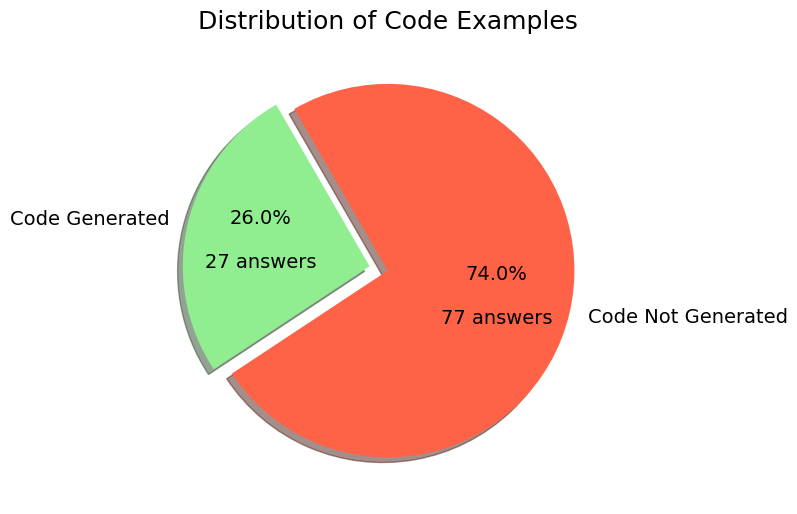

In [35]:
import matplotlib.pyplot as plt

# Increase font sizes globally
plt.rcParams.update({'font.size': 14,  # Adjust base font size as needed
                     'axes.titlesize': 18,  # Adjust for title
                     'axes.labelsize': 16,  # Adjust for x and y labels
                     'xtick.labelsize': 14,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 14,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend

# Data for the pie chart
sizes_asked_yes = [yes_yes_count, (104-yes_yes_count)]
labels_asked_yes = ['Code Generated', 'Code Not Generated']

# Custom autopct function to include both percentage and count with more vertical spacing
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Adjust the vertical spacing with \n\n for more space
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

# Improved Pie Chart
plt.figure(figsize=(8, 8))
explode = (0.1, 0)  # Explode the 'Code Generated' slice slightly to draw attention to it
plt.pie(sizes_asked_yes, labels=labels_asked_yes, autopct=autopct_format(sizes_asked_yes), startangle=120, colors=['lightgreen', 'tomato'], explode=explode, shadow=True, textprops={'fontsize': 14})
plt.title('Distribution of Code Examples', fontweight='normal')
plt.tight_layout()  # Adjusts subplots to fit in the figure area.
plt.show()


In [36]:
import json

# Assuming the file path is still valid
file_path = "Further Json Outputs/valued_rephrased_data.json"

# Re-read the data
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize the sum and count for calculating the average
total_confidence_percentage = 0
count_valid_percentages = 0

# Iterate through each item to sum up and count valid "Confidence Percentage" values
for item in data:
    adjusted_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    total_confidence_percentage += adjusted_percentage
    count_valid_percentages += 1  # Increment for every item, since we adjust invalid values to 0

# Calculate the average, ensuring we don't divide by zero
average_confidence_percentage = (total_confidence_percentage / count_valid_percentages) if count_valid_percentages > 0 else 0

# Print the average "Confidence Percentage"
print(f'Average "Confidence Percentage" across the dataset: {average_confidence_percentage:.2f}%')

Average "Confidence Percentage" across the dataset: 23.88%


In [37]:
import numpy as np

# Assuming you have re-read the data and have the 'adjust_confidence_percentage' function ready
# Extract all valid "Confidence Percentage" values as a list
confidence_percentages = [adjust_confidence_percentage(item["Confidence Percentage"]) for item in data]

# Calculate percentiles
low_threshold = np.percentile(confidence_percentages, 25)
medium_threshold = np.percentile(confidence_percentages, 50)  # This is essentially the median
high_threshold = np.percentile(confidence_percentages, 75)

# Now, categorize the values based on these thresholds
low_count = len([x for x in confidence_percentages if x <= low_threshold])
medium_count = len([x for x in confidence_percentages if low_threshold < x <= medium_threshold])
high_count = len([x for x in confidence_percentages if x > medium_threshold])  # This includes values above the high_threshold

# Print the thresholds and counts
print(f'Low Threshold (25th percentile): {low_threshold}%')
print(f'Medium Threshold (50th percentile, Median): {medium_threshold}%')
print(f'High Threshold (75th percentile): {high_threshold}%')
print(f'Count of Low "Confidence Percentage": {low_count}')
print(f'Count of Medium "Confidence Percentage": {medium_count}')
print(f'Count of High "Confidence Percentage": {high_count}')

Low Threshold (25th percentile): 0.0%
Medium Threshold (50th percentile, Median): 0.0%
High Threshold (75th percentile): 40.0%
Count of Low "Confidence Percentage": 2104
Count of Medium "Confidence Percentage": 0
Count of High "Confidence Percentage": 1720


In [38]:
import numpy as np

# Calculate histogram bins and counts
bin_edges = np.linspace(0, 100, 11)  # Define 10 bins from 0 to 100
hist_counts, _ = np.histogram(confidence_percentages, bins=bin_edges)

# Print the counts for each bin
for i in range(len(bin_edges)-1):
    print(f'Confidence Percentage {bin_edges[i]:.0f}% to {bin_edges[i+1]:.0f}%: {hist_counts[i]} answers')


Confidence Percentage 0% to 10%: 2172 answers
Confidence Percentage 10% to 20%: 307 answers
Confidence Percentage 20% to 30%: 253 answers
Confidence Percentage 30% to 40%: 112 answers
Confidence Percentage 40% to 50%: 82 answers
Confidence Percentage 50% to 60%: 122 answers
Confidence Percentage 60% to 70%: 71 answers
Confidence Percentage 70% to 80%: 81 answers
Confidence Percentage 80% to 90%: 117 answers
Confidence Percentage 90% to 100%: 507 answers


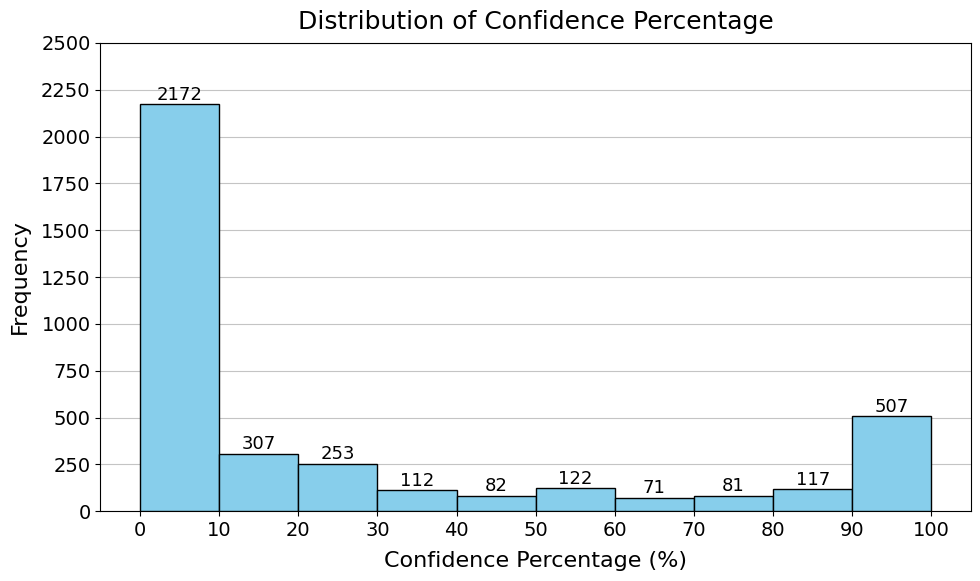

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Increase font sizes globally
plt.rcParams.update({'font.size': 13,  # Adjust base font size as needed
                     'axes.titlesize': 18,  # Adjust for title
                     'axes.labelsize': 16,  # Adjust for x and y labels
                     'xtick.labelsize': 14,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 14,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend
                     

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(confidence_percentages, bins=10, color='skyblue', edgecolor='black', alpha=1 ,zorder=3)

# Calculate the center of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Increase the spacing value here, for example to 10 or more, to increase spacing between bars and numbers
spacing = 25  # Adjust this value to increase or decrease the spacing

# Add text for the label in the center of each bin with increased spacing
for count, x in zip(n, bin_centers):
    if count > 0:
        plt.text(x, count + spacing, str(int(count)), ha='center')

plt.title('Distribution of Confidence Percentage', fontweight='normal', pad=10)
plt.xlabel('Confidence Percentage (%)', labelpad=8)
plt.ylabel('Frequency', labelpad=8)
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, max(2750, max(n) + 100), max(250, (max(n) + 100)//10)))

plt.grid(axis='y', alpha=0.75, zorder=0)
plt.tight_layout()
plt.show()


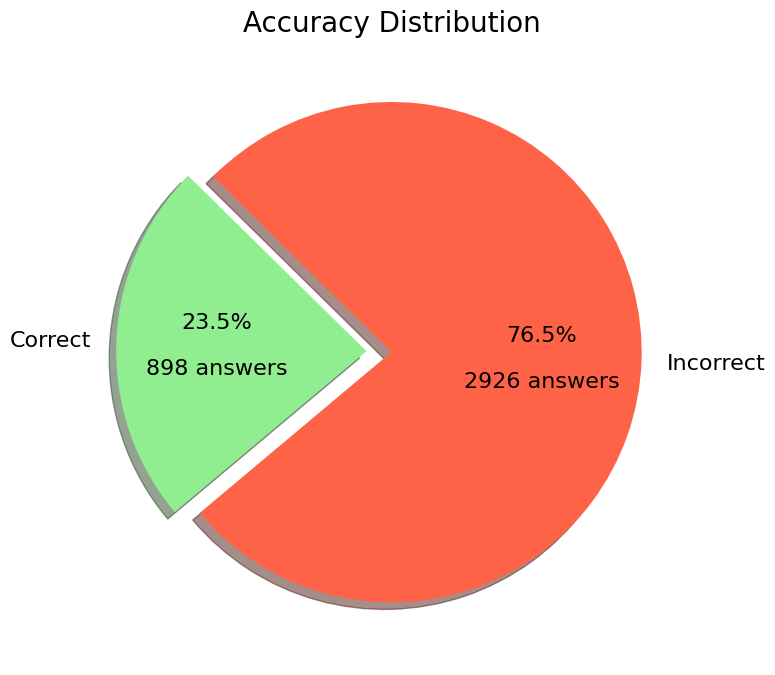

In [40]:
import matplotlib.pyplot as plt

# # Assuming gpt3_validation_0_count and gpt3_validation_1_count are defined somewhere in your code
# gpt3_validation_0_count = 1200  # Example value
# gpt3_validation_1_count = 2800  # Example value

# Increase font sizes globally
plt.rcParams.update({'font.size': 16,  # Adjust base font size as needed
                     'axes.titlesize': 20,  # Adjust for title
                     'axes.labelsize': 18,  # Adjust for x and y labels
                     'xtick.labelsize': 16,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 16,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend

# Data for plotting
gpt3_validation_counts = [gpt3_validation_0_count, gpt3_validation_1_count]
gpt3_labels = ['Incorrect', 'Correct']  # Use more descriptive labels

# Custom autopct function to include both percentage and count with more vertical spacing
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Adjust the vertical spacing with \n\n for more space
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

# Improved Pie Chart
plt.figure(figsize=(8, 8))
explode = (0, 0.1)  # Only explode the 'Correct' slice
plt.pie(gpt3_validation_counts, labels=gpt3_labels, autopct=autopct_format(gpt3_validation_counts), startangle=220, colors=['tomato', 'lightgreen'], explode=explode, shadow=True, textprops={'fontsize': 16})
plt.title('Accuracy Distribution', fontweight='normal')
plt.tight_layout()  # Adjusts subplots to fit in the figure area.
plt.show()
